In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
#from sklearn.metrics import F1Scorea
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import datetime
from sklearn.model_selection import StratifiedKFold

In [2]:
DATASET_PATH: str = "../../dataset/"

In [3]:
df = pd.read_csv('../../dataset/trainU.csv', sep=',', index_col=0)

In [4]:
df.shape

(299, 4421)

In [5]:
#cor_matrix = df.corr().abs()
#upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)

In [6]:
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
#print(len(to_drop))
#print(len(data_cols))

In [7]:
#to_drop_positions = df.columns.get_indexer(to_drop)

In [8]:
#to_drop_positions

In [9]:
#df1 = df.drop(df.columns[to_drop_positions], axis=1)

In [10]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
print(len(data_cols))

4420


In [11]:
X = df[data_cols].values
y = df['DISEASE'].values

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
one_hot = encoder.fit(np.array(df['DISEASE']).reshape(-1, 1))
y_o = one_hot.transform(np.array(df['DISEASE']).reshape(-1, 1))

In [13]:
y_o = y_o.toarray()

In [14]:
folds = 3
acc_per_fold = []
loss_per_fold = []
skf = StratifiedKFold(n_splits=folds, shuffle=False)
skf.get_n_splits(X, y)

3

In [15]:
rm -rf ./logs/

In [16]:
%load_ext tensorboard

In [17]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS1 = hp.HParam('num_units1', hp.Discrete([64, 56]))
HP_NUM_UNITS2 = hp.HParam('num_units2', hp.Discrete([32, 24]))
HP_NUM_UNITS3 = hp.HParam('num_units3', hp.Discrete([16, 8]))
HP_DROPOUT1 = hp.HParam('dropout1', hp.RealInterval(0.2, 0.4))
HP_DROPOUT2 = hp.HParam('dropout2', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

EPOCHS = 200
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2, HP_NUM_UNITS3, HP_DROPOUT1, HP_DROPOUT2, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
        )

2022-06-23 13:22:29.664765: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
def train_val_model(hparams, run_name):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT1]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT1]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT2]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    log_dir = "logs/fit/" + run_name + "-fold-" + str(fold_count)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model.fit(X[train_index], y_o[train_index],   
            epochs=EPOCHS, 
            validation_data=(X[test_index], y_o[test_index]),
            callbacks=[tensorboard_callback]
            )
    scores = model.evaluate(X[test_index], y_o[test_index])

    res = [scores[1]*100, num_units1, num_units2, num_units3, dropout1_rate, dropout2_rate, optimizer, scores[0], fold_count,session_num]
    
    return res

In [19]:
def run(run_dir, hparams, run_name):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  
        results_run = train_val_model(hparams, run_name)
        tf.summary.scalar(METRIC_ACCURACY, results_run[0], step=1)
    return results_run

In [20]:
session_num = 0
results_session = []
fold_count = 0

for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            for dropout1_rate in (HP_DROPOUT1.domain.min_value, HP_DROPOUT1.domain.max_value):
                for dropout2_rate in (HP_DROPOUT2.domain.min_value, HP_DROPOUT2.domain.max_value):
                    for optimizer in HP_OPTIMIZER.domain.values:
                        for train_index, test_index in skf.split(X, y):
                            hparams = {
                              HP_NUM_UNITS1: num_units1,
                              HP_NUM_UNITS2: num_units2,
                              HP_NUM_UNITS3: num_units3,
                              HP_DROPOUT1: dropout1_rate,
                              HP_DROPOUT2: dropout2_rate,
                              HP_OPTIMIZER: optimizer,
                            }
                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            print("Fold: ", fold_count)
                            results_session.append(run('logs/hparam_tuning/' + run_name + "-fold-" + str(fold_count), hparams, run_name))
                            fold_count+=1
                            if fold_count > 2:
                                fold_count = 0
                        session_num += 1

--- Starting trial: run-0
{'num_units1': 56, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 61ms/step - loss: 1.5413 - accuracy: 0.3869 - val_loss: 1.3945 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 26ms/step - loss: 1.4734 - accuracy: 0.4020 - val_loss: 1.3123 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 27ms/step - loss: 1.4250 - accuracy: 0.4221 - val_loss: 1.2754 - val_accuracy: 0.7500
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3375 - accuracy: 0.5126 - val_loss: 1.2023 - val_accuracy: 0.5400
Epoch 5/200
7/7 [==============================] - 0s 30ms/step - loss: 1.2226 - accuracy: 0.5126 - val_loss: 1.1821 - val_accuracy: 0.4400
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1426 - accuracy: 0.5477 - val_loss: 1.0497 - val_accuracy: 0.7200
Epoch 7/200
7/7 

7/7 [==============================] - 0s 23ms/step - loss: 0.1082 - accuracy: 0.9648 - val_loss: 0.4514 - val_accuracy: 0.8600
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0883 - accuracy: 0.9749 - val_loss: 0.3829 - val_accuracy: 0.9300
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1171 - accuracy: 0.9447 - val_loss: 0.4466 - val_accuracy: 0.8700
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1642 - accuracy: 0.9347 - val_loss: 0.3155 - val_accuracy: 0.9100
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1514 - accuracy: 0.9447 - val_loss: 0.5234 - val_accuracy: 0.8500
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1167 - accuracy: 0.9648 - val_loss: 0.5017 - val_accuracy: 0.8900
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1176 - accuracy: 0.9598 - val_loss: 0.3794 - val_accuracy: 0.9300
Epoch 65/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0732 - accuracy: 0.9698 - val_loss: 0.5971 - val_accuracy: 0.9000
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0803 - accuracy: 0.9698 - val_loss: 0.3288 - val_accuracy: 0.9400
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0837 - accuracy: 0.9548 - val_loss: 0.3231 - val_accuracy: 0.9500
Epoch 119/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0916 - accuracy: 0.9749 - val_loss: 0.4456 - val_accuracy: 0.9100
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0656 - accuracy: 0.9799 - val_loss: 0.8100 - val_accuracy: 0.8700
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0764 - accuracy: 0.9698 - val_loss: 0.4554 - val_accuracy: 0.8900
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0834 - accuracy: 0.9698 - val_loss: 0.5370 - val_accuracy: 0.9000
Epoch 123/200
7/7 [=

Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1232 - accuracy: 0.9497 - val_loss: 0.5914 - val_accuracy: 0.9000
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0565 - accuracy: 0.9899 - val_loss: 0.8845 - val_accuracy: 0.8800
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0592 - accuracy: 0.9799 - val_loss: 0.4707 - val_accuracy: 0.9300
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0584 - accuracy: 0.9849 - val_loss: 0.3393 - val_accuracy: 0.9500
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1071 - accuracy: 0.9698 - val_loss: 0.4023 - val_accuracy: 0.9200
Epoch 179/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1534 - accuracy: 0.9548 - val_loss: 0.2952 - val_accuracy: 0.8700
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0719 - accuracy: 0.9799 - val_loss: 0.4554 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.3332 - accuracy: 0.8543 - val_loss: 0.6347 - val_accuracy: 0.7800
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3541 - accuracy: 0.8543 - val_loss: 0.6021 - val_accuracy: 0.8000
Epoch 32/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3178 - accuracy: 0.8894 - val_loss: 0.6184 - val_accuracy: 0.7700
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3014 - accuracy: 0.8945 - val_loss: 0.5370 - val_accuracy: 0.8300
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3091 - accuracy: 0.8492 - val_loss: 0.5870 - val_accuracy: 0.8100
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3207 - accuracy: 0.8543 - val_loss: 0.7687 - val_accuracy: 0.8000
Epoch 36/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3051 - accuracy: 0.8693 - val_loss: 0.5560 - val_accuracy: 0.8100
Epoch 37/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1192 - accuracy: 0.9648 - val_loss: 0.7253 - val_accuracy: 0.8700
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0447 - accuracy: 0.9849 - val_loss: 0.8106 - val_accuracy: 0.8200
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1308 - accuracy: 0.9497 - val_loss: 0.6277 - val_accuracy: 0.8900
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0922 - accuracy: 0.9698 - val_loss: 0.4148 - val_accuracy: 0.9200
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0899 - accuracy: 0.9698 - val_loss: 0.4327 - val_accuracy: 0.9000
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0698 - accuracy: 0.9799 - val_loss: 0.5767 - val_accuracy: 0.8800
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0838 - accuracy: 0.9648 - val_loss: 0.8710 - val_accuracy: 0.8800
Epoch 95/200
7/7 [========

Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1512 - accuracy: 0.9347 - val_loss: 0.8626 - val_accuracy: 0.8300
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1060 - accuracy: 0.9749 - val_loss: 0.7643 - val_accuracy: 0.8800
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0815 - accuracy: 0.9598 - val_loss: 0.7157 - val_accuracy: 0.8900
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1066 - accuracy: 0.9698 - val_loss: 0.6515 - val_accuracy: 0.8700
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1799 - accuracy: 0.9447 - val_loss: 0.4634 - val_accuracy: 0.8700
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0981 - accuracy: 0.9648 - val_loss: 0.5985 - val_accuracy: 0.8300
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1044 - accuracy: 0.9648 - val_loss: 0.6172 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.6240 - accuracy: 0.3700 - val_loss: 1.2538 - val_accuracy: 0.4444
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4349 - accuracy: 0.3150 - val_loss: 1.2844 - val_accuracy: 0.5556
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3832 - accuracy: 0.4000 - val_loss: 1.1932 - val_accuracy: 0.7374
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3537 - accuracy: 0.4550 - val_loss: 1.1631 - val_accuracy: 0.7475
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2280 - accuracy: 0.5400 - val_loss: 1.1313 - val_accuracy: 0.6970
Epoch 7/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2040 - accuracy: 0.5450 - val_loss: 1.0785 - val_accuracy: 0.7475
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1080 - accuracy: 0.6400 - val_loss: 0.9834 - val_accuracy: 0.7374
Epoch 9/200
7/7 [===============

7/7 [==============================] - 0s 23ms/step - loss: 0.1576 - accuracy: 0.9400 - val_loss: 0.3836 - val_accuracy: 0.8990
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1770 - accuracy: 0.9300 - val_loss: 0.3971 - val_accuracy: 0.9091
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1287 - accuracy: 0.9500 - val_loss: 0.4481 - val_accuracy: 0.8889
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2174 - accuracy: 0.9250 - val_loss: 0.3791 - val_accuracy: 0.8889
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1962 - accuracy: 0.9250 - val_loss: 0.3358 - val_accuracy: 0.8990
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1682 - accuracy: 0.9400 - val_loss: 0.5147 - val_accuracy: 0.8788
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1611 - accuracy: 0.9400 - val_loss: 0.3464 - val_accuracy: 0.8889
Epoch 67/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1481 - accuracy: 0.9500 - val_loss: 0.6263 - val_accuracy: 0.8788
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1272 - accuracy: 0.9650 - val_loss: 0.5275 - val_accuracy: 0.9091
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1425 - accuracy: 0.9550 - val_loss: 0.4336 - val_accuracy: 0.9192
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1273 - accuracy: 0.9450 - val_loss: 0.3777 - val_accuracy: 0.9192
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1667 - accuracy: 0.9500 - val_loss: 0.5881 - val_accuracy: 0.8485
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1992 - accuracy: 0.9150 - val_loss: 0.4281 - val_accuracy: 0.8283
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2251 - accuracy: 0.9450 - val_loss: 0.4526 - val_accuracy: 0.8889
Epoch 125/200
7/7 [=

Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0925 - accuracy: 0.9650 - val_loss: 0.4298 - val_accuracy: 0.9091
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1088 - accuracy: 0.9600 - val_loss: 0.4710 - val_accuracy: 0.8990
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1267 - accuracy: 0.9500 - val_loss: 0.4972 - val_accuracy: 0.8889
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1232 - accuracy: 0.9600 - val_loss: 0.4757 - val_accuracy: 0.8889
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1226 - accuracy: 0.9600 - val_loss: 0.3937 - val_accuracy: 0.9091
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0774 - accuracy: 0.9650 - val_loss: 0.3863 - val_accuracy: 0.8990
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1063 - accuracy: 0.9600 - val_loss: 0.4668 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.6448 - accuracy: 0.7437 - val_loss: 0.6936 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6214 - accuracy: 0.7337 - val_loss: 0.6900 - val_accuracy: 0.7700
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6421 - accuracy: 0.7538 - val_loss: 0.6450 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5623 - accuracy: 0.7538 - val_loss: 0.6779 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6318 - accuracy: 0.7538 - val_loss: 0.6036 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5769 - accuracy: 0.7688 - val_loss: 0.6068 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5503 - accuracy: 0.7638 - val_loss: 0.6254 - val_accuracy: 0.7600
Epoch 39/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.2716 - accuracy: 0.8945 - val_loss: 0.4437 - val_accuracy: 0.8500
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2380 - accuracy: 0.9095 - val_loss: 0.5297 - val_accuracy: 0.8100
Epoch 92/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2916 - accuracy: 0.8995 - val_loss: 0.4273 - val_accuracy: 0.8700
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2442 - accuracy: 0.9296 - val_loss: 0.3810 - val_accuracy: 0.9000
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2670 - accuracy: 0.9397 - val_loss: 0.3953 - val_accuracy: 0.8700
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2147 - accuracy: 0.9497 - val_loss: 0.4088 - val_accuracy: 0.8500
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2191 - accuracy: 0.9497 - val_loss: 0.4854 - val_accuracy: 0.8500
Epoch 97/200
7/7 [========

Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1006 - accuracy: 0.9698 - val_loss: 0.4816 - val_accuracy: 0.8700
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0793 - accuracy: 0.9849 - val_loss: 0.4124 - val_accuracy: 0.8800
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1023 - accuracy: 0.9749 - val_loss: 0.5542 - val_accuracy: 0.8400
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1008 - accuracy: 0.9698 - val_loss: 0.5264 - val_accuracy: 0.8500
Epoch 152/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1271 - accuracy: 0.9497 - val_loss: 0.3717 - val_accuracy: 0.8900
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0785 - accuracy: 0.9749 - val_loss: 0.3887 - val_accuracy: 0.9000
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1173 - accuracy: 0.9698 - val_loss: 0.3700 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1646 - accuracy: 0.6281 - val_loss: 1.1756 - val_accuracy: 0.4700
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1944 - accuracy: 0.5930 - val_loss: 1.1633 - val_accuracy: 0.7600
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1492 - accuracy: 0.6382 - val_loss: 1.0788 - val_accuracy: 0.7000
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0817 - accuracy: 0.6482 - val_loss: 0.9386 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0734 - accuracy: 0.6784 - val_loss: 0.9140 - val_accuracy: 0.7600
Epoch 9/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9924 - accuracy: 0.6583 - val_loss: 0.8534 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9438 - accuracy: 0.6884 - val_loss: 0.9536 - val_accuracy: 0.7600
Epoch 11/200
7/7 [=============

7/7 [==============================] - 0s 22ms/step - loss: 0.2023 - accuracy: 0.9397 - val_loss: 0.5159 - val_accuracy: 0.8300
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1666 - accuracy: 0.9698 - val_loss: 0.4122 - val_accuracy: 0.8700
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1854 - accuracy: 0.9397 - val_loss: 0.5044 - val_accuracy: 0.8300
Epoch 65/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1956 - accuracy: 0.9447 - val_loss: 0.4266 - val_accuracy: 0.8700
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1592 - accuracy: 0.9648 - val_loss: 0.4047 - val_accuracy: 0.8800
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2084 - accuracy: 0.9347 - val_loss: 0.4533 - val_accuracy: 0.8500
Epoch 68/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1859 - accuracy: 0.9497 - val_loss: 0.4731 - val_accuracy: 0.8500
Epoch 69/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.0925 - accuracy: 0.9749 - val_loss: 0.3596 - val_accuracy: 0.9100
Epoch 121/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0740 - accuracy: 0.9799 - val_loss: 0.5950 - val_accuracy: 0.8700
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0711 - accuracy: 0.9749 - val_loss: 0.6744 - val_accuracy: 0.7400
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1217 - accuracy: 0.9648 - val_loss: 0.4473 - val_accuracy: 0.8800
Epoch 124/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1063 - accuracy: 0.9648 - val_loss: 0.4872 - val_accuracy: 0.8800
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0874 - accuracy: 0.9799 - val_loss: 0.5612 - val_accuracy: 0.8800
Epoch 126/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0862 - accuracy: 0.9749 - val_loss: 0.3718 - val_accuracy: 0.8900
Epoch 127/200
7/7 [=

Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0435 - accuracy: 0.9899 - val_loss: 0.6173 - val_accuracy: 0.8800
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0500 - accuracy: 0.9799 - val_loss: 0.6481 - val_accuracy: 0.8700
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0465 - accuracy: 0.9799 - val_loss: 0.5400 - val_accuracy: 0.8800
Epoch 181/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0375 - accuracy: 0.9899 - val_loss: 0.5826 - val_accuracy: 0.8800
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0581 - accuracy: 0.9849 - val_loss: 0.4609 - val_accuracy: 0.8900
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0781 - accuracy: 0.9648 - val_loss: 0.5397 - val_accuracy: 0.8700
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0905 - accuracy: 0.9799 - val_loss: 0.6055 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5252 - accuracy: 0.7900 - val_loss: 0.5970 - val_accuracy: 0.7677
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4665 - accuracy: 0.8400 - val_loss: 0.5535 - val_accuracy: 0.7778
Epoch 36/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4746 - accuracy: 0.8550 - val_loss: 0.7762 - val_accuracy: 0.7576
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5317 - accuracy: 0.8250 - val_loss: 0.5210 - val_accuracy: 0.7778
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4180 - accuracy: 0.8400 - val_loss: 0.5096 - val_accuracy: 0.8081
Epoch 39/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4308 - accuracy: 0.8500 - val_loss: 0.6486 - val_accuracy: 0.7576
Epoch 40/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4255 - accuracy: 0.8350 - val_loss: 0.4697 - val_accuracy: 0.8485
Epoch 41/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1819 - accuracy: 0.9300 - val_loss: 0.4068 - val_accuracy: 0.8889
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1508 - accuracy: 0.9650 - val_loss: 0.3985 - val_accuracy: 0.8889
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1930 - accuracy: 0.9300 - val_loss: 0.3960 - val_accuracy: 0.8889
Epoch 95/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2070 - accuracy: 0.9200 - val_loss: 0.4227 - val_accuracy: 0.9091
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1473 - accuracy: 0.9750 - val_loss: 0.3967 - val_accuracy: 0.8889
Epoch 97/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1976 - accuracy: 0.9300 - val_loss: 0.4524 - val_accuracy: 0.8788
Epoch 98/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1783 - accuracy: 0.9400 - val_loss: 0.3714 - val_accuracy: 0.8788
Epoch 99/200
7/7 [========

Epoch 150/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1304 - accuracy: 0.9550 - val_loss: 0.3792 - val_accuracy: 0.9091
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0768 - accuracy: 0.9850 - val_loss: 0.4035 - val_accuracy: 0.9091
Epoch 152/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0772 - accuracy: 0.9700 - val_loss: 0.4243 - val_accuracy: 0.8990
Epoch 153/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0631 - accuracy: 0.9850 - val_loss: 0.3963 - val_accuracy: 0.9091
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0708 - accuracy: 0.9850 - val_loss: 0.4535 - val_accuracy: 0.8586
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0826 - accuracy: 0.9800 - val_loss: 0.4725 - val_accuracy: 0.8990
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0779 - accuracy: 0.9750 - val_loss: 0.4270 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0941 - accuracy: 0.6181 - val_loss: 0.9954 - val_accuracy: 0.7500
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0831 - accuracy: 0.6231 - val_loss: 0.9725 - val_accuracy: 0.7500
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9565 - accuracy: 0.6683 - val_loss: 0.8120 - val_accuracy: 0.7600
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9451 - accuracy: 0.6935 - val_loss: 0.8563 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9837 - accuracy: 0.6633 - val_loss: 0.7658 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9625 - accuracy: 0.6482 - val_loss: 0.7922 - val_accuracy: 0.7500
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8518 - accuracy: 0.7035 - val_loss: 0.7300 - val_accuracy: 0.7500
Epoch 13/200
7/7 [===========

7/7 [==============================] - 0s 21ms/step - loss: 0.3524 - accuracy: 0.8241 - val_loss: 0.5392 - val_accuracy: 0.8000
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4073 - accuracy: 0.7839 - val_loss: 0.4955 - val_accuracy: 0.7900
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3752 - accuracy: 0.7990 - val_loss: 0.5536 - val_accuracy: 0.7800
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4137 - accuracy: 0.8040 - val_loss: 0.5346 - val_accuracy: 0.7800
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4242 - accuracy: 0.7739 - val_loss: 0.5855 - val_accuracy: 0.7700
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3609 - accuracy: 0.8342 - val_loss: 0.7158 - val_accuracy: 0.7700
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3638 - accuracy: 0.8392 - val_loss: 0.5481 - val_accuracy: 0.7800
Epoch 71/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2870 - accuracy: 0.8894 - val_loss: 0.9031 - val_accuracy: 0.8200
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2797 - accuracy: 0.8945 - val_loss: 0.6436 - val_accuracy: 0.8600
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3376 - accuracy: 0.8995 - val_loss: 0.6745 - val_accuracy: 0.7600
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2846 - accuracy: 0.8844 - val_loss: 0.4558 - val_accuracy: 0.8500
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3451 - accuracy: 0.8643 - val_loss: 0.6494 - val_accuracy: 0.8000
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3708 - accuracy: 0.8492 - val_loss: 0.4608 - val_accuracy: 0.8600
Epoch 128/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3217 - accuracy: 0.8543 - val_loss: 0.5917 - val_accuracy: 0.8000
Epoch 129/200
7/7 [=

Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3670 - accuracy: 0.8392 - val_loss: 0.6053 - val_accuracy: 0.8800
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3729 - accuracy: 0.8593 - val_loss: 0.6657 - val_accuracy: 0.8400
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3852 - accuracy: 0.8392 - val_loss: 0.6147 - val_accuracy: 0.7500
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3949 - accuracy: 0.8191 - val_loss: 0.5118 - val_accuracy: 0.8400
Epoch 184/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3964 - accuracy: 0.8241 - val_loss: 1.2528 - val_accuracy: 0.7500
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3477 - accuracy: 0.8693 - val_loss: 0.7537 - val_accuracy: 0.8000
Epoch 186/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2737 - accuracy: 0.9196 - val_loss: 0.8739 - val_accuracy: 0.8100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.4558 - accuracy: 0.7739 - val_loss: 0.5918 - val_accuracy: 0.7900
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4321 - accuracy: 0.8040 - val_loss: 0.6127 - val_accuracy: 0.7700
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4372 - accuracy: 0.7839 - val_loss: 0.5618 - val_accuracy: 0.7900
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4407 - accuracy: 0.7889 - val_loss: 0.6353 - val_accuracy: 0.7700
Epoch 40/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4473 - accuracy: 0.7940 - val_loss: 0.7535 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4019 - accuracy: 0.8040 - val_loss: 0.5461 - val_accuracy: 0.8100
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3906 - accuracy: 0.8191 - val_loss: 0.6407 - val_accuracy: 0.7800
Epoch 43/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3080 - accuracy: 0.8945 - val_loss: 0.6185 - val_accuracy: 0.8200
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3052 - accuracy: 0.8844 - val_loss: 0.5802 - val_accuracy: 0.8300
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2916 - accuracy: 0.8945 - val_loss: 0.5545 - val_accuracy: 0.8400
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2835 - accuracy: 0.8894 - val_loss: 0.6831 - val_accuracy: 0.8400
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3483 - accuracy: 0.8543 - val_loss: 0.9322 - val_accuracy: 0.8200
Epoch 99/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3342 - accuracy: 0.8643 - val_loss: 0.8410 - val_accuracy: 0.8300
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3137 - accuracy: 0.8894 - val_loss: 0.6845 - val_accuracy: 0.8300
Epoch 101/200
7/7 [======

Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3133 - accuracy: 0.8693 - val_loss: 0.8183 - val_accuracy: 0.8400
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2639 - accuracy: 0.8894 - val_loss: 1.1689 - val_accuracy: 0.8200
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3725 - accuracy: 0.8291 - val_loss: 0.6164 - val_accuracy: 0.8400
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2383 - accuracy: 0.9095 - val_loss: 0.6109 - val_accuracy: 0.8400
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2506 - accuracy: 0.9095 - val_loss: 0.7941 - val_accuracy: 0.8500
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2769 - accuracy: 0.8794 - val_loss: 0.9178 - val_accuracy: 0.8300
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2803 - accuracy: 0.8744 - val_loss: 0.7471 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0898 - accuracy: 0.6150 - val_loss: 0.9797 - val_accuracy: 0.7374
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0971 - accuracy: 0.5800 - val_loss: 0.9108 - val_accuracy: 0.7172
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9718 - accuracy: 0.6450 - val_loss: 0.8771 - val_accuracy: 0.7071
Epoch 11/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9269 - accuracy: 0.6850 - val_loss: 0.8605 - val_accuracy: 0.7172
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9495 - accuracy: 0.6400 - val_loss: 0.7709 - val_accuracy: 0.7576
Epoch 13/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9864 - accuracy: 0.6700 - val_loss: 0.8013 - val_accuracy: 0.7172
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8684 - accuracy: 0.6750 - val_loss: 0.7972 - val_accuracy: 0.7172
Epoch 15/200
7/7 [=========

7/7 [==============================] - 0s 21ms/step - loss: 0.3411 - accuracy: 0.8400 - val_loss: 0.5852 - val_accuracy: 0.7677
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3370 - accuracy: 0.8400 - val_loss: 0.6636 - val_accuracy: 0.8182
Epoch 68/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3145 - accuracy: 0.8500 - val_loss: 0.5606 - val_accuracy: 0.7980
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3550 - accuracy: 0.8550 - val_loss: 0.5928 - val_accuracy: 0.7778
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3479 - accuracy: 0.8350 - val_loss: 0.5366 - val_accuracy: 0.7879
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3200 - accuracy: 0.8300 - val_loss: 0.5057 - val_accuracy: 0.7980
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3307 - accuracy: 0.8550 - val_loss: 0.5265 - val_accuracy: 0.7879
Epoch 73/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2777 - accuracy: 0.8800 - val_loss: 0.5927 - val_accuracy: 0.8283
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3019 - accuracy: 0.8700 - val_loss: 0.5791 - val_accuracy: 0.8283
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4166 - accuracy: 0.8100 - val_loss: 0.6131 - val_accuracy: 0.8182
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3243 - accuracy: 0.8700 - val_loss: 0.6527 - val_accuracy: 0.8182
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2768 - accuracy: 0.8950 - val_loss: 0.6441 - val_accuracy: 0.7980
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2930 - accuracy: 0.8550 - val_loss: 0.5591 - val_accuracy: 0.8384
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3552 - accuracy: 0.8350 - val_loss: 0.4905 - val_accuracy: 0.8485
Epoch 131/200
7/7 [=

Epoch 182/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2393 - accuracy: 0.8850 - val_loss: 0.6255 - val_accuracy: 0.8283
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2856 - accuracy: 0.8800 - val_loss: 0.6096 - val_accuracy: 0.8182
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2037 - accuracy: 0.8950 - val_loss: 0.6482 - val_accuracy: 0.8384
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2842 - accuracy: 0.8750 - val_loss: 0.6307 - val_accuracy: 0.8081
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2826 - accuracy: 0.8900 - val_loss: 0.5010 - val_accuracy: 0.8384
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2979 - accuracy: 0.8450 - val_loss: 0.5036 - val_accuracy: 0.8182
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2835 - accuracy: 0.8750 - val_loss: 0.4671 - val_accuracy: 0.8485
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6877 - accuracy: 0.7538 - val_loss: 0.6468 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5842 - accuracy: 0.7889 - val_loss: 0.6657 - val_accuracy: 0.7500
Epoch 40/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6066 - accuracy: 0.7437 - val_loss: 0.6662 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6170 - accuracy: 0.7688 - val_loss: 0.7750 - val_accuracy: 0.7500
Epoch 42/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5504 - accuracy: 0.8040 - val_loss: 0.8189 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6001 - accuracy: 0.7940 - val_loss: 0.6054 - val_accuracy: 0.7900
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5723 - accuracy: 0.7688 - val_loss: 0.7947 - val_accuracy: 0.7500
Epoch 45/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.3136 - accuracy: 0.8794 - val_loss: 0.5184 - val_accuracy: 0.8600
Epoch 97/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2620 - accuracy: 0.9296 - val_loss: 0.4770 - val_accuracy: 0.8700
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2357 - accuracy: 0.9146 - val_loss: 0.5215 - val_accuracy: 0.8500
Epoch 99/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2813 - accuracy: 0.9146 - val_loss: 0.4239 - val_accuracy: 0.8800
Epoch 100/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2500 - accuracy: 0.9246 - val_loss: 0.5290 - val_accuracy: 0.8600
Epoch 101/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2578 - accuracy: 0.9146 - val_loss: 0.5060 - val_accuracy: 0.8600
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2455 - accuracy: 0.9146 - val_loss: 0.4674 - val_accuracy: 0.8700
Epoch 103/200
7/7 [====

Epoch 154/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1182 - accuracy: 0.9648 - val_loss: 0.4127 - val_accuracy: 0.8700
Epoch 155/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1146 - accuracy: 0.9698 - val_loss: 0.5774 - val_accuracy: 0.8600
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1559 - accuracy: 0.9497 - val_loss: 0.4276 - val_accuracy: 0.8400
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1590 - accuracy: 0.9447 - val_loss: 0.3785 - val_accuracy: 0.9200
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0883 - accuracy: 0.9849 - val_loss: 0.3433 - val_accuracy: 0.9300
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1273 - accuracy: 0.9548 - val_loss: 0.3759 - val_accuracy: 0.9200
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0965 - accuracy: 0.9849 - val_loss: 0.4102 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.0648 - accuracy: 0.6533 - val_loss: 1.1758 - val_accuracy: 0.4800
Epoch 11/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0388 - accuracy: 0.6633 - val_loss: 0.8842 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9957 - accuracy: 0.6533 - val_loss: 0.8361 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9793 - accuracy: 0.6683 - val_loss: 0.8879 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9170 - accuracy: 0.7035 - val_loss: 0.8605 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9112 - accuracy: 0.6884 - val_loss: 0.7778 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8169 - accuracy: 0.7136 - val_loss: 0.7823 - val_accuracy: 0.7600
Epoch 17/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4139 - accuracy: 0.8191 - val_loss: 0.8043 - val_accuracy: 0.6900
Epoch 69/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4235 - accuracy: 0.8191 - val_loss: 0.6179 - val_accuracy: 0.7600
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4057 - accuracy: 0.8342 - val_loss: 0.5862 - val_accuracy: 0.7900
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3939 - accuracy: 0.8492 - val_loss: 0.5388 - val_accuracy: 0.8100
Epoch 72/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3868 - accuracy: 0.8593 - val_loss: 0.5712 - val_accuracy: 0.7800
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3753 - accuracy: 0.8693 - val_loss: 0.5536 - val_accuracy: 0.8000
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3987 - accuracy: 0.8442 - val_loss: 0.6741 - val_accuracy: 0.7700
Epoch 75/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2531 - accuracy: 0.9196 - val_loss: 0.5989 - val_accuracy: 0.8200
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2598 - accuracy: 0.9296 - val_loss: 0.5784 - val_accuracy: 0.8100
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2454 - accuracy: 0.9246 - val_loss: 0.7848 - val_accuracy: 0.7700
Epoch 129/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2485 - accuracy: 0.9296 - val_loss: 0.5414 - val_accuracy: 0.8700
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2392 - accuracy: 0.9196 - val_loss: 0.7545 - val_accuracy: 0.7900
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2029 - accuracy: 0.9296 - val_loss: 0.6304 - val_accuracy: 0.8200
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2481 - accuracy: 0.9246 - val_loss: 0.5641 - val_accuracy: 0.8300
Epoch 133/200
7/7 [=

Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1259 - accuracy: 0.9698 - val_loss: 0.7315 - val_accuracy: 0.8200
Epoch 185/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1213 - accuracy: 0.9598 - val_loss: 0.5816 - val_accuracy: 0.8700
Epoch 186/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1280 - accuracy: 0.9598 - val_loss: 0.5587 - val_accuracy: 0.8800
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1406 - accuracy: 0.9648 - val_loss: 0.4218 - val_accuracy: 0.8900
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1446 - accuracy: 0.9497 - val_loss: 0.6997 - val_accuracy: 0.8400
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1724 - accuracy: 0.9548 - val_loss: 0.5749 - val_accuracy: 0.8800
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1295 - accuracy: 0.9497 - val_loss: 0.5477 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5528 - accuracy: 0.8150 - val_loss: 0.5611 - val_accuracy: 0.7879
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5587 - accuracy: 0.8050 - val_loss: 0.5886 - val_accuracy: 0.7778
Epoch 42/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5043 - accuracy: 0.8050 - val_loss: 0.5694 - val_accuracy: 0.7980
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4919 - accuracy: 0.8050 - val_loss: 0.5397 - val_accuracy: 0.8081
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4466 - accuracy: 0.8200 - val_loss: 0.5608 - val_accuracy: 0.7778
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4836 - accuracy: 0.8200 - val_loss: 0.5480 - val_accuracy: 0.8283
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5021 - accuracy: 0.8000 - val_loss: 0.7659 - val_accuracy: 0.7071
Epoch 47/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1597 - accuracy: 0.9700 - val_loss: 0.4483 - val_accuracy: 0.8889
Epoch 99/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2157 - accuracy: 0.9250 - val_loss: 0.4615 - val_accuracy: 0.8788
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1685 - accuracy: 0.9550 - val_loss: 0.4986 - val_accuracy: 0.8687
Epoch 101/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2058 - accuracy: 0.9300 - val_loss: 0.4236 - val_accuracy: 0.8889
Epoch 102/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1767 - accuracy: 0.9450 - val_loss: 0.9238 - val_accuracy: 0.7273
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2502 - accuracy: 0.9050 - val_loss: 0.5316 - val_accuracy: 0.8788
Epoch 104/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1711 - accuracy: 0.9500 - val_loss: 0.4764 - val_accuracy: 0.8687
Epoch 105/200
7/7 [==

Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1134 - accuracy: 0.9700 - val_loss: 0.5654 - val_accuracy: 0.8889
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1095 - accuracy: 0.9800 - val_loss: 0.4962 - val_accuracy: 0.8990
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1233 - accuracy: 0.9700 - val_loss: 0.5436 - val_accuracy: 0.8889
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0941 - accuracy: 0.9750 - val_loss: 0.4748 - val_accuracy: 0.8990
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1072 - accuracy: 0.9750 - val_loss: 0.4890 - val_accuracy: 0.8889
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1518 - accuracy: 0.9450 - val_loss: 0.4938 - val_accuracy: 0.8485
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1112 - accuracy: 0.9750 - val_loss: 0.5625 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.9872 - accuracy: 0.6533 - val_loss: 0.7987 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9798 - accuracy: 0.6231 - val_loss: 0.8092 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9764 - accuracy: 0.6683 - val_loss: 0.8037 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9362 - accuracy: 0.6784 - val_loss: 0.7890 - val_accuracy: 0.7500
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8845 - accuracy: 0.7035 - val_loss: 0.7981 - val_accuracy: 0.7500
Epoch 17/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9147 - accuracy: 0.6884 - val_loss: 0.7368 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8752 - accuracy: 0.6583 - val_loss: 0.7419 - val_accuracy: 0.7500
Epoch 19/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6043 - accuracy: 0.7085 - val_loss: 0.6207 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5893 - accuracy: 0.6985 - val_loss: 0.5339 - val_accuracy: 0.7500
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6314 - accuracy: 0.6985 - val_loss: 0.5424 - val_accuracy: 0.7500
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6106 - accuracy: 0.7136 - val_loss: 0.5974 - val_accuracy: 0.7500
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5754 - accuracy: 0.7186 - val_loss: 0.6158 - val_accuracy: 0.7500
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5614 - accuracy: 0.7035 - val_loss: 0.5419 - val_accuracy: 0.7500
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5876 - accuracy: 0.7035 - val_loss: 0.5634 - val_accuracy: 0.7600
Epoch 77/200
7/7 [========

Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6107 - accuracy: 0.7136 - val_loss: 0.6915 - val_accuracy: 0.7700
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4813 - accuracy: 0.7990 - val_loss: 0.5981 - val_accuracy: 0.7600
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6574 - accuracy: 0.7035 - val_loss: 0.6474 - val_accuracy: 0.7700
Epoch 131/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5421 - accuracy: 0.7588 - val_loss: 0.8562 - val_accuracy: 0.7300
Epoch 132/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5928 - accuracy: 0.7387 - val_loss: 0.8007 - val_accuracy: 0.7700
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5772 - accuracy: 0.7337 - val_loss: 0.9437 - val_accuracy: 0.7600
Epoch 134/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5944 - accuracy: 0.7085 - val_loss: 0.5401 - val_accuracy: 0.8100
Epoch 

Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7292 - accuracy: 0.6935 - val_loss: 0.5297 - val_accuracy: 0.7600
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6670 - accuracy: 0.7337 - val_loss: 0.5458 - val_accuracy: 0.7600
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7322 - accuracy: 0.7035 - val_loss: 0.5679 - val_accuracy: 0.7600
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6897 - accuracy: 0.7085 - val_loss: 0.5917 - val_accuracy: 0.7600
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7025 - accuracy: 0.7035 - val_loss: 0.6082 - val_accuracy: 0.7600
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6647 - accuracy: 0.7387 - val_loss: 0.6270 - val_accuracy: 0.7600
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6893 - accuracy: 0.7136 - val_loss: 0.6550 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7232 - accuracy: 0.7136 - val_loss: 0.7009 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6803 - accuracy: 0.7236 - val_loss: 0.7584 - val_accuracy: 0.7500
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6881 - accuracy: 0.7186 - val_loss: 0.6707 - val_accuracy: 0.7400
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6361 - accuracy: 0.7236 - val_loss: 0.7951 - val_accuracy: 0.7500
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6643 - accuracy: 0.7337 - val_loss: 0.7239 - val_accuracy: 0.7500
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6313 - accuracy: 0.7337 - val_loss: 0.6812 - val_accuracy: 0.7400
Epoch 48/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6679 - accuracy: 0.7387 - val_loss: 0.8536 - val_accuracy: 0.7500
Epoch 49/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6248 - accuracy: 0.7236 - val_loss: 1.3109 - val_accuracy: 0.7500
Epoch 101/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5976 - accuracy: 0.7387 - val_loss: 0.9773 - val_accuracy: 0.7400
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5702 - accuracy: 0.7437 - val_loss: 0.7909 - val_accuracy: 0.7400
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5889 - accuracy: 0.7286 - val_loss: 0.8481 - val_accuracy: 0.7500
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6143 - accuracy: 0.7387 - val_loss: 1.2197 - val_accuracy: 0.7500
Epoch 105/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6424 - accuracy: 0.7186 - val_loss: 0.8546 - val_accuracy: 0.7400
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6177 - accuracy: 0.7387 - val_loss: 0.7622 - val_accuracy: 0.7400
Epoch 107/200
7/7 [=

Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6345 - accuracy: 0.7236 - val_loss: 1.1349 - val_accuracy: 0.7400
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7404 - accuracy: 0.6985 - val_loss: 0.8632 - val_accuracy: 0.7400
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8282 - accuracy: 0.6533 - val_loss: 0.7810 - val_accuracy: 0.7300
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6650 - accuracy: 0.7035 - val_loss: 0.7883 - val_accuracy: 0.7300
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6644 - accuracy: 0.6935 - val_loss: 0.8236 - val_accuracy: 0.7400
Epoch 163/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6805 - accuracy: 0.6935 - val_loss: 0.8836 - val_accuracy: 0.7400
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7131 - accuracy: 0.6935 - val_loss: 0.9901 - val_accuracy: 0.7400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.7311 - accuracy: 0.7000 - val_loss: 0.7392 - val_accuracy: 0.6970
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7083 - accuracy: 0.7200 - val_loss: 0.7014 - val_accuracy: 0.7273
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6977 - accuracy: 0.7250 - val_loss: 0.6864 - val_accuracy: 0.7374
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6804 - accuracy: 0.7450 - val_loss: 0.6863 - val_accuracy: 0.7273
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6259 - accuracy: 0.7400 - val_loss: 0.6504 - val_accuracy: 0.7374
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5941 - accuracy: 0.7450 - val_loss: 0.7177 - val_accuracy: 0.7071
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6195 - accuracy: 0.7400 - val_loss: 0.6788 - val_accuracy: 0.7273
Epoch 21/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4122 - accuracy: 0.8200 - val_loss: 0.5957 - val_accuracy: 0.7879
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4235 - accuracy: 0.8150 - val_loss: 0.5913 - val_accuracy: 0.7879
Epoch 74/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4119 - accuracy: 0.8200 - val_loss: 0.6527 - val_accuracy: 0.7778
Epoch 75/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3939 - accuracy: 0.8250 - val_loss: 0.5695 - val_accuracy: 0.7576
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4378 - accuracy: 0.8200 - val_loss: 0.5799 - val_accuracy: 0.7980
Epoch 77/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3860 - accuracy: 0.8250 - val_loss: 0.5405 - val_accuracy: 0.7778
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4442 - accuracy: 0.8250 - val_loss: 0.7924 - val_accuracy: 0.7475
Epoch 79/200
7/7 [========

Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3649 - accuracy: 0.8350 - val_loss: 0.6920 - val_accuracy: 0.7677
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3526 - accuracy: 0.8350 - val_loss: 0.8288 - val_accuracy: 0.7879
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3801 - accuracy: 0.8250 - val_loss: 0.7437 - val_accuracy: 0.7778
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3788 - accuracy: 0.8250 - val_loss: 0.7258 - val_accuracy: 0.7677
Epoch 134/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4426 - accuracy: 0.7900 - val_loss: 0.8340 - val_accuracy: 0.7576
Epoch 135/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3607 - accuracy: 0.8300 - val_loss: 0.7129 - val_accuracy: 0.7980
Epoch 136/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4183 - accuracy: 0.8050 - val_loss: 0.6947 - val_accuracy: 0.7778
Epoch 

Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4992 - accuracy: 0.7900 - val_loss: 1.0400 - val_accuracy: 0.7576
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4588 - accuracy: 0.7850 - val_loss: 0.6387 - val_accuracy: 0.7677
Epoch 190/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5626 - accuracy: 0.7450 - val_loss: 0.6679 - val_accuracy: 0.7879
Epoch 191/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5151 - accuracy: 0.7800 - val_loss: 0.6252 - val_accuracy: 0.7677
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5704 - accuracy: 0.7500 - val_loss: 0.6681 - val_accuracy: 0.7879
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5011 - accuracy: 0.7700 - val_loss: 0.7483 - val_accuracy: 0.7980
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5185 - accuracy: 0.7600 - val_loss: 0.6862 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.0161 - accuracy: 0.7286 - val_loss: 1.0204 - val_accuracy: 0.7500
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0487 - accuracy: 0.7035 - val_loss: 1.0045 - val_accuracy: 0.7300
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9782 - accuracy: 0.7337 - val_loss: 1.0049 - val_accuracy: 0.7300
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0238 - accuracy: 0.7236 - val_loss: 0.9856 - val_accuracy: 0.7400
Epoch 48/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9642 - accuracy: 0.7186 - val_loss: 1.1505 - val_accuracy: 0.7100
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9963 - accuracy: 0.7337 - val_loss: 1.1081 - val_accuracy: 0.7300
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9019 - accuracy: 0.7387 - val_loss: 0.9453 - val_accuracy: 0.7500
Epoch 51/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.5586 - accuracy: 0.8291 - val_loss: 0.8021 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6278 - accuracy: 0.7839 - val_loss: 0.5738 - val_accuracy: 0.8000
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5276 - accuracy: 0.8191 - val_loss: 0.8112 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6591 - accuracy: 0.7839 - val_loss: 0.6111 - val_accuracy: 0.8000
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4736 - accuracy: 0.8442 - val_loss: 0.6261 - val_accuracy: 0.7800
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5248 - accuracy: 0.8241 - val_loss: 0.7463 - val_accuracy: 0.7600
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5097 - accuracy: 0.8241 - val_loss: 0.6902 - val_accuracy: 0.7600
Epoch 109/200
7/7 [=

Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4289 - accuracy: 0.8342 - val_loss: 0.7558 - val_accuracy: 0.7800
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3688 - accuracy: 0.8492 - val_loss: 0.6109 - val_accuracy: 0.8200
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3669 - accuracy: 0.8643 - val_loss: 0.4788 - val_accuracy: 0.8300
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3727 - accuracy: 0.8945 - val_loss: 0.5323 - val_accuracy: 0.8600
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3584 - accuracy: 0.8744 - val_loss: 0.5082 - val_accuracy: 0.8400
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3332 - accuracy: 0.8593 - val_loss: 0.5407 - val_accuracy: 0.8200
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3360 - accuracy: 0.8894 - val_loss: 0.4341 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 1.2771 - accuracy: 0.4925 - val_loss: 1.2168 - val_accuracy: 0.5100
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2217 - accuracy: 0.5879 - val_loss: 1.1436 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1507 - accuracy: 0.5628 - val_loss: 1.1669 - val_accuracy: 0.7500
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2037 - accuracy: 0.5528 - val_loss: 1.1554 - val_accuracy: 0.6900
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2099 - accuracy: 0.5779 - val_loss: 1.0323 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1111 - accuracy: 0.6131 - val_loss: 0.9665 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0825 - accuracy: 0.5879 - val_loss: 0.9660 - val_accuracy: 0.7600
Epoch 23/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5589 - accuracy: 0.7839 - val_loss: 0.5930 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5559 - accuracy: 0.7889 - val_loss: 0.6392 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5153 - accuracy: 0.7940 - val_loss: 0.6582 - val_accuracy: 0.7700
Epoch 77/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5042 - accuracy: 0.7990 - val_loss: 0.5653 - val_accuracy: 0.7700
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4365 - accuracy: 0.8241 - val_loss: 0.6153 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4810 - accuracy: 0.8090 - val_loss: 0.5618 - val_accuracy: 0.7700
Epoch 80/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4172 - accuracy: 0.8291 - val_loss: 0.6596 - val_accuracy: 0.7600
Epoch 81/200
7/7 [========

Epoch 132/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3380 - accuracy: 0.8543 - val_loss: 0.6341 - val_accuracy: 0.8100
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2861 - accuracy: 0.8945 - val_loss: 0.5797 - val_accuracy: 0.8000
Epoch 134/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3061 - accuracy: 0.8794 - val_loss: 0.5773 - val_accuracy: 0.8400
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2760 - accuracy: 0.8995 - val_loss: 0.7083 - val_accuracy: 0.7900
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3047 - accuracy: 0.8593 - val_loss: 0.6693 - val_accuracy: 0.7900
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2832 - accuracy: 0.8894 - val_loss: 0.5602 - val_accuracy: 0.8300
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2873 - accuracy: 0.8643 - val_loss: 0.6632 - val_accuracy: 0.8100
Epoch 

Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2491 - accuracy: 0.8945 - val_loss: 0.5257 - val_accuracy: 0.8800
Epoch 191/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2499 - accuracy: 0.8945 - val_loss: 0.6260 - val_accuracy: 0.8400
Epoch 192/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2338 - accuracy: 0.9146 - val_loss: 0.6251 - val_accuracy: 0.8600
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2585 - accuracy: 0.8844 - val_loss: 0.6505 - val_accuracy: 0.8300
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2101 - accuracy: 0.9095 - val_loss: 0.5248 - val_accuracy: 0.8800
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2130 - accuracy: 0.9196 - val_loss: 0.7325 - val_accuracy: 0.8400
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2225 - accuracy: 0.9246 - val_loss: 0.5860 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6869 - accuracy: 0.7300 - val_loss: 0.6305 - val_accuracy: 0.7677
Epoch 47/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5945 - accuracy: 0.7600 - val_loss: 0.6029 - val_accuracy: 0.7677
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6508 - accuracy: 0.7700 - val_loss: 0.5859 - val_accuracy: 0.7677
Epoch 49/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6014 - accuracy: 0.7650 - val_loss: 0.7248 - val_accuracy: 0.7172
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6641 - accuracy: 0.7350 - val_loss: 0.6787 - val_accuracy: 0.8182
Epoch 51/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6202 - accuracy: 0.7850 - val_loss: 0.5870 - val_accuracy: 0.7576
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5853 - accuracy: 0.7950 - val_loss: 0.6120 - val_accuracy: 0.7677
Epoch 53/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3055 - accuracy: 0.8800 - val_loss: 0.3657 - val_accuracy: 0.9192
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3257 - accuracy: 0.8900 - val_loss: 0.4342 - val_accuracy: 0.8586
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3104 - accuracy: 0.8850 - val_loss: 0.3832 - val_accuracy: 0.8990
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3650 - accuracy: 0.8600 - val_loss: 0.4822 - val_accuracy: 0.8283
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4106 - accuracy: 0.8550 - val_loss: 0.3778 - val_accuracy: 0.8889
Epoch 109/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3596 - accuracy: 0.8650 - val_loss: 0.5226 - val_accuracy: 0.8182
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3677 - accuracy: 0.8600 - val_loss: 0.4179 - val_accuracy: 0.8687
Epoch 111/200
7/7 [=

Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2150 - accuracy: 0.9350 - val_loss: 0.3236 - val_accuracy: 0.9192
Epoch 163/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1995 - accuracy: 0.9250 - val_loss: 0.3304 - val_accuracy: 0.9091
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1730 - accuracy: 0.9300 - val_loss: 0.3165 - val_accuracy: 0.9091
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2008 - accuracy: 0.9350 - val_loss: 0.3124 - val_accuracy: 0.9192
Epoch 166/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1821 - accuracy: 0.9350 - val_loss: 0.3093 - val_accuracy: 0.9293
Epoch 167/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1787 - accuracy: 0.9550 - val_loss: 0.3200 - val_accuracy: 0.9394
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2149 - accuracy: 0.9250 - val_loss: 0.4045 - val_accuracy: 0.9091
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0877 - accuracy: 0.5276 - val_loss: 0.9536 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1473 - accuracy: 0.5377 - val_loss: 1.0619 - val_accuracy: 0.6700
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0852 - accuracy: 0.5678 - val_loss: 0.8853 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0215 - accuracy: 0.5829 - val_loss: 0.9526 - val_accuracy: 0.7100
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0015 - accuracy: 0.5578 - val_loss: 0.8698 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9540 - accuracy: 0.5729 - val_loss: 0.8794 - val_accuracy: 0.7400
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0274 - accuracy: 0.5226 - val_loss: 0.8208 - val_accuracy: 0.7600
Epoch 25/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6625 - accuracy: 0.6985 - val_loss: 0.6412 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8262 - accuracy: 0.6734 - val_loss: 0.5640 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7435 - accuracy: 0.6884 - val_loss: 0.5814 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7453 - accuracy: 0.6884 - val_loss: 0.6501 - val_accuracy: 0.7600
Epoch 80/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7021 - accuracy: 0.7236 - val_loss: 0.7193 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7602 - accuracy: 0.7085 - val_loss: 0.6724 - val_accuracy: 0.7600
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6758 - accuracy: 0.7286 - val_loss: 0.6959 - val_accuracy: 0.7600
Epoch 83/200
7/7 [========

Epoch 134/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7816 - accuracy: 0.6935 - val_loss: 0.7211 - val_accuracy: 0.7600
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7393 - accuracy: 0.6834 - val_loss: 0.7538 - val_accuracy: 0.7600
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7698 - accuracy: 0.6834 - val_loss: 0.7567 - val_accuracy: 0.7600
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7807 - accuracy: 0.7035 - val_loss: 0.7624 - val_accuracy: 0.7600
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6796 - accuracy: 0.7236 - val_loss: 0.8291 - val_accuracy: 0.7600
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6555 - accuracy: 0.7387 - val_loss: 0.6212 - val_accuracy: 0.7600
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6990 - accuracy: 0.7035 - val_loss: 0.5608 - val_accuracy: 0.7600
Epoch 

Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7941 - accuracy: 0.6935 - val_loss: 0.5542 - val_accuracy: 0.7600
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6456 - accuracy: 0.7286 - val_loss: 0.5429 - val_accuracy: 0.7600
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6869 - accuracy: 0.7085 - val_loss: 0.5435 - val_accuracy: 0.7600
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7003 - accuracy: 0.7236 - val_loss: 0.5545 - val_accuracy: 0.7600
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7007 - accuracy: 0.7136 - val_loss: 0.6083 - val_accuracy: 0.7600
Epoch 197/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6898 - accuracy: 0.7035 - val_loss: 0.7600 - val_accuracy: 0.7600
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6914 - accuracy: 0.7186 - val_loss: 0.8744 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6868 - accuracy: 0.7286 - val_loss: 0.7105 - val_accuracy: 0.7400
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6994 - accuracy: 0.7437 - val_loss: 0.7073 - val_accuracy: 0.7300
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7495 - accuracy: 0.7136 - val_loss: 0.6767 - val_accuracy: 0.7500
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6429 - accuracy: 0.7487 - val_loss: 0.7735 - val_accuracy: 0.7500
Epoch 52/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7146 - accuracy: 0.7286 - val_loss: 0.6993 - val_accuracy: 0.7400
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6824 - accuracy: 0.7337 - val_loss: 0.6846 - val_accuracy: 0.7400
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7139 - accuracy: 0.7236 - val_loss: 0.8582 - val_accuracy: 0.7600
Epoch 55/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.7259 - accuracy: 0.6533 - val_loss: 0.8249 - val_accuracy: 0.7500
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7456 - accuracy: 0.6734 - val_loss: 0.7909 - val_accuracy: 0.7500
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6705 - accuracy: 0.7286 - val_loss: 0.7241 - val_accuracy: 0.7300
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6676 - accuracy: 0.7035 - val_loss: 0.7251 - val_accuracy: 0.7300
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6966 - accuracy: 0.6935 - val_loss: 0.7422 - val_accuracy: 0.7200
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7430 - accuracy: 0.6884 - val_loss: 0.7517 - val_accuracy: 0.7300
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6898 - accuracy: 0.6834 - val_loss: 0.8852 - val_accuracy: 0.7500
Epoch 113/200
7/7 [=

Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7688 - accuracy: 0.6683 - val_loss: 0.9304 - val_accuracy: 0.7400
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6850 - accuracy: 0.6985 - val_loss: 1.0079 - val_accuracy: 0.7400
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7435 - accuracy: 0.6533 - val_loss: 0.8146 - val_accuracy: 0.7400
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7396 - accuracy: 0.6734 - val_loss: 0.7933 - val_accuracy: 0.7100
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7228 - accuracy: 0.6985 - val_loss: 0.8686 - val_accuracy: 0.7400
Epoch 169/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6536 - accuracy: 0.6985 - val_loss: 0.8637 - val_accuracy: 0.7400
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7087 - accuracy: 0.6935 - val_loss: 0.9034 - val_accuracy: 0.7400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9839 - accuracy: 0.6550 - val_loss: 0.8451 - val_accuracy: 0.7475
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9719 - accuracy: 0.6400 - val_loss: 0.7176 - val_accuracy: 0.7475
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9231 - accuracy: 0.6550 - val_loss: 0.7307 - val_accuracy: 0.7374
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9216 - accuracy: 0.6750 - val_loss: 0.7154 - val_accuracy: 0.7677
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8454 - accuracy: 0.6700 - val_loss: 0.6815 - val_accuracy: 0.7475
Epoch 25/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8361 - accuracy: 0.7100 - val_loss: 0.6453 - val_accuracy: 0.7576
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8110 - accuracy: 0.6750 - val_loss: 0.6672 - val_accuracy: 0.7273
Epoch 27/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6415 - accuracy: 0.6950 - val_loss: 0.6670 - val_accuracy: 0.6768
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7363 - accuracy: 0.6850 - val_loss: 0.5761 - val_accuracy: 0.7475
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7576 - accuracy: 0.6800 - val_loss: 0.6651 - val_accuracy: 0.7475
Epoch 81/200
7/7 [==============================] - 0s 26ms/step - loss: 0.7256 - accuracy: 0.6700 - val_loss: 0.6233 - val_accuracy: 0.7374
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7288 - accuracy: 0.6950 - val_loss: 0.5881 - val_accuracy: 0.7374
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7242 - accuracy: 0.6800 - val_loss: 0.5869 - val_accuracy: 0.7374
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7253 - accuracy: 0.6900 - val_loss: 0.5856 - val_accuracy: 0.7475
Epoch 85/200
7/7 [========

Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7573 - accuracy: 0.6650 - val_loss: 0.6169 - val_accuracy: 0.7172
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6769 - accuracy: 0.7050 - val_loss: 0.6134 - val_accuracy: 0.7374
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6419 - accuracy: 0.7000 - val_loss: 0.6349 - val_accuracy: 0.7374
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7198 - accuracy: 0.6600 - val_loss: 0.6707 - val_accuracy: 0.7475
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7886 - accuracy: 0.6500 - val_loss: 0.7190 - val_accuracy: 0.7576
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7041 - accuracy: 0.6950 - val_loss: 0.7697 - val_accuracy: 0.7576
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6222 - accuracy: 0.7150 - val_loss: 0.7472 - val_accuracy: 0.7576
Epoch 

Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8194 - accuracy: 0.6400 - val_loss: 0.6316 - val_accuracy: 0.7576
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8588 - accuracy: 0.6050 - val_loss: 0.6359 - val_accuracy: 0.7677
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9160 - accuracy: 0.6150 - val_loss: 0.6429 - val_accuracy: 0.7677
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8530 - accuracy: 0.6200 - val_loss: 0.6783 - val_accuracy: 0.7677
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8487 - accuracy: 0.6250 - val_loss: 0.7149 - val_accuracy: 0.7677
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8728 - accuracy: 0.6250 - val_loss: 0.6351 - val_accuracy: 0.7677
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.7273
--- Starting trial: run-7
{'num_units1': 56, 'num

7/7 [==============================] - 0s 21ms/step - loss: 0.8391 - accuracy: 0.6935 - val_loss: 0.7176 - val_accuracy: 0.7500
Epoch 51/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8248 - accuracy: 0.7337 - val_loss: 0.7493 - val_accuracy: 0.7500
Epoch 52/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7341 - accuracy: 0.7186 - val_loss: 0.6723 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7575 - accuracy: 0.7186 - val_loss: 0.9459 - val_accuracy: 0.6300
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8702 - accuracy: 0.6683 - val_loss: 0.7226 - val_accuracy: 0.7500
Epoch 55/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7712 - accuracy: 0.7186 - val_loss: 1.0158 - val_accuracy: 0.5400
Epoch 56/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8399 - accuracy: 0.6985 - val_loss: 0.6920 - val_accuracy: 0.7600
Epoch 57/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.4885 - accuracy: 0.7839 - val_loss: 0.5025 - val_accuracy: 0.8000
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4953 - accuracy: 0.7889 - val_loss: 0.5545 - val_accuracy: 0.7700
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4837 - accuracy: 0.7889 - val_loss: 0.5567 - val_accuracy: 0.7900
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4984 - accuracy: 0.7940 - val_loss: 0.6690 - val_accuracy: 0.7600
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4592 - accuracy: 0.8141 - val_loss: 0.5258 - val_accuracy: 0.8100
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4688 - accuracy: 0.7889 - val_loss: 0.6134 - val_accuracy: 0.7700
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4586 - accuracy: 0.8040 - val_loss: 0.6261 - val_accuracy: 0.7700
Epoch 115/200
7/7 [=

Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3924 - accuracy: 0.8392 - val_loss: 0.5699 - val_accuracy: 0.7700
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3787 - accuracy: 0.8191 - val_loss: 0.5575 - val_accuracy: 0.7800
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3810 - accuracy: 0.8291 - val_loss: 0.5583 - val_accuracy: 0.7900
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3746 - accuracy: 0.8241 - val_loss: 0.5841 - val_accuracy: 0.7600
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4108 - accuracy: 0.8342 - val_loss: 0.5136 - val_accuracy: 0.8200
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3306 - accuracy: 0.8643 - val_loss: 0.4816 - val_accuracy: 0.8200
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3795 - accuracy: 0.8291 - val_loss: 0.5630 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1961 - accuracy: 0.5276 - val_loss: 1.0942 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1938 - accuracy: 0.5578 - val_loss: 1.0439 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1226 - accuracy: 0.6030 - val_loss: 1.0275 - val_accuracy: 0.7300
Epoch 25/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1598 - accuracy: 0.5980 - val_loss: 0.9725 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1418 - accuracy: 0.6131 - val_loss: 0.9648 - val_accuracy: 0.7400
Epoch 27/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0595 - accuracy: 0.6583 - val_loss: 0.9043 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0508 - accuracy: 0.6834 - val_loss: 0.9448 - val_accuracy: 0.7400
Epoch 29/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6729 - accuracy: 0.6985 - val_loss: 0.6066 - val_accuracy: 0.7400
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6788 - accuracy: 0.7236 - val_loss: 0.6289 - val_accuracy: 0.7600
Epoch 82/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6368 - accuracy: 0.7588 - val_loss: 0.6188 - val_accuracy: 0.7600
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6650 - accuracy: 0.7437 - val_loss: 0.6132 - val_accuracy: 0.7600
Epoch 84/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6387 - accuracy: 0.7538 - val_loss: 0.7225 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6561 - accuracy: 0.7286 - val_loss: 0.5985 - val_accuracy: 0.7500
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6613 - accuracy: 0.7286 - val_loss: 0.7006 - val_accuracy: 0.7600
Epoch 87/200
7/7 [========

Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5228 - accuracy: 0.7588 - val_loss: 0.6295 - val_accuracy: 0.7400
Epoch 139/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5175 - accuracy: 0.7688 - val_loss: 0.6246 - val_accuracy: 0.7700
Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4516 - accuracy: 0.7940 - val_loss: 0.6271 - val_accuracy: 0.7700
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4614 - accuracy: 0.7839 - val_loss: 0.6613 - val_accuracy: 0.7800
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5016 - accuracy: 0.7688 - val_loss: 0.6414 - val_accuracy: 0.7500
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4876 - accuracy: 0.7638 - val_loss: 0.6193 - val_accuracy: 0.7700
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4265 - accuracy: 0.7889 - val_loss: 0.6913 - val_accuracy: 0.7600
Epoch 

Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3830 - accuracy: 0.8241 - val_loss: 0.7639 - val_accuracy: 0.7700
Epoch 197/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3732 - accuracy: 0.8392 - val_loss: 0.5796 - val_accuracy: 0.8000
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4665 - accuracy: 0.8291 - val_loss: 0.7719 - val_accuracy: 0.7700
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3605 - accuracy: 0.8593 - val_loss: 0.7866 - val_accuracy: 0.7700
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.8100
--- Starting trial: run-7
{'num_units1': 56, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 47ms/step - loss: 1.6595 - accuracy: 0.2600 - val_loss: 1.4516 - val_accuracy: 0.4242
Epoch 2/200
7/7 [==============================] -

7/7 [==============================] - 0s 22ms/step - loss: 0.6105 - accuracy: 0.7400 - val_loss: 0.6316 - val_accuracy: 0.7475
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5967 - accuracy: 0.7650 - val_loss: 0.6129 - val_accuracy: 0.7273
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6310 - accuracy: 0.7500 - val_loss: 0.6461 - val_accuracy: 0.7576
Epoch 55/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6025 - accuracy: 0.7500 - val_loss: 0.6505 - val_accuracy: 0.7475
Epoch 56/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5777 - accuracy: 0.7600 - val_loss: 0.6967 - val_accuracy: 0.6970
Epoch 57/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5978 - accuracy: 0.7350 - val_loss: 0.5883 - val_accuracy: 0.7576
Epoch 58/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6255 - accuracy: 0.7400 - val_loss: 0.6089 - val_accuracy: 0.7576
Epoch 59/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4128 - accuracy: 0.8550 - val_loss: 0.5245 - val_accuracy: 0.8081
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3785 - accuracy: 0.8250 - val_loss: 0.5485 - val_accuracy: 0.8283
Epoch 112/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4305 - accuracy: 0.8250 - val_loss: 0.4912 - val_accuracy: 0.8384
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4327 - accuracy: 0.8150 - val_loss: 0.5096 - val_accuracy: 0.8687
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4064 - accuracy: 0.8700 - val_loss: 0.5086 - val_accuracy: 0.8586
Epoch 115/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3584 - accuracy: 0.8600 - val_loss: 0.6143 - val_accuracy: 0.7677
Epoch 116/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3815 - accuracy: 0.8550 - val_loss: 0.4896 - val_accuracy: 0.8485
Epoch 117/200
7/7 [=

Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2892 - accuracy: 0.8950 - val_loss: 0.5683 - val_accuracy: 0.8485
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3273 - accuracy: 0.8750 - val_loss: 0.4863 - val_accuracy: 0.8889
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3341 - accuracy: 0.8800 - val_loss: 0.6359 - val_accuracy: 0.8283
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3094 - accuracy: 0.9000 - val_loss: 0.5407 - val_accuracy: 0.8788
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2634 - accuracy: 0.9100 - val_loss: 0.5497 - val_accuracy: 0.8889
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3098 - accuracy: 0.9050 - val_loss: 0.4849 - val_accuracy: 0.8889
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2655 - accuracy: 0.9000 - val_loss: 0.4963 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.4242 - accuracy: 0.8543 - val_loss: 0.4943 - val_accuracy: 0.7800
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3083 - accuracy: 0.8693 - val_loss: 0.4767 - val_accuracy: 0.8000
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3843 - accuracy: 0.8492 - val_loss: 0.4597 - val_accuracy: 0.8700
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3185 - accuracy: 0.8844 - val_loss: 0.5972 - val_accuracy: 0.7800
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3477 - accuracy: 0.8693 - val_loss: 0.4205 - val_accuracy: 0.8800
Epoch 29/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2903 - accuracy: 0.8894 - val_loss: 0.4702 - val_accuracy: 0.7900
Epoch 30/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2782 - accuracy: 0.8945 - val_loss: 0.4030 - val_accuracy: 0.8800
Epoch 31/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1596 - accuracy: 0.9497 - val_loss: 0.3931 - val_accuracy: 0.9200
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1933 - accuracy: 0.9095 - val_loss: 0.5146 - val_accuracy: 0.8600
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1147 - accuracy: 0.9648 - val_loss: 0.5329 - val_accuracy: 0.8900
Epoch 85/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1200 - accuracy: 0.9548 - val_loss: 0.5622 - val_accuracy: 0.8600
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1441 - accuracy: 0.9497 - val_loss: 0.3072 - val_accuracy: 0.9400
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1251 - accuracy: 0.9598 - val_loss: 0.4044 - val_accuracy: 0.8900
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1458 - accuracy: 0.9548 - val_loss: 0.4737 - val_accuracy: 0.8900
Epoch 89/200
7/7 [========

Epoch 140/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1315 - accuracy: 0.9497 - val_loss: 0.6779 - val_accuracy: 0.8900
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1190 - accuracy: 0.9497 - val_loss: 0.5513 - val_accuracy: 0.9100
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1033 - accuracy: 0.9548 - val_loss: 0.5742 - val_accuracy: 0.8900
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1042 - accuracy: 0.9648 - val_loss: 0.4443 - val_accuracy: 0.9300
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0938 - accuracy: 0.9799 - val_loss: 0.5667 - val_accuracy: 0.8900
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1019 - accuracy: 0.9698 - val_loss: 0.5617 - val_accuracy: 0.9200
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1027 - accuracy: 0.9648 - val_loss: 0.5525 - val_accuracy: 0.9300
Epoch 

Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0794 - accuracy: 0.9648 - val_loss: 0.8221 - val_accuracy: 0.9000
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0848 - accuracy: 0.9598 - val_loss: 0.4765 - val_accuracy: 0.9500
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3861 - accuracy: 0.9400
--- Starting trial: run-8
{'num_units1': 56, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 49ms/step - loss: 1.6070 - accuracy: 0.3166 - val_loss: 1.2802 - val_accuracy: 0.4700
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5211 - accuracy: 0.4422 - val_loss: 1.0920 - val_accuracy: 0.7400
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3200 - accuracy: 0.4573 - val_loss: 1.0269 - val_accuracy: 0.7600
Epoch 4/200
7/7 [==============================] - 0

7/7 [==============================] - 0s 23ms/step - loss: 0.0997 - accuracy: 0.9698 - val_loss: 1.0127 - val_accuracy: 0.8200
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1582 - accuracy: 0.9246 - val_loss: 0.5415 - val_accuracy: 0.8900
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1912 - accuracy: 0.9447 - val_loss: 0.4467 - val_accuracy: 0.9100
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1265 - accuracy: 0.9648 - val_loss: 0.4998 - val_accuracy: 0.9000
Epoch 58/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1550 - accuracy: 0.9598 - val_loss: 0.5217 - val_accuracy: 0.9200
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1620 - accuracy: 0.9598 - val_loss: 0.4899 - val_accuracy: 0.9100
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1337 - accuracy: 0.9648 - val_loss: 0.4681 - val_accuracy: 0.9000
Epoch 61/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1099 - accuracy: 0.9648 - val_loss: 0.7301 - val_accuracy: 0.8800
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0674 - accuracy: 0.9749 - val_loss: 0.5109 - val_accuracy: 0.9000
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1037 - accuracy: 0.9648 - val_loss: 0.4667 - val_accuracy: 0.9200
Epoch 115/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0728 - accuracy: 0.9799 - val_loss: 0.5449 - val_accuracy: 0.9000
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0585 - accuracy: 0.9799 - val_loss: 0.6885 - val_accuracy: 0.8800
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0698 - accuracy: 0.9749 - val_loss: 0.6703 - val_accuracy: 0.9200
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0613 - accuracy: 0.9849 - val_loss: 0.5683 - val_accuracy: 0.9200
Epoch 119/200
7/7 [=

Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1091 - accuracy: 0.9598 - val_loss: 0.4728 - val_accuracy: 0.8900
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0863 - accuracy: 0.9548 - val_loss: 0.5381 - val_accuracy: 0.8500
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1027 - accuracy: 0.9548 - val_loss: 0.5769 - val_accuracy: 0.9000
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0755 - accuracy: 0.9749 - val_loss: 0.7642 - val_accuracy: 0.8800
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1217 - accuracy: 0.9548 - val_loss: 0.5654 - val_accuracy: 0.9100
Epoch 175/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0926 - accuracy: 0.9598 - val_loss: 0.4899 - val_accuracy: 0.8800
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1176 - accuracy: 0.9447 - val_loss: 0.5509 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.4979 - accuracy: 0.7850 - val_loss: 0.5582 - val_accuracy: 0.7778
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4930 - accuracy: 0.7950 - val_loss: 0.5491 - val_accuracy: 0.7980
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4927 - accuracy: 0.7850 - val_loss: 0.5777 - val_accuracy: 0.7576
Epoch 29/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4443 - accuracy: 0.7900 - val_loss: 0.5634 - val_accuracy: 0.7778
Epoch 30/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4473 - accuracy: 0.7900 - val_loss: 0.5206 - val_accuracy: 0.7677
Epoch 31/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4486 - accuracy: 0.7900 - val_loss: 0.5022 - val_accuracy: 0.7879
Epoch 32/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4065 - accuracy: 0.8150 - val_loss: 0.5172 - val_accuracy: 0.8081
Epoch 33/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2352 - accuracy: 0.9050 - val_loss: 0.5192 - val_accuracy: 0.8788
Epoch 85/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2659 - accuracy: 0.9100 - val_loss: 0.5390 - val_accuracy: 0.8687
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2459 - accuracy: 0.9300 - val_loss: 0.5626 - val_accuracy: 0.8687
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2679 - accuracy: 0.9150 - val_loss: 0.5618 - val_accuracy: 0.8182
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2412 - accuracy: 0.9250 - val_loss: 0.4707 - val_accuracy: 0.8283
Epoch 89/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2514 - accuracy: 0.9100 - val_loss: 0.6123 - val_accuracy: 0.8283
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2548 - accuracy: 0.9200 - val_loss: 0.4621 - val_accuracy: 0.8788
Epoch 91/200
7/7 [========

Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2007 - accuracy: 0.9300 - val_loss: 0.6996 - val_accuracy: 0.8687
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1347 - accuracy: 0.9450 - val_loss: 0.5829 - val_accuracy: 0.8889
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1302 - accuracy: 0.9550 - val_loss: 0.5474 - val_accuracy: 0.8788
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1724 - accuracy: 0.9450 - val_loss: 0.5803 - val_accuracy: 0.8889
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0980 - accuracy: 0.9650 - val_loss: 0.6660 - val_accuracy: 0.8889
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1975 - accuracy: 0.9200 - val_loss: 0.6768 - val_accuracy: 0.8788
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2030 - accuracy: 0.9350 - val_loss: 0.6125 - val_accuracy: 0.8586
Epoch 

Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.7934 - accuracy: 0.8687
--- Starting trial: run-9
{'num_units1': 56, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 48ms/step - loss: 1.6771 - accuracy: 0.2613 - val_loss: 1.4794 - val_accuracy: 0.4300
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.5918 - accuracy: 0.2764 - val_loss: 1.4068 - val_accuracy: 0.6100
Epoch 3/200
7/7 [==============================] - 0s 21ms/step - loss: 1.4989 - accuracy: 0.3719 - val_loss: 1.3607 - val_accuracy: 0.5800
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4440 - accuracy: 0.3970 - val_loss: 1.2837 - val_accuracy: 0.6300
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3214 - accuracy: 0.5578 - val_loss: 1.1973 - val_accuracy: 0.7500
Epoch 6/200
7/7 [==============================] - 0s 22m

7/7 [==============================] - 0s 23ms/step - loss: 0.4081 - accuracy: 0.8693 - val_loss: 0.8828 - val_accuracy: 0.7200
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4580 - accuracy: 0.8593 - val_loss: 0.4928 - val_accuracy: 0.8300
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3855 - accuracy: 0.8844 - val_loss: 0.7606 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4108 - accuracy: 0.8693 - val_loss: 0.5097 - val_accuracy: 0.8100
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3716 - accuracy: 0.8945 - val_loss: 0.5104 - val_accuracy: 0.8600
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3591 - accuracy: 0.8744 - val_loss: 0.5410 - val_accuracy: 0.8100
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3485 - accuracy: 0.8693 - val_loss: 0.5168 - val_accuracy: 0.8000
Epoch 63/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1132 - accuracy: 0.9749 - val_loss: 0.3802 - val_accuracy: 0.9200
Epoch 115/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1082 - accuracy: 0.9799 - val_loss: 0.4600 - val_accuracy: 0.8500
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1301 - accuracy: 0.9598 - val_loss: 0.3110 - val_accuracy: 0.9300
Epoch 117/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1514 - accuracy: 0.9447 - val_loss: 0.3462 - val_accuracy: 0.9400
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1337 - accuracy: 0.9548 - val_loss: 0.4642 - val_accuracy: 0.8700
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1146 - accuracy: 0.9849 - val_loss: 0.3947 - val_accuracy: 0.8900
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0907 - accuracy: 0.9749 - val_loss: 0.5162 - val_accuracy: 0.8600
Epoch 121/200
7/7 [=

Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0910 - accuracy: 0.9698 - val_loss: 0.3001 - val_accuracy: 0.9300
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0988 - accuracy: 0.9698 - val_loss: 0.3870 - val_accuracy: 0.9100
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0528 - accuracy: 0.9849 - val_loss: 0.3796 - val_accuracy: 0.9300
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0724 - accuracy: 0.9698 - val_loss: 0.3751 - val_accuracy: 0.9200
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0766 - accuracy: 0.9799 - val_loss: 0.4267 - val_accuracy: 0.9000
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0636 - accuracy: 0.9799 - val_loss: 0.3460 - val_accuracy: 0.9200
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1057 - accuracy: 0.9598 - val_loss: 0.2988 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5595 - accuracy: 0.8040 - val_loss: 0.6328 - val_accuracy: 0.7700
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4762 - accuracy: 0.8241 - val_loss: 0.7903 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5517 - accuracy: 0.7990 - val_loss: 0.6157 - val_accuracy: 0.7800
Epoch 31/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4549 - accuracy: 0.8492 - val_loss: 0.6953 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4355 - accuracy: 0.8342 - val_loss: 0.6220 - val_accuracy: 0.7800
Epoch 33/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4134 - accuracy: 0.8794 - val_loss: 0.7764 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4314 - accuracy: 0.8593 - val_loss: 0.6400 - val_accuracy: 0.7400
Epoch 35/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.1225 - accuracy: 0.9548 - val_loss: 0.5971 - val_accuracy: 0.8300
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1125 - accuracy: 0.9749 - val_loss: 0.6750 - val_accuracy: 0.8600
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1207 - accuracy: 0.9598 - val_loss: 0.6302 - val_accuracy: 0.8500
Epoch 89/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1332 - accuracy: 0.9548 - val_loss: 0.7079 - val_accuracy: 0.8500
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1247 - accuracy: 0.9648 - val_loss: 0.6111 - val_accuracy: 0.8700
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1081 - accuracy: 0.9749 - val_loss: 0.6047 - val_accuracy: 0.8700
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0989 - accuracy: 0.9698 - val_loss: 0.5453 - val_accuracy: 0.9000
Epoch 93/200
7/7 [========

Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0559 - accuracy: 0.9849 - val_loss: 0.5922 - val_accuracy: 0.8900
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0480 - accuracy: 0.9899 - val_loss: 0.6309 - val_accuracy: 0.8800
Epoch 146/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0475 - accuracy: 0.9899 - val_loss: 0.7113 - val_accuracy: 0.8700
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0756 - accuracy: 0.9749 - val_loss: 0.6160 - val_accuracy: 0.9000
Epoch 148/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0776 - accuracy: 0.9799 - val_loss: 0.7321 - val_accuracy: 0.8700
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0438 - accuracy: 0.9899 - val_loss: 0.6405 - val_accuracy: 0.8800
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0495 - accuracy: 0.9849 - val_loss: 0.5713 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 1s 52ms/step - loss: 1.7020 - accuracy: 0.1050 - val_loss: 1.6131 - val_accuracy: 0.1212
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.6178 - accuracy: 0.1400 - val_loss: 1.5566 - val_accuracy: 0.1616
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5710 - accuracy: 0.1700 - val_loss: 1.5318 - val_accuracy: 0.2424
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5324 - accuracy: 0.2650 - val_loss: 1.5047 - val_accuracy: 0.3535
Epoch 5/200
7/7 [==============================] - 0s 25ms/step - loss: 1.4869 - accuracy: 0.2900 - val_loss: 1.4544 - val_accuracy: 0.4444
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4280 - accuracy: 0.4200 - val_loss: 1.4314 - val_accuracy: 0.4444
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3952 - accuracy: 0.4100 - val_loss: 1.3846 - val_accuracy: 0.4545
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 23ms/step - loss: 0.3231 - accuracy: 0.8900 - val_loss: 0.7033 - val_accuracy: 0.7677
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3246 - accuracy: 0.9000 - val_loss: 0.4827 - val_accuracy: 0.8485
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3532 - accuracy: 0.8600 - val_loss: 0.5960 - val_accuracy: 0.7980
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2792 - accuracy: 0.9200 - val_loss: 0.7636 - val_accuracy: 0.7172
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3201 - accuracy: 0.8950 - val_loss: 0.5465 - val_accuracy: 0.8182
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2844 - accuracy: 0.9000 - val_loss: 0.4888 - val_accuracy: 0.8788
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2690 - accuracy: 0.9150 - val_loss: 0.4448 - val_accuracy: 0.8687
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1395 - accuracy: 0.9700 - val_loss: 0.4554 - val_accuracy: 0.8788
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1551 - accuracy: 0.9600 - val_loss: 0.4828 - val_accuracy: 0.8990
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0752 - accuracy: 0.9850 - val_loss: 0.5256 - val_accuracy: 0.8889
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1381 - accuracy: 0.9650 - val_loss: 0.4851 - val_accuracy: 0.8990
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0992 - accuracy: 0.9800 - val_loss: 0.4632 - val_accuracy: 0.8889
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1009 - accuracy: 0.9750 - val_loss: 0.4414 - val_accuracy: 0.8788
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1026 - accuracy: 0.9700 - val_loss: 0.5056 - val_accuracy: 0.8889
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0519 - accuracy: 0.9850 - val_loss: 0.5216 - val_accuracy: 0.8990
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0757 - accuracy: 0.9800 - val_loss: 0.5209 - val_accuracy: 0.8990
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0498 - accuracy: 0.9900 - val_loss: 0.5674 - val_accuracy: 0.9091
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.5514 - val_accuracy: 0.8990
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0267 - accuracy: 0.9950 - val_loss: 0.6266 - val_accuracy: 0.8990
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0722 - accuracy: 0.9800 - val_loss: 0.5757 - val_accuracy: 0.8889
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0536 - accuracy: 0.9750 - val_loss: 0.6913 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4698 - accuracy: 0.8342 - val_loss: 0.5583 - val_accuracy: 0.7700
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4650 - accuracy: 0.8191 - val_loss: 0.5296 - val_accuracy: 0.7800
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4542 - accuracy: 0.8392 - val_loss: 0.5183 - val_accuracy: 0.8200
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4472 - accuracy: 0.8442 - val_loss: 0.5076 - val_accuracy: 0.8300
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4046 - accuracy: 0.8191 - val_loss: 0.5031 - val_accuracy: 0.8400
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4119 - accuracy: 0.8291 - val_loss: 0.5519 - val_accuracy: 0.7900
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4071 - accuracy: 0.8040 - val_loss: 0.5001 - val_accuracy: 0.8600
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2895 - accuracy: 0.8794 - val_loss: 0.4487 - val_accuracy: 0.8600
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3317 - accuracy: 0.8643 - val_loss: 0.4406 - val_accuracy: 0.8700
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3239 - accuracy: 0.8794 - val_loss: 0.5364 - val_accuracy: 0.8700
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3090 - accuracy: 0.8945 - val_loss: 0.4345 - val_accuracy: 0.8400
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3355 - accuracy: 0.8392 - val_loss: 0.7859 - val_accuracy: 0.7900
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3275 - accuracy: 0.8543 - val_loss: 0.4609 - val_accuracy: 0.8300
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3354 - accuracy: 0.8794 - val_loss: 0.5101 - val_accuracy: 0.8100
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2605 - accuracy: 0.8995 - val_loss: 0.3892 - val_accuracy: 0.8900
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2140 - accuracy: 0.8844 - val_loss: 0.3900 - val_accuracy: 0.8300
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2638 - accuracy: 0.8744 - val_loss: 0.4218 - val_accuracy: 0.9100
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2971 - accuracy: 0.8693 - val_loss: 0.3871 - val_accuracy: 0.8900
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2188 - accuracy: 0.8995 - val_loss: 0.5668 - val_accuracy: 0.8800
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2882 - accuracy: 0.8593 - val_loss: 0.6974 - val_accuracy: 0.8300
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2079 - accuracy: 0.8995 - val_loss: 0.7318 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 1.4039 - accuracy: 0.5075 - val_loss: 1.2477 - val_accuracy: 0.5500
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3068 - accuracy: 0.4774 - val_loss: 1.2404 - val_accuracy: 0.4900
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2216 - accuracy: 0.5377 - val_loss: 0.9612 - val_accuracy: 0.7600
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1433 - accuracy: 0.5779 - val_loss: 0.9128 - val_accuracy: 0.7600
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1262 - accuracy: 0.6030 - val_loss: 0.8957 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9992 - accuracy: 0.6734 - val_loss: 0.8079 - val_accuracy: 0.7700
Epoch 9/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9993 - accuracy: 0.6332 - val_loss: 0.8077 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 23ms/step - loss: 0.1883 - accuracy: 0.9246 - val_loss: 0.4560 - val_accuracy: 0.8900
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1995 - accuracy: 0.9347 - val_loss: 0.4742 - val_accuracy: 0.8800
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2608 - accuracy: 0.9045 - val_loss: 0.6863 - val_accuracy: 0.8400
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2383 - accuracy: 0.8995 - val_loss: 0.8979 - val_accuracy: 0.8400
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1409 - accuracy: 0.9497 - val_loss: 0.5570 - val_accuracy: 0.8900
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1728 - accuracy: 0.9447 - val_loss: 0.4478 - val_accuracy: 0.9100
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1780 - accuracy: 0.9497 - val_loss: 0.5940 - val_accuracy: 0.8400
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1264 - accuracy: 0.9598 - val_loss: 0.4481 - val_accuracy: 0.9100
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1115 - accuracy: 0.9598 - val_loss: 0.4106 - val_accuracy: 0.9100
Epoch 121/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1250 - accuracy: 0.9447 - val_loss: 0.5675 - val_accuracy: 0.9000
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0985 - accuracy: 0.9598 - val_loss: 0.4871 - val_accuracy: 0.9100
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0653 - accuracy: 0.9698 - val_loss: 0.4094 - val_accuracy: 0.9200
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1067 - accuracy: 0.9447 - val_loss: 0.6350 - val_accuracy: 0.9000
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1293 - accuracy: 0.9497 - val_loss: 0.5583 - val_accuracy: 0.8900
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2081 - accuracy: 0.9347 - val_loss: 0.7479 - val_accuracy: 0.8100
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1573 - accuracy: 0.9397 - val_loss: 0.7449 - val_accuracy: 0.8300
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1464 - accuracy: 0.9447 - val_loss: 0.6535 - val_accuracy: 0.8300
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1405 - accuracy: 0.9648 - val_loss: 0.6978 - val_accuracy: 0.8900
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1046 - accuracy: 0.9648 - val_loss: 0.9130 - val_accuracy: 0.8600
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0631 - accuracy: 0.9749 - val_loss: 0.9420 - val_accuracy: 0.8200
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1375 - accuracy: 0.9548 - val_loss: 0.7063 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4899 - accuracy: 0.7900 - val_loss: 0.4875 - val_accuracy: 0.7980
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4882 - accuracy: 0.7750 - val_loss: 0.4990 - val_accuracy: 0.8283
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4445 - accuracy: 0.8100 - val_loss: 0.4528 - val_accuracy: 0.8384
Epoch 36/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4016 - accuracy: 0.8350 - val_loss: 0.4873 - val_accuracy: 0.8182
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4719 - accuracy: 0.8100 - val_loss: 0.4374 - val_accuracy: 0.8182
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4920 - accuracy: 0.7800 - val_loss: 0.5682 - val_accuracy: 0.7980
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4322 - accuracy: 0.8050 - val_loss: 0.4916 - val_accuracy: 0.8182
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1557 - accuracy: 0.9400 - val_loss: 0.4391 - val_accuracy: 0.8990
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2118 - accuracy: 0.9200 - val_loss: 0.3614 - val_accuracy: 0.9091
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1972 - accuracy: 0.9150 - val_loss: 0.5691 - val_accuracy: 0.8889
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1649 - accuracy: 0.9400 - val_loss: 0.4013 - val_accuracy: 0.9192
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1380 - accuracy: 0.9400 - val_loss: 0.3747 - val_accuracy: 0.9192
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1155 - accuracy: 0.9700 - val_loss: 0.4060 - val_accuracy: 0.9091
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1027 - accuracy: 0.9600 - val_loss: 0.4838 - val_accuracy: 0.8990
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1629 - accuracy: 0.9500 - val_loss: 0.4527 - val_accuracy: 0.9192
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1132 - accuracy: 0.9550 - val_loss: 0.6809 - val_accuracy: 0.8889
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1011 - accuracy: 0.9450 - val_loss: 0.5046 - val_accuracy: 0.9192
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1319 - accuracy: 0.9500 - val_loss: 0.4376 - val_accuracy: 0.9091
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1016 - accuracy: 0.9700 - val_loss: 0.4788 - val_accuracy: 0.9091
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1627 - accuracy: 0.9300 - val_loss: 0.4383 - val_accuracy: 0.8889
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0858 - accuracy: 0.9750 - val_loss: 0.5072 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 1.3645 - accuracy: 0.4221 - val_loss: 1.3062 - val_accuracy: 0.4400
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3362 - accuracy: 0.4472 - val_loss: 1.3069 - val_accuracy: 0.4400
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3419 - accuracy: 0.4121 - val_loss: 1.3283 - val_accuracy: 0.4400
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3211 - accuracy: 0.5075 - val_loss: 1.2558 - val_accuracy: 0.4400
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2830 - accuracy: 0.5025 - val_loss: 1.2573 - val_accuracy: 0.4400
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2855 - accuracy: 0.4673 - val_loss: 1.2368 - val_accuracy: 0.4400
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2401 - accuracy: 0.4975 - val_loss: 1.1859 - val_accuracy: 0.4400
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 22ms/step - loss: 0.3789 - accuracy: 0.8392 - val_loss: 0.5595 - val_accuracy: 0.7800
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3877 - accuracy: 0.8392 - val_loss: 1.0093 - val_accuracy: 0.7600
Epoch 65/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4155 - accuracy: 0.8492 - val_loss: 0.4470 - val_accuracy: 0.8300
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3554 - accuracy: 0.8643 - val_loss: 0.4477 - val_accuracy: 0.8200
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3846 - accuracy: 0.8291 - val_loss: 0.4421 - val_accuracy: 0.8300
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3738 - accuracy: 0.8492 - val_loss: 0.4368 - val_accuracy: 0.8100
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3724 - accuracy: 0.8492 - val_loss: 0.4079 - val_accuracy: 0.8800
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2285 - accuracy: 0.9246 - val_loss: 0.3272 - val_accuracy: 0.9400
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1886 - accuracy: 0.9447 - val_loss: 0.3635 - val_accuracy: 0.9200
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2291 - accuracy: 0.9045 - val_loss: 0.3111 - val_accuracy: 0.9500
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2283 - accuracy: 0.9095 - val_loss: 0.3430 - val_accuracy: 0.9300
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2295 - accuracy: 0.9196 - val_loss: 0.4689 - val_accuracy: 0.8600
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2607 - accuracy: 0.8894 - val_loss: 0.3280 - val_accuracy: 0.9200
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1929 - accuracy: 0.9497 - val_loss: 0.3380 - val_accuracy: 0.9300
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1362 - accuracy: 0.9598 - val_loss: 0.2591 - val_accuracy: 0.9600
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1139 - accuracy: 0.9598 - val_loss: 0.3256 - val_accuracy: 0.9400
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1302 - accuracy: 0.9447 - val_loss: 0.3200 - val_accuracy: 0.9500
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1342 - accuracy: 0.9548 - val_loss: 0.2901 - val_accuracy: 0.9400
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1306 - accuracy: 0.9598 - val_loss: 0.3469 - val_accuracy: 0.9200
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1456 - accuracy: 0.9497 - val_loss: 0.4029 - val_accuracy: 0.8800
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1729 - accuracy: 0.9296 - val_loss: 0.2616 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5085 - accuracy: 0.8342 - val_loss: 0.7096 - val_accuracy: 0.7500
Epoch 36/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5264 - accuracy: 0.7839 - val_loss: 0.8870 - val_accuracy: 0.7500
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5405 - accuracy: 0.7739 - val_loss: 0.6642 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5188 - accuracy: 0.8291 - val_loss: 0.8033 - val_accuracy: 0.7500
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5045 - accuracy: 0.8291 - val_loss: 0.6533 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5130 - accuracy: 0.8141 - val_loss: 0.6970 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4507 - accuracy: 0.8291 - val_loss: 0.6997 - val_accuracy: 0.7700
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2136 - accuracy: 0.9246 - val_loss: 0.6317 - val_accuracy: 0.8500
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2164 - accuracy: 0.9196 - val_loss: 1.1453 - val_accuracy: 0.7900
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2426 - accuracy: 0.9146 - val_loss: 0.6285 - val_accuracy: 0.8600
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2260 - accuracy: 0.9196 - val_loss: 0.9536 - val_accuracy: 0.7900
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2510 - accuracy: 0.9045 - val_loss: 0.6399 - val_accuracy: 0.8500
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2102 - accuracy: 0.9146 - val_loss: 0.7772 - val_accuracy: 0.8100
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2396 - accuracy: 0.9095 - val_loss: 0.7307 - val_accuracy: 0.8100
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1533 - accuracy: 0.9447 - val_loss: 0.9252 - val_accuracy: 0.8100
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1528 - accuracy: 0.9397 - val_loss: 0.9553 - val_accuracy: 0.8100
Epoch 153/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1615 - accuracy: 0.9447 - val_loss: 0.7875 - val_accuracy: 0.8500
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1206 - accuracy: 0.9698 - val_loss: 0.5710 - val_accuracy: 0.8200
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1920 - accuracy: 0.9246 - val_loss: 0.5787 - val_accuracy: 0.9000
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1086 - accuracy: 0.9799 - val_loss: 0.6451 - val_accuracy: 0.8900
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1793 - accuracy: 0.9497 - val_loss: 0.8378 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.2878 - accuracy: 0.5150 - val_loss: 1.2832 - val_accuracy: 0.6465
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3233 - accuracy: 0.4650 - val_loss: 1.2356 - val_accuracy: 0.6869
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2414 - accuracy: 0.5600 - val_loss: 1.2628 - val_accuracy: 0.4545
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2203 - accuracy: 0.5350 - val_loss: 1.1223 - val_accuracy: 0.6970
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2147 - accuracy: 0.5400 - val_loss: 1.1457 - val_accuracy: 0.6768
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1187 - accuracy: 0.6250 - val_loss: 1.0928 - val_accuracy: 0.6566
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0848 - accuracy: 0.6000 - val_loss: 0.9880 - val_accuracy: 0.7475
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 22ms/step - loss: 0.3549 - accuracy: 0.8650 - val_loss: 0.4558 - val_accuracy: 0.8586
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3594 - accuracy: 0.8600 - val_loss: 0.4641 - val_accuracy: 0.8485
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3215 - accuracy: 0.8900 - val_loss: 0.5106 - val_accuracy: 0.8586
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3227 - accuracy: 0.8900 - val_loss: 1.5064 - val_accuracy: 0.4848
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5207 - accuracy: 0.8350 - val_loss: 0.5404 - val_accuracy: 0.8182
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3635 - accuracy: 0.8600 - val_loss: 0.4293 - val_accuracy: 0.8687
Epoch 71/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2826 - accuracy: 0.9200 - val_loss: 0.4758 - val_accuracy: 0.8687
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1522 - accuracy: 0.9600 - val_loss: 0.4271 - val_accuracy: 0.8990
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1594 - accuracy: 0.9500 - val_loss: 0.6935 - val_accuracy: 0.8485
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1892 - accuracy: 0.9450 - val_loss: 0.4293 - val_accuracy: 0.8687
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1558 - accuracy: 0.9700 - val_loss: 0.3965 - val_accuracy: 0.8889
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1869 - accuracy: 0.9300 - val_loss: 0.4360 - val_accuracy: 0.8990
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1421 - accuracy: 0.9500 - val_loss: 0.4915 - val_accuracy: 0.8687
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2204 - accuracy: 0.9150 - val_loss: 0.5175 - val_accuracy: 0.8384
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0841 - accuracy: 0.9850 - val_loss: 0.4452 - val_accuracy: 0.8889
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1139 - accuracy: 0.9650 - val_loss: 0.4751 - val_accuracy: 0.8990
Epoch 183/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1186 - accuracy: 0.9700 - val_loss: 0.4150 - val_accuracy: 0.8889
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0503 - accuracy: 1.0000 - val_loss: 0.4313 - val_accuracy: 0.8889
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0977 - accuracy: 0.9750 - val_loss: 0.4710 - val_accuracy: 0.8889
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0861 - accuracy: 0.9750 - val_loss: 0.4482 - val_accuracy: 0.8990
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1186 - accuracy: 0.9600 - val_loss: 0.4258 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5663 - accuracy: 0.7437 - val_loss: 0.5739 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5769 - accuracy: 0.7437 - val_loss: 0.5703 - val_accuracy: 0.7500
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5854 - accuracy: 0.7487 - val_loss: 0.5641 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5602 - accuracy: 0.7437 - val_loss: 0.6040 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5234 - accuracy: 0.7538 - val_loss: 0.6118 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5332 - accuracy: 0.7487 - val_loss: 0.5568 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5009 - accuracy: 0.7487 - val_loss: 0.5546 - val_accuracy: 0.7600
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5753 - accuracy: 0.7186 - val_loss: 0.5088 - val_accuracy: 0.7800
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5837 - accuracy: 0.7186 - val_loss: 0.5387 - val_accuracy: 0.7700
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5238 - accuracy: 0.7739 - val_loss: 0.5711 - val_accuracy: 0.7700
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5295 - accuracy: 0.7588 - val_loss: 0.4930 - val_accuracy: 0.7900
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4949 - accuracy: 0.7789 - val_loss: 0.5426 - val_accuracy: 0.7700
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5046 - accuracy: 0.7688 - val_loss: 0.5450 - val_accuracy: 0.7700
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4703 - accuracy: 0.7889 - val_loss: 0.4943 - val_accuracy: 0.7700
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5339 - accuracy: 0.7487 - val_loss: 0.7516 - val_accuracy: 0.7700
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4960 - accuracy: 0.7688 - val_loss: 0.9941 - val_accuracy: 0.7600
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5482 - accuracy: 0.7487 - val_loss: 0.5760 - val_accuracy: 0.7700
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5138 - accuracy: 0.7538 - val_loss: 0.5421 - val_accuracy: 0.7700
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5057 - accuracy: 0.7638 - val_loss: 0.6027 - val_accuracy: 0.7700
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5701 - accuracy: 0.7437 - val_loss: 0.7192 - val_accuracy: 0.7700
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5588 - accuracy: 0.7437 - val_loss: 0.7141 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.3182 - accuracy: 0.4975 - val_loss: 1.1246 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2308 - accuracy: 0.5980 - val_loss: 1.1597 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1572 - accuracy: 0.5729 - val_loss: 0.9482 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2166 - accuracy: 0.5528 - val_loss: 0.9748 - val_accuracy: 0.7500
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1488 - accuracy: 0.6382 - val_loss: 0.9835 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1254 - accuracy: 0.5930 - val_loss: 0.8771 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0132 - accuracy: 0.6834 - val_loss: 0.9102 - val_accuracy: 0.7600
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5997 - accuracy: 0.7035 - val_loss: 0.6156 - val_accuracy: 0.7600
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6288 - accuracy: 0.6985 - val_loss: 0.7000 - val_accuracy: 0.7600
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5602 - accuracy: 0.7236 - val_loss: 0.5905 - val_accuracy: 0.7500
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6600 - accuracy: 0.6935 - val_loss: 0.6466 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5589 - accuracy: 0.7236 - val_loss: 0.6552 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6643 - accuracy: 0.6884 - val_loss: 0.5768 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6142 - accuracy: 0.7085 - val_loss: 0.5927 - val_accuracy: 0.7600
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5540 - accuracy: 0.7387 - val_loss: 0.8788 - val_accuracy: 0.7600
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5712 - accuracy: 0.7286 - val_loss: 0.6398 - val_accuracy: 0.7700
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5666 - accuracy: 0.7085 - val_loss: 0.5808 - val_accuracy: 0.7700
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5357 - accuracy: 0.7789 - val_loss: 0.6235 - val_accuracy: 0.7600
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5159 - accuracy: 0.7789 - val_loss: 0.7286 - val_accuracy: 0.7500
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5568 - accuracy: 0.7437 - val_loss: 0.8059 - val_accuracy: 0.7600
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6326 - accuracy: 0.6935 - val_loss: 0.8198 - val_accuracy: 0.7600
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4999 - accuracy: 0.7739 - val_loss: 1.0230 - val_accuracy: 0.7600
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5941 - accuracy: 0.7186 - val_loss: 1.1555 - val_accuracy: 0.7600
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5746 - accuracy: 0.7337 - val_loss: 0.9117 - val_accuracy: 0.7500
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6077 - accuracy: 0.7136 - val_loss: 0.6344 - val_accuracy: 0.7700
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5803 - accuracy: 0.7286 - val_loss: 0.6061 - val_accuracy: 0.7800
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5716 - accuracy: 0.7337 - val_loss: 0.6227 - val_accuracy: 0.7800
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5830 - accuracy: 0.7286 - val_loss: 0.6989 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6538 - accuracy: 0.7200 - val_loss: 0.6241 - val_accuracy: 0.7273
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6112 - accuracy: 0.7200 - val_loss: 0.6103 - val_accuracy: 0.7374
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7477 - accuracy: 0.6550 - val_loss: 0.5934 - val_accuracy: 0.7374
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6383 - accuracy: 0.7250 - val_loss: 0.6065 - val_accuracy: 0.7374
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5927 - accuracy: 0.7150 - val_loss: 0.5862 - val_accuracy: 0.7273
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6418 - accuracy: 0.7150 - val_loss: 0.6226 - val_accuracy: 0.7576
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6019 - accuracy: 0.7250 - val_loss: 0.5873 - val_accuracy: 0.7374
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6157 - accuracy: 0.6900 - val_loss: 0.5965 - val_accuracy: 0.7374
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6189 - accuracy: 0.6900 - val_loss: 0.5597 - val_accuracy: 0.7879
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5613 - accuracy: 0.7600 - val_loss: 0.5500 - val_accuracy: 0.7879
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5492 - accuracy: 0.7500 - val_loss: 0.5714 - val_accuracy: 0.7677
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5286 - accuracy: 0.7650 - val_loss: 0.6624 - val_accuracy: 0.7475
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5463 - accuracy: 0.7400 - val_loss: 0.5633 - val_accuracy: 0.7778
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5785 - accuracy: 0.7450 - val_loss: 0.5565 - val_accuracy: 0.7576
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6097 - accuracy: 0.7150 - val_loss: 0.8031 - val_accuracy: 0.7475
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5983 - accuracy: 0.7200 - val_loss: 0.7985 - val_accuracy: 0.7475
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6476 - accuracy: 0.6950 - val_loss: 0.7218 - val_accuracy: 0.7374
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5959 - accuracy: 0.7250 - val_loss: 0.7242 - val_accuracy: 0.7475
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5707 - accuracy: 0.7450 - val_loss: 0.5665 - val_accuracy: 0.7778
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5542 - accuracy: 0.7450 - val_loss: 0.5510 - val_accuracy: 0.7879
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5155 - accuracy: 0.7700 - val_loss: 0.5518 - val_accuracy: 0.7879
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.3490 - accuracy: 0.5176 - val_loss: 1.2984 - val_accuracy: 0.7200
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3506 - accuracy: 0.5075 - val_loss: 1.2610 - val_accuracy: 0.7100
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2643 - accuracy: 0.5528 - val_loss: 1.2054 - val_accuracy: 0.6800
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2587 - accuracy: 0.5628 - val_loss: 1.1814 - val_accuracy: 0.7500
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2366 - accuracy: 0.5729 - val_loss: 1.1700 - val_accuracy: 0.7200
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2438 - accuracy: 0.5729 - val_loss: 1.1652 - val_accuracy: 0.7400
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2276 - accuracy: 0.5930 - val_loss: 1.0680 - val_accuracy: 0.7500
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5023 - accuracy: 0.7739 - val_loss: 0.6501 - val_accuracy: 0.7600
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5333 - accuracy: 0.7688 - val_loss: 0.5822 - val_accuracy: 0.7700
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4960 - accuracy: 0.7889 - val_loss: 0.5901 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5026 - accuracy: 0.7789 - val_loss: 0.5614 - val_accuracy: 0.7700
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5318 - accuracy: 0.7487 - val_loss: 0.5393 - val_accuracy: 0.7700
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4709 - accuracy: 0.8291 - val_loss: 0.5936 - val_accuracy: 0.7700
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5050 - accuracy: 0.7889 - val_loss: 0.6052 - val_accuracy: 0.7700
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2948 - accuracy: 0.8643 - val_loss: 0.4410 - val_accuracy: 0.9000
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3033 - accuracy: 0.8693 - val_loss: 0.4539 - val_accuracy: 0.8600
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2943 - accuracy: 0.8995 - val_loss: 0.4634 - val_accuracy: 0.9000
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3072 - accuracy: 0.8693 - val_loss: 0.7525 - val_accuracy: 0.7900
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2887 - accuracy: 0.8894 - val_loss: 0.4839 - val_accuracy: 0.8700
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3036 - accuracy: 0.8744 - val_loss: 0.5235 - val_accuracy: 0.8600
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3281 - accuracy: 0.8593 - val_loss: 0.4436 - val_accuracy: 0.8900
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2246 - accuracy: 0.9196 - val_loss: 0.5364 - val_accuracy: 0.9000
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2039 - accuracy: 0.9296 - val_loss: 0.5636 - val_accuracy: 0.9000
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1706 - accuracy: 0.9548 - val_loss: 0.6348 - val_accuracy: 0.8800
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2016 - accuracy: 0.9347 - val_loss: 0.4450 - val_accuracy: 0.9100
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1903 - accuracy: 0.9347 - val_loss: 0.4464 - val_accuracy: 0.9200
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1660 - accuracy: 0.9548 - val_loss: 0.4315 - val_accuracy: 0.9300
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2104 - accuracy: 0.9296 - val_loss: 0.4666 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.7594 - accuracy: 0.7286 - val_loss: 0.6898 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6834 - accuracy: 0.7337 - val_loss: 0.6721 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7834 - accuracy: 0.7035 - val_loss: 0.6874 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7451 - accuracy: 0.6985 - val_loss: 0.7164 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7439 - accuracy: 0.7387 - val_loss: 0.6955 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7016 - accuracy: 0.7538 - val_loss: 0.6874 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7083 - accuracy: 0.7236 - val_loss: 0.8341 - val_accuracy: 0.7100
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4358 - accuracy: 0.7990 - val_loss: 0.5400 - val_accuracy: 0.7800
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4133 - accuracy: 0.8442 - val_loss: 0.6287 - val_accuracy: 0.7600
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4310 - accuracy: 0.7940 - val_loss: 0.5545 - val_accuracy: 0.7700
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4307 - accuracy: 0.8241 - val_loss: 0.6366 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4386 - accuracy: 0.8040 - val_loss: 0.5469 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4518 - accuracy: 0.8191 - val_loss: 0.7645 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4636 - accuracy: 0.8040 - val_loss: 0.5412 - val_accuracy: 0.8000
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2894 - accuracy: 0.8995 - val_loss: 0.5379 - val_accuracy: 0.8200
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3210 - accuracy: 0.8543 - val_loss: 0.5837 - val_accuracy: 0.8100
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3084 - accuracy: 0.8894 - val_loss: 0.4728 - val_accuracy: 0.8900
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3685 - accuracy: 0.8291 - val_loss: 0.5499 - val_accuracy: 0.8300
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2993 - accuracy: 0.9095 - val_loss: 0.5504 - val_accuracy: 0.8400
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3090 - accuracy: 0.8844 - val_loss: 0.5441 - val_accuracy: 0.8000
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2984 - accuracy: 0.8945 - val_loss: 0.6985 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1205 - accuracy: 0.6450 - val_loss: 1.0033 - val_accuracy: 0.7576
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1490 - accuracy: 0.6350 - val_loss: 0.9850 - val_accuracy: 0.7576
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0874 - accuracy: 0.6550 - val_loss: 0.9374 - val_accuracy: 0.7475
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1323 - accuracy: 0.6450 - val_loss: 0.9528 - val_accuracy: 0.7576
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0440 - accuracy: 0.6550 - val_loss: 0.9160 - val_accuracy: 0.7172
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9652 - accuracy: 0.6650 - val_loss: 0.8641 - val_accuracy: 0.7576
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0021 - accuracy: 0.6800 - val_loss: 0.8903 - val_accuracy: 0.7071
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5224 - accuracy: 0.7900 - val_loss: 0.6205 - val_accuracy: 0.7677
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5101 - accuracy: 0.7900 - val_loss: 0.6055 - val_accuracy: 0.7677
Epoch 73/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5449 - accuracy: 0.7950 - val_loss: 0.6154 - val_accuracy: 0.7475
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5141 - accuracy: 0.7750 - val_loss: 0.7679 - val_accuracy: 0.7273
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5137 - accuracy: 0.7800 - val_loss: 0.8361 - val_accuracy: 0.7172
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5854 - accuracy: 0.7900 - val_loss: 0.5941 - val_accuracy: 0.7677
Epoch 77/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5351 - accuracy: 0.7800 - val_loss: 0.5827 - val_accuracy: 0.7778
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3793 - accuracy: 0.8000 - val_loss: 0.5415 - val_accuracy: 0.8182
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3445 - accuracy: 0.8400 - val_loss: 0.5318 - val_accuracy: 0.7980
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3292 - accuracy: 0.8400 - val_loss: 0.6360 - val_accuracy: 0.7980
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3636 - accuracy: 0.8250 - val_loss: 0.6753 - val_accuracy: 0.7980
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3766 - accuracy: 0.7950 - val_loss: 0.5624 - val_accuracy: 0.8081
Epoch 134/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3413 - accuracy: 0.8550 - val_loss: 0.6186 - val_accuracy: 0.8081
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3947 - accuracy: 0.7900 - val_loss: 0.5758 - val_accuracy: 0.8081
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2673 - accuracy: 0.8700 - val_loss: 0.5112 - val_accuracy: 0.8586
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2513 - accuracy: 0.9000 - val_loss: 0.5095 - val_accuracy: 0.8485
Epoch 189/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2813 - accuracy: 0.8750 - val_loss: 0.5567 - val_accuracy: 0.8384
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2817 - accuracy: 0.9100 - val_loss: 0.7234 - val_accuracy: 0.8081
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2298 - accuracy: 0.9300 - val_loss: 0.6132 - val_accuracy: 0.8384
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2610 - accuracy: 0.8750 - val_loss: 0.6512 - val_accuracy: 0.8283
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2767 - accuracy: 0.9000 - val_loss: 0.4964 - val_accuracy: 0.8485
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6402 - accuracy: 0.6985 - val_loss: 0.5834 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6566 - accuracy: 0.7186 - val_loss: 0.5762 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7198 - accuracy: 0.6985 - val_loss: 0.5736 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7316 - accuracy: 0.6985 - val_loss: 0.6406 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6518 - accuracy: 0.7085 - val_loss: 0.5814 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6656 - accuracy: 0.6633 - val_loss: 0.6124 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6948 - accuracy: 0.6583 - val_loss: 0.5987 - val_accuracy: 0.7600
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.7158 - accuracy: 0.7136 - val_loss: 0.5562 - val_accuracy: 0.7600
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8348 - accuracy: 0.6834 - val_loss: 0.5351 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7345 - accuracy: 0.7085 - val_loss: 0.5999 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7097 - accuracy: 0.7085 - val_loss: 0.7633 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7285 - accuracy: 0.7186 - val_loss: 0.5378 - val_accuracy: 0.7600
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7928 - accuracy: 0.7035 - val_loss: 0.5559 - val_accuracy: 0.7500
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7625 - accuracy: 0.7085 - val_loss: 0.5394 - val_accuracy: 0.7600
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6885 - accuracy: 0.7035 - val_loss: 0.7564 - val_accuracy: 0.7600
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6944 - accuracy: 0.7286 - val_loss: 0.7889 - val_accuracy: 0.7600
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7084 - accuracy: 0.7186 - val_loss: 0.7673 - val_accuracy: 0.7600
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7095 - accuracy: 0.6935 - val_loss: 0.7658 - val_accuracy: 0.7600
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7647 - accuracy: 0.6834 - val_loss: 0.7908 - val_accuracy: 0.7600
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6466 - accuracy: 0.7337 - val_loss: 0.7961 - val_accuracy: 0.7600
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6527 - accuracy: 0.7387 - val_loss: 0.7200 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.2909 - accuracy: 0.4824 - val_loss: 1.1184 - val_accuracy: 0.7500
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2765 - accuracy: 0.4673 - val_loss: 1.0644 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1724 - accuracy: 0.5477 - val_loss: 1.1770 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2190 - accuracy: 0.5528 - val_loss: 1.0494 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1536 - accuracy: 0.5477 - val_loss: 1.0593 - val_accuracy: 0.7200
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1369 - accuracy: 0.5477 - val_loss: 0.9720 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1085 - accuracy: 0.5879 - val_loss: 1.0204 - val_accuracy: 0.7400
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.8589 - accuracy: 0.6281 - val_loss: 0.8856 - val_accuracy: 0.7300
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8517 - accuracy: 0.6131 - val_loss: 0.7479 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8116 - accuracy: 0.6583 - val_loss: 0.8281 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9079 - accuracy: 0.5980 - val_loss: 0.6713 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8203 - accuracy: 0.6281 - val_loss: 0.6725 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8797 - accuracy: 0.6332 - val_loss: 0.7920 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8428 - accuracy: 0.6332 - val_loss: 0.7201 - val_accuracy: 0.7600
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9232 - accuracy: 0.6432 - val_loss: 0.8244 - val_accuracy: 0.7300
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8791 - accuracy: 0.6332 - val_loss: 0.9362 - val_accuracy: 0.7600
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8986 - accuracy: 0.6131 - val_loss: 0.8094 - val_accuracy: 0.7600
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9166 - accuracy: 0.6231 - val_loss: 0.6895 - val_accuracy: 0.7600
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8404 - accuracy: 0.6482 - val_loss: 0.6894 - val_accuracy: 0.7600
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8486 - accuracy: 0.6281 - val_loss: 0.6924 - val_accuracy: 0.7600
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8490 - accuracy: 0.6332 - val_loss: 0.7104 - val_accuracy: 0.7600
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8145 - accuracy: 0.6482 - val_loss: 1.1791 - val_accuracy: 0.7600
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8884 - accuracy: 0.6080 - val_loss: 1.0761 - val_accuracy: 0.7600
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8783 - accuracy: 0.6231 - val_loss: 0.9688 - val_accuracy: 0.7600
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8461 - accuracy: 0.6231 - val_loss: 0.9316 - val_accuracy: 0.7600
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8387 - accuracy: 0.6281 - val_loss: 0.9248 - val_accuracy: 0.7600
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8633 - accuracy: 0.6181 - val_loss: 0.9132 - val_accuracy: 0.7600
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8056 - accuracy: 0.6583 - val_loss: 0.9200 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.8972 - accuracy: 0.6300 - val_loss: 0.7105 - val_accuracy: 0.7374
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8865 - accuracy: 0.6250 - val_loss: 0.6446 - val_accuracy: 0.7576
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8964 - accuracy: 0.6300 - val_loss: 0.7038 - val_accuracy: 0.7576
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8376 - accuracy: 0.6650 - val_loss: 0.6391 - val_accuracy: 0.7576
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9555 - accuracy: 0.6100 - val_loss: 0.6357 - val_accuracy: 0.7576
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9598 - accuracy: 0.6000 - val_loss: 0.6356 - val_accuracy: 0.7576
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8019 - accuracy: 0.6350 - val_loss: 0.6303 - val_accuracy: 0.7576
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 1.1011 - accuracy: 0.6400 - val_loss: 0.9119 - val_accuracy: 0.7374
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1297 - accuracy: 0.6150 - val_loss: 0.9014 - val_accuracy: 0.7273
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1311 - accuracy: 0.6150 - val_loss: 0.8916 - val_accuracy: 0.7273
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0976 - accuracy: 0.6300 - val_loss: 0.8976 - val_accuracy: 0.7071
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0346 - accuracy: 0.6600 - val_loss: 0.9077 - val_accuracy: 0.6869
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0879 - accuracy: 0.6250 - val_loss: 0.9305 - val_accuracy: 0.6768
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0684 - accuracy: 0.6350 - val_loss: 0.9486 - val_accuracy: 0.6768
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0834 - accuracy: 0.6250 - val_loss: 0.8282 - val_accuracy: 0.7576
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0580 - accuracy: 0.6300 - val_loss: 0.8292 - val_accuracy: 0.7576
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1206 - accuracy: 0.6050 - val_loss: 0.8298 - val_accuracy: 0.7576
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0842 - accuracy: 0.6300 - val_loss: 0.8309 - val_accuracy: 0.7576
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9930 - accuracy: 0.6650 - val_loss: 0.8290 - val_accuracy: 0.7576
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0896 - accuracy: 0.6150 - val_loss: 0.8281 - val_accuracy: 0.7576
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0393 - accuracy: 0.6400 - val_loss: 0.8292 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1894 - accuracy: 0.5678 - val_loss: 1.0928 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1418 - accuracy: 0.5729 - val_loss: 1.0040 - val_accuracy: 0.7400
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1763 - accuracy: 0.5930 - val_loss: 0.9331 - val_accuracy: 0.7500
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0727 - accuracy: 0.6382 - val_loss: 0.8934 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1168 - accuracy: 0.5879 - val_loss: 0.9075 - val_accuracy: 0.7400
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0190 - accuracy: 0.6633 - val_loss: 0.8833 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0803 - accuracy: 0.6281 - val_loss: 0.8759 - val_accuracy: 0.7600
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5827 - accuracy: 0.7437 - val_loss: 0.5377 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5344 - accuracy: 0.7638 - val_loss: 0.5515 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5906 - accuracy: 0.7588 - val_loss: 0.5600 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5116 - accuracy: 0.7638 - val_loss: 0.5563 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4959 - accuracy: 0.7839 - val_loss: 0.5324 - val_accuracy: 0.7700
Epoch 80/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5256 - accuracy: 0.7538 - val_loss: 0.5190 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4791 - accuracy: 0.7940 - val_loss: 0.5927 - val_accuracy: 0.7600
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4047 - accuracy: 0.8191 - val_loss: 0.5038 - val_accuracy: 0.8100
Epoch 134/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3944 - accuracy: 0.8241 - val_loss: 0.4574 - val_accuracy: 0.8600
Epoch 135/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4272 - accuracy: 0.8141 - val_loss: 0.4836 - val_accuracy: 0.8100
Epoch 136/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4028 - accuracy: 0.8342 - val_loss: 0.5167 - val_accuracy: 0.8000
Epoch 137/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4113 - accuracy: 0.8442 - val_loss: 0.5992 - val_accuracy: 0.7800
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3889 - accuracy: 0.8442 - val_loss: 0.5578 - val_accuracy: 0.7800
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4543 - accuracy: 0.8040 - val_loss: 0.4735 - val_accuracy: 0.8700
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3439 - accuracy: 0.8593 - val_loss: 0.4786 - val_accuracy: 0.8400
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3617 - accuracy: 0.8442 - val_loss: 0.6976 - val_accuracy: 0.7800
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3519 - accuracy: 0.8543 - val_loss: 0.5143 - val_accuracy: 0.8200
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3816 - accuracy: 0.8342 - val_loss: 0.4505 - val_accuracy: 0.8600
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3392 - accuracy: 0.8744 - val_loss: 0.3830 - val_accuracy: 0.9000
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3753 - accuracy: 0.8543 - val_loss: 0.5839 - val_accuracy: 0.7900
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3216 - accuracy: 0.8693 - val_loss: 0.4539 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7707 - accuracy: 0.7136 - val_loss: 0.7664 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7668 - accuracy: 0.7286 - val_loss: 0.8563 - val_accuracy: 0.7400
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7705 - accuracy: 0.7186 - val_loss: 0.7393 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7364 - accuracy: 0.7286 - val_loss: 0.7575 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7175 - accuracy: 0.7286 - val_loss: 0.7903 - val_accuracy: 0.7500
Epoch 52/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7317 - accuracy: 0.7337 - val_loss: 0.7461 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7143 - accuracy: 0.7236 - val_loss: 0.7261 - val_accuracy: 0.7600
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4644 - accuracy: 0.8090 - val_loss: 0.6269 - val_accuracy: 0.7700
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5149 - accuracy: 0.7940 - val_loss: 0.6827 - val_accuracy: 0.7600
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4857 - accuracy: 0.7839 - val_loss: 0.6525 - val_accuracy: 0.7600
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5110 - accuracy: 0.7990 - val_loss: 0.8069 - val_accuracy: 0.7600
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4833 - accuracy: 0.7839 - val_loss: 0.6697 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4737 - accuracy: 0.7839 - val_loss: 0.6905 - val_accuracy: 0.7600
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4689 - accuracy: 0.8191 - val_loss: 0.6799 - val_accuracy: 0.7600
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4197 - accuracy: 0.8543 - val_loss: 0.7540 - val_accuracy: 0.7700
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3952 - accuracy: 0.8593 - val_loss: 0.9034 - val_accuracy: 0.7700
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3911 - accuracy: 0.8492 - val_loss: 0.8071 - val_accuracy: 0.7700
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4195 - accuracy: 0.8442 - val_loss: 0.9539 - val_accuracy: 0.7700
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4047 - accuracy: 0.8442 - val_loss: 0.9397 - val_accuracy: 0.7700
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3848 - accuracy: 0.8543 - val_loss: 1.0028 - val_accuracy: 0.7700
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4037 - accuracy: 0.8392 - val_loss: 0.8568 - val_accuracy: 0.7800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.1595 - accuracy: 0.6200 - val_loss: 0.8805 - val_accuracy: 0.7576
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0184 - accuracy: 0.6550 - val_loss: 0.9608 - val_accuracy: 0.7172
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9896 - accuracy: 0.6800 - val_loss: 0.8752 - val_accuracy: 0.7172
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0132 - accuracy: 0.6500 - val_loss: 0.8213 - val_accuracy: 0.7576
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0185 - accuracy: 0.6650 - val_loss: 0.8779 - val_accuracy: 0.7475
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9475 - accuracy: 0.6750 - val_loss: 0.8455 - val_accuracy: 0.7475
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9893 - accuracy: 0.6850 - val_loss: 0.8246 - val_accuracy: 0.7576
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5805 - accuracy: 0.7500 - val_loss: 0.5914 - val_accuracy: 0.7576
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5270 - accuracy: 0.7550 - val_loss: 0.5729 - val_accuracy: 0.7677
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5123 - accuracy: 0.7550 - val_loss: 0.6286 - val_accuracy: 0.7273
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5323 - accuracy: 0.7550 - val_loss: 0.6131 - val_accuracy: 0.7677
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5680 - accuracy: 0.7600 - val_loss: 0.5847 - val_accuracy: 0.7576
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5759 - accuracy: 0.7300 - val_loss: 0.6308 - val_accuracy: 0.7172
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5753 - accuracy: 0.7450 - val_loss: 0.5943 - val_accuracy: 0.7677
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3996 - accuracy: 0.7900 - val_loss: 0.9122 - val_accuracy: 0.7576
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5367 - accuracy: 0.7850 - val_loss: 0.5830 - val_accuracy: 0.7374
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4549 - accuracy: 0.7800 - val_loss: 0.5725 - val_accuracy: 0.7677
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4393 - accuracy: 0.7800 - val_loss: 0.5513 - val_accuracy: 0.7879
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4699 - accuracy: 0.7650 - val_loss: 0.5273 - val_accuracy: 0.7879
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4233 - accuracy: 0.7750 - val_loss: 0.5071 - val_accuracy: 0.7677
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4477 - accuracy: 0.7950 - val_loss: 0.5935 - val_accuracy: 0.7677
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3684 - accuracy: 0.8500 - val_loss: 0.5372 - val_accuracy: 0.7980
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3549 - accuracy: 0.8600 - val_loss: 0.5658 - val_accuracy: 0.7879
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3468 - accuracy: 0.8750 - val_loss: 0.5338 - val_accuracy: 0.7778
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3367 - accuracy: 0.8950 - val_loss: 0.5832 - val_accuracy: 0.8182
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3376 - accuracy: 0.8900 - val_loss: 0.5583 - val_accuracy: 0.8081
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3806 - accuracy: 0.8750 - val_loss: 0.5573 - val_accuracy: 0.8182
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3778 - accuracy: 0.8450 - val_loss: 0.5566 - val_accuracy: 0.8081
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.1949 - accuracy: 0.9246 - val_loss: 0.3858 - val_accuracy: 0.9000
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1346 - accuracy: 0.9648 - val_loss: 0.5323 - val_accuracy: 0.8500
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1195 - accuracy: 0.9598 - val_loss: 0.2664 - val_accuracy: 0.9400
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1407 - accuracy: 0.9397 - val_loss: 0.4146 - val_accuracy: 0.8700
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1788 - accuracy: 0.9397 - val_loss: 0.3620 - val_accuracy: 0.8900
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2298 - accuracy: 0.9347 - val_loss: 0.3125 - val_accuracy: 0.8900
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1997 - accuracy: 0.8995 - val_loss: 0.4243 - val_accuracy: 0.8300
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0791 - accuracy: 0.9749 - val_loss: 0.3347 - val_accuracy: 0.9100
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0380 - accuracy: 0.9849 - val_loss: 0.6313 - val_accuracy: 0.8800
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0751 - accuracy: 0.9799 - val_loss: 0.4250 - val_accuracy: 0.9100
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0852 - accuracy: 0.9648 - val_loss: 0.3095 - val_accuracy: 0.9500
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1034 - accuracy: 0.9548 - val_loss: 0.3879 - val_accuracy: 0.9400
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0541 - accuracy: 0.9799 - val_loss: 0.4046 - val_accuracy: 0.9300
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0424 - accuracy: 0.9899 - val_loss: 0.2901 - val_accuracy: 0.9400
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1140 - accuracy: 0.9698 - val_loss: 1.3763 - val_accuracy: 0.8300
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0937 - accuracy: 0.9548 - val_loss: 0.3679 - val_accuracy: 0.9300
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0616 - accuracy: 0.9749 - val_loss: 0.3377 - val_accuracy: 0.9200
Epoch 168/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1027 - accuracy: 0.9648 - val_loss: 0.6056 - val_accuracy: 0.9100
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1120 - accuracy: 0.9648 - val_loss: 0.4339 - val_accuracy: 0.9400
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1197 - accuracy: 0.9447 - val_loss: 0.3193 - val_accuracy: 0.9200
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0870 - accuracy: 0.9548 - val_loss: 0.7045 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5396 - accuracy: 0.7990 - val_loss: 0.6052 - val_accuracy: 0.7500
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5064 - accuracy: 0.7940 - val_loss: 0.6125 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4367 - accuracy: 0.8191 - val_loss: 0.6325 - val_accuracy: 0.7500
Epoch 24/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4756 - accuracy: 0.8191 - val_loss: 0.6135 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4972 - accuracy: 0.7789 - val_loss: 0.5748 - val_accuracy: 0.7700
Epoch 26/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4585 - accuracy: 0.8241 - val_loss: 0.5799 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4346 - accuracy: 0.8090 - val_loss: 0.5624 - val_accuracy: 0.7700
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2034 - accuracy: 0.9146 - val_loss: 0.5343 - val_accuracy: 0.8800
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1636 - accuracy: 0.9296 - val_loss: 0.4546 - val_accuracy: 0.9000
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1893 - accuracy: 0.9196 - val_loss: 0.5799 - val_accuracy: 0.8700
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2253 - accuracy: 0.8995 - val_loss: 0.5630 - val_accuracy: 0.8700
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2123 - accuracy: 0.9146 - val_loss: 0.4776 - val_accuracy: 0.8900
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2076 - accuracy: 0.8945 - val_loss: 0.8023 - val_accuracy: 0.8200
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1485 - accuracy: 0.9397 - val_loss: 0.5903 - val_accuracy: 0.8800
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2339 - accuracy: 0.9296 - val_loss: 0.8508 - val_accuracy: 0.7900
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2532 - accuracy: 0.9095 - val_loss: 0.5422 - val_accuracy: 0.8700
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1803 - accuracy: 0.9397 - val_loss: 0.5472 - val_accuracy: 0.8700
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2295 - accuracy: 0.8995 - val_loss: 0.5014 - val_accuracy: 0.8800
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1874 - accuracy: 0.9347 - val_loss: 0.5117 - val_accuracy: 0.8600
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2041 - accuracy: 0.9296 - val_loss: 0.6237 - val_accuracy: 0.8500
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2249 - accuracy: 0.9347 - val_loss: 0.5822 - val_accuracy: 0.8600
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1457 - accuracy: 0.9548 - val_loss: 0.8358 - val_accuracy: 0.8300
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1807 - accuracy: 0.9196 - val_loss: 0.5973 - val_accuracy: 0.8800
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1991 - accuracy: 0.9196 - val_loss: 0.5451 - val_accuracy: 0.8900
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2240 - accuracy: 0.9095 - val_loss: 0.5029 - val_accuracy: 0.8800
Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2239 - accuracy: 0.9196 - val_loss: 0.5196 - val_accuracy: 0.8800
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.9939 - accuracy: 0.7800
--- Starting trial: run-16
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [=============================

7/7 [==============================] - 0s 22ms/step - loss: 0.0764 - accuracy: 0.9750 - val_loss: 0.4241 - val_accuracy: 0.9192
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1036 - accuracy: 0.9600 - val_loss: 0.4332 - val_accuracy: 0.9091
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0536 - accuracy: 0.9900 - val_loss: 0.3992 - val_accuracy: 0.9192
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0587 - accuracy: 0.9900 - val_loss: 0.4816 - val_accuracy: 0.8788
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0574 - accuracy: 0.9850 - val_loss: 0.4596 - val_accuracy: 0.8990
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0957 - accuracy: 0.9550 - val_loss: 0.3895 - val_accuracy: 0.8990
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0667 - accuracy: 0.9800 - val_loss: 0.4993 - val_accuracy: 0.8889
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0673 - accuracy: 0.9800 - val_loss: 0.4729 - val_accuracy: 0.8889
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0413 - accuracy: 0.9850 - val_loss: 0.3572 - val_accuracy: 0.9192
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0392 - accuracy: 0.9950 - val_loss: 0.6988 - val_accuracy: 0.8788
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0618 - accuracy: 0.9800 - val_loss: 0.4998 - val_accuracy: 0.8788
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1120 - accuracy: 0.9600 - val_loss: 0.4676 - val_accuracy: 0.8990
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0346 - accuracy: 0.9900 - val_loss: 0.6163 - val_accuracy: 0.8788
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0626 - accuracy: 0.9800 - val_loss: 0.4313 - val_accuracy: 0.9192
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0755 - accuracy: 0.9850 - val_loss: 0.4958 - val_accuracy: 0.8990
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0469 - accuracy: 0.9850 - val_loss: 0.7233 - val_accuracy: 0.8889
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0526 - accuracy: 0.9800 - val_loss: 0.5665 - val_accuracy: 0.9091
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0934 - accuracy: 0.9750 - val_loss: 0.5788 - val_accuracy: 0.8990
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0535 - accuracy: 0.9850 - val_loss: 0.4944 - val_accuracy: 0.9091
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0228 - accuracy: 0.9950 - val_loss: 0.6708 - val_accuracy: 0.9091
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0973 - accuracy: 0.9700 - val_loss: 0.5637 - val_accuracy: 0.9091
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6169 - accuracy: 0.7990 - val_loss: 0.7642 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5822 - accuracy: 0.7889 - val_loss: 0.6385 - val_accuracy: 0.7900
Epoch 25/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5978 - accuracy: 0.7739 - val_loss: 0.6167 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5453 - accuracy: 0.8191 - val_loss: 0.6201 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4986 - accuracy: 0.8141 - val_loss: 0.5533 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4977 - accuracy: 0.8291 - val_loss: 1.1522 - val_accuracy: 0.7500
Epoch 29/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5025 - accuracy: 0.8191 - val_loss: 0.5484 - val_accuracy: 0.7900
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1309 - accuracy: 0.9749 - val_loss: 0.4107 - val_accuracy: 0.8900
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1262 - accuracy: 0.9749 - val_loss: 0.3157 - val_accuracy: 0.9100
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1061 - accuracy: 0.9749 - val_loss: 0.3111 - val_accuracy: 0.9100
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1156 - accuracy: 0.9698 - val_loss: 0.3407 - val_accuracy: 0.9100
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1187 - accuracy: 0.9799 - val_loss: 0.3601 - val_accuracy: 0.9100
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1267 - accuracy: 0.9799 - val_loss: 0.6917 - val_accuracy: 0.8000
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1126 - accuracy: 0.9849 - val_loss: 0.2827 - val_accuracy: 0.9100
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0457 - accuracy: 0.9950 - val_loss: 0.3507 - val_accuracy: 0.9100
Epoch 140/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.3741 - val_accuracy: 0.9000
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0675 - accuracy: 0.9749 - val_loss: 0.3397 - val_accuracy: 0.9100
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0532 - accuracy: 0.9899 - val_loss: 0.3818 - val_accuracy: 0.9000
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.3457 - val_accuracy: 0.9000
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.3245 - val_accuracy: 0.9100
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0481 - accuracy: 0.9849 - val_loss: 0.3385 - val_accuracy: 0.9100
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0194 - accuracy: 0.9950 - val_loss: 0.3013 - val_accuracy: 0.9200
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.3434 - val_accuracy: 0.9200
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0393 - accuracy: 0.9849 - val_loss: 0.2395 - val_accuracy: 0.9300
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.9556 - accuracy: 0.7800
--- Starting trial: run-17
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 48ms/step - loss: 1.5149 - accuracy: 0.3317 - val_loss: 1.4445 - val_accuracy: 0.4300
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4677 - accuracy: 0.3769 - val_loss: 1.3884 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 

7/7 [==============================] - 0s 22ms/step - loss: 0.3497 - accuracy: 0.8744 - val_loss: 0.6411 - val_accuracy: 0.7800
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3222 - accuracy: 0.9045 - val_loss: 0.6213 - val_accuracy: 0.8000
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3430 - accuracy: 0.9045 - val_loss: 0.6050 - val_accuracy: 0.7900
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3506 - accuracy: 0.8945 - val_loss: 0.6059 - val_accuracy: 0.7800
Epoch 57/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2962 - accuracy: 0.9095 - val_loss: 0.6666 - val_accuracy: 0.7900
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2781 - accuracy: 0.9246 - val_loss: 0.6351 - val_accuracy: 0.8100
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2721 - accuracy: 0.9095 - val_loss: 0.5707 - val_accuracy: 0.8100
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0984 - accuracy: 0.9749 - val_loss: 0.5847 - val_accuracy: 0.8900
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0977 - accuracy: 0.9849 - val_loss: 0.5830 - val_accuracy: 0.8800
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0722 - accuracy: 0.9799 - val_loss: 0.8476 - val_accuracy: 0.8300
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0745 - accuracy: 0.9849 - val_loss: 0.6690 - val_accuracy: 0.8700
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0913 - accuracy: 0.9698 - val_loss: 0.5995 - val_accuracy: 0.8800
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1089 - accuracy: 0.9749 - val_loss: 0.5629 - val_accuracy: 0.8900
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0839 - accuracy: 0.9698 - val_loss: 0.5601 - val_accuracy: 0.9000
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0546 - accuracy: 0.9849 - val_loss: 0.6623 - val_accuracy: 0.8900
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0323 - accuracy: 0.9950 - val_loss: 0.6333 - val_accuracy: 0.8900
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0581 - accuracy: 0.9849 - val_loss: 0.5041 - val_accuracy: 0.8700
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0462 - accuracy: 0.9899 - val_loss: 0.7083 - val_accuracy: 0.8900
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0562 - accuracy: 0.9899 - val_loss: 0.7449 - val_accuracy: 0.8900
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0589 - accuracy: 0.9799 - val_loss: 0.6957 - val_accuracy: 0.8900
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0660 - accuracy: 0.9849 - val_loss: 0.7885 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5144 - accuracy: 0.8250 - val_loss: 0.8378 - val_accuracy: 0.7576
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6283 - accuracy: 0.7850 - val_loss: 0.9407 - val_accuracy: 0.6667
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5641 - accuracy: 0.7900 - val_loss: 0.5728 - val_accuracy: 0.7980
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4432 - accuracy: 0.8750 - val_loss: 0.5946 - val_accuracy: 0.7576
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4337 - accuracy: 0.8700 - val_loss: 0.5748 - val_accuracy: 0.7778
Epoch 30/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3868 - accuracy: 0.8900 - val_loss: 0.5291 - val_accuracy: 0.7980
Epoch 31/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4120 - accuracy: 0.8500 - val_loss: 0.5599 - val_accuracy: 0.7980
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.0882 - accuracy: 0.9800 - val_loss: 0.4429 - val_accuracy: 0.8687
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0837 - accuracy: 0.9900 - val_loss: 0.4390 - val_accuracy: 0.9091
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0770 - accuracy: 0.9900 - val_loss: 0.4611 - val_accuracy: 0.8990
Epoch 86/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0946 - accuracy: 0.9800 - val_loss: 0.4478 - val_accuracy: 0.8990
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0587 - accuracy: 1.0000 - val_loss: 0.5063 - val_accuracy: 0.8788
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0666 - accuracy: 0.9850 - val_loss: 0.4702 - val_accuracy: 0.8990
Epoch 89/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1042 - accuracy: 0.9800 - val_loss: 0.4651 - val_accuracy: 0.8889
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0369 - accuracy: 0.9950 - val_loss: 0.5226 - val_accuracy: 0.8889
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.4979 - val_accuracy: 0.8889
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0586 - accuracy: 0.9850 - val_loss: 0.5052 - val_accuracy: 0.8889
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0415 - accuracy: 0.9850 - val_loss: 0.4752 - val_accuracy: 0.8788
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.4741 - val_accuracy: 0.8990
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0458 - accuracy: 0.9900 - val_loss: 0.5318 - val_accuracy: 0.8990
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0474 - accuracy: 0.9850 - val_loss: 0.5778 - val_accuracy: 0.8586
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0207 - accuracy: 0.9950 - val_loss: 0.5427 - val_accuracy: 0.8990
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.5749 - accuracy: 0.8990
--- Starting trial: run-18
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 48ms/step - loss: 1.6442 - accuracy: 0.3216 - val_loss: 1.2770 - val_accuracy: 0.7400
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5066 - accuracy: 0.3719 - val_loss: 1.2752 - val_accuracy: 0.7300
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3405 - accuracy: 0.4523 - val_loss: 1.1896 - val_accuracy: 0.6300
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3791 - accuracy: 0.5176 - val_loss: 1.1155 - val_accuracy: 0.7600
Epoch 5/200
7/7 [==============================] - 0s 

7/7 [==============================] - 0s 22ms/step - loss: 0.2532 - accuracy: 0.9095 - val_loss: 0.3105 - val_accuracy: 0.9500
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2219 - accuracy: 0.9347 - val_loss: 0.3148 - val_accuracy: 0.9100
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1692 - accuracy: 0.9296 - val_loss: 0.4164 - val_accuracy: 0.9200
Epoch 58/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2251 - accuracy: 0.9246 - val_loss: 0.3230 - val_accuracy: 0.9200
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2469 - accuracy: 0.9095 - val_loss: 0.3432 - val_accuracy: 0.9100
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1522 - accuracy: 0.9548 - val_loss: 0.4218 - val_accuracy: 0.9100
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1173 - accuracy: 0.9548 - val_loss: 0.3531 - val_accuracy: 0.9200
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.0636 - accuracy: 0.9698 - val_loss: 1.0391 - val_accuracy: 0.8000
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1538 - accuracy: 0.9397 - val_loss: 0.2661 - val_accuracy: 0.9200
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1109 - accuracy: 0.9648 - val_loss: 0.3635 - val_accuracy: 0.8600
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1573 - accuracy: 0.9347 - val_loss: 0.6989 - val_accuracy: 0.8600
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1719 - accuracy: 0.9347 - val_loss: 0.4216 - val_accuracy: 0.8800
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1466 - accuracy: 0.9296 - val_loss: 0.3635 - val_accuracy: 0.8600
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0871 - accuracy: 0.9598 - val_loss: 0.2946 - val_accuracy: 0.9100
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1228 - accuracy: 0.9397 - val_loss: 0.4639 - val_accuracy: 0.9300
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0651 - accuracy: 0.9749 - val_loss: 0.3466 - val_accuracy: 0.9300
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1237 - accuracy: 0.9548 - val_loss: 0.3006 - val_accuracy: 0.8900
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1184 - accuracy: 0.9497 - val_loss: 0.2611 - val_accuracy: 0.9000
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1130 - accuracy: 0.9598 - val_loss: 0.2612 - val_accuracy: 0.9300
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0662 - accuracy: 0.9799 - val_loss: 0.2749 - val_accuracy: 0.9400
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0795 - accuracy: 0.9598 - val_loss: 0.2939 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4936 - accuracy: 0.7538 - val_loss: 0.5994 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4433 - accuracy: 0.7638 - val_loss: 0.6631 - val_accuracy: 0.7500
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4889 - accuracy: 0.7588 - val_loss: 0.6144 - val_accuracy: 0.7500
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4923 - accuracy: 0.7688 - val_loss: 0.6448 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4533 - accuracy: 0.7588 - val_loss: 0.6427 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4743 - accuracy: 0.7688 - val_loss: 0.5991 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4771 - accuracy: 0.7638 - val_loss: 0.6184 - val_accuracy: 0.7600
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4598 - accuracy: 0.7789 - val_loss: 0.7228 - val_accuracy: 0.7600
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5136 - accuracy: 0.7186 - val_loss: 0.7021 - val_accuracy: 0.7600
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4978 - accuracy: 0.7437 - val_loss: 0.7452 - val_accuracy: 0.7600
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4898 - accuracy: 0.7588 - val_loss: 0.7841 - val_accuracy: 0.7600
Epoch 89/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4786 - accuracy: 0.7739 - val_loss: 0.7024 - val_accuracy: 0.7600
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4826 - accuracy: 0.7688 - val_loss: 0.5890 - val_accuracy: 0.7700
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5430 - accuracy: 0.7538 - val_loss: 0.5744 - val_accuracy: 0.7800
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4268 - accuracy: 0.7789 - val_loss: 0.6316 - val_accuracy: 0.7800
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5168 - accuracy: 0.7538 - val_loss: 0.6805 - val_accuracy: 0.7800
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4573 - accuracy: 0.7688 - val_loss: 0.7452 - val_accuracy: 0.7800
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4966 - accuracy: 0.7387 - val_loss: 0.8120 - val_accuracy: 0.7700
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4692 - accuracy: 0.7337 - val_loss: 0.8813 - val_accuracy: 0.7600
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4935 - accuracy: 0.7337 - val_loss: 0.9224 - val_accuracy: 0.7600
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4570 - accuracy: 0.7638 - val_loss: 0.9462 - val_accuracy: 0.7600
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 1.1560 - accuracy: 0.7500
--- Starting trial: run-18
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 53ms/step - loss: 1.9708 - accuracy: 0.2000 - val_loss: 1.5707 - val_accuracy: 0.2424
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.6478 - accuracy: 0.3100 - val_loss: 1.4075 - val_accuracy: 0.4444
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4292 - accuracy: 0.4450 - val_loss: 1.3232 - val_accuracy: 0.7172
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3772 - accuracy: 0.5200 - val_loss: 1.1761 - val_accuracy: 0.7475
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2530 - accuracy: 0.5850 - val_loss: 1.0802 - val_accuracy: 0.7576
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 24ms/step - loss: 0.4195 - accuracy: 0.7700 - val_loss: 0.5319 - val_accuracy: 0.7576
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4557 - accuracy: 0.8400 - val_loss: 0.5462 - val_accuracy: 0.7475
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4686 - accuracy: 0.7650 - val_loss: 0.7754 - val_accuracy: 0.7576
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4174 - accuracy: 0.8200 - val_loss: 0.5385 - val_accuracy: 0.7778
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4614 - accuracy: 0.8250 - val_loss: 0.5456 - val_accuracy: 0.7475
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4066 - accuracy: 0.8350 - val_loss: 0.5619 - val_accuracy: 0.7879
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4243 - accuracy: 0.8100 - val_loss: 0.5123 - val_accuracy: 0.7980
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4515 - accuracy: 0.7800 - val_loss: 0.6823 - val_accuracy: 0.8182
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3975 - accuracy: 0.8300 - val_loss: 0.5306 - val_accuracy: 0.7879
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3933 - accuracy: 0.8100 - val_loss: 0.6038 - val_accuracy: 0.7778
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3935 - accuracy: 0.8350 - val_loss: 0.6569 - val_accuracy: 0.7677
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3823 - accuracy: 0.8250 - val_loss: 0.7463 - val_accuracy: 0.7576
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3898 - accuracy: 0.7800 - val_loss: 0.5468 - val_accuracy: 0.7778
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4224 - accuracy: 0.8200 - val_loss: 0.5229 - val_accuracy: 0.8182
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5952 - accuracy: 0.7300 - val_loss: 0.7044 - val_accuracy: 0.7576
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5008 - accuracy: 0.7600 - val_loss: 0.7310 - val_accuracy: 0.7475
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5487 - accuracy: 0.7500 - val_loss: 0.7061 - val_accuracy: 0.6667
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5270 - accuracy: 0.7600 - val_loss: 1.0708 - val_accuracy: 0.7475
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5803 - accuracy: 0.7200 - val_loss: 0.8821 - val_accuracy: 0.6566
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4869 - accuracy: 0.7800 - val_loss: 0.5760 - val_accuracy: 0.7374
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5001 - accuracy: 0.7650 - val_loss: 0.7097 - val_accuracy: 0.7778
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6092 - accuracy: 0.7688 - val_loss: 0.6431 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5382 - accuracy: 0.8191 - val_loss: 0.6518 - val_accuracy: 0.7800
Epoch 31/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6158 - accuracy: 0.7789 - val_loss: 0.6179 - val_accuracy: 0.7500
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5414 - accuracy: 0.7889 - val_loss: 0.6916 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6010 - accuracy: 0.7538 - val_loss: 0.6232 - val_accuracy: 0.7500
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5772 - accuracy: 0.7889 - val_loss: 0.7528 - val_accuracy: 0.8400
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5861 - accuracy: 0.7889 - val_loss: 0.5970 - val_accuracy: 0.8000
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2631 - accuracy: 0.8844 - val_loss: 0.4028 - val_accuracy: 0.8800
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2397 - accuracy: 0.9095 - val_loss: 0.4198 - val_accuracy: 0.8700
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2515 - accuracy: 0.9045 - val_loss: 0.7237 - val_accuracy: 0.8100
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2497 - accuracy: 0.8995 - val_loss: 0.6157 - val_accuracy: 0.8100
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2159 - accuracy: 0.9196 - val_loss: 0.4210 - val_accuracy: 0.8700
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2331 - accuracy: 0.9246 - val_loss: 0.4219 - val_accuracy: 0.8900
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2058 - accuracy: 0.9347 - val_loss: 0.4017 - val_accuracy: 0.9000
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0924 - accuracy: 0.9899 - val_loss: 0.3205 - val_accuracy: 0.9500
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1170 - accuracy: 0.9698 - val_loss: 0.4665 - val_accuracy: 0.9100
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1026 - accuracy: 0.9648 - val_loss: 0.4139 - val_accuracy: 0.9100
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0911 - accuracy: 0.9849 - val_loss: 0.4225 - val_accuracy: 0.9100
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1045 - accuracy: 0.9749 - val_loss: 0.3808 - val_accuracy: 0.9200
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0975 - accuracy: 0.9698 - val_loss: 0.3916 - val_accuracy: 0.9200
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0809 - accuracy: 0.9849 - val_loss: 0.4625 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 1s 49ms/step - loss: 1.5343 - accuracy: 0.3116 - val_loss: 1.3295 - val_accuracy: 0.5600
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4401 - accuracy: 0.4020 - val_loss: 1.2428 - val_accuracy: 0.7000
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2701 - accuracy: 0.5427 - val_loss: 1.1771 - val_accuracy: 0.7100
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2739 - accuracy: 0.5628 - val_loss: 1.1230 - val_accuracy: 0.7200
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1716 - accuracy: 0.5779 - val_loss: 1.0686 - val_accuracy: 0.7500
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1975 - accuracy: 0.5879 - val_loss: 1.0902 - val_accuracy: 0.7500
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1697 - accuracy: 0.6030 - val_loss: 0.9670 - val_accuracy: 0.7500
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 22ms/step - loss: 0.3133 - accuracy: 0.8995 - val_loss: 0.9558 - val_accuracy: 0.7700
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4006 - accuracy: 0.8593 - val_loss: 0.5767 - val_accuracy: 0.8100
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3006 - accuracy: 0.8945 - val_loss: 0.7482 - val_accuracy: 0.7800
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3094 - accuracy: 0.8744 - val_loss: 0.6072 - val_accuracy: 0.8000
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2837 - accuracy: 0.8945 - val_loss: 0.5892 - val_accuracy: 0.8000
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3100 - accuracy: 0.9045 - val_loss: 0.5002 - val_accuracy: 0.8200
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3052 - accuracy: 0.8945 - val_loss: 0.5781 - val_accuracy: 0.8000
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1179 - accuracy: 0.9799 - val_loss: 0.6131 - val_accuracy: 0.8700
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1231 - accuracy: 0.9648 - val_loss: 0.5065 - val_accuracy: 0.8800
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1534 - accuracy: 0.9497 - val_loss: 0.4979 - val_accuracy: 0.8800
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1216 - accuracy: 0.9698 - val_loss: 0.5468 - val_accuracy: 0.8700
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1057 - accuracy: 0.9648 - val_loss: 0.5086 - val_accuracy: 0.8800
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1405 - accuracy: 0.9548 - val_loss: 0.5382 - val_accuracy: 0.8800
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1273 - accuracy: 0.9548 - val_loss: 1.4846 - val_accuracy: 0.5100
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0687 - accuracy: 0.9799 - val_loss: 0.6797 - val_accuracy: 0.8700
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0662 - accuracy: 0.9849 - val_loss: 0.6494 - val_accuracy: 0.8700
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0739 - accuracy: 0.9749 - val_loss: 0.6607 - val_accuracy: 0.8800
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0842 - accuracy: 0.9749 - val_loss: 0.6901 - val_accuracy: 0.8700
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0816 - accuracy: 0.9749 - val_loss: 0.5900 - val_accuracy: 0.8800
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0928 - accuracy: 0.9698 - val_loss: 0.6527 - val_accuracy: 0.8800
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0762 - accuracy: 0.9749 - val_loss: 0.5990 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5922 - accuracy: 0.7550 - val_loss: 0.9013 - val_accuracy: 0.6465
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6462 - accuracy: 0.7500 - val_loss: 0.6695 - val_accuracy: 0.7071
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5660 - accuracy: 0.7800 - val_loss: 0.6332 - val_accuracy: 0.7677
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5228 - accuracy: 0.7900 - val_loss: 0.6606 - val_accuracy: 0.7172
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5240 - accuracy: 0.7700 - val_loss: 0.6322 - val_accuracy: 0.7677
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5434 - accuracy: 0.7850 - val_loss: 1.0110 - val_accuracy: 0.7576
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5662 - accuracy: 0.7300 - val_loss: 0.7096 - val_accuracy: 0.7172
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2595 - accuracy: 0.9000 - val_loss: 0.5294 - val_accuracy: 0.8485
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2365 - accuracy: 0.9100 - val_loss: 0.4846 - val_accuracy: 0.9091
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2301 - accuracy: 0.9150 - val_loss: 0.5675 - val_accuracy: 0.8081
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2482 - accuracy: 0.9150 - val_loss: 0.7744 - val_accuracy: 0.7980
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2303 - accuracy: 0.9300 - val_loss: 0.4724 - val_accuracy: 0.9293
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2077 - accuracy: 0.9250 - val_loss: 0.5745 - val_accuracy: 0.8485
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2460 - accuracy: 0.8900 - val_loss: 0.4931 - val_accuracy: 0.8788
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1128 - accuracy: 0.9700 - val_loss: 0.4871 - val_accuracy: 0.9091
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0912 - accuracy: 0.9650 - val_loss: 0.5465 - val_accuracy: 0.8283
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1160 - accuracy: 0.9750 - val_loss: 0.4691 - val_accuracy: 0.9192
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1080 - accuracy: 0.9700 - val_loss: 0.5108 - val_accuracy: 0.9192
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1458 - accuracy: 0.9250 - val_loss: 0.4696 - val_accuracy: 0.8788
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1652 - accuracy: 0.9250 - val_loss: 0.5055 - val_accuracy: 0.9192
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1390 - accuracy: 0.9600 - val_loss: 0.4487 - val_accuracy: 0.9293
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.4931 - accuracy: 0.3266 - val_loss: 1.4488 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.6114 - accuracy: 0.3317 - val_loss: 1.4240 - val_accuracy: 0.4400
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4645 - accuracy: 0.3819 - val_loss: 1.4447 - val_accuracy: 0.4400
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4744 - accuracy: 0.3970 - val_loss: 1.4124 - val_accuracy: 0.4400
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4475 - accuracy: 0.3869 - val_loss: 1.3811 - val_accuracy: 0.4400
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3964 - accuracy: 0.3920 - val_loss: 1.4140 - val_accuracy: 0.4400
Epoch 9/200
7/7 [==============================] - 0s 25ms/step - loss: 1.4015 - accuracy: 0.4070 - val_loss: 1.3879 - val_accuracy: 0.4400
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 23ms/step - loss: 0.9990 - accuracy: 0.6432 - val_loss: 0.8803 - val_accuracy: 0.7500
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0209 - accuracy: 0.6281 - val_loss: 0.8385 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0075 - accuracy: 0.6131 - val_loss: 0.8300 - val_accuracy: 0.7600
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1355 - accuracy: 0.4925 - val_loss: 0.9554 - val_accuracy: 0.7300
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0072 - accuracy: 0.5829 - val_loss: 0.9542 - val_accuracy: 0.7300
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0189 - accuracy: 0.6281 - val_loss: 0.8473 - val_accuracy: 0.7500
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0197 - accuracy: 0.6281 - val_loss: 0.8597 - val_accuracy: 0.7500
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.9886 - accuracy: 0.6030 - val_loss: 0.6980 - val_accuracy: 0.7600
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8531 - accuracy: 0.6332 - val_loss: 0.6875 - val_accuracy: 0.7600
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9257 - accuracy: 0.6131 - val_loss: 0.6988 - val_accuracy: 0.7600
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8818 - accuracy: 0.6332 - val_loss: 0.7057 - val_accuracy: 0.7400
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7883 - accuracy: 0.6784 - val_loss: 0.7103 - val_accuracy: 0.7400
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8760 - accuracy: 0.6231 - val_loss: 0.7030 - val_accuracy: 0.7400
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8597 - accuracy: 0.6382 - val_loss: 0.7299 - val_accuracy: 0.7600
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8820 - accuracy: 0.6181 - val_loss: 0.6605 - val_accuracy: 0.7500
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8706 - accuracy: 0.6030 - val_loss: 0.6823 - val_accuracy: 0.7600
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8124 - accuracy: 0.6482 - val_loss: 0.6613 - val_accuracy: 0.7500
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8851 - accuracy: 0.6533 - val_loss: 0.7225 - val_accuracy: 0.7500
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9231 - accuracy: 0.6332 - val_loss: 0.6913 - val_accuracy: 0.7500
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8877 - accuracy: 0.6181 - val_loss: 0.6832 - val_accuracy: 0.7500
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8620 - accuracy: 0.6482 - val_loss: 0.7289 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6709 - accuracy: 0.7186 - val_loss: 0.6458 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6928 - accuracy: 0.7035 - val_loss: 0.6311 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6109 - accuracy: 0.7236 - val_loss: 0.6369 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6135 - accuracy: 0.7186 - val_loss: 0.6621 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6702 - accuracy: 0.6985 - val_loss: 0.6296 - val_accuracy: 0.7500
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6443 - accuracy: 0.7186 - val_loss: 0.6384 - val_accuracy: 0.7500
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5927 - accuracy: 0.7136 - val_loss: 0.6300 - val_accuracy: 0.7500
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5714 - accuracy: 0.7085 - val_loss: 0.6132 - val_accuracy: 0.7500
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6412 - accuracy: 0.6985 - val_loss: 0.6606 - val_accuracy: 0.7400
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5890 - accuracy: 0.7035 - val_loss: 0.8155 - val_accuracy: 0.7600
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6098 - accuracy: 0.6884 - val_loss: 1.1511 - val_accuracy: 0.7600
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5906 - accuracy: 0.7136 - val_loss: 0.6060 - val_accuracy: 0.7400
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6118 - accuracy: 0.7035 - val_loss: 0.6999 - val_accuracy: 0.7500
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6085 - accuracy: 0.7136 - val_loss: 0.6167 - val_accuracy: 0.7500
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5794 - accuracy: 0.7286 - val_loss: 0.8594 - val_accuracy: 0.7600
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5798 - accuracy: 0.7286 - val_loss: 0.9618 - val_accuracy: 0.7600
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5783 - accuracy: 0.7337 - val_loss: 0.7049 - val_accuracy: 0.7800
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6401 - accuracy: 0.6935 - val_loss: 0.5939 - val_accuracy: 0.7700
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6850 - accuracy: 0.6633 - val_loss: 0.6520 - val_accuracy: 0.7700
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7790 - accuracy: 0.5980 - val_loss: 0.6824 - val_accuracy: 0.7700
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7455 - accuracy: 0.6131 - val_loss: 0.6843 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.2823 - accuracy: 0.5150 - val_loss: 1.2678 - val_accuracy: 0.5758
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2922 - accuracy: 0.5400 - val_loss: 1.2112 - val_accuracy: 0.7273
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2838 - accuracy: 0.5350 - val_loss: 1.1459 - val_accuracy: 0.7273
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2599 - accuracy: 0.5400 - val_loss: 1.0920 - val_accuracy: 0.7374
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1354 - accuracy: 0.5650 - val_loss: 1.0921 - val_accuracy: 0.6566
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0519 - accuracy: 0.6050 - val_loss: 0.9330 - val_accuracy: 0.7172
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0512 - accuracy: 0.5700 - val_loss: 1.0468 - val_accuracy: 0.6667
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 22ms/step - loss: 0.5461 - accuracy: 0.7300 - val_loss: 0.6100 - val_accuracy: 0.7576
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5983 - accuracy: 0.7100 - val_loss: 0.6104 - val_accuracy: 0.7677
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6278 - accuracy: 0.6900 - val_loss: 0.5952 - val_accuracy: 0.7677
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5506 - accuracy: 0.7200 - val_loss: 0.5900 - val_accuracy: 0.7677
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5731 - accuracy: 0.7250 - val_loss: 0.6124 - val_accuracy: 0.7475
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5923 - accuracy: 0.7000 - val_loss: 0.6153 - val_accuracy: 0.7677
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5984 - accuracy: 0.7200 - val_loss: 0.6268 - val_accuracy: 0.7677
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5459 - accuracy: 0.7550 - val_loss: 0.6356 - val_accuracy: 0.7475
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6773 - accuracy: 0.6800 - val_loss: 0.6194 - val_accuracy: 0.7677
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5847 - accuracy: 0.7300 - val_loss: 0.6820 - val_accuracy: 0.7475
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6402 - accuracy: 0.6950 - val_loss: 0.7281 - val_accuracy: 0.7475
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5687 - accuracy: 0.7400 - val_loss: 0.7090 - val_accuracy: 0.7475
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5654 - accuracy: 0.7400 - val_loss: 0.7099 - val_accuracy: 0.7576
Epoch 127/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5697 - accuracy: 0.7400 - val_loss: 0.7296 - val_accuracy: 0.7475
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6900 - accuracy: 0.7250 - val_loss: 0.7520 - val_accuracy: 0.7576
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8225 - accuracy: 0.6750 - val_loss: 0.7474 - val_accuracy: 0.7677
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7229 - accuracy: 0.7200 - val_loss: 0.6758 - val_accuracy: 0.7576
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6927 - accuracy: 0.7100 - val_loss: 0.6722 - val_accuracy: 0.7374
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7725 - accuracy: 0.6700 - val_loss: 0.6362 - val_accuracy: 0.7677
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7068 - accuracy: 0.7000 - val_loss: 0.6390 - val_accuracy: 0.7677
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7181 - accuracy: 0.7050 - val_loss: 0.6524 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6104 - accuracy: 0.7638 - val_loss: 0.6556 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5819 - accuracy: 0.7588 - val_loss: 0.6301 - val_accuracy: 0.7500
Epoch 37/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6194 - accuracy: 0.7286 - val_loss: 0.7778 - val_accuracy: 0.7500
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6239 - accuracy: 0.7337 - val_loss: 0.6422 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5727 - accuracy: 0.7387 - val_loss: 0.6411 - val_accuracy: 0.7500
Epoch 40/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5572 - accuracy: 0.7487 - val_loss: 0.6090 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5698 - accuracy: 0.7437 - val_loss: 0.7511 - val_accuracy: 0.7600
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3702 - accuracy: 0.8593 - val_loss: 0.5663 - val_accuracy: 0.8000
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3897 - accuracy: 0.8291 - val_loss: 0.6267 - val_accuracy: 0.8100
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4128 - accuracy: 0.8191 - val_loss: 0.5149 - val_accuracy: 0.8100
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3972 - accuracy: 0.8291 - val_loss: 0.5072 - val_accuracy: 0.8200
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3887 - accuracy: 0.8442 - val_loss: 0.5596 - val_accuracy: 0.8100
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3881 - accuracy: 0.8492 - val_loss: 0.7212 - val_accuracy: 0.7600
Epoch 99/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4132 - accuracy: 0.8492 - val_loss: 0.5753 - val_accuracy: 0.8100
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3110 - accuracy: 0.8945 - val_loss: 0.5958 - val_accuracy: 0.8100
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2996 - accuracy: 0.8844 - val_loss: 0.5373 - val_accuracy: 0.8000
Epoch 153/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3078 - accuracy: 0.8894 - val_loss: 0.5326 - val_accuracy: 0.8300
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3048 - accuracy: 0.8945 - val_loss: 0.5443 - val_accuracy: 0.8200
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3273 - accuracy: 0.8794 - val_loss: 0.7342 - val_accuracy: 0.8100
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3493 - accuracy: 0.8844 - val_loss: 0.6099 - val_accuracy: 0.8100
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2934 - accuracy: 0.8945 - val_loss: 0.7767 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4187 - accuracy: 0.4372 - val_loss: 1.3655 - val_accuracy: 0.6200
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3914 - accuracy: 0.4623 - val_loss: 1.3789 - val_accuracy: 0.5800
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3930 - accuracy: 0.4623 - val_loss: 1.2451 - val_accuracy: 0.7100
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3831 - accuracy: 0.4322 - val_loss: 1.2879 - val_accuracy: 0.4700
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3052 - accuracy: 0.5226 - val_loss: 1.1855 - val_accuracy: 0.7200
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2554 - accuracy: 0.5578 - val_loss: 1.2013 - val_accuracy: 0.6500
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2809 - accuracy: 0.4975 - val_loss: 1.1624 - val_accuracy: 0.7300
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 23ms/step - loss: 0.5278 - accuracy: 0.7739 - val_loss: 0.5875 - val_accuracy: 0.7600
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5297 - accuracy: 0.8090 - val_loss: 0.6081 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5094 - accuracy: 0.7789 - val_loss: 0.6066 - val_accuracy: 0.7500
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4893 - accuracy: 0.7889 - val_loss: 0.6448 - val_accuracy: 0.7600
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5022 - accuracy: 0.8141 - val_loss: 0.5705 - val_accuracy: 0.7700
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4856 - accuracy: 0.7889 - val_loss: 0.5947 - val_accuracy: 0.7800
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5188 - accuracy: 0.7789 - val_loss: 0.8353 - val_accuracy: 0.7600
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3159 - accuracy: 0.8593 - val_loss: 0.6123 - val_accuracy: 0.8400
Epoch 124/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3609 - accuracy: 0.8643 - val_loss: 0.6082 - val_accuracy: 0.7400
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3306 - accuracy: 0.8744 - val_loss: 0.6253 - val_accuracy: 0.7800
Epoch 126/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3589 - accuracy: 0.8744 - val_loss: 0.5675 - val_accuracy: 0.8100
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2628 - accuracy: 0.9095 - val_loss: 0.5405 - val_accuracy: 0.7800
Epoch 128/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3172 - accuracy: 0.8744 - val_loss: 0.5456 - val_accuracy: 0.8300
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2780 - accuracy: 0.8744 - val_loss: 0.8261 - val_accuracy: 0.7800
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1873 - accuracy: 0.9246 - val_loss: 0.6173 - val_accuracy: 0.8600
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1505 - accuracy: 0.9598 - val_loss: 0.7535 - val_accuracy: 0.8300
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2272 - accuracy: 0.9397 - val_loss: 0.6005 - val_accuracy: 0.8600
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1848 - accuracy: 0.9397 - val_loss: 0.9687 - val_accuracy: 0.8000
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2631 - accuracy: 0.9045 - val_loss: 0.6248 - val_accuracy: 0.8400
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2230 - accuracy: 0.8995 - val_loss: 0.7489 - val_accuracy: 0.8100
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1679 - accuracy: 0.9347 - val_loss: 0.8004 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.7198 - accuracy: 0.7300 - val_loss: 0.6607 - val_accuracy: 0.7475
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7080 - accuracy: 0.7450 - val_loss: 0.6417 - val_accuracy: 0.7576
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6832 - accuracy: 0.7450 - val_loss: 0.6877 - val_accuracy: 0.7576
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7071 - accuracy: 0.7600 - val_loss: 0.6622 - val_accuracy: 0.7374
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6713 - accuracy: 0.7700 - val_loss: 0.6447 - val_accuracy: 0.7576
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6395 - accuracy: 0.7500 - val_loss: 0.6307 - val_accuracy: 0.7576
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6897 - accuracy: 0.7700 - val_loss: 0.6660 - val_accuracy: 0.7576
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.3332 - accuracy: 0.8700 - val_loss: 0.5248 - val_accuracy: 0.8687
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3219 - accuracy: 0.8900 - val_loss: 0.6974 - val_accuracy: 0.7980
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3669 - accuracy: 0.8700 - val_loss: 0.4623 - val_accuracy: 0.8687
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3485 - accuracy: 0.8550 - val_loss: 0.4919 - val_accuracy: 0.8586
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3340 - accuracy: 0.8850 - val_loss: 0.8530 - val_accuracy: 0.7677
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4004 - accuracy: 0.8500 - val_loss: 0.6008 - val_accuracy: 0.8283
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3366 - accuracy: 0.8700 - val_loss: 0.4746 - val_accuracy: 0.8788
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1390 - accuracy: 0.9650 - val_loss: 0.4964 - val_accuracy: 0.8990
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1759 - accuracy: 0.9450 - val_loss: 0.5077 - val_accuracy: 0.8990
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1625 - accuracy: 0.9450 - val_loss: 0.6339 - val_accuracy: 0.8586
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1602 - accuracy: 0.9450 - val_loss: 0.5245 - val_accuracy: 0.8687
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2021 - accuracy: 0.9300 - val_loss: 0.6241 - val_accuracy: 0.8586
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1934 - accuracy: 0.9450 - val_loss: 0.5386 - val_accuracy: 0.8889
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2128 - accuracy: 0.9400 - val_loss: 0.6006 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.2526 - accuracy: 0.4724 - val_loss: 1.1895 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2351 - accuracy: 0.5578 - val_loss: 1.0912 - val_accuracy: 0.7500
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1303 - accuracy: 0.5879 - val_loss: 1.0260 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1319 - accuracy: 0.5678 - val_loss: 0.9692 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0457 - accuracy: 0.5879 - val_loss: 0.9283 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0261 - accuracy: 0.6080 - val_loss: 0.9256 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0472 - accuracy: 0.5528 - val_loss: 0.8757 - val_accuracy: 0.7500
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.7336 - accuracy: 0.6884 - val_loss: 0.5525 - val_accuracy: 0.7500
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6573 - accuracy: 0.7387 - val_loss: 0.5625 - val_accuracy: 0.7500
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7119 - accuracy: 0.7085 - val_loss: 0.6084 - val_accuracy: 0.7500
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7327 - accuracy: 0.6985 - val_loss: 0.6692 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6027 - accuracy: 0.7437 - val_loss: 0.6358 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7494 - accuracy: 0.6985 - val_loss: 0.6402 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7379 - accuracy: 0.7085 - val_loss: 0.6604 - val_accuracy: 0.7600
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.7935 - accuracy: 0.7035 - val_loss: 0.5952 - val_accuracy: 0.7600
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7923 - accuracy: 0.6985 - val_loss: 0.5498 - val_accuracy: 0.7600
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7996 - accuracy: 0.6884 - val_loss: 0.5490 - val_accuracy: 0.7600
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7181 - accuracy: 0.7236 - val_loss: 0.5972 - val_accuracy: 0.7600
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7214 - accuracy: 0.6985 - val_loss: 0.6439 - val_accuracy: 0.7600
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6909 - accuracy: 0.7286 - val_loss: 0.7396 - val_accuracy: 0.7600
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7858 - accuracy: 0.6734 - val_loss: 0.6384 - val_accuracy: 0.7600
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6807 - accuracy: 0.7236 - val_loss: 0.6616 - val_accuracy: 0.7600
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7639 - accuracy: 0.6935 - val_loss: 0.6944 - val_accuracy: 0.7600
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7016 - accuracy: 0.7337 - val_loss: 0.7173 - val_accuracy: 0.7600
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6597 - accuracy: 0.7437 - val_loss: 0.7335 - val_accuracy: 0.7600
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7185 - accuracy: 0.6985 - val_loss: 0.7447 - val_accuracy: 0.7600
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6533 - accuracy: 0.7437 - val_loss: 0.7643 - val_accuracy: 0.7600
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7195 - accuracy: 0.7035 - val_loss: 0.8090 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.0685 - accuracy: 0.6332 - val_loss: 0.8474 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0885 - accuracy: 0.6181 - val_loss: 0.8449 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 26ms/step - loss: 1.1747 - accuracy: 0.5829 - val_loss: 0.8441 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0357 - accuracy: 0.6533 - val_loss: 0.8490 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0896 - accuracy: 0.6281 - val_loss: 0.8561 - val_accuracy: 0.7400
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0144 - accuracy: 0.6633 - val_loss: 0.8639 - val_accuracy: 0.7200
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0726 - accuracy: 0.6231 - val_loss: 0.8437 - val_accuracy: 0.7600
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 1.0744 - accuracy: 0.6281 - val_loss: 0.8349 - val_accuracy: 0.7500
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0484 - accuracy: 0.6382 - val_loss: 0.8298 - val_accuracy: 0.7600
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0964 - accuracy: 0.6231 - val_loss: 0.8283 - val_accuracy: 0.7600
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1044 - accuracy: 0.6080 - val_loss: 0.8292 - val_accuracy: 0.7600
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0884 - accuracy: 0.6181 - val_loss: 0.8307 - val_accuracy: 0.7600
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0967 - accuracy: 0.6181 - val_loss: 0.8348 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0330 - accuracy: 0.6533 - val_loss: 0.8370 - val_accuracy: 0.7500
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9698 - accuracy: 0.6834 - val_loss: 0.8388 - val_accuracy: 0.7500
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9888 - accuracy: 0.6734 - val_loss: 0.8424 - val_accuracy: 0.7500
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1153 - accuracy: 0.6030 - val_loss: 0.8459 - val_accuracy: 0.7500
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0734 - accuracy: 0.6281 - val_loss: 0.8505 - val_accuracy: 0.7400
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0500 - accuracy: 0.6432 - val_loss: 0.8543 - val_accuracy: 0.7400
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0614 - accuracy: 0.6332 - val_loss: 0.8561 - val_accuracy: 0.7400
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0872 - accuracy: 0.6281 - val_loss: 0.8562 - val_accuracy: 0.7400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.3689 - accuracy: 0.4450 - val_loss: 1.2868 - val_accuracy: 0.4444
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2940 - accuracy: 0.4750 - val_loss: 1.2577 - val_accuracy: 0.4444
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2462 - accuracy: 0.5050 - val_loss: 1.2362 - val_accuracy: 0.4444
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2079 - accuracy: 0.5900 - val_loss: 1.2130 - val_accuracy: 0.7374
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1972 - accuracy: 0.5950 - val_loss: 1.2338 - val_accuracy: 0.7475
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2373 - accuracy: 0.6600 - val_loss: 1.1931 - val_accuracy: 0.4949
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1974 - accuracy: 0.6050 - val_loss: 1.1581 - val_accuracy: 0.7576
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 1.0240 - accuracy: 0.6050 - val_loss: 0.9936 - val_accuracy: 0.6768
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0686 - accuracy: 0.5900 - val_loss: 0.9857 - val_accuracy: 0.6869
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0282 - accuracy: 0.6000 - val_loss: 0.9237 - val_accuracy: 0.7475
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0592 - accuracy: 0.5900 - val_loss: 0.9736 - val_accuracy: 0.7475
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0527 - accuracy: 0.5950 - val_loss: 0.9597 - val_accuracy: 0.7172
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0397 - accuracy: 0.5950 - val_loss: 0.9528 - val_accuracy: 0.7172
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0746 - accuracy: 0.5750 - val_loss: 0.9378 - val_accuracy: 0.7374
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 1.0755 - accuracy: 0.5750 - val_loss: 0.9745 - val_accuracy: 0.7475
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9772 - accuracy: 0.6450 - val_loss: 0.9721 - val_accuracy: 0.7475
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0641 - accuracy: 0.5800 - val_loss: 0.9724 - val_accuracy: 0.7475
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0426 - accuracy: 0.5850 - val_loss: 0.9730 - val_accuracy: 0.7475
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0850 - accuracy: 0.5650 - val_loss: 0.9783 - val_accuracy: 0.7576
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0472 - accuracy: 0.5850 - val_loss: 0.9869 - val_accuracy: 0.7576
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0353 - accuracy: 0.6050 - val_loss: 0.9757 - val_accuracy: 0.7576
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0540 - accuracy: 0.5700 - val_loss: 1.0347 - val_accuracy: 0.7576
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0023 - accuracy: 0.6150 - val_loss: 1.1064 - val_accuracy: 0.7576
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0043 - accuracy: 0.6200 - val_loss: 0.9675 - val_accuracy: 0.7071
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0646 - accuracy: 0.5700 - val_loss: 1.0762 - val_accuracy: 0.6162
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0657 - accuracy: 0.5800 - val_loss: 0.9786 - val_accuracy: 0.6768
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0384 - accuracy: 0.5950 - val_loss: 0.9734 - val_accuracy: 0.7374
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0269 - accuracy: 0.6050 - val_loss: 1.0262 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7346 - accuracy: 0.7387 - val_loss: 0.6381 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7272 - accuracy: 0.6935 - val_loss: 0.6524 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7120 - accuracy: 0.7236 - val_loss: 0.6217 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6362 - accuracy: 0.7437 - val_loss: 0.6809 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6803 - accuracy: 0.7538 - val_loss: 0.6526 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6848 - accuracy: 0.7236 - val_loss: 0.6451 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6291 - accuracy: 0.7387 - val_loss: 0.6374 - val_accuracy: 0.7600
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4210 - accuracy: 0.8040 - val_loss: 0.4812 - val_accuracy: 0.7900
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3876 - accuracy: 0.8442 - val_loss: 0.5666 - val_accuracy: 0.7800
Epoch 101/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4150 - accuracy: 0.7889 - val_loss: 0.7551 - val_accuracy: 0.7600
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4373 - accuracy: 0.8090 - val_loss: 0.5716 - val_accuracy: 0.7800
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4374 - accuracy: 0.8040 - val_loss: 0.5032 - val_accuracy: 0.7900
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4263 - accuracy: 0.8141 - val_loss: 0.4925 - val_accuracy: 0.7700
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4106 - accuracy: 0.8342 - val_loss: 0.5615 - val_accuracy: 0.7800
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3332 - accuracy: 0.8693 - val_loss: 0.7168 - val_accuracy: 0.7700
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3543 - accuracy: 0.8492 - val_loss: 0.5983 - val_accuracy: 0.7900
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3075 - accuracy: 0.8543 - val_loss: 0.5753 - val_accuracy: 0.7900
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2843 - accuracy: 0.8945 - val_loss: 0.4600 - val_accuracy: 0.7900
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3106 - accuracy: 0.8693 - val_loss: 0.4424 - val_accuracy: 0.8100
Epoch 162/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3088 - accuracy: 0.8543 - val_loss: 0.5042 - val_accuracy: 0.8000
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3168 - accuracy: 0.8543 - val_loss: 0.6034 - val_accuracy: 0.7800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.2485 - accuracy: 0.5377 - val_loss: 1.0562 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1414 - accuracy: 0.6231 - val_loss: 1.1153 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1928 - accuracy: 0.6281 - val_loss: 0.9982 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1761 - accuracy: 0.5327 - val_loss: 1.0415 - val_accuracy: 0.7000
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1885 - accuracy: 0.6030 - val_loss: 1.0626 - val_accuracy: 0.6900
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1505 - accuracy: 0.5729 - val_loss: 0.9265 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0598 - accuracy: 0.6131 - val_loss: 0.8732 - val_accuracy: 0.7600
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5278 - accuracy: 0.7839 - val_loss: 0.6932 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5427 - accuracy: 0.7739 - val_loss: 0.6554 - val_accuracy: 0.7300
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5302 - accuracy: 0.7739 - val_loss: 0.7077 - val_accuracy: 0.7500
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5329 - accuracy: 0.7839 - val_loss: 0.6279 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4934 - accuracy: 0.7437 - val_loss: 0.6046 - val_accuracy: 0.7500
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5391 - accuracy: 0.7588 - val_loss: 0.6158 - val_accuracy: 0.7500
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5162 - accuracy: 0.7588 - val_loss: 0.6019 - val_accuracy: 0.7600
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3724 - accuracy: 0.8442 - val_loss: 0.6968 - val_accuracy: 0.7800
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3107 - accuracy: 0.8794 - val_loss: 0.6174 - val_accuracy: 0.8000
Epoch 131/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3287 - accuracy: 0.8643 - val_loss: 0.6132 - val_accuracy: 0.8100
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2993 - accuracy: 0.8744 - val_loss: 0.6164 - val_accuracy: 0.8000
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3203 - accuracy: 0.8593 - val_loss: 0.6612 - val_accuracy: 0.7900
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3334 - accuracy: 0.8744 - val_loss: 0.6023 - val_accuracy: 0.7900
Epoch 135/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3289 - accuracy: 0.8794 - val_loss: 0.5896 - val_accuracy: 0.7800
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2173 - accuracy: 0.9598 - val_loss: 0.7806 - val_accuracy: 0.8400
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2670 - accuracy: 0.8945 - val_loss: 0.7046 - val_accuracy: 0.8300
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2504 - accuracy: 0.9246 - val_loss: 0.7494 - val_accuracy: 0.8200
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2684 - accuracy: 0.9347 - val_loss: 0.7959 - val_accuracy: 0.8300
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2577 - accuracy: 0.9246 - val_loss: 0.8831 - val_accuracy: 0.7800
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2910 - accuracy: 0.8945 - val_loss: 0.8014 - val_accuracy: 0.8100
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2520 - accuracy: 0.9347 - val_loss: 0.6248 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6588 - accuracy: 0.7250 - val_loss: 0.7670 - val_accuracy: 0.6869
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6840 - accuracy: 0.7250 - val_loss: 0.6433 - val_accuracy: 0.7576
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6571 - accuracy: 0.7400 - val_loss: 0.6973 - val_accuracy: 0.7172
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6582 - accuracy: 0.7400 - val_loss: 0.6524 - val_accuracy: 0.7374
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6188 - accuracy: 0.7350 - val_loss: 0.6641 - val_accuracy: 0.7071
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5977 - accuracy: 0.7400 - val_loss: 0.6660 - val_accuracy: 0.7071
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6186 - accuracy: 0.7350 - val_loss: 0.6752 - val_accuracy: 0.7071
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.4311 - accuracy: 0.7600 - val_loss: 0.7126 - val_accuracy: 0.7475
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4616 - accuracy: 0.7500 - val_loss: 0.6040 - val_accuracy: 0.7475
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4572 - accuracy: 0.7550 - val_loss: 0.5993 - val_accuracy: 0.7475
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4323 - accuracy: 0.7700 - val_loss: 0.5946 - val_accuracy: 0.7576
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4561 - accuracy: 0.7350 - val_loss: 0.5931 - val_accuracy: 0.7475
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4321 - accuracy: 0.7550 - val_loss: 0.5905 - val_accuracy: 0.7475
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4157 - accuracy: 0.7750 - val_loss: 0.6166 - val_accuracy: 0.7475
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3842 - accuracy: 0.8550 - val_loss: 0.7833 - val_accuracy: 0.7576
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3906 - accuracy: 0.8600 - val_loss: 0.6264 - val_accuracy: 0.7778
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3719 - accuracy: 0.8750 - val_loss: 0.5898 - val_accuracy: 0.7576
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3739 - accuracy: 0.8400 - val_loss: 0.6292 - val_accuracy: 0.7576
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3607 - accuracy: 0.8800 - val_loss: 0.6209 - val_accuracy: 0.7677
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3808 - accuracy: 0.8450 - val_loss: 0.6574 - val_accuracy: 0.7677
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3745 - accuracy: 0.8550 - val_loss: 0.6908 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5800 - accuracy: 0.8191 - val_loss: 0.6054 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5487 - accuracy: 0.7990 - val_loss: 0.5767 - val_accuracy: 0.8000
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5048 - accuracy: 0.8191 - val_loss: 0.6027 - val_accuracy: 0.7700
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5025 - accuracy: 0.7889 - val_loss: 0.5779 - val_accuracy: 0.7700
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4699 - accuracy: 0.8342 - val_loss: 0.6092 - val_accuracy: 0.7700
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4443 - accuracy: 0.8141 - val_loss: 0.5310 - val_accuracy: 0.8100
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3776 - accuracy: 0.8543 - val_loss: 0.5258 - val_accuracy: 0.7800
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0672 - accuracy: 0.9698 - val_loss: 0.4900 - val_accuracy: 0.9100
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0784 - accuracy: 0.9648 - val_loss: 0.4102 - val_accuracy: 0.9300
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0857 - accuracy: 0.9598 - val_loss: 0.4114 - val_accuracy: 0.9000
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0738 - accuracy: 0.9698 - val_loss: 0.3503 - val_accuracy: 0.9300
Epoch 77/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0549 - accuracy: 0.9749 - val_loss: 0.4719 - val_accuracy: 0.8900
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0665 - accuracy: 0.9799 - val_loss: 0.3442 - val_accuracy: 0.9300
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0931 - accuracy: 0.9698 - val_loss: 0.3444 - val_accuracy: 0.9200
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0751 - accuracy: 0.9799 - val_loss: 0.7453 - val_accuracy: 0.8600
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0940 - accuracy: 0.9698 - val_loss: 0.3979 - val_accuracy: 0.9100
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0858 - accuracy: 0.9749 - val_loss: 0.3424 - val_accuracy: 0.9300
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0769 - accuracy: 0.9648 - val_loss: 0.5280 - val_accuracy: 0.9000
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0890 - accuracy: 0.9698 - val_loss: 0.4457 - val_accuracy: 0.9100
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0991 - accuracy: 0.9749 - val_loss: 0.3283 - val_accuracy: 0.9300
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1477 - accuracy: 0.9447 - val_loss: 0.3135 - val_accuracy: 0.9300
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1571 - accuracy: 0.9397 - val_loss: 0.5263 - val_accuracy: 0.9000
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0754 - accuracy: 0.9698 - val_loss: 0.4490 - val_accuracy: 0.9100
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1166 - accuracy: 0.9447 - val_loss: 0.3915 - val_accuracy: 0.9400
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1348 - accuracy: 0.9296 - val_loss: 0.4919 - val_accuracy: 0.9100
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1751 - accuracy: 0.9146 - val_loss: 0.4883 - val_accuracy: 0.9100
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0979 - accuracy: 0.9598 - val_loss: 0.3330 - val_accuracy: 0.9400
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1699 - accuracy: 0.9296 - val_loss: 0.4948 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.1557 - accuracy: 0.9497 - val_loss: 0.6541 - val_accuracy: 0.8600
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1042 - accuracy: 0.9548 - val_loss: 0.7272 - val_accuracy: 0.8500
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1175 - accuracy: 0.9698 - val_loss: 0.8337 - val_accuracy: 0.8600
Epoch 48/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0652 - accuracy: 0.9799 - val_loss: 0.6782 - val_accuracy: 0.9100
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1402 - accuracy: 0.9447 - val_loss: 0.7591 - val_accuracy: 0.8500
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1078 - accuracy: 0.9698 - val_loss: 0.7444 - val_accuracy: 0.8800
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0933 - accuracy: 0.9849 - val_loss: 0.7931 - val_accuracy: 0.8900
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0693 - accuracy: 0.9648 - val_loss: 0.6715 - val_accuracy: 0.9100
Epoch 104/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0659 - accuracy: 0.9598 - val_loss: 0.7444 - val_accuracy: 0.9000
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0713 - accuracy: 0.9749 - val_loss: 0.7754 - val_accuracy: 0.9000
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0822 - accuracy: 0.9749 - val_loss: 1.2120 - val_accuracy: 0.8500
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0997 - accuracy: 0.9648 - val_loss: 0.9715 - val_accuracy: 0.8500
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0854 - accuracy: 0.9598 - val_loss: 0.6199 - val_accuracy: 0.9000
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1017 - accuracy: 0.9648 - val_loss: 0.8998 - val_accuracy: 0.8800
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0637 - accuracy: 0.9749 - val_loss: 0.7815 - val_accuracy: 0.8700
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1005 - accuracy: 0.9598 - val_loss: 0.7988 - val_accuracy: 0.8800
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0966 - accuracy: 0.9598 - val_loss: 0.6225 - val_accuracy: 0.8400
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0470 - accuracy: 0.9849 - val_loss: 0.6190 - val_accuracy: 0.8900
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0385 - accuracy: 0.9899 - val_loss: 0.8111 - val_accuracy: 0.8800
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0775 - accuracy: 0.9749 - val_loss: 1.0891 - val_accuracy: 0.8600
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1177 - accuracy: 0.9598 - val_loss: 0.8171 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5574 - accuracy: 0.7950 - val_loss: 0.6977 - val_accuracy: 0.7778
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4873 - accuracy: 0.8100 - val_loss: 0.5598 - val_accuracy: 0.7677
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5010 - accuracy: 0.8200 - val_loss: 0.4860 - val_accuracy: 0.8586
Epoch 20/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4573 - accuracy: 0.8250 - val_loss: 0.4684 - val_accuracy: 0.8788
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3592 - accuracy: 0.8900 - val_loss: 0.4621 - val_accuracy: 0.8788
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3202 - accuracy: 0.8950 - val_loss: 0.4955 - val_accuracy: 0.7980
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3593 - accuracy: 0.8700 - val_loss: 0.4376 - val_accuracy: 0.8788
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1054 - accuracy: 0.9550 - val_loss: 0.3977 - val_accuracy: 0.8788
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1070 - accuracy: 0.9700 - val_loss: 0.4442 - val_accuracy: 0.8990
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0546 - accuracy: 0.9800 - val_loss: 0.4596 - val_accuracy: 0.8889
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0623 - accuracy: 0.9750 - val_loss: 0.4479 - val_accuracy: 0.8788
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0813 - accuracy: 0.9650 - val_loss: 0.4264 - val_accuracy: 0.8889
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0767 - accuracy: 0.9800 - val_loss: 0.4311 - val_accuracy: 0.8788
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0665 - accuracy: 0.9750 - val_loss: 0.3835 - val_accuracy: 0.8889
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0516 - accuracy: 0.9750 - val_loss: 0.4669 - val_accuracy: 0.8889
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0938 - accuracy: 0.9700 - val_loss: 0.4270 - val_accuracy: 0.8889
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0228 - accuracy: 0.9900 - val_loss: 0.5264 - val_accuracy: 0.8990
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0969 - accuracy: 0.9550 - val_loss: 0.4958 - val_accuracy: 0.8889
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1180 - accuracy: 0.9550 - val_loss: 0.6000 - val_accuracy: 0.8384
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0809 - accuracy: 0.9750 - val_loss: 0.4417 - val_accuracy: 0.8788
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1069 - accuracy: 0.9600 - val_loss: 0.4120 - val_accuracy: 0.8990
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0957 - accuracy: 0.9650 - val_loss: 0.4225 - val_accuracy: 0.8788
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0554 - accuracy: 0.9800 - val_loss: 0.4030 - val_accuracy: 0.9091
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1065 - accuracy: 0.9450 - val_loss: 0.4082 - val_accuracy: 0.8788
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1064 - accuracy: 0.9550 - val_loss: 0.4393 - val_accuracy: 0.8788
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1280 - accuracy: 0.9350 - val_loss: 0.4832 - val_accuracy: 0.8687
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1118 - accuracy: 0.9450 - val_loss: 0.6107 - val_accuracy: 0.8586
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0742 - accuracy: 0.9650 - val_loss: 0.5256 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3626 - accuracy: 0.8593 - val_loss: 0.4597 - val_accuracy: 0.8300
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3180 - accuracy: 0.8844 - val_loss: 0.5742 - val_accuracy: 0.7500
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3154 - accuracy: 0.8945 - val_loss: 0.4912 - val_accuracy: 0.8000
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3109 - accuracy: 0.8844 - val_loss: 0.5002 - val_accuracy: 0.9500
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3301 - accuracy: 0.9045 - val_loss: 0.6009 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3463 - accuracy: 0.8894 - val_loss: 0.4299 - val_accuracy: 0.8600
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3217 - accuracy: 0.8844 - val_loss: 0.4580 - val_accuracy: 0.8200
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0764 - accuracy: 0.9950 - val_loss: 0.4279 - val_accuracy: 0.8700
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1257 - accuracy: 0.9698 - val_loss: 0.3674 - val_accuracy: 0.8900
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1034 - accuracy: 0.9799 - val_loss: 0.3320 - val_accuracy: 0.8900
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1226 - accuracy: 0.9598 - val_loss: 1.0680 - val_accuracy: 0.7600
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1825 - accuracy: 0.9548 - val_loss: 0.3582 - val_accuracy: 0.9000
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1248 - accuracy: 0.9648 - val_loss: 0.3750 - val_accuracy: 0.8900
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0630 - accuracy: 1.0000 - val_loss: 0.3753 - val_accuracy: 0.8900
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1140 - accuracy: 0.9648 - val_loss: 0.3790 - val_accuracy: 0.9000
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0671 - accuracy: 0.9849 - val_loss: 0.3677 - val_accuracy: 0.9000
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.2963 - val_accuracy: 0.9300
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0599 - accuracy: 0.9899 - val_loss: 0.4239 - val_accuracy: 0.8700
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0557 - accuracy: 0.9899 - val_loss: 0.3696 - val_accuracy: 0.8900
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0818 - accuracy: 0.9799 - val_loss: 0.3566 - val_accuracy: 0.9000
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0519 - accuracy: 0.9849 - val_loss: 0.6002 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7382 - accuracy: 0.7638 - val_loss: 0.7653 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6922 - accuracy: 0.7538 - val_loss: 0.7710 - val_accuracy: 0.7700
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6621 - accuracy: 0.7688 - val_loss: 0.6523 - val_accuracy: 0.7800
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5432 - accuracy: 0.8241 - val_loss: 0.8771 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5798 - accuracy: 0.7940 - val_loss: 0.6290 - val_accuracy: 0.7800
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5352 - accuracy: 0.8090 - val_loss: 0.6607 - val_accuracy: 0.8200
Epoch 25/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5232 - accuracy: 0.8141 - val_loss: 0.6489 - val_accuracy: 0.8100
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1300 - accuracy: 0.9749 - val_loss: 0.5926 - val_accuracy: 0.8400
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1171 - accuracy: 0.9749 - val_loss: 0.5152 - val_accuracy: 0.8800
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1344 - accuracy: 0.9598 - val_loss: 0.5615 - val_accuracy: 0.8600
Epoch 80/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1542 - accuracy: 0.9548 - val_loss: 0.5200 - val_accuracy: 0.8600
Epoch 81/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1412 - accuracy: 0.9598 - val_loss: 0.4789 - val_accuracy: 0.9100
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1088 - accuracy: 0.9799 - val_loss: 0.5437 - val_accuracy: 0.8600
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1344 - accuracy: 0.9548 - val_loss: 0.6989 - val_accuracy: 0.8300
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0656 - accuracy: 0.9849 - val_loss: 0.6004 - val_accuracy: 0.8900
Epoch 136/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0564 - accuracy: 0.9849 - val_loss: 0.6734 - val_accuracy: 0.8800
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0438 - accuracy: 0.9950 - val_loss: 0.7001 - val_accuracy: 0.8800
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0430 - accuracy: 0.9849 - val_loss: 0.7007 - val_accuracy: 0.8800
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0550 - accuracy: 0.9899 - val_loss: 0.7481 - val_accuracy: 0.8700
Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0484 - accuracy: 0.9950 - val_loss: 0.6481 - val_accuracy: 0.8900
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0469 - accuracy: 0.9899 - val_loss: 0.7508 - val_accuracy: 0.8800
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 0.7417 - val_accuracy: 0.8800
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0316 - accuracy: 0.9950 - val_loss: 0.7439 - val_accuracy: 0.8800
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0418 - accuracy: 0.9899 - val_loss: 0.6420 - val_accuracy: 0.8900
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0283 - accuracy: 0.9950 - val_loss: 0.8045 - val_accuracy: 0.8800
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0293 - accuracy: 0.9899 - val_loss: 0.7271 - val_accuracy: 0.8900
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0549 - accuracy: 0.9849 - val_loss: 0.8086 - val_accuracy: 0.8800
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0319 - accuracy: 0.9950 - val_loss: 0.8328 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.3628 - accuracy: 0.8350 - val_loss: 0.4889 - val_accuracy: 0.8485
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3313 - accuracy: 0.9000 - val_loss: 0.6943 - val_accuracy: 0.7677
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3477 - accuracy: 0.8950 - val_loss: 0.4741 - val_accuracy: 0.8485
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3432 - accuracy: 0.8700 - val_loss: 0.5101 - val_accuracy: 0.8283
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3104 - accuracy: 0.8700 - val_loss: 0.4732 - val_accuracy: 0.8485
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3253 - accuracy: 0.8800 - val_loss: 0.4829 - val_accuracy: 0.8384
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2917 - accuracy: 0.9000 - val_loss: 0.4470 - val_accuracy: 0.8788
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1160 - accuracy: 0.9600 - val_loss: 0.4092 - val_accuracy: 0.8889
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1246 - accuracy: 0.9500 - val_loss: 0.4293 - val_accuracy: 0.8990
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1541 - accuracy: 0.9450 - val_loss: 0.3837 - val_accuracy: 0.8990
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0980 - accuracy: 0.9800 - val_loss: 0.4934 - val_accuracy: 0.8788
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1295 - accuracy: 0.9650 - val_loss: 0.5004 - val_accuracy: 0.8788
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0954 - accuracy: 0.9750 - val_loss: 0.4266 - val_accuracy: 0.8788
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1005 - accuracy: 0.9750 - val_loss: 0.4328 - val_accuracy: 0.8990
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0576 - accuracy: 0.9900 - val_loss: 0.4435 - val_accuracy: 0.8990
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1026 - accuracy: 0.9700 - val_loss: 0.4622 - val_accuracy: 0.8889
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0562 - accuracy: 0.9900 - val_loss: 0.4534 - val_accuracy: 0.8889
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.4501 - val_accuracy: 0.8889
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0576 - accuracy: 0.9900 - val_loss: 0.4622 - val_accuracy: 0.8889
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0603 - accuracy: 0.9850 - val_loss: 0.4612 - val_accuracy: 0.8788
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0577 - accuracy: 0.9850 - val_loss: 0.4777 - val_accuracy: 0.9192
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5100 - accuracy: 0.7638 - val_loss: 0.5686 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4975 - accuracy: 0.7688 - val_loss: 0.5713 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4861 - accuracy: 0.7487 - val_loss: 0.6339 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4946 - accuracy: 0.7739 - val_loss: 0.5495 - val_accuracy: 0.7800
Epoch 25/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5112 - accuracy: 0.7538 - val_loss: 0.5910 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4675 - accuracy: 0.7638 - val_loss: 0.5865 - val_accuracy: 0.7700
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4536 - accuracy: 0.7638 - val_loss: 0.5957 - val_accuracy: 0.7800
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1333 - accuracy: 0.9698 - val_loss: 0.4626 - val_accuracy: 0.9000
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1246 - accuracy: 0.9497 - val_loss: 0.3576 - val_accuracy: 0.9100
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1824 - accuracy: 0.9296 - val_loss: 0.5120 - val_accuracy: 0.8800
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1430 - accuracy: 0.9497 - val_loss: 0.4864 - val_accuracy: 0.8900
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1965 - accuracy: 0.9196 - val_loss: 0.9149 - val_accuracy: 0.8300
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1477 - accuracy: 0.9296 - val_loss: 0.3772 - val_accuracy: 0.9200
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1318 - accuracy: 0.9648 - val_loss: 0.3289 - val_accuracy: 0.9200
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2816 - accuracy: 0.8794 - val_loss: 0.3906 - val_accuracy: 0.8400
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2627 - accuracy: 0.8844 - val_loss: 0.5526 - val_accuracy: 0.8300
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2783 - accuracy: 0.8945 - val_loss: 0.8882 - val_accuracy: 0.8200
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2651 - accuracy: 0.8794 - val_loss: 0.8463 - val_accuracy: 0.8100
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2643 - accuracy: 0.8945 - val_loss: 0.4280 - val_accuracy: 0.8400
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2863 - accuracy: 0.8945 - val_loss: 0.4678 - val_accuracy: 0.8600
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2651 - accuracy: 0.8693 - val_loss: 0.9999 - val_accuracy: 0.8300
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4221 - accuracy: 0.8090 - val_loss: 0.6234 - val_accuracy: 0.8200
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3592 - accuracy: 0.7940 - val_loss: 0.7829 - val_accuracy: 0.8200
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4205 - accuracy: 0.7789 - val_loss: 0.7296 - val_accuracy: 0.8300
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3645 - accuracy: 0.8342 - val_loss: 0.7982 - val_accuracy: 0.8300
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3369 - accuracy: 0.8191 - val_loss: 0.8248 - val_accuracy: 0.8300
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 1.0304 - accuracy: 0.8100
--- Starting trial: run-26
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [============================

7/7 [==============================] - 0s 23ms/step - loss: 0.4634 - accuracy: 0.7889 - val_loss: 0.7010 - val_accuracy: 0.8200
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6500 - accuracy: 0.7437 - val_loss: 0.6478 - val_accuracy: 0.8200
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5619 - accuracy: 0.7789 - val_loss: 0.7610 - val_accuracy: 0.8000
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4601 - accuracy: 0.8090 - val_loss: 0.7255 - val_accuracy: 0.8100
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4766 - accuracy: 0.7789 - val_loss: 0.5741 - val_accuracy: 0.8300
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4207 - accuracy: 0.8643 - val_loss: 0.7056 - val_accuracy: 0.8300
Epoch 57/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5366 - accuracy: 0.7940 - val_loss: 0.7780 - val_accuracy: 0.7900
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4562 - accuracy: 0.8191 - val_loss: 0.5716 - val_accuracy: 0.8600
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3987 - accuracy: 0.8543 - val_loss: 0.6987 - val_accuracy: 0.8700
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4341 - accuracy: 0.8141 - val_loss: 0.8364 - val_accuracy: 0.8500
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4446 - accuracy: 0.8342 - val_loss: 1.0010 - val_accuracy: 0.8200
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4205 - accuracy: 0.8442 - val_loss: 0.7308 - val_accuracy: 0.8700
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4321 - accuracy: 0.8643 - val_loss: 0.6779 - val_accuracy: 0.8700
Epoch 115/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3817 - accuracy: 0.8392 - val_loss: 0.6914 - val_accuracy: 0.8600
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5486 - accuracy: 0.7337 - val_loss: 0.6277 - val_accuracy: 0.8100
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5022 - accuracy: 0.7839 - val_loss: 0.5382 - val_accuracy: 0.8400
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4344 - accuracy: 0.7789 - val_loss: 0.5235 - val_accuracy: 0.8600
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5177 - accuracy: 0.7739 - val_loss: 0.5332 - val_accuracy: 0.8500
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5895 - accuracy: 0.7186 - val_loss: 0.5310 - val_accuracy: 0.8500
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4971 - accuracy: 0.7588 - val_loss: 0.5420 - val_accuracy: 0.8300
Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5128 - accuracy: 0.7638 - val_loss: 0.5353 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6364 - accuracy: 0.7350 - val_loss: 0.6161 - val_accuracy: 0.7576
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5920 - accuracy: 0.7550 - val_loss: 0.6387 - val_accuracy: 0.7374
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5911 - accuracy: 0.7450 - val_loss: 0.6446 - val_accuracy: 0.7677
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6173 - accuracy: 0.7450 - val_loss: 0.6897 - val_accuracy: 0.7374
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5606 - accuracy: 0.7450 - val_loss: 0.6527 - val_accuracy: 0.7576
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5270 - accuracy: 0.7550 - val_loss: 0.6147 - val_accuracy: 0.7374
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5110 - accuracy: 0.7400 - val_loss: 0.5893 - val_accuracy: 0.7677
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2449 - accuracy: 0.9150 - val_loss: 0.4504 - val_accuracy: 0.8889
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2530 - accuracy: 0.8850 - val_loss: 0.7406 - val_accuracy: 0.7980
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2379 - accuracy: 0.8700 - val_loss: 0.5004 - val_accuracy: 0.8384
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2717 - accuracy: 0.9300 - val_loss: 0.4585 - val_accuracy: 0.8687
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1935 - accuracy: 0.9100 - val_loss: 0.5945 - val_accuracy: 0.8788
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2533 - accuracy: 0.9050 - val_loss: 0.5429 - val_accuracy: 0.8889
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2407 - accuracy: 0.9100 - val_loss: 0.4707 - val_accuracy: 0.9293
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1402 - accuracy: 0.9550 - val_loss: 0.7484 - val_accuracy: 0.8990
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1419 - accuracy: 0.9650 - val_loss: 0.5232 - val_accuracy: 0.9091
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1660 - accuracy: 0.9500 - val_loss: 0.5895 - val_accuracy: 0.9192
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1943 - accuracy: 0.9300 - val_loss: 0.6421 - val_accuracy: 0.8990
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1347 - accuracy: 0.9550 - val_loss: 0.7301 - val_accuracy: 0.8788
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2004 - accuracy: 0.9350 - val_loss: 0.7310 - val_accuracy: 0.8990
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1668 - accuracy: 0.9500 - val_loss: 0.6445 - val_accuracy: 0.8889
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1654 - accuracy: 0.9400 - val_loss: 0.7109 - val_accuracy: 0.8586
Epoch 198/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1911 - accuracy: 0.9250 - val_loss: 0.6974 - val_accuracy: 0.8788
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2239 - accuracy: 0.9200 - val_loss: 0.7223 - val_accuracy: 0.8889
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.8687
--- Starting trial: run-27
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 48ms/step - loss: 1.7372 - accuracy: 0.1457 - val_loss: 1.4990 - val_accuracy: 0.4300
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5632 - accuracy: 0.2764 - val_loss: 1.3933 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] -

7/7 [==============================] - 0s 23ms/step - loss: 0.3606 - accuracy: 0.8543 - val_loss: 0.5464 - val_accuracy: 0.7800
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3764 - accuracy: 0.8744 - val_loss: 0.6252 - val_accuracy: 0.7600
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3681 - accuracy: 0.8442 - val_loss: 0.4923 - val_accuracy: 0.8400
Epoch 56/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3204 - accuracy: 0.8995 - val_loss: 0.8835 - val_accuracy: 0.7500
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3399 - accuracy: 0.8693 - val_loss: 0.4747 - val_accuracy: 0.8200
Epoch 58/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3078 - accuracy: 0.8945 - val_loss: 0.5280 - val_accuracy: 0.8100
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2561 - accuracy: 0.9246 - val_loss: 0.7236 - val_accuracy: 0.7700
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1439 - accuracy: 0.9447 - val_loss: 0.3304 - val_accuracy: 0.9200
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1503 - accuracy: 0.9447 - val_loss: 0.4279 - val_accuracy: 0.9000
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1045 - accuracy: 0.9698 - val_loss: 0.3661 - val_accuracy: 0.9100
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1201 - accuracy: 0.9698 - val_loss: 0.4567 - val_accuracy: 0.9000
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1305 - accuracy: 0.9749 - val_loss: 0.3608 - val_accuracy: 0.9200
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1750 - accuracy: 0.9347 - val_loss: 0.3503 - val_accuracy: 0.8900
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1862 - accuracy: 0.9397 - val_loss: 0.3370 - val_accuracy: 0.9300
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0632 - accuracy: 0.9899 - val_loss: 0.3904 - val_accuracy: 0.9100
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1030 - accuracy: 0.9598 - val_loss: 0.3939 - val_accuracy: 0.9000
Epoch 171/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0817 - accuracy: 0.9799 - val_loss: 0.4621 - val_accuracy: 0.9000
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0956 - accuracy: 0.9749 - val_loss: 0.3266 - val_accuracy: 0.9200
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0636 - accuracy: 0.9950 - val_loss: 0.4127 - val_accuracy: 0.9100
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0951 - accuracy: 0.9698 - val_loss: 0.3893 - val_accuracy: 0.9200
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0728 - accuracy: 0.9899 - val_loss: 0.4148 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.8079 - accuracy: 0.7085 - val_loss: 0.7475 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7822 - accuracy: 0.7186 - val_loss: 0.7160 - val_accuracy: 0.7500
Epoch 27/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7159 - accuracy: 0.7236 - val_loss: 0.7057 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7094 - accuracy: 0.7337 - val_loss: 0.7080 - val_accuracy: 0.7500
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6315 - accuracy: 0.7538 - val_loss: 0.6886 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6896 - accuracy: 0.7236 - val_loss: 0.6592 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5876 - accuracy: 0.7588 - val_loss: 0.6599 - val_accuracy: 0.7600
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2491 - accuracy: 0.9397 - val_loss: 0.5264 - val_accuracy: 0.8400
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2960 - accuracy: 0.8995 - val_loss: 0.5991 - val_accuracy: 0.8000
Epoch 85/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2745 - accuracy: 0.8844 - val_loss: 0.4691 - val_accuracy: 0.8700
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2709 - accuracy: 0.9246 - val_loss: 0.6403 - val_accuracy: 0.8000
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2854 - accuracy: 0.8945 - val_loss: 0.5229 - val_accuracy: 0.8300
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2718 - accuracy: 0.9196 - val_loss: 0.4884 - val_accuracy: 0.8400
Epoch 89/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2447 - accuracy: 0.9347 - val_loss: 0.5677 - val_accuracy: 0.8400
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1312 - accuracy: 0.9648 - val_loss: 0.5659 - val_accuracy: 0.8600
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1268 - accuracy: 0.9648 - val_loss: 0.6739 - val_accuracy: 0.8300
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1410 - accuracy: 0.9548 - val_loss: 0.5662 - val_accuracy: 0.8500
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1438 - accuracy: 0.9648 - val_loss: 0.5706 - val_accuracy: 0.8500
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1216 - accuracy: 0.9849 - val_loss: 0.5450 - val_accuracy: 0.8700
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0806 - accuracy: 0.9799 - val_loss: 0.5121 - val_accuracy: 0.8800
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0983 - accuracy: 0.9799 - val_loss: 0.5917 - val_accuracy: 0.8300
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1026 - accuracy: 0.9548 - val_loss: 0.4928 - val_accuracy: 0.8800
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.5627 - accuracy: 0.8800
--- Starting trial: run-27
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 52ms/step - loss: 1.6959 - accuracy: 0.1750 - val_loss: 1.4997 - val_accuracy: 0.4343
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5510 - accuracy: 0.3250 - val_loss: 1.4941 - val_accuracy: 0.5253
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4581 - accuracy: 0.4050 - val_loss: 1.3765 - val_accuracy: 0.6364
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4228 - accuracy: 0.4200 - val_loss: 1.3299 - val_accuracy: 0.5152
Epoch 5/200
7/7 [==============================] - 0s 

7/7 [==============================] - 0s 23ms/step - loss: 0.3857 - accuracy: 0.8650 - val_loss: 0.4422 - val_accuracy: 0.8283
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3868 - accuracy: 0.8750 - val_loss: 0.6702 - val_accuracy: 0.8384
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4737 - accuracy: 0.8350 - val_loss: 0.4597 - val_accuracy: 0.8283
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3628 - accuracy: 0.8500 - val_loss: 0.4583 - val_accuracy: 0.8283
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3641 - accuracy: 0.8600 - val_loss: 0.5425 - val_accuracy: 0.8081
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3575 - accuracy: 0.8500 - val_loss: 0.5399 - val_accuracy: 0.8081
Epoch 61/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3535 - accuracy: 0.8850 - val_loss: 0.4255 - val_accuracy: 0.8485
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1319 - accuracy: 0.9700 - val_loss: 0.4355 - val_accuracy: 0.8788
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1326 - accuracy: 0.9600 - val_loss: 0.3923 - val_accuracy: 0.8788
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1273 - accuracy: 0.9650 - val_loss: 0.4538 - val_accuracy: 0.8788
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1503 - accuracy: 0.9600 - val_loss: 0.4816 - val_accuracy: 0.8788
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1023 - accuracy: 0.9800 - val_loss: 0.4743 - val_accuracy: 0.8788
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1242 - accuracy: 0.9700 - val_loss: 0.5041 - val_accuracy: 0.8788
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1506 - accuracy: 0.9600 - val_loss: 0.4544 - val_accuracy: 0.8788
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5088 - accuracy: 0.8800 - val_loss: 0.3901 - val_accuracy: 0.8889
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0871 - accuracy: 0.9850 - val_loss: 0.4179 - val_accuracy: 0.8990
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0949 - accuracy: 0.9800 - val_loss: 0.4136 - val_accuracy: 0.9091
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0719 - accuracy: 0.9750 - val_loss: 0.4576 - val_accuracy: 0.8990
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0847 - accuracy: 0.9750 - val_loss: 0.3448 - val_accuracy: 0.9091
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0955 - accuracy: 0.9750 - val_loss: 0.5016 - val_accuracy: 0.8889
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0701 - accuracy: 0.9900 - val_loss: 0.5280 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7302 - accuracy: 0.7035 - val_loss: 0.6632 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7545 - accuracy: 0.6633 - val_loss: 0.6505 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7284 - accuracy: 0.7136 - val_loss: 0.6309 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6859 - accuracy: 0.7337 - val_loss: 0.6324 - val_accuracy: 0.7500
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6615 - accuracy: 0.7186 - val_loss: 0.6166 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6835 - accuracy: 0.6935 - val_loss: 0.6099 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6569 - accuracy: 0.7236 - val_loss: 0.6151 - val_accuracy: 0.7500
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.5244 - accuracy: 0.7588 - val_loss: 0.5900 - val_accuracy: 0.7600
Epoch 86/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5272 - accuracy: 0.7437 - val_loss: 0.5430 - val_accuracy: 0.7500
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5123 - accuracy: 0.7136 - val_loss: 0.6115 - val_accuracy: 0.7600
Epoch 88/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5118 - accuracy: 0.7487 - val_loss: 0.7733 - val_accuracy: 0.7600
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4848 - accuracy: 0.7538 - val_loss: 0.6000 - val_accuracy: 0.7600
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4800 - accuracy: 0.7538 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5456 - accuracy: 0.7186 - val_loss: 0.5340 - val_accuracy: 0.7600
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6299 - accuracy: 0.7136 - val_loss: 0.5818 - val_accuracy: 0.8000
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5058 - accuracy: 0.7789 - val_loss: 0.5877 - val_accuracy: 0.7700
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5643 - accuracy: 0.7387 - val_loss: 0.6938 - val_accuracy: 0.7600
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6535 - accuracy: 0.7035 - val_loss: 0.5398 - val_accuracy: 0.8100
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5001 - accuracy: 0.7839 - val_loss: 0.5223 - val_accuracy: 0.8000
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5892 - accuracy: 0.7286 - val_loss: 0.5536 - val_accuracy: 0.7900
Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5481 - accuracy: 0.7538 - val_loss: 0.7039 - val_accuracy: 0.7700
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.5902 - accuracy: 0.8100
--- Starting trial: run-28
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 53ms/step - loss: 1.7748 - accuracy: 0.4020 - val_loss: 1.5261 - val_accuracy: 0.2800
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4063 - accuracy: 0.4322 - val_loss: 1.3058 - val_accuracy: 0.6800
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4011 - accuracy: 0.5126 - val_loss: 1.3461 - val_accuracy: 0.4000
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3583 - accuracy: 0.5025 - val_loss: 1.2734 - val_accuracy: 0.7200
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3044 - accuracy: 0.5176 - val_loss: 1.2305 - val_accuracy: 0.7400
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - los

7/7 [==============================] - 0s 23ms/step - loss: 0.5465 - accuracy: 0.7437 - val_loss: 0.6101 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5141 - accuracy: 0.7538 - val_loss: 0.6356 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5327 - accuracy: 0.7538 - val_loss: 0.5971 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5109 - accuracy: 0.7588 - val_loss: 0.6030 - val_accuracy: 0.7600
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5179 - accuracy: 0.7487 - val_loss: 0.6452 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4855 - accuracy: 0.7538 - val_loss: 0.6294 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4760 - accuracy: 0.7588 - val_loss: 0.6398 - val_accuracy: 0.7600
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4725 - accuracy: 0.7538 - val_loss: 0.7701 - val_accuracy: 0.7600
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4647 - accuracy: 0.7839 - val_loss: 0.8224 - val_accuracy: 0.7600
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4295 - accuracy: 0.7839 - val_loss: 0.8741 - val_accuracy: 0.7600
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4645 - accuracy: 0.7588 - val_loss: 0.6876 - val_accuracy: 0.7600
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4937 - accuracy: 0.7437 - val_loss: 0.6367 - val_accuracy: 0.7600
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4598 - accuracy: 0.7487 - val_loss: 0.6836 - val_accuracy: 0.7600
Epoch 121/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5638 - accuracy: 0.7085 - val_loss: 0.6185 - val_accuracy: 0.7600
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6003 - accuracy: 0.7538 - val_loss: 0.7105 - val_accuracy: 0.7600
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6073 - accuracy: 0.7487 - val_loss: 0.7401 - val_accuracy: 0.7600
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5536 - accuracy: 0.7538 - val_loss: 0.7542 - val_accuracy: 0.7600
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5820 - accuracy: 0.7588 - val_loss: 0.7686 - val_accuracy: 0.7600
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6011 - accuracy: 0.7588 - val_loss: 0.7822 - val_accuracy: 0.7600
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5560 - accuracy: 0.7588 - val_loss: 0.5718 - val_accuracy: 0.7600
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5789 - accuracy: 0.7588 - val_loss: 0.5470 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7100 - accuracy: 0.6750 - val_loss: 0.6284 - val_accuracy: 0.7475
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7428 - accuracy: 0.6150 - val_loss: 0.6478 - val_accuracy: 0.7374
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6266 - accuracy: 0.7050 - val_loss: 0.6644 - val_accuracy: 0.7374
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6968 - accuracy: 0.6800 - val_loss: 0.6163 - val_accuracy: 0.7475
Epoch 33/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7534 - accuracy: 0.6450 - val_loss: 0.6468 - val_accuracy: 0.7475
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6960 - accuracy: 0.6900 - val_loss: 0.6587 - val_accuracy: 0.7475
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6980 - accuracy: 0.6900 - val_loss: 0.6345 - val_accuracy: 0.7475
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5209 - accuracy: 0.7650 - val_loss: 0.9284 - val_accuracy: 0.7576
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4630 - accuracy: 0.8100 - val_loss: 0.7662 - val_accuracy: 0.8485
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5296 - accuracy: 0.7650 - val_loss: 0.7775 - val_accuracy: 0.7980
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4670 - accuracy: 0.7950 - val_loss: 0.7485 - val_accuracy: 0.8485
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5148 - accuracy: 0.7850 - val_loss: 0.7636 - val_accuracy: 0.8182
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5061 - accuracy: 0.7750 - val_loss: 0.8499 - val_accuracy: 0.7879
Epoch 93/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5240 - accuracy: 0.7550 - val_loss: 0.8111 - val_accuracy: 0.8182
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5549 - accuracy: 0.7600 - val_loss: 0.6697 - val_accuracy: 0.8485
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5299 - accuracy: 0.7400 - val_loss: 0.6457 - val_accuracy: 0.8283
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4871 - accuracy: 0.7800 - val_loss: 0.6634 - val_accuracy: 0.8586
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6502 - accuracy: 0.6700 - val_loss: 0.6795 - val_accuracy: 0.7879
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5649 - accuracy: 0.7500 - val_loss: 0.7306 - val_accuracy: 0.8990
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5167 - accuracy: 0.7800 - val_loss: 0.7610 - val_accuracy: 0.8586
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5881 - accuracy: 0.7300 - val_loss: 0.6652 - val_accuracy: 0.8182
Epoch 

7/7 [==============================] - 1s 49ms/step - loss: 1.5063 - accuracy: 0.3266 - val_loss: 1.3566 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4003 - accuracy: 0.4774 - val_loss: 1.3270 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4597 - accuracy: 0.3719 - val_loss: 1.4611 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4011 - accuracy: 0.4322 - val_loss: 1.4892 - val_accuracy: 0.4900
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4082 - accuracy: 0.4121 - val_loss: 1.4338 - val_accuracy: 0.5900
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3748 - accuracy: 0.4673 - val_loss: 1.3226 - val_accuracy: 0.6100
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3359 - accuracy: 0.5126 - val_loss: 1.2022 - val_accuracy: 0.7200
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 23ms/step - loss: 0.5427 - accuracy: 0.7739 - val_loss: 0.5700 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4828 - accuracy: 0.8040 - val_loss: 0.5771 - val_accuracy: 0.7700
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5037 - accuracy: 0.7839 - val_loss: 0.5926 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5349 - accuracy: 0.7638 - val_loss: 0.5767 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5164 - accuracy: 0.7789 - val_loss: 0.6098 - val_accuracy: 0.7600
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5393 - accuracy: 0.7839 - val_loss: 0.6638 - val_accuracy: 0.7600
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5468 - accuracy: 0.7638 - val_loss: 0.5444 - val_accuracy: 0.7900
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3696 - accuracy: 0.8241 - val_loss: 0.4799 - val_accuracy: 0.8200
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3582 - accuracy: 0.8643 - val_loss: 0.5566 - val_accuracy: 0.8000
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3296 - accuracy: 0.8392 - val_loss: 0.4941 - val_accuracy: 0.8200
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3212 - accuracy: 0.8593 - val_loss: 0.4840 - val_accuracy: 0.8200
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3115 - accuracy: 0.8693 - val_loss: 0.4660 - val_accuracy: 0.8100
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3108 - accuracy: 0.8693 - val_loss: 0.4690 - val_accuracy: 0.8300
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3411 - accuracy: 0.8995 - val_loss: 0.4666 - val_accuracy: 0.8200
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2818 - accuracy: 0.9196 - val_loss: 0.5211 - val_accuracy: 0.8200
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2324 - accuracy: 0.9497 - val_loss: 0.5750 - val_accuracy: 0.8300
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2883 - accuracy: 0.9196 - val_loss: 0.5725 - val_accuracy: 0.8200
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2482 - accuracy: 0.9397 - val_loss: 0.4934 - val_accuracy: 0.8300
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2976 - accuracy: 0.9246 - val_loss: 0.4924 - val_accuracy: 0.8200
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2702 - accuracy: 0.9296 - val_loss: 0.5203 - val_accuracy: 0.8200
Epoch 181/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2505 - accuracy: 0.9246 - val_loss: 0.4928 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7238 - accuracy: 0.7437 - val_loss: 0.7459 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7473 - accuracy: 0.7487 - val_loss: 0.6970 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7049 - accuracy: 0.7538 - val_loss: 0.7034 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6898 - accuracy: 0.7337 - val_loss: 0.6947 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6766 - accuracy: 0.7337 - val_loss: 0.6813 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6489 - accuracy: 0.7487 - val_loss: 0.6674 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6319 - accuracy: 0.7437 - val_loss: 0.6652 - val_accuracy: 0.7600
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3888 - accuracy: 0.8995 - val_loss: 0.5813 - val_accuracy: 0.8100
Epoch 90/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3619 - accuracy: 0.8744 - val_loss: 0.6431 - val_accuracy: 0.8000
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3157 - accuracy: 0.8945 - val_loss: 0.6144 - val_accuracy: 0.8000
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3345 - accuracy: 0.8744 - val_loss: 0.7813 - val_accuracy: 0.7800
Epoch 93/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3305 - accuracy: 0.8844 - val_loss: 0.5468 - val_accuracy: 0.8500
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3753 - accuracy: 0.8894 - val_loss: 0.7780 - val_accuracy: 0.7900
Epoch 95/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3005 - accuracy: 0.9045 - val_loss: 0.5834 - val_accuracy: 0.8300
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2117 - accuracy: 0.9246 - val_loss: 0.6554 - val_accuracy: 0.8400
Epoch 148/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3058 - accuracy: 0.9095 - val_loss: 0.6908 - val_accuracy: 0.8200
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2668 - accuracy: 0.9246 - val_loss: 0.6375 - val_accuracy: 0.8400
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2481 - accuracy: 0.8945 - val_loss: 0.5840 - val_accuracy: 0.8500
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1676 - accuracy: 0.9548 - val_loss: 0.8636 - val_accuracy: 0.8000
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2342 - accuracy: 0.9196 - val_loss: 0.5182 - val_accuracy: 0.8700
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2395 - accuracy: 0.9146 - val_loss: 0.5900 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4371 - accuracy: 0.4050 - val_loss: 1.3352 - val_accuracy: 0.3939
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4485 - accuracy: 0.4350 - val_loss: 1.2736 - val_accuracy: 0.5859
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3932 - accuracy: 0.4700 - val_loss: 1.2296 - val_accuracy: 0.6566
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2257 - accuracy: 0.5750 - val_loss: 1.0957 - val_accuracy: 0.6768
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2589 - accuracy: 0.5100 - val_loss: 1.1374 - val_accuracy: 0.7172
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2128 - accuracy: 0.6050 - val_loss: 1.0139 - val_accuracy: 0.7475
Epoch 9/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0540 - accuracy: 0.6500 - val_loss: 0.9812 - val_accuracy: 0.7374
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 22ms/step - loss: 0.5062 - accuracy: 0.7750 - val_loss: 0.5909 - val_accuracy: 0.7172
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4712 - accuracy: 0.7900 - val_loss: 0.5882 - val_accuracy: 0.7475
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4892 - accuracy: 0.7800 - val_loss: 0.7563 - val_accuracy: 0.6768
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5150 - accuracy: 0.7700 - val_loss: 0.5757 - val_accuracy: 0.7374
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4787 - accuracy: 0.8000 - val_loss: 0.5639 - val_accuracy: 0.7374
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4639 - accuracy: 0.7900 - val_loss: 0.5734 - val_accuracy: 0.7273
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4785 - accuracy: 0.8050 - val_loss: 0.6164 - val_accuracy: 0.7475
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3191 - accuracy: 0.8800 - val_loss: 0.4878 - val_accuracy: 0.8081
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3226 - accuracy: 0.8650 - val_loss: 0.5290 - val_accuracy: 0.7980
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3059 - accuracy: 0.8650 - val_loss: 0.7040 - val_accuracy: 0.7576
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3811 - accuracy: 0.8800 - val_loss: 0.4979 - val_accuracy: 0.8182
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2829 - accuracy: 0.9100 - val_loss: 0.5088 - val_accuracy: 0.7980
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3286 - accuracy: 0.8650 - val_loss: 0.4903 - val_accuracy: 0.8283
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2581 - accuracy: 0.9050 - val_loss: 0.4946 - val_accuracy: 0.8384
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2159 - accuracy: 0.9500 - val_loss: 0.4955 - val_accuracy: 0.8990
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2138 - accuracy: 0.9150 - val_loss: 0.5033 - val_accuracy: 0.8990
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1635 - accuracy: 0.9550 - val_loss: 0.4787 - val_accuracy: 0.8990
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1798 - accuracy: 0.9400 - val_loss: 0.4730 - val_accuracy: 0.8990
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2200 - accuracy: 0.9000 - val_loss: 0.4431 - val_accuracy: 0.8990
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2324 - accuracy: 0.9100 - val_loss: 0.5163 - val_accuracy: 0.8788
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2130 - accuracy: 0.9150 - val_loss: 0.4924 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6345 - accuracy: 0.7236 - val_loss: 0.5664 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6111 - accuracy: 0.7085 - val_loss: 0.5957 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6254 - accuracy: 0.7136 - val_loss: 0.5611 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6734 - accuracy: 0.7035 - val_loss: 0.5759 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5991 - accuracy: 0.6985 - val_loss: 0.5578 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6967 - accuracy: 0.6985 - val_loss: 0.5715 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6362 - accuracy: 0.7136 - val_loss: 0.5693 - val_accuracy: 0.7600
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5549 - accuracy: 0.7186 - val_loss: 0.6309 - val_accuracy: 0.7600
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5805 - accuracy: 0.7337 - val_loss: 0.6545 - val_accuracy: 0.7600
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5846 - accuracy: 0.7236 - val_loss: 0.7198 - val_accuracy: 0.7600
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5284 - accuracy: 0.7387 - val_loss: 0.8185 - val_accuracy: 0.7600
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5556 - accuracy: 0.7236 - val_loss: 0.6029 - val_accuracy: 0.7600
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6146 - accuracy: 0.6935 - val_loss: 0.5866 - val_accuracy: 0.7600
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6020 - accuracy: 0.6935 - val_loss: 0.7562 - val_accuracy: 0.7600
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7475 - accuracy: 0.7035 - val_loss: 0.5645 - val_accuracy: 0.7600
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7292 - accuracy: 0.7085 - val_loss: 0.5992 - val_accuracy: 0.7600
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6588 - accuracy: 0.7387 - val_loss: 0.7789 - val_accuracy: 0.7600
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7030 - accuracy: 0.7186 - val_loss: 0.8399 - val_accuracy: 0.7600
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7152 - accuracy: 0.7035 - val_loss: 0.8020 - val_accuracy: 0.7600
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6527 - accuracy: 0.7236 - val_loss: 0.8197 - val_accuracy: 0.7600
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7226 - accuracy: 0.7035 - val_loss: 0.8334 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.4064 - accuracy: 0.4020 - val_loss: 1.2677 - val_accuracy: 0.7600
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.6034 - accuracy: 0.3216 - val_loss: 1.3255 - val_accuracy: 0.6700
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3982 - accuracy: 0.4975 - val_loss: 1.3711 - val_accuracy: 0.4400
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4675 - accuracy: 0.4171 - val_loss: 1.3746 - val_accuracy: 0.4400
Epoch 9/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4518 - accuracy: 0.3769 - val_loss: 1.3533 - val_accuracy: 0.5400
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3402 - accuracy: 0.4271 - val_loss: 1.3074 - val_accuracy: 0.7100
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3693 - accuracy: 0.4472 - val_loss: 1.3048 - val_accuracy: 0.7600
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 22ms/step - loss: 0.7951 - accuracy: 0.6131 - val_loss: 0.6498 - val_accuracy: 0.7500
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8060 - accuracy: 0.6030 - val_loss: 0.6223 - val_accuracy: 0.7600
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7901 - accuracy: 0.6231 - val_loss: 0.6358 - val_accuracy: 0.7500
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7899 - accuracy: 0.6332 - val_loss: 0.5968 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8042 - accuracy: 0.6181 - val_loss: 0.6618 - val_accuracy: 0.7300
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7885 - accuracy: 0.5879 - val_loss: 0.5959 - val_accuracy: 0.7500
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7721 - accuracy: 0.6030 - val_loss: 0.6323 - val_accuracy: 0.7500
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6429 - accuracy: 0.6834 - val_loss: 0.6085 - val_accuracy: 0.7500
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7142 - accuracy: 0.6583 - val_loss: 0.6926 - val_accuracy: 0.7500
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6719 - accuracy: 0.6734 - val_loss: 0.6811 - val_accuracy: 0.7500
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6512 - accuracy: 0.6734 - val_loss: 0.6422 - val_accuracy: 0.7500
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6700 - accuracy: 0.6633 - val_loss: 0.6618 - val_accuracy: 0.7500
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6806 - accuracy: 0.6884 - val_loss: 0.6765 - val_accuracy: 0.7500
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6289 - accuracy: 0.6884 - val_loss: 0.6057 - val_accuracy: 0.7700
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8623 - accuracy: 0.5427 - val_loss: 0.6785 - val_accuracy: 0.7500
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8645 - accuracy: 0.5879 - val_loss: 0.5900 - val_accuracy: 0.7400
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8670 - accuracy: 0.5779 - val_loss: 0.6648 - val_accuracy: 0.7000
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8229 - accuracy: 0.6030 - val_loss: 0.5992 - val_accuracy: 0.7300
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8539 - accuracy: 0.5879 - val_loss: 0.5701 - val_accuracy: 0.7600
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8521 - accuracy: 0.6131 - val_loss: 0.5904 - val_accuracy: 0.7500
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8379 - accuracy: 0.6080 - val_loss: 0.6539 - val_accuracy: 0.7200
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9340 - accuracy: 0.6200 - val_loss: 0.6585 - val_accuracy: 0.7576
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8802 - accuracy: 0.6200 - val_loss: 0.6781 - val_accuracy: 0.7677
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9073 - accuracy: 0.6100 - val_loss: 0.6525 - val_accuracy: 0.7677
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8671 - accuracy: 0.6400 - val_loss: 0.6453 - val_accuracy: 0.7677
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8863 - accuracy: 0.6450 - val_loss: 0.6678 - val_accuracy: 0.7677
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9163 - accuracy: 0.6200 - val_loss: 0.6478 - val_accuracy: 0.7576
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8459 - accuracy: 0.6450 - val_loss: 0.6725 - val_accuracy: 0.7677
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.8682 - accuracy: 0.6250 - val_loss: 0.6180 - val_accuracy: 0.7576
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8332 - accuracy: 0.6250 - val_loss: 0.6127 - val_accuracy: 0.7576
Epoch 95/200
7/7 [==============================] - 0s 26ms/step - loss: 0.8573 - accuracy: 0.6450 - val_loss: 0.6383 - val_accuracy: 0.7576
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7657 - accuracy: 0.6500 - val_loss: 0.6997 - val_accuracy: 0.7576
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9002 - accuracy: 0.6100 - val_loss: 0.7827 - val_accuracy: 0.7576
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9137 - accuracy: 0.6100 - val_loss: 0.6337 - val_accuracy: 0.7677
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7980 - accuracy: 0.6650 - val_loss: 0.6112 - val_accuracy: 0.7576
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8030 - accuracy: 0.6300 - val_loss: 0.8477 - val_accuracy: 0.7576
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8030 - accuracy: 0.6450 - val_loss: 0.7492 - val_accuracy: 0.7576
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8412 - accuracy: 0.6400 - val_loss: 0.6240 - val_accuracy: 0.7576
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8632 - accuracy: 0.6300 - val_loss: 0.6114 - val_accuracy: 0.7576
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8316 - accuracy: 0.6250 - val_loss: 0.6114 - val_accuracy: 0.7576
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9008 - accuracy: 0.6200 - val_loss: 0.6194 - val_accuracy: 0.7576
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8446 - accuracy: 0.6200 - val_loss: 0.6505 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.3220 - accuracy: 0.5025 - val_loss: 1.2572 - val_accuracy: 0.6700
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3838 - accuracy: 0.4271 - val_loss: 1.3252 - val_accuracy: 0.6200
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3595 - accuracy: 0.5025 - val_loss: 1.3086 - val_accuracy: 0.7200
Epoch 10/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2981 - accuracy: 0.4925 - val_loss: 1.1737 - val_accuracy: 0.6700
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2606 - accuracy: 0.5377 - val_loss: 1.2041 - val_accuracy: 0.7100
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2969 - accuracy: 0.4824 - val_loss: 1.1733 - val_accuracy: 0.7500
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2576 - accuracy: 0.5427 - val_loss: 1.1909 - val_accuracy: 0.7300
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 23ms/step - loss: 0.5772 - accuracy: 0.7337 - val_loss: 0.6784 - val_accuracy: 0.7600
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5616 - accuracy: 0.7437 - val_loss: 0.6446 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5466 - accuracy: 0.7387 - val_loss: 0.5965 - val_accuracy: 0.7500
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5629 - accuracy: 0.7337 - val_loss: 0.6241 - val_accuracy: 0.7600
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5426 - accuracy: 0.7437 - val_loss: 0.6831 - val_accuracy: 0.7600
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5902 - accuracy: 0.7286 - val_loss: 0.6130 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5415 - accuracy: 0.7588 - val_loss: 0.6526 - val_accuracy: 0.7600
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3954 - accuracy: 0.8090 - val_loss: 0.5475 - val_accuracy: 0.7800
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4004 - accuracy: 0.8342 - val_loss: 0.5648 - val_accuracy: 0.7700
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4114 - accuracy: 0.8342 - val_loss: 0.6653 - val_accuracy: 0.7700
Epoch 126/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3911 - accuracy: 0.8241 - val_loss: 0.6351 - val_accuracy: 0.7700
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3980 - accuracy: 0.8492 - val_loss: 0.6956 - val_accuracy: 0.7600
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4240 - accuracy: 0.8291 - val_loss: 0.6527 - val_accuracy: 0.7700
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3976 - accuracy: 0.8291 - val_loss: 0.6991 - val_accuracy: 0.7700
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3265 - accuracy: 0.8342 - val_loss: 0.7042 - val_accuracy: 0.7700
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3470 - accuracy: 0.8291 - val_loss: 0.5399 - val_accuracy: 0.7900
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3821 - accuracy: 0.8342 - val_loss: 0.5166 - val_accuracy: 0.7900
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3500 - accuracy: 0.8291 - val_loss: 0.5338 - val_accuracy: 0.7900
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3269 - accuracy: 0.8442 - val_loss: 0.6472 - val_accuracy: 0.7700
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3466 - accuracy: 0.8442 - val_loss: 0.6798 - val_accuracy: 0.7900
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3320 - accuracy: 0.8392 - val_loss: 0.6808 - val_accuracy: 0.7800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8318 - accuracy: 0.7136 - val_loss: 0.7338 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7810 - accuracy: 0.7387 - val_loss: 0.7528 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8306 - accuracy: 0.6784 - val_loss: 0.7124 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7512 - accuracy: 0.7538 - val_loss: 0.8029 - val_accuracy: 0.7500
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7594 - accuracy: 0.7236 - val_loss: 0.7284 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 26ms/step - loss: 0.7335 - accuracy: 0.7487 - val_loss: 0.8210 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7338 - accuracy: 0.7337 - val_loss: 0.7156 - val_accuracy: 0.7700
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4319 - accuracy: 0.8492 - val_loss: 0.6901 - val_accuracy: 0.7700
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3897 - accuracy: 0.8442 - val_loss: 0.6354 - val_accuracy: 0.8000
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4196 - accuracy: 0.8392 - val_loss: 0.5445 - val_accuracy: 0.8600
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3951 - accuracy: 0.8593 - val_loss: 0.5670 - val_accuracy: 0.8600
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4643 - accuracy: 0.8291 - val_loss: 0.5999 - val_accuracy: 0.8200
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3662 - accuracy: 0.8492 - val_loss: 0.5699 - val_accuracy: 0.8600
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3581 - accuracy: 0.8593 - val_loss: 0.5990 - val_accuracy: 0.8200
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3232 - accuracy: 0.8844 - val_loss: 0.7643 - val_accuracy: 0.8700
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2547 - accuracy: 0.9095 - val_loss: 0.8340 - val_accuracy: 0.8300
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2903 - accuracy: 0.8794 - val_loss: 1.0221 - val_accuracy: 0.8300
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2828 - accuracy: 0.8894 - val_loss: 0.8651 - val_accuracy: 0.8500
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2494 - accuracy: 0.8995 - val_loss: 0.9572 - val_accuracy: 0.8200
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2876 - accuracy: 0.8744 - val_loss: 0.6521 - val_accuracy: 0.8500
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3308 - accuracy: 0.8794 - val_loss: 0.8883 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.2882 - accuracy: 0.5300 - val_loss: 1.1857 - val_accuracy: 0.7475
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2620 - accuracy: 0.5400 - val_loss: 1.1349 - val_accuracy: 0.7576
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2918 - accuracy: 0.5250 - val_loss: 1.1985 - val_accuracy: 0.6768
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2619 - accuracy: 0.5300 - val_loss: 1.1223 - val_accuracy: 0.6970
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2082 - accuracy: 0.6000 - val_loss: 1.0792 - val_accuracy: 0.7576
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1871 - accuracy: 0.5600 - val_loss: 1.0759 - val_accuracy: 0.6768
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1523 - accuracy: 0.5600 - val_loss: 1.0181 - val_accuracy: 0.7273
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5897 - accuracy: 0.7650 - val_loss: 0.6173 - val_accuracy: 0.7576
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5414 - accuracy: 0.7750 - val_loss: 0.6127 - val_accuracy: 0.7576
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6444 - accuracy: 0.7450 - val_loss: 0.6049 - val_accuracy: 0.7273
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5767 - accuracy: 0.7500 - val_loss: 0.6212 - val_accuracy: 0.7576
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5916 - accuracy: 0.7550 - val_loss: 0.6371 - val_accuracy: 0.7576
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5615 - accuracy: 0.7750 - val_loss: 0.5799 - val_accuracy: 0.7374
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5956 - accuracy: 0.7500 - val_loss: 0.6033 - val_accuracy: 0.7273
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4246 - accuracy: 0.8200 - val_loss: 0.5412 - val_accuracy: 0.7980
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4118 - accuracy: 0.8100 - val_loss: 0.5437 - val_accuracy: 0.7980
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3590 - accuracy: 0.8400 - val_loss: 0.5552 - val_accuracy: 0.7677
Epoch 128/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3996 - accuracy: 0.8150 - val_loss: 0.5133 - val_accuracy: 0.7879
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4144 - accuracy: 0.8450 - val_loss: 0.6115 - val_accuracy: 0.7980
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3933 - accuracy: 0.8000 - val_loss: 0.5333 - val_accuracy: 0.7980
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3502 - accuracy: 0.8450 - val_loss: 0.5486 - val_accuracy: 0.7980
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3227 - accuracy: 0.9000 - val_loss: 0.5081 - val_accuracy: 0.8283
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2921 - accuracy: 0.8850 - val_loss: 0.5170 - val_accuracy: 0.7980
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3365 - accuracy: 0.8450 - val_loss: 0.5100 - val_accuracy: 0.8182
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2924 - accuracy: 0.9100 - val_loss: 0.5171 - val_accuracy: 0.8384
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3038 - accuracy: 0.9100 - val_loss: 0.5083 - val_accuracy: 0.8485
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3086 - accuracy: 0.8850 - val_loss: 0.5289 - val_accuracy: 0.8283
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3046 - accuracy: 0.9000 - val_loss: 0.5398 - val_accuracy: 0.8283
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.1925 - accuracy: 0.9447 - val_loss: 0.3365 - val_accuracy: 0.9100
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1882 - accuracy: 0.9497 - val_loss: 0.3617 - val_accuracy: 0.9000
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1546 - accuracy: 0.9497 - val_loss: 0.5222 - val_accuracy: 0.8500
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1443 - accuracy: 0.9447 - val_loss: 0.3768 - val_accuracy: 0.9100
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1899 - accuracy: 0.9347 - val_loss: 0.3494 - val_accuracy: 0.9100
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1527 - accuracy: 0.9548 - val_loss: 0.3013 - val_accuracy: 0.9400
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1404 - accuracy: 0.9548 - val_loss: 0.5139 - val_accuracy: 0.8700
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1710 - accuracy: 0.9497 - val_loss: 0.3097 - val_accuracy: 0.9300
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1406 - accuracy: 0.9497 - val_loss: 0.3019 - val_accuracy: 0.9100
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0896 - accuracy: 0.9648 - val_loss: 0.4228 - val_accuracy: 0.8900
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0823 - accuracy: 0.9648 - val_loss: 0.7221 - val_accuracy: 0.8700
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1137 - accuracy: 0.9598 - val_loss: 0.4946 - val_accuracy: 0.8900
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1258 - accuracy: 0.9598 - val_loss: 0.5412 - val_accuracy: 0.8900
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1230 - accuracy: 0.9497 - val_loss: 0.3999 - val_accuracy: 0.8900
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0558 - accuracy: 0.9799 - val_loss: 0.4223 - val_accuracy: 0.8900
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1284 - accuracy: 0.9548 - val_loss: 0.4927 - val_accuracy: 0.9000
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0893 - accuracy: 0.9598 - val_loss: 0.3726 - val_accuracy: 0.9400
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0467 - accuracy: 0.9899 - val_loss: 0.3664 - val_accuracy: 0.9100
Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0559 - accuracy: 0.9749 - val_loss: 0.4139 - val_accuracy: 0.8900
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1083 - accuracy: 0.9548 - val_loss: 0.6442 - val_accuracy: 0.9000
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0956 - accuracy: 0.9497 - val_loss: 0.5825 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.9667 - accuracy: 0.6281 - val_loss: 0.8719 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9256 - accuracy: 0.6432 - val_loss: 0.8270 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9774 - accuracy: 0.6080 - val_loss: 0.7992 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8216 - accuracy: 0.6985 - val_loss: 0.8037 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8513 - accuracy: 0.6884 - val_loss: 0.7547 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7689 - accuracy: 0.7789 - val_loss: 0.6742 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6905 - accuracy: 0.7387 - val_loss: 0.6735 - val_accuracy: 0.7600
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1564 - accuracy: 0.9296 - val_loss: 0.7901 - val_accuracy: 0.8600
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1016 - accuracy: 0.9648 - val_loss: 0.8333 - val_accuracy: 0.8700
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1092 - accuracy: 0.9648 - val_loss: 0.5323 - val_accuracy: 0.8900
Epoch 72/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0924 - accuracy: 0.9548 - val_loss: 0.6224 - val_accuracy: 0.8900
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0931 - accuracy: 0.9648 - val_loss: 0.7176 - val_accuracy: 0.8600
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1295 - accuracy: 0.9648 - val_loss: 0.6041 - val_accuracy: 0.8900
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1337 - accuracy: 0.9548 - val_loss: 0.7935 - val_accuracy: 0.8700
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1272 - accuracy: 0.9347 - val_loss: 0.5097 - val_accuracy: 0.8900
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1718 - accuracy: 0.9397 - val_loss: 0.5578 - val_accuracy: 0.9000
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1466 - accuracy: 0.9648 - val_loss: 0.8059 - val_accuracy: 0.8700
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1386 - accuracy: 0.9347 - val_loss: 0.7747 - val_accuracy: 0.8700
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1661 - accuracy: 0.9296 - val_loss: 0.5704 - val_accuracy: 0.8900
Epoch 132/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1617 - accuracy: 0.9246 - val_loss: 0.4802 - val_accuracy: 0.9000
Epoch 133/200
7/7 [==============================] - 0s 27ms/step - loss: 0.1157 - accuracy: 0.9447 - val_loss: 0.9074 - val_accuracy: 0.8500
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1447 - accuracy: 0.9447 - val_loss: 0.4813 - val_accuracy: 0.9000
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1480 - accuracy: 0.9497 - val_loss: 0.5364 - val_accuracy: 0.8900
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1332 - accuracy: 0.9548 - val_loss: 0.7182 - val_accuracy: 0.8700
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2112 - accuracy: 0.9296 - val_loss: 0.8234 - val_accuracy: 0.8600
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1434 - accuracy: 0.9447 - val_loss: 0.8729 - val_accuracy: 0.8500
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1321 - accuracy: 0.9447 - val_loss: 0.6954 - val_accuracy: 0.8800
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1696 - accuracy: 0.9246 - val_loss: 0.6974 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.1801 - accuracy: 0.9400 - val_loss: 0.4197 - val_accuracy: 0.8990
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1786 - accuracy: 0.9200 - val_loss: 0.4348 - val_accuracy: 0.8990
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2277 - accuracy: 0.9100 - val_loss: 0.3870 - val_accuracy: 0.9091
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1567 - accuracy: 0.9400 - val_loss: 0.5188 - val_accuracy: 0.8586
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1601 - accuracy: 0.9450 - val_loss: 0.3732 - val_accuracy: 0.8889
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2217 - accuracy: 0.9150 - val_loss: 0.3388 - val_accuracy: 0.9495
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1603 - accuracy: 0.9550 - val_loss: 0.3948 - val_accuracy: 0.8485
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0833 - accuracy: 0.9700 - val_loss: 0.4141 - val_accuracy: 0.9192
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0716 - accuracy: 0.9700 - val_loss: 0.3315 - val_accuracy: 0.9293
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0943 - accuracy: 0.9650 - val_loss: 0.3813 - val_accuracy: 0.9091
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0985 - accuracy: 0.9650 - val_loss: 0.4400 - val_accuracy: 0.9091
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0541 - accuracy: 0.9800 - val_loss: 0.4307 - val_accuracy: 0.9192
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1183 - accuracy: 0.9550 - val_loss: 0.4265 - val_accuracy: 0.8586
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1011 - accuracy: 0.9650 - val_loss: 0.3648 - val_accuracy: 0.8788
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.5078 - val_accuracy: 0.8990
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0663 - accuracy: 0.9850 - val_loss: 0.5777 - val_accuracy: 0.8990
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0710 - accuracy: 0.9750 - val_loss: 0.5031 - val_accuracy: 0.9192
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.5033 - val_accuracy: 0.9091
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0528 - accuracy: 0.9750 - val_loss: 0.5256 - val_accuracy: 0.9091
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0716 - accuracy: 0.9650 - val_loss: 0.4567 - val_accuracy: 0.9091
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0733 - accuracy: 0.9750 - val_loss: 0.4715 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8228 - accuracy: 0.6884 - val_loss: 0.8275 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8147 - accuracy: 0.7186 - val_loss: 0.7119 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7415 - accuracy: 0.7337 - val_loss: 0.8030 - val_accuracy: 0.7400
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7558 - accuracy: 0.7035 - val_loss: 1.2387 - val_accuracy: 0.5200
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8366 - accuracy: 0.7035 - val_loss: 0.6693 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6612 - accuracy: 0.7638 - val_loss: 0.8591 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6390 - accuracy: 0.7588 - val_loss: 0.6722 - val_accuracy: 0.7600
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2514 - accuracy: 0.9196 - val_loss: 0.4808 - val_accuracy: 0.8300
Epoch 72/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2133 - accuracy: 0.9397 - val_loss: 0.4051 - val_accuracy: 0.8700
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1731 - accuracy: 0.9497 - val_loss: 0.4394 - val_accuracy: 0.8500
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1492 - accuracy: 0.9548 - val_loss: 0.2983 - val_accuracy: 0.9200
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1460 - accuracy: 0.9548 - val_loss: 0.3425 - val_accuracy: 0.9000
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1751 - accuracy: 0.9548 - val_loss: 0.3091 - val_accuracy: 0.9200
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1708 - accuracy: 0.9598 - val_loss: 0.2738 - val_accuracy: 0.9000
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0524 - accuracy: 0.9899 - val_loss: 0.3771 - val_accuracy: 0.8900
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0789 - accuracy: 0.9849 - val_loss: 0.4046 - val_accuracy: 0.8900
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0737 - accuracy: 0.9799 - val_loss: 0.3372 - val_accuracy: 0.9000
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0617 - accuracy: 0.9849 - val_loss: 0.3153 - val_accuracy: 0.9100
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0647 - accuracy: 0.9899 - val_loss: 0.2524 - val_accuracy: 0.9300
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0648 - accuracy: 0.9799 - val_loss: 0.2438 - val_accuracy: 0.9200
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0556 - accuracy: 0.9849 - val_loss: 0.3825 - val_accuracy: 0.9000
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0336 - accuracy: 0.9950 - val_loss: 0.3216 - val_accuracy: 0.9200
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0464 - accuracy: 0.9749 - val_loss: 0.2466 - val_accuracy: 0.9200
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0497 - accuracy: 0.9899 - val_loss: 0.3376 - val_accuracy: 0.9100
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0367 - accuracy: 0.9899 - val_loss: 0.2778 - val_accuracy: 0.9200
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0320 - accuracy: 0.9950 - val_loss: 0.5659 - val_accuracy: 0.8800
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0371 - accuracy: 0.9899 - val_loss: 0.2874 - val_accuracy: 0.9100
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0523 - accuracy: 0.9899 - val_loss: 0.4314 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.3393 - accuracy: 0.9146 - val_loss: 0.5587 - val_accuracy: 0.8100
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3373 - accuracy: 0.8995 - val_loss: 0.5581 - val_accuracy: 0.8600
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3453 - accuracy: 0.8894 - val_loss: 0.7413 - val_accuracy: 0.7800
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2833 - accuracy: 0.9045 - val_loss: 0.5482 - val_accuracy: 0.8200
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2491 - accuracy: 0.9397 - val_loss: 0.5360 - val_accuracy: 0.8300
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2996 - accuracy: 0.9146 - val_loss: 0.6272 - val_accuracy: 0.8000
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3108 - accuracy: 0.8995 - val_loss: 0.6674 - val_accuracy: 0.7900
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0759 - accuracy: 0.9749 - val_loss: 0.5521 - val_accuracy: 0.8700
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0672 - accuracy: 0.9899 - val_loss: 0.5563 - val_accuracy: 0.8700
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1147 - accuracy: 0.9598 - val_loss: 0.4645 - val_accuracy: 0.8900
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1125 - accuracy: 0.9598 - val_loss: 0.4504 - val_accuracy: 0.8800
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1174 - accuracy: 0.9698 - val_loss: 0.5362 - val_accuracy: 0.8800
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0622 - accuracy: 0.9899 - val_loss: 0.5146 - val_accuracy: 0.8800
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0964 - accuracy: 0.9749 - val_loss: 0.6382 - val_accuracy: 0.8500
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0331 - accuracy: 0.9950 - val_loss: 0.5610 - val_accuracy: 0.8800
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0539 - accuracy: 0.9899 - val_loss: 0.6718 - val_accuracy: 0.8600
Epoch 161/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0421 - accuracy: 0.9950 - val_loss: 0.6339 - val_accuracy: 0.8700
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0763 - accuracy: 0.9698 - val_loss: 0.5496 - val_accuracy: 0.8800
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1105 - accuracy: 0.9548 - val_loss: 0.6141 - val_accuracy: 0.8800
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0459 - accuracy: 0.9899 - val_loss: 0.6851 - val_accuracy: 0.8600
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0404 - accuracy: 0.9899 - val_loss: 0.6309 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.7582 - accuracy: 0.7500 - val_loss: 0.6995 - val_accuracy: 0.7576
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7580 - accuracy: 0.7250 - val_loss: 0.9996 - val_accuracy: 0.5657
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7952 - accuracy: 0.7050 - val_loss: 0.6838 - val_accuracy: 0.7576
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7155 - accuracy: 0.7550 - val_loss: 0.8397 - val_accuracy: 0.7172
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6716 - accuracy: 0.7500 - val_loss: 0.6806 - val_accuracy: 0.7677
Epoch 20/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6510 - accuracy: 0.7700 - val_loss: 0.6523 - val_accuracy: 0.7475
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6306 - accuracy: 0.7700 - val_loss: 0.6280 - val_accuracy: 0.7576
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2253 - accuracy: 0.9250 - val_loss: 0.4666 - val_accuracy: 0.8384
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2256 - accuracy: 0.9350 - val_loss: 0.4756 - val_accuracy: 0.8283
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2092 - accuracy: 0.9450 - val_loss: 0.4506 - val_accuracy: 0.8788
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2361 - accuracy: 0.9100 - val_loss: 0.5011 - val_accuracy: 0.8889
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2422 - accuracy: 0.9300 - val_loss: 0.4554 - val_accuracy: 0.8687
Epoch 78/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2053 - accuracy: 0.9300 - val_loss: 0.4508 - val_accuracy: 0.8687
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1975 - accuracy: 0.9450 - val_loss: 0.4398 - val_accuracy: 0.8889
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0673 - accuracy: 0.9850 - val_loss: 0.4319 - val_accuracy: 0.8889
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0715 - accuracy: 0.9800 - val_loss: 0.4476 - val_accuracy: 0.8586
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0891 - accuracy: 0.9750 - val_loss: 0.4354 - val_accuracy: 0.8586
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0842 - accuracy: 0.9800 - val_loss: 0.4377 - val_accuracy: 0.8990
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0848 - accuracy: 0.9700 - val_loss: 0.4395 - val_accuracy: 0.8990
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1031 - accuracy: 0.9650 - val_loss: 0.4471 - val_accuracy: 0.8990
Epoch 137/200
7/7 [==============================] - 0s 27ms/step - loss: 0.0713 - accuracy: 0.9900 - val_loss: 0.4978 - val_accuracy: 0.8586
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0836 - accuracy: 0.9700 - val_loss: 0.4739 - val_accuracy: 0.9091
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0548 - accuracy: 0.9900 - val_loss: 0.4823 - val_accuracy: 0.8889
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0576 - accuracy: 0.9700 - val_loss: 0.4509 - val_accuracy: 0.9192
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0335 - accuracy: 0.9950 - val_loss: 0.5203 - val_accuracy: 0.8485
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0456 - accuracy: 0.9900 - val_loss: 0.4802 - val_accuracy: 0.8889
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.4769 - val_accuracy: 0.8687
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0437 - accuracy: 0.9900 - val_loss: 0.4823 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.2663 - accuracy: 0.8794 - val_loss: 0.7131 - val_accuracy: 0.8200
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2649 - accuracy: 0.8744 - val_loss: 0.4135 - val_accuracy: 0.8700
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2645 - accuracy: 0.8844 - val_loss: 0.3995 - val_accuracy: 0.8800
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2619 - accuracy: 0.8945 - val_loss: 0.5134 - val_accuracy: 0.8500
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1987 - accuracy: 0.9296 - val_loss: 0.4402 - val_accuracy: 0.8800
Epoch 50/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2397 - accuracy: 0.9095 - val_loss: 0.4255 - val_accuracy: 0.8700
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2310 - accuracy: 0.9146 - val_loss: 0.4301 - val_accuracy: 0.9000
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1670 - accuracy: 0.9246 - val_loss: 0.4396 - val_accuracy: 0.9200
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1563 - accuracy: 0.9146 - val_loss: 0.4807 - val_accuracy: 0.9200
Epoch 105/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1251 - accuracy: 0.9397 - val_loss: 0.4729 - val_accuracy: 0.9300
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1671 - accuracy: 0.9196 - val_loss: 0.5493 - val_accuracy: 0.9300
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1390 - accuracy: 0.9497 - val_loss: 0.4517 - val_accuracy: 0.9100
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1898 - accuracy: 0.9095 - val_loss: 0.4817 - val_accuracy: 0.8800
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1345 - accuracy: 0.9648 - val_loss: 0.4167 - val_accuracy: 0.9300
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1576 - accuracy: 0.9095 - val_loss: 0.5531 - val_accuracy: 0.9400
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1253 - accuracy: 0.9296 - val_loss: 0.5159 - val_accuracy: 0.9400
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1815 - accuracy: 0.9045 - val_loss: 0.4017 - val_accuracy: 0.9200
Epoch 164/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1667 - accuracy: 0.9347 - val_loss: 0.4530 - val_accuracy: 0.9000
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1727 - accuracy: 0.9397 - val_loss: 0.3849 - val_accuracy: 0.9100
Epoch 166/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1550 - accuracy: 0.9397 - val_loss: 0.4017 - val_accuracy: 0.9200
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1378 - accuracy: 0.9548 - val_loss: 0.6593 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.9066 - accuracy: 0.6734 - val_loss: 0.7762 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8207 - accuracy: 0.6884 - val_loss: 0.7572 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8018 - accuracy: 0.7035 - val_loss: 0.7291 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7484 - accuracy: 0.7286 - val_loss: 0.7031 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7136 - accuracy: 0.7186 - val_loss: 0.7051 - val_accuracy: 0.7400
Epoch 22/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6683 - accuracy: 0.7337 - val_loss: 0.6788 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6588 - accuracy: 0.7186 - val_loss: 0.6653 - val_accuracy: 0.7500
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3347 - accuracy: 0.8643 - val_loss: 0.5437 - val_accuracy: 0.8300
Epoch 76/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2863 - accuracy: 0.9045 - val_loss: 0.5703 - val_accuracy: 0.8800
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2464 - accuracy: 0.9045 - val_loss: 0.9444 - val_accuracy: 0.8100
Epoch 78/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3013 - accuracy: 0.9045 - val_loss: 0.5619 - val_accuracy: 0.8700
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2476 - accuracy: 0.9296 - val_loss: 0.7330 - val_accuracy: 0.8100
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2670 - accuracy: 0.8995 - val_loss: 0.7847 - val_accuracy: 0.8300
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2462 - accuracy: 0.9397 - val_loss: 1.3065 - val_accuracy: 0.7800
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1855 - accuracy: 0.9397 - val_loss: 0.5442 - val_accuracy: 0.8900
Epoch 134/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1704 - accuracy: 0.9548 - val_loss: 0.8343 - val_accuracy: 0.8500
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1490 - accuracy: 0.9397 - val_loss: 0.6548 - val_accuracy: 0.8700
Epoch 136/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2011 - accuracy: 0.9296 - val_loss: 0.7511 - val_accuracy: 0.8600
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1963 - accuracy: 0.9347 - val_loss: 0.6423 - val_accuracy: 0.8800
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2120 - accuracy: 0.9146 - val_loss: 0.6327 - val_accuracy: 0.8700
Epoch 139/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1732 - accuracy: 0.9296 - val_loss: 0.5608 - val_accuracy: 0.8900
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1504 - accuracy: 0.9497 - val_loss: 1.1583 - val_accuracy: 0.8400
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1977 - accuracy: 0.9246 - val_loss: 0.9439 - val_accuracy: 0.8400
Epoch 193/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1300 - accuracy: 0.9548 - val_loss: 1.1427 - val_accuracy: 0.8400
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1582 - accuracy: 0.9548 - val_loss: 0.9200 - val_accuracy: 0.8500
Epoch 195/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2123 - accuracy: 0.9397 - val_loss: 0.8254 - val_accuracy: 0.8900
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1703 - accuracy: 0.9497 - val_loss: 0.7643 - val_accuracy: 0.8900
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1587 - accuracy: 0.9548 - val_loss: 1.0594 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.2659 - accuracy: 0.8800 - val_loss: 0.4841 - val_accuracy: 0.8788
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2744 - accuracy: 0.8850 - val_loss: 0.4836 - val_accuracy: 0.8485
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2347 - accuracy: 0.9150 - val_loss: 0.5852 - val_accuracy: 0.8182
Epoch 50/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3057 - accuracy: 0.9000 - val_loss: 0.5566 - val_accuracy: 0.7980
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2341 - accuracy: 0.9200 - val_loss: 0.5689 - val_accuracy: 0.8384
Epoch 52/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2475 - accuracy: 0.8950 - val_loss: 0.5831 - val_accuracy: 0.8081
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2603 - accuracy: 0.8950 - val_loss: 0.5823 - val_accuracy: 0.8283
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0649 - accuracy: 0.9800 - val_loss: 0.6381 - val_accuracy: 0.8485
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1350 - accuracy: 0.9400 - val_loss: 0.5828 - val_accuracy: 0.8788
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0931 - accuracy: 0.9500 - val_loss: 0.6831 - val_accuracy: 0.8889
Epoch 108/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0791 - accuracy: 0.9750 - val_loss: 0.7509 - val_accuracy: 0.8889
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0921 - accuracy: 0.9700 - val_loss: 0.5574 - val_accuracy: 0.8687
Epoch 110/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1080 - accuracy: 0.9500 - val_loss: 0.5723 - val_accuracy: 0.8889
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1159 - accuracy: 0.9650 - val_loss: 0.6619 - val_accuracy: 0.8687
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0517 - accuracy: 0.9850 - val_loss: 0.7169 - val_accuracy: 0.8384
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1202 - accuracy: 0.9550 - val_loss: 0.9880 - val_accuracy: 0.8081
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0681 - accuracy: 0.9750 - val_loss: 0.5602 - val_accuracy: 0.8687
Epoch 166/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0857 - accuracy: 0.9650 - val_loss: 0.6398 - val_accuracy: 0.8182
Epoch 167/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1079 - accuracy: 0.9650 - val_loss: 0.5244 - val_accuracy: 0.8687
Epoch 168/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1357 - accuracy: 0.9550 - val_loss: 0.5816 - val_accuracy: 0.8485
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1116 - accuracy: 0.9550 - val_loss: 0.5203 - val_accuracy: 0.9192
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8438 - accuracy: 0.7186 - val_loss: 0.7637 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9093 - accuracy: 0.7136 - val_loss: 0.7720 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8236 - accuracy: 0.7236 - val_loss: 0.7237 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8695 - accuracy: 0.6935 - val_loss: 0.7196 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7709 - accuracy: 0.7337 - val_loss: 0.7245 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7684 - accuracy: 0.7136 - val_loss: 0.7089 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7155 - accuracy: 0.7337 - val_loss: 0.7593 - val_accuracy: 0.7600
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3373 - accuracy: 0.8643 - val_loss: 0.3936 - val_accuracy: 0.8400
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2300 - accuracy: 0.9447 - val_loss: 0.3441 - val_accuracy: 0.9200
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2168 - accuracy: 0.9397 - val_loss: 0.3992 - val_accuracy: 0.8400
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2586 - accuracy: 0.9095 - val_loss: 0.6023 - val_accuracy: 0.7900
Epoch 81/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2907 - accuracy: 0.8945 - val_loss: 0.4537 - val_accuracy: 0.8400
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2855 - accuracy: 0.8995 - val_loss: 0.3635 - val_accuracy: 0.8800
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2349 - accuracy: 0.9196 - val_loss: 0.4368 - val_accuracy: 0.8300
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1130 - accuracy: 0.9698 - val_loss: 0.4192 - val_accuracy: 0.8500
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1521 - accuracy: 0.9397 - val_loss: 0.3564 - val_accuracy: 0.9100
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1285 - accuracy: 0.9598 - val_loss: 0.3525 - val_accuracy: 0.8900
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1319 - accuracy: 0.9598 - val_loss: 0.3984 - val_accuracy: 0.8800
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1433 - accuracy: 0.9548 - val_loss: 0.2687 - val_accuracy: 0.9200
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1458 - accuracy: 0.9598 - val_loss: 0.2681 - val_accuracy: 0.9300
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1369 - accuracy: 0.9598 - val_loss: 0.4144 - val_accuracy: 0.8700
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0687 - accuracy: 0.9799 - val_loss: 0.3246 - val_accuracy: 0.9100
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1497 - accuracy: 0.9598 - val_loss: 0.3121 - val_accuracy: 0.9300
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0766 - accuracy: 0.9698 - val_loss: 0.2590 - val_accuracy: 0.9400
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0753 - accuracy: 0.9799 - val_loss: 0.3655 - val_accuracy: 0.8900
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0830 - accuracy: 0.9799 - val_loss: 0.2462 - val_accuracy: 0.9500
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0884 - accuracy: 0.9648 - val_loss: 0.2678 - val_accuracy: 0.9300
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0873 - accuracy: 0.9749 - val_loss: 0.2593 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.4417 - accuracy: 0.8241 - val_loss: 0.5999 - val_accuracy: 0.7700
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3897 - accuracy: 0.8291 - val_loss: 0.6589 - val_accuracy: 0.7700
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3867 - accuracy: 0.8291 - val_loss: 0.6080 - val_accuracy: 0.7800
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4272 - accuracy: 0.8392 - val_loss: 0.8473 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4347 - accuracy: 0.8191 - val_loss: 0.5248 - val_accuracy: 0.7800
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3941 - accuracy: 0.8442 - val_loss: 0.5918 - val_accuracy: 0.7700
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4307 - accuracy: 0.8241 - val_loss: 0.5202 - val_accuracy: 0.8100
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2340 - accuracy: 0.9146 - val_loss: 0.7372 - val_accuracy: 0.8200
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1472 - accuracy: 0.9648 - val_loss: 0.5109 - val_accuracy: 0.8900
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2260 - accuracy: 0.9146 - val_loss: 0.5551 - val_accuracy: 0.8800
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2115 - accuracy: 0.9347 - val_loss: 0.4732 - val_accuracy: 0.9000
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2348 - accuracy: 0.9095 - val_loss: 0.4752 - val_accuracy: 0.8900
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2272 - accuracy: 0.9146 - val_loss: 0.6240 - val_accuracy: 0.8400
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2373 - accuracy: 0.9246 - val_loss: 0.5252 - val_accuracy: 0.8800
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0802 - accuracy: 0.9799 - val_loss: 0.5576 - val_accuracy: 0.8900
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1444 - accuracy: 0.9548 - val_loss: 0.5616 - val_accuracy: 0.8800
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1148 - accuracy: 0.9799 - val_loss: 0.5409 - val_accuracy: 0.8900
Epoch 168/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1489 - accuracy: 0.9497 - val_loss: 0.6181 - val_accuracy: 0.8800
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1665 - accuracy: 0.9648 - val_loss: 0.5995 - val_accuracy: 0.8800
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1698 - accuracy: 0.9397 - val_loss: 0.4435 - val_accuracy: 0.9100
Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1321 - accuracy: 0.9347 - val_loss: 0.5914 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7002 - accuracy: 0.7350 - val_loss: 0.7247 - val_accuracy: 0.7677
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7206 - accuracy: 0.7550 - val_loss: 0.7584 - val_accuracy: 0.7273
Epoch 23/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7182 - accuracy: 0.7100 - val_loss: 0.7510 - val_accuracy: 0.7576
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7745 - accuracy: 0.7150 - val_loss: 0.8462 - val_accuracy: 0.6667
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7203 - accuracy: 0.7350 - val_loss: 0.6497 - val_accuracy: 0.7677
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6994 - accuracy: 0.7400 - val_loss: 0.7171 - val_accuracy: 0.7576
Epoch 27/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6758 - accuracy: 0.7500 - val_loss: 0.6534 - val_accuracy: 0.7677
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3018 - accuracy: 0.8850 - val_loss: 0.5785 - val_accuracy: 0.7980
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3179 - accuracy: 0.8650 - val_loss: 0.4174 - val_accuracy: 0.8990
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2546 - accuracy: 0.9200 - val_loss: 0.4330 - val_accuracy: 0.8889
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2414 - accuracy: 0.9150 - val_loss: 0.4203 - val_accuracy: 0.9091
Epoch 83/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3018 - accuracy: 0.8700 - val_loss: 0.8403 - val_accuracy: 0.7576
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3468 - accuracy: 0.8950 - val_loss: 0.3936 - val_accuracy: 0.9091
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2389 - accuracy: 0.9200 - val_loss: 0.5873 - val_accuracy: 0.7879
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1553 - accuracy: 0.9300 - val_loss: 0.4170 - val_accuracy: 0.8990
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1060 - accuracy: 0.9700 - val_loss: 0.3961 - val_accuracy: 0.8990
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1131 - accuracy: 0.9650 - val_loss: 0.4199 - val_accuracy: 0.8990
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1422 - accuracy: 0.9500 - val_loss: 0.4247 - val_accuracy: 0.9091
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1927 - accuracy: 0.9250 - val_loss: 0.4214 - val_accuracy: 0.8889
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1296 - accuracy: 0.9550 - val_loss: 0.4198 - val_accuracy: 0.8990
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1391 - accuracy: 0.9450 - val_loss: 0.4498 - val_accuracy: 0.9091
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0715 - accuracy: 0.9750 - val_loss: 0.3991 - val_accuracy: 0.9091
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1015 - accuracy: 0.9600 - val_loss: 0.3936 - val_accuracy: 0.9192
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0997 - accuracy: 0.9600 - val_loss: 0.5147 - val_accuracy: 0.8990
Epoch 198/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0689 - accuracy: 0.9850 - val_loss: 0.4382 - val_accuracy: 0.9091
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0717 - accuracy: 0.9750 - val_loss: 0.4737 - val_accuracy: 0.8889
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.4710 - accuracy: 0.8889
--- Starting trial: run-36
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [=============================

7/7 [==============================] - 0s 25ms/step - loss: 0.5882 - accuracy: 0.7085 - val_loss: 0.6057 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6092 - accuracy: 0.6985 - val_loss: 0.5926 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6332 - accuracy: 0.6734 - val_loss: 0.5984 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6374 - accuracy: 0.7035 - val_loss: 0.5710 - val_accuracy: 0.7600
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5789 - accuracy: 0.7186 - val_loss: 0.6896 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6663 - accuracy: 0.6985 - val_loss: 0.5849 - val_accuracy: 0.7500
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6258 - accuracy: 0.7236 - val_loss: 0.6321 - val_accuracy: 0.7600
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5999 - accuracy: 0.7236 - val_loss: 0.6894 - val_accuracy: 0.7700
Epoch 110/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5854 - accuracy: 0.7286 - val_loss: 0.7112 - val_accuracy: 0.7700
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6145 - accuracy: 0.7136 - val_loss: 0.6267 - val_accuracy: 0.7700
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5858 - accuracy: 0.7337 - val_loss: 0.6320 - val_accuracy: 0.7600
Epoch 113/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5085 - accuracy: 0.7789 - val_loss: 0.6705 - val_accuracy: 0.7600
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6038 - accuracy: 0.7186 - val_loss: 0.6929 - val_accuracy: 0.7600
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6132 - accuracy: 0.7136 - val_loss: 0.7411 - val_accuracy: 0.7700
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6304 - accuracy: 0.7035 - val_loss: 0.9850 - val_accuracy: 0.7700
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5220 - accuracy: 0.7688 - val_loss: 0.8296 - val_accuracy: 0.7700
Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5878 - accuracy: 0.7286 - val_loss: 0.7560 - val_accuracy: 0.7700
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5497 - accuracy: 0.7588 - val_loss: 0.7806 - val_accuracy: 0.7700
Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5858 - accuracy: 0.7337 - val_loss: 0.8562 - val_accuracy: 0.7700
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5686 - accuracy: 0.7437 - val_loss: 0.9171 - val_accuracy: 0.7700
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6072 - accuracy: 0.7136 - val_loss: 0.9708 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7665 - accuracy: 0.7085 - val_loss: 0.6540 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6475 - accuracy: 0.7387 - val_loss: 0.6535 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7042 - accuracy: 0.7387 - val_loss: 0.6296 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7066 - accuracy: 0.6884 - val_loss: 0.6308 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6576 - accuracy: 0.7337 - val_loss: 0.6549 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6173 - accuracy: 0.7588 - val_loss: 0.6522 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6068 - accuracy: 0.7085 - val_loss: 0.6201 - val_accuracy: 0.7600
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4158 - accuracy: 0.7940 - val_loss: 0.5806 - val_accuracy: 0.7700
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4130 - accuracy: 0.7839 - val_loss: 0.6519 - val_accuracy: 0.7700
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4065 - accuracy: 0.7990 - val_loss: 0.9374 - val_accuracy: 0.7700
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4515 - accuracy: 0.7538 - val_loss: 0.8945 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3856 - accuracy: 0.7839 - val_loss: 0.6414 - val_accuracy: 0.7800
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4081 - accuracy: 0.7990 - val_loss: 0.6174 - val_accuracy: 0.7800
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4640 - accuracy: 0.7538 - val_loss: 0.7411 - val_accuracy: 0.7800
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3394 - accuracy: 0.8593 - val_loss: 0.9689 - val_accuracy: 0.8100
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3595 - accuracy: 0.8442 - val_loss: 0.9459 - val_accuracy: 0.8000
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3754 - accuracy: 0.8392 - val_loss: 0.9949 - val_accuracy: 0.7900
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3570 - accuracy: 0.8442 - val_loss: 1.0966 - val_accuracy: 0.7800
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4123 - accuracy: 0.8090 - val_loss: 0.9694 - val_accuracy: 0.8100
Epoch 144/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3638 - accuracy: 0.8442 - val_loss: 0.8831 - val_accuracy: 0.8100
Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3850 - accuracy: 0.8291 - val_loss: 0.7007 - val_accuracy: 0.8100
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4002 - accuracy: 0.8241 - val_loss: 1.4648 - val_accuracy: 0.7800
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4352 - accuracy: 0.8040 - val_loss: 1.3783 - val_accuracy: 0.7800
Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3842 - accuracy: 0.8291 - val_loss: 1.0277 - val_accuracy: 0.8000
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.8300
--- Starting trial: run-36
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 54ms/step - loss: 2.0100 - accuracy: 0.2500 - val_loss: 1.3762 - val_accuracy: 0.4444
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.6384 - accuracy: 0.3050 - val_loss: 1.4120 - val_accuracy: 0.6061
Epoch 3/200
7/7 [==============================] -

7/7 [==============================] - 0s 24ms/step - loss: 0.5638 - accuracy: 0.7350 - val_loss: 0.5974 - val_accuracy: 0.7475
Epoch 54/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5977 - accuracy: 0.7200 - val_loss: 0.6872 - val_accuracy: 0.7475
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5653 - accuracy: 0.7250 - val_loss: 0.6732 - val_accuracy: 0.7273
Epoch 56/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5547 - accuracy: 0.7400 - val_loss: 0.6238 - val_accuracy: 0.7576
Epoch 57/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5612 - accuracy: 0.7350 - val_loss: 0.6339 - val_accuracy: 0.7677
Epoch 58/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5283 - accuracy: 0.7350 - val_loss: 0.6071 - val_accuracy: 0.7677
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4971 - accuracy: 0.7600 - val_loss: 0.6406 - val_accuracy: 0.7677
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5394 - accuracy: 0.7450 - val_loss: 0.7747 - val_accuracy: 0.7475
Epoch 112/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5164 - accuracy: 0.7800 - val_loss: 0.7783 - val_accuracy: 0.7475
Epoch 113/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5120 - accuracy: 0.7550 - val_loss: 0.6339 - val_accuracy: 0.7879
Epoch 114/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5328 - accuracy: 0.7550 - val_loss: 0.6393 - val_accuracy: 0.7778
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5070 - accuracy: 0.7750 - val_loss: 0.6744 - val_accuracy: 0.7677
Epoch 116/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5389 - accuracy: 0.7650 - val_loss: 0.6848 - val_accuracy: 0.7677
Epoch 117/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4919 - accuracy: 0.7550 - val_loss: 0.7476 - val_accuracy: 0.7677
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5390 - accuracy: 0.7550 - val_loss: 0.8729 - val_accuracy: 0.7778
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6049 - accuracy: 0.7200 - val_loss: 0.7565 - val_accuracy: 0.7879
Epoch 171/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6058 - accuracy: 0.7200 - val_loss: 0.7315 - val_accuracy: 0.7879
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5444 - accuracy: 0.7500 - val_loss: 0.7313 - val_accuracy: 0.7879
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5524 - accuracy: 0.7500 - val_loss: 0.7336 - val_accuracy: 0.7677
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5241 - accuracy: 0.7650 - val_loss: 0.7693 - val_accuracy: 0.7677
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5185 - accuracy: 0.7700 - val_loss: 0.8056 - val_accuracy: 0.7879
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.9626 - accuracy: 0.6935 - val_loss: 0.8733 - val_accuracy: 0.7400
Epoch 26/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9499 - accuracy: 0.6734 - val_loss: 0.8018 - val_accuracy: 0.7400
Epoch 27/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8521 - accuracy: 0.7035 - val_loss: 0.7933 - val_accuracy: 0.7400
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9731 - accuracy: 0.6432 - val_loss: 0.7781 - val_accuracy: 0.7500
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9240 - accuracy: 0.6633 - val_loss: 0.7793 - val_accuracy: 0.7500
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8751 - accuracy: 0.6834 - val_loss: 0.7604 - val_accuracy: 0.7500
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8841 - accuracy: 0.6985 - val_loss: 0.7697 - val_accuracy: 0.7600
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4848 - accuracy: 0.7839 - val_loss: 0.5064 - val_accuracy: 0.7700
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4701 - accuracy: 0.7990 - val_loss: 0.5595 - val_accuracy: 0.7700
Epoch 85/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4573 - accuracy: 0.8040 - val_loss: 0.5954 - val_accuracy: 0.8600
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5297 - accuracy: 0.7839 - val_loss: 0.5605 - val_accuracy: 0.7600
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4339 - accuracy: 0.7990 - val_loss: 0.5397 - val_accuracy: 0.7900
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4506 - accuracy: 0.8342 - val_loss: 0.5220 - val_accuracy: 0.8400
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4724 - accuracy: 0.8342 - val_loss: 0.5149 - val_accuracy: 0.7900
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3604 - accuracy: 0.8593 - val_loss: 0.3993 - val_accuracy: 0.9200
Epoch 142/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2929 - accuracy: 0.8894 - val_loss: 0.4079 - val_accuracy: 0.8800
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2894 - accuracy: 0.8894 - val_loss: 0.4094 - val_accuracy: 0.8800
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2996 - accuracy: 0.8844 - val_loss: 0.4541 - val_accuracy: 0.8600
Epoch 145/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2718 - accuracy: 0.9095 - val_loss: 0.4422 - val_accuracy: 0.8500
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3185 - accuracy: 0.8744 - val_loss: 0.4147 - val_accuracy: 0.9000
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3071 - accuracy: 0.8844 - val_loss: 0.4215 - val_accuracy: 0.9100
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2117 - accuracy: 0.9246 - val_loss: 0.5587 - val_accuracy: 0.8600
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.4362 - accuracy: 0.9100
--- Starting trial: run-37
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 52ms/step - loss: 1.5734 - accuracy: 0.3518 - val_loss: 1.4156 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 25ms/step - loss: 1.4991 - accuracy: 0.3568 - val_loss: 1.3495 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4522 - accuracy: 0.3618 - val_loss: 1.3407 - val_accuracy: 0.5300
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3353 - accuracy: 0.4925 - val_loss: 1.3193 - val_accuracy: 0.4400
Epoch 5/200
7/7 [==============================] - 0s 2

7/7 [==============================] - 0s 24ms/step - loss: 0.6470 - accuracy: 0.7588 - val_loss: 0.6557 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5692 - accuracy: 0.7789 - val_loss: 0.6075 - val_accuracy: 0.7500
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5544 - accuracy: 0.7940 - val_loss: 0.5991 - val_accuracy: 0.7800
Epoch 58/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5899 - accuracy: 0.7839 - val_loss: 0.5622 - val_accuracy: 0.7800
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5017 - accuracy: 0.8191 - val_loss: 0.5712 - val_accuracy: 0.7900
Epoch 60/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5136 - accuracy: 0.7940 - val_loss: 0.5557 - val_accuracy: 0.8200
Epoch 61/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5356 - accuracy: 0.7889 - val_loss: 0.8125 - val_accuracy: 0.7600
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2892 - accuracy: 0.8995 - val_loss: 0.6785 - val_accuracy: 0.8100
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2997 - accuracy: 0.8995 - val_loss: 0.5185 - val_accuracy: 0.8700
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2939 - accuracy: 0.9095 - val_loss: 0.5045 - val_accuracy: 0.8700
Epoch 116/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2271 - accuracy: 0.9196 - val_loss: 0.4950 - val_accuracy: 0.8900
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2823 - accuracy: 0.8794 - val_loss: 0.5360 - val_accuracy: 0.8700
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2677 - accuracy: 0.8945 - val_loss: 0.8150 - val_accuracy: 0.7900
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3384 - accuracy: 0.8693 - val_loss: 0.5663 - val_accuracy: 0.8600
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1994 - accuracy: 0.9347 - val_loss: 0.4138 - val_accuracy: 0.8900
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1973 - accuracy: 0.9347 - val_loss: 0.6618 - val_accuracy: 0.8700
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1653 - accuracy: 0.9296 - val_loss: 0.6062 - val_accuracy: 0.8700
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2195 - accuracy: 0.9045 - val_loss: 0.5852 - val_accuracy: 0.8700
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2549 - accuracy: 0.9095 - val_loss: 0.5665 - val_accuracy: 0.7900
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2883 - accuracy: 0.8794 - val_loss: 0.4816 - val_accuracy: 0.8700
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2371 - accuracy: 0.9146 - val_loss: 0.4651 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8819 - accuracy: 0.6800 - val_loss: 0.7139 - val_accuracy: 0.7475
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8408 - accuracy: 0.6800 - val_loss: 0.6782 - val_accuracy: 0.7576
Epoch 29/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8069 - accuracy: 0.7050 - val_loss: 0.7278 - val_accuracy: 0.7374
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7782 - accuracy: 0.7050 - val_loss: 0.6958 - val_accuracy: 0.7475
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7705 - accuracy: 0.7300 - val_loss: 0.7129 - val_accuracy: 0.7576
Epoch 32/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8030 - accuracy: 0.7050 - val_loss: 0.8584 - val_accuracy: 0.6768
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8131 - accuracy: 0.7250 - val_loss: 0.6558 - val_accuracy: 0.7475
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4149 - accuracy: 0.8250 - val_loss: 0.4872 - val_accuracy: 0.8384
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4365 - accuracy: 0.8250 - val_loss: 0.4659 - val_accuracy: 0.8283
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4163 - accuracy: 0.8100 - val_loss: 0.4813 - val_accuracy: 0.8182
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4010 - accuracy: 0.8250 - val_loss: 0.4985 - val_accuracy: 0.8485
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4460 - accuracy: 0.8250 - val_loss: 0.4581 - val_accuracy: 0.8384
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4145 - accuracy: 0.8050 - val_loss: 0.6080 - val_accuracy: 0.7677
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5174 - accuracy: 0.7700 - val_loss: 0.4815 - val_accuracy: 0.7980
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2949 - accuracy: 0.8900 - val_loss: 0.4234 - val_accuracy: 0.8485
Epoch 144/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2863 - accuracy: 0.9050 - val_loss: 0.4595 - val_accuracy: 0.8283
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2280 - accuracy: 0.9100 - val_loss: 0.5088 - val_accuracy: 0.8283
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3305 - accuracy: 0.8650 - val_loss: 0.3962 - val_accuracy: 0.8889
Epoch 147/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2379 - accuracy: 0.9350 - val_loss: 0.4225 - val_accuracy: 0.8788
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2782 - accuracy: 0.9200 - val_loss: 0.4707 - val_accuracy: 0.8687
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2781 - accuracy: 0.9000 - val_loss: 0.4597 - val_accuracy: 0.8788
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.4951 - accuracy: 0.8788
--- Starting trial: run-38
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 51ms/step - loss: 1.9003 - accuracy: 0.3920 - val_loss: 1.4807 - val_accuracy: 0.3400
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.6234 - accuracy: 0.3266 - val_loss: 1.4741 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5550 - accuracy: 0.3719 - val_loss: 1.4109 - val_accuracy: 0.6800
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4537 - accuracy: 0.4171 - val_loss: 1.3036 - val_accuracy: 0.6300
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3347 - accuracy: 0.4472 - val_loss: 1.2038 - val_accuracy: 0.7400
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.7178 - accuracy: 0.6935 - val_loss: 0.5823 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6512 - accuracy: 0.7136 - val_loss: 0.5658 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6000 - accuracy: 0.6935 - val_loss: 0.5404 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5784 - accuracy: 0.6985 - val_loss: 0.5484 - val_accuracy: 0.7600
Epoch 61/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6441 - accuracy: 0.6884 - val_loss: 0.5544 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6480 - accuracy: 0.6884 - val_loss: 0.5359 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5700 - accuracy: 0.7337 - val_loss: 0.5852 - val_accuracy: 0.7600
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5857 - accuracy: 0.7236 - val_loss: 0.7614 - val_accuracy: 0.7600
Epoch 116/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6747 - accuracy: 0.6683 - val_loss: 0.7822 - val_accuracy: 0.7600
Epoch 117/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5486 - accuracy: 0.7337 - val_loss: 0.8433 - val_accuracy: 0.7600
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5624 - accuracy: 0.6985 - val_loss: 0.9562 - val_accuracy: 0.7600
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5440 - accuracy: 0.7387 - val_loss: 0.7072 - val_accuracy: 0.7600
Epoch 120/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5804 - accuracy: 0.7236 - val_loss: 0.6858 - val_accuracy: 0.7600
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5665 - accuracy: 0.7136 - val_loss: 0.7731 - val_accuracy: 0.7600
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5860 - accuracy: 0.7286 - val_loss: 0.9245 - val_accuracy: 0.7500
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5670 - accuracy: 0.7387 - val_loss: 1.0715 - val_accuracy: 0.7500
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5883 - accuracy: 0.7186 - val_loss: 1.1590 - val_accuracy: 0.7500
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5447 - accuracy: 0.7538 - val_loss: 1.3875 - val_accuracy: 0.7500
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5803 - accuracy: 0.7236 - val_loss: 0.7375 - val_accuracy: 0.7600
Epoch 178/200
7/7 [==============================] - 0s 27ms/step - loss: 0.5855 - accuracy: 0.7286 - val_loss: 0.5762 - val_accuracy: 0.7900
Epoch 179/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5831 - accuracy: 0.7286 - val_loss: 0.5734 - val_accuracy: 0.8100
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0123 - accuracy: 0.5377 - val_loss: 0.8944 - val_accuracy: 0.7400
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9744 - accuracy: 0.6131 - val_loss: 0.7683 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9486 - accuracy: 0.6131 - val_loss: 0.7616 - val_accuracy: 0.7500
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9530 - accuracy: 0.6030 - val_loss: 0.7720 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8868 - accuracy: 0.6382 - val_loss: 0.7566 - val_accuracy: 0.7500
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9036 - accuracy: 0.5930 - val_loss: 0.7338 - val_accuracy: 0.7500
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9440 - accuracy: 0.6482 - val_loss: 0.7652 - val_accuracy: 0.7500
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6946 - accuracy: 0.6935 - val_loss: 0.6521 - val_accuracy: 0.7500
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7334 - accuracy: 0.6784 - val_loss: 0.8184 - val_accuracy: 0.7500
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7500 - accuracy: 0.6784 - val_loss: 0.7349 - val_accuracy: 0.7400
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7112 - accuracy: 0.6935 - val_loss: 0.7060 - val_accuracy: 0.7500
Epoch 91/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7472 - accuracy: 0.6884 - val_loss: 0.7590 - val_accuracy: 0.7500
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6774 - accuracy: 0.6884 - val_loss: 0.8939 - val_accuracy: 0.7500
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7186 - accuracy: 0.6784 - val_loss: 0.7066 - val_accuracy: 0.7400
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8293 - accuracy: 0.6583 - val_loss: 0.6237 - val_accuracy: 0.7600
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8240 - accuracy: 0.6482 - val_loss: 0.6353 - val_accuracy: 0.7600
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8623 - accuracy: 0.6231 - val_loss: 0.7105 - val_accuracy: 0.7600
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8775 - accuracy: 0.6332 - val_loss: 0.8612 - val_accuracy: 0.7600
Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8340 - accuracy: 0.6332 - val_loss: 0.8799 - val_accuracy: 0.7600
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7974 - accuracy: 0.6533 - val_loss: 0.8945 - val_accuracy: 0.7600
Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8169 - accuracy: 0.6332 - val_loss: 0.9263 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 1s 50ms/step - loss: 2.0636 - accuracy: 0.2650 - val_loss: 1.4422 - val_accuracy: 0.4444
Epoch 2/200
7/7 [==============================] - 0s 27ms/step - loss: 1.8277 - accuracy: 0.2600 - val_loss: 1.3538 - val_accuracy: 0.5657
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5065 - accuracy: 0.4300 - val_loss: 1.2617 - val_accuracy: 0.7273
Epoch 4/200
7/7 [==============================] - 0s 26ms/step - loss: 1.4051 - accuracy: 0.4700 - val_loss: 1.3066 - val_accuracy: 0.7273
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3318 - accuracy: 0.4700 - val_loss: 1.1622 - val_accuracy: 0.7071
Epoch 6/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3321 - accuracy: 0.5150 - val_loss: 1.0716 - val_accuracy: 0.7475
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2278 - accuracy: 0.6200 - val_loss: 1.0672 - val_accuracy: 0.7374
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 23ms/step - loss: 0.5746 - accuracy: 0.7400 - val_loss: 0.5795 - val_accuracy: 0.7475
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5924 - accuracy: 0.7300 - val_loss: 0.6756 - val_accuracy: 0.7576
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5526 - accuracy: 0.7350 - val_loss: 0.6246 - val_accuracy: 0.7273
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5991 - accuracy: 0.7200 - val_loss: 0.6353 - val_accuracy: 0.7273
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6077 - accuracy: 0.7250 - val_loss: 0.6740 - val_accuracy: 0.7576
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6190 - accuracy: 0.7350 - val_loss: 0.5717 - val_accuracy: 0.7677
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5177 - accuracy: 0.7400 - val_loss: 0.5656 - val_accuracy: 0.7677
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5402 - accuracy: 0.7400 - val_loss: 0.6997 - val_accuracy: 0.7576
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5054 - accuracy: 0.7450 - val_loss: 0.6683 - val_accuracy: 0.7475
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5000 - accuracy: 0.7300 - val_loss: 0.7802 - val_accuracy: 0.7576
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5107 - accuracy: 0.7500 - val_loss: 0.5993 - val_accuracy: 0.7475
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4923 - accuracy: 0.7450 - val_loss: 0.6175 - val_accuracy: 0.7576
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4645 - accuracy: 0.7600 - val_loss: 0.6520 - val_accuracy: 0.7576
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5478 - accuracy: 0.7500 - val_loss: 0.7295 - val_accuracy: 0.7576
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6430 - accuracy: 0.7450 - val_loss: 0.7698 - val_accuracy: 0.7576
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6258 - accuracy: 0.7450 - val_loss: 0.7988 - val_accuracy: 0.7576
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6058 - accuracy: 0.7400 - val_loss: 0.6684 - val_accuracy: 0.7374
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6812 - accuracy: 0.7300 - val_loss: 0.8204 - val_accuracy: 0.6869
Epoch 179/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6240 - accuracy: 0.7400 - val_loss: 0.7583 - val_accuracy: 0.7071
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7049 - accuracy: 0.7100 - val_loss: 0.6692 - val_accuracy: 0.7273
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6762 - accuracy: 0.7350 - val_loss: 0.7107 - val_accuracy: 0.7374
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0053 - accuracy: 0.6583 - val_loss: 0.8078 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9539 - accuracy: 0.6583 - val_loss: 0.8170 - val_accuracy: 0.7500
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9218 - accuracy: 0.6884 - val_loss: 0.7491 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8560 - accuracy: 0.6935 - val_loss: 0.8409 - val_accuracy: 0.7500
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8740 - accuracy: 0.6985 - val_loss: 0.7965 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9354 - accuracy: 0.6482 - val_loss: 0.8270 - val_accuracy: 0.7500
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8207 - accuracy: 0.7236 - val_loss: 0.7762 - val_accuracy: 0.7600
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5501 - accuracy: 0.7588 - val_loss: 0.6119 - val_accuracy: 0.7600
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5871 - accuracy: 0.7487 - val_loss: 0.7088 - val_accuracy: 0.7600
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5444 - accuracy: 0.7538 - val_loss: 0.6457 - val_accuracy: 0.7600
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5163 - accuracy: 0.7387 - val_loss: 0.5876 - val_accuracy: 0.7600
Epoch 93/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4883 - accuracy: 0.7538 - val_loss: 0.5859 - val_accuracy: 0.7600
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5074 - accuracy: 0.7487 - val_loss: 0.5681 - val_accuracy: 0.7600
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5021 - accuracy: 0.7487 - val_loss: 0.5710 - val_accuracy: 0.7600
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4545 - accuracy: 0.7940 - val_loss: 0.6565 - val_accuracy: 0.7600
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4148 - accuracy: 0.7789 - val_loss: 0.5301 - val_accuracy: 0.7500
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4162 - accuracy: 0.8241 - val_loss: 0.7279 - val_accuracy: 0.7600
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4457 - accuracy: 0.7839 - val_loss: 0.6336 - val_accuracy: 0.7500
Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4502 - accuracy: 0.7839 - val_loss: 0.5399 - val_accuracy: 0.7600
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4626 - accuracy: 0.7889 - val_loss: 0.5566 - val_accuracy: 0.7600
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4437 - accuracy: 0.7889 - val_loss: 0.5838 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4858 - accuracy: 0.3668 - val_loss: 1.3774 - val_accuracy: 0.6400
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4348 - accuracy: 0.4322 - val_loss: 1.1873 - val_accuracy: 0.7500
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3955 - accuracy: 0.4372 - val_loss: 1.3467 - val_accuracy: 0.3300
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2777 - accuracy: 0.5377 - val_loss: 1.1027 - val_accuracy: 0.7500
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3557 - accuracy: 0.4523 - val_loss: 1.0813 - val_accuracy: 0.7300
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2172 - accuracy: 0.5427 - val_loss: 1.0159 - val_accuracy: 0.7600
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2692 - accuracy: 0.5327 - val_loss: 1.2287 - val_accuracy: 0.5300
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 22ms/step - loss: 0.6364 - accuracy: 0.7337 - val_loss: 0.6416 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6845 - accuracy: 0.7186 - val_loss: 0.6493 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6563 - accuracy: 0.7387 - val_loss: 0.6807 - val_accuracy: 0.7400
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6252 - accuracy: 0.7437 - val_loss: 0.6468 - val_accuracy: 0.7600
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6410 - accuracy: 0.7236 - val_loss: 0.6478 - val_accuracy: 0.7600
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6215 - accuracy: 0.7538 - val_loss: 0.6534 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6225 - accuracy: 0.7487 - val_loss: 0.6442 - val_accuracy: 0.7600
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4570 - accuracy: 0.7538 - val_loss: 0.6470 - val_accuracy: 0.7600
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4076 - accuracy: 0.7739 - val_loss: 0.5746 - val_accuracy: 0.7600
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4882 - accuracy: 0.7638 - val_loss: 0.6524 - val_accuracy: 0.7600
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4681 - accuracy: 0.7487 - val_loss: 0.7525 - val_accuracy: 0.7600
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4286 - accuracy: 0.7739 - val_loss: 0.6768 - val_accuracy: 0.7500
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4142 - accuracy: 0.7688 - val_loss: 0.6409 - val_accuracy: 0.7500
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4445 - accuracy: 0.7638 - val_loss: 0.7205 - val_accuracy: 0.7500
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3888 - accuracy: 0.8392 - val_loss: 0.6674 - val_accuracy: 0.7700
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3646 - accuracy: 0.8442 - val_loss: 0.6787 - val_accuracy: 0.7900
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4168 - accuracy: 0.8291 - val_loss: 0.6595 - val_accuracy: 0.7900
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3658 - accuracy: 0.8342 - val_loss: 0.7220 - val_accuracy: 0.7900
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3940 - accuracy: 0.8191 - val_loss: 0.6951 - val_accuracy: 0.7900
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4056 - accuracy: 0.8191 - val_loss: 0.5871 - val_accuracy: 0.7900
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4009 - accuracy: 0.8342 - val_loss: 0.6126 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9299 - accuracy: 0.7000 - val_loss: 0.7882 - val_accuracy: 0.7677
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8903 - accuracy: 0.7100 - val_loss: 0.8350 - val_accuracy: 0.7172
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8536 - accuracy: 0.7150 - val_loss: 0.9228 - val_accuracy: 0.6869
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9355 - accuracy: 0.6800 - val_loss: 0.8038 - val_accuracy: 0.7576
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9067 - accuracy: 0.6850 - val_loss: 0.7726 - val_accuracy: 0.7576
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8538 - accuracy: 0.6850 - val_loss: 0.7966 - val_accuracy: 0.7172
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8336 - accuracy: 0.7050 - val_loss: 0.7182 - val_accuracy: 0.7576
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5367 - accuracy: 0.7650 - val_loss: 0.5536 - val_accuracy: 0.8081
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4995 - accuracy: 0.7800 - val_loss: 0.5379 - val_accuracy: 0.8081
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4889 - accuracy: 0.7750 - val_loss: 0.5387 - val_accuracy: 0.8081
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4542 - accuracy: 0.7950 - val_loss: 0.5546 - val_accuracy: 0.7778
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4855 - accuracy: 0.7800 - val_loss: 0.5183 - val_accuracy: 0.8182
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4729 - accuracy: 0.7700 - val_loss: 0.5419 - val_accuracy: 0.7879
Epoch 97/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4889 - accuracy: 0.7700 - val_loss: 0.5807 - val_accuracy: 0.7576
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3705 - accuracy: 0.8800 - val_loss: 0.5269 - val_accuracy: 0.8485
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3733 - accuracy: 0.8850 - val_loss: 0.5734 - val_accuracy: 0.8182
Epoch 151/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3823 - accuracy: 0.8350 - val_loss: 0.6342 - val_accuracy: 0.8283
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3769 - accuracy: 0.8650 - val_loss: 0.6679 - val_accuracy: 0.8283
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3800 - accuracy: 0.8600 - val_loss: 0.5629 - val_accuracy: 0.8384
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3751 - accuracy: 0.9000 - val_loss: 0.5627 - val_accuracy: 0.8283
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3768 - accuracy: 0.8700 - val_loss: 0.5877 - val_accuracy: 0.8182
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0629 - accuracy: 0.6131 - val_loss: 0.9969 - val_accuracy: 0.7300
Epoch 6/200
7/7 [==============================] - 0s 26ms/step - loss: 1.1044 - accuracy: 0.5930 - val_loss: 0.9236 - val_accuracy: 0.7500
Epoch 7/200
7/7 [==============================] - 0s 26ms/step - loss: 0.9846 - accuracy: 0.6231 - val_loss: 0.8375 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9415 - accuracy: 0.6884 - val_loss: 0.8773 - val_accuracy: 0.7400
Epoch 9/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8966 - accuracy: 0.6683 - val_loss: 0.7437 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7376 - accuracy: 0.7638 - val_loss: 0.7008 - val_accuracy: 0.7800
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7751 - accuracy: 0.7136 - val_loss: 0.7127 - val_accuracy: 0.8200
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 25ms/step - loss: 0.1586 - accuracy: 0.9447 - val_loss: 0.3134 - val_accuracy: 0.9300
Epoch 64/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1485 - accuracy: 0.9397 - val_loss: 0.3029 - val_accuracy: 0.9100
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1422 - accuracy: 0.9598 - val_loss: 0.2739 - val_accuracy: 0.9200
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0958 - accuracy: 0.9749 - val_loss: 0.3478 - val_accuracy: 0.9300
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0792 - accuracy: 0.9799 - val_loss: 0.4160 - val_accuracy: 0.9100
Epoch 68/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0878 - accuracy: 0.9799 - val_loss: 0.3759 - val_accuracy: 0.9400
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1335 - accuracy: 0.9548 - val_loss: 0.2719 - val_accuracy: 0.9200
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0330 - accuracy: 0.9950 - val_loss: 0.3601 - val_accuracy: 0.9100
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0593 - accuracy: 0.9799 - val_loss: 0.6434 - val_accuracy: 0.9000
Epoch 123/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1024 - accuracy: 0.9698 - val_loss: 0.2922 - val_accuracy: 0.8900
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0758 - accuracy: 0.9698 - val_loss: 0.3003 - val_accuracy: 0.9300
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0856 - accuracy: 0.9698 - val_loss: 0.5559 - val_accuracy: 0.9000
Epoch 126/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0947 - accuracy: 0.9749 - val_loss: 0.2667 - val_accuracy: 0.9300
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0719 - accuracy: 0.9648 - val_loss: 0.5072 - val_accuracy: 0.8900
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1729 - accuracy: 0.9447 - val_loss: 0.3903 - val_accuracy: 0.9300
Epoch 180/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2304 - accuracy: 0.9246 - val_loss: 0.4584 - val_accuracy: 0.9200
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2349 - accuracy: 0.9296 - val_loss: 0.5936 - val_accuracy: 0.8900
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1969 - accuracy: 0.9296 - val_loss: 0.2637 - val_accuracy: 0.9600
Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2028 - accuracy: 0.9196 - val_loss: 0.2960 - val_accuracy: 0.9400
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2180 - accuracy: 0.9347 - val_loss: 0.2727 - val_accuracy: 0.9500
Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1659 - accuracy: 0.9497 - val_loss: 0.4161 - val_accuracy: 0.9300
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.3188 - accuracy: 0.8492 - val_loss: 0.5104 - val_accuracy: 0.7900
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3192 - accuracy: 0.8392 - val_loss: 0.4639 - val_accuracy: 0.8500
Epoch 37/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3053 - accuracy: 0.8543 - val_loss: 0.5156 - val_accuracy: 0.8000
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2970 - accuracy: 0.8543 - val_loss: 0.5015 - val_accuracy: 0.8100
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2565 - accuracy: 0.8894 - val_loss: 0.4409 - val_accuracy: 0.8100
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3330 - accuracy: 0.8392 - val_loss: 0.6863 - val_accuracy: 0.7800
Epoch 41/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2844 - accuracy: 0.8593 - val_loss: 0.4665 - val_accuracy: 0.8100
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1536 - accuracy: 0.9598 - val_loss: 0.6350 - val_accuracy: 0.8500
Epoch 94/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1744 - accuracy: 0.9548 - val_loss: 0.7126 - val_accuracy: 0.8400
Epoch 95/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1977 - accuracy: 0.9397 - val_loss: 0.7564 - val_accuracy: 0.8500
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1657 - accuracy: 0.9548 - val_loss: 0.4390 - val_accuracy: 0.8900
Epoch 97/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1579 - accuracy: 0.9648 - val_loss: 0.9848 - val_accuracy: 0.8100
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1496 - accuracy: 0.9497 - val_loss: 0.6019 - val_accuracy: 0.9000
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2341 - accuracy: 0.9246 - val_loss: 0.5084 - val_accuracy: 0.9000
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1436 - accuracy: 0.9447 - val_loss: 0.5002 - val_accuracy: 0.9100
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1693 - accuracy: 0.9447 - val_loss: 0.5808 - val_accuracy: 0.9000
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1561 - accuracy: 0.9447 - val_loss: 0.6797 - val_accuracy: 0.8900
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0849 - accuracy: 0.9799 - val_loss: 0.7841 - val_accuracy: 0.9000
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1752 - accuracy: 0.9447 - val_loss: 0.8816 - val_accuracy: 0.8700
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0891 - accuracy: 0.9749 - val_loss: 0.9825 - val_accuracy: 0.8600
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1032 - accuracy: 0.9648 - val_loss: 1.0969 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8376 - accuracy: 0.7200 - val_loss: 0.7870 - val_accuracy: 0.7071
Epoch 8/200
7/7 [==============================] - 0s 26ms/step - loss: 0.8175 - accuracy: 0.7250 - val_loss: 0.7772 - val_accuracy: 0.6768
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7712 - accuracy: 0.7300 - val_loss: 0.6848 - val_accuracy: 0.7576
Epoch 10/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7164 - accuracy: 0.7550 - val_loss: 0.6532 - val_accuracy: 0.7576
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6523 - accuracy: 0.7650 - val_loss: 0.6853 - val_accuracy: 0.7172
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6706 - accuracy: 0.7400 - val_loss: 0.6406 - val_accuracy: 0.7576
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6571 - accuracy: 0.7650 - val_loss: 0.6057 - val_accuracy: 0.7576
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 24ms/step - loss: 0.0940 - accuracy: 0.9550 - val_loss: 0.4857 - val_accuracy: 0.8990
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1102 - accuracy: 0.9650 - val_loss: 0.4604 - val_accuracy: 0.8889
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0758 - accuracy: 0.9900 - val_loss: 0.4367 - val_accuracy: 0.8990
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0727 - accuracy: 0.9750 - val_loss: 0.4187 - val_accuracy: 0.8990
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0515 - accuracy: 0.9900 - val_loss: 0.4507 - val_accuracy: 0.8889
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1261 - accuracy: 0.9550 - val_loss: 0.6393 - val_accuracy: 0.8788
Epoch 71/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0819 - accuracy: 0.9700 - val_loss: 0.3742 - val_accuracy: 0.9091
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0699 - accuracy: 0.9750 - val_loss: 0.7699 - val_accuracy: 0.8990
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0951 - accuracy: 0.9750 - val_loss: 0.5990 - val_accuracy: 0.8990
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0889 - accuracy: 0.9750 - val_loss: 0.4805 - val_accuracy: 0.8990
Epoch 126/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0642 - accuracy: 0.9700 - val_loss: 0.4611 - val_accuracy: 0.9091
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0772 - accuracy: 0.9700 - val_loss: 0.5815 - val_accuracy: 0.8990
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0580 - accuracy: 0.9800 - val_loss: 0.5614 - val_accuracy: 0.8889
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0674 - accuracy: 0.9700 - val_loss: 0.4757 - val_accuracy: 0.9091
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1009 - accuracy: 0.9650 - val_loss: 0.9120 - val_accuracy: 0.7879
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1184 - accuracy: 0.9550 - val_loss: 0.5078 - val_accuracy: 0.8788
Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0762 - accuracy: 0.9700 - val_loss: 0.5385 - val_accuracy: 0.8788
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0455 - accuracy: 0.9800 - val_loss: 0.6136 - val_accuracy: 0.8788
Epoch 185/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0867 - accuracy: 0.9600 - val_loss: 0.9258 - val_accuracy: 0.8788
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0743 - accuracy: 0.9650 - val_loss: 0.5268 - val_accuracy: 0.8990
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1082 - accuracy: 0.9750 - val_loss: 0.5175 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4395 - accuracy: 0.8392 - val_loss: 0.6167 - val_accuracy: 0.8100
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4912 - accuracy: 0.8291 - val_loss: 0.5457 - val_accuracy: 0.8400
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4547 - accuracy: 0.8392 - val_loss: 0.6126 - val_accuracy: 0.7800
Epoch 40/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4390 - accuracy: 0.8543 - val_loss: 0.4962 - val_accuracy: 0.7900
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4111 - accuracy: 0.8392 - val_loss: 0.4536 - val_accuracy: 0.8300
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3999 - accuracy: 0.8442 - val_loss: 0.5982 - val_accuracy: 0.8200
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4289 - accuracy: 0.8543 - val_loss: 0.4835 - val_accuracy: 0.7900
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1409 - accuracy: 0.9648 - val_loss: 0.4007 - val_accuracy: 0.8700
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1465 - accuracy: 0.9648 - val_loss: 0.2446 - val_accuracy: 0.9500
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1402 - accuracy: 0.9698 - val_loss: 0.3245 - val_accuracy: 0.8800
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1316 - accuracy: 0.9698 - val_loss: 0.2342 - val_accuracy: 0.9200
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1378 - accuracy: 0.9598 - val_loss: 0.2502 - val_accuracy: 0.9100
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1191 - accuracy: 0.9648 - val_loss: 0.4587 - val_accuracy: 0.8200
Epoch 101/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1308 - accuracy: 0.9749 - val_loss: 0.2782 - val_accuracy: 0.9100
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0588 - accuracy: 0.9950 - val_loss: 0.3250 - val_accuracy: 0.8800
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0762 - accuracy: 0.9849 - val_loss: 0.3974 - val_accuracy: 0.8800
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0649 - accuracy: 0.9899 - val_loss: 0.2928 - val_accuracy: 0.9000
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0846 - accuracy: 0.9849 - val_loss: 0.2222 - val_accuracy: 0.9400
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1013 - accuracy: 0.9799 - val_loss: 0.2025 - val_accuracy: 0.9400
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0700 - accuracy: 0.9849 - val_loss: 0.2918 - val_accuracy: 0.9300
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0625 - accuracy: 0.9899 - val_loss: 0.1830 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9929 - accuracy: 0.6683 - val_loss: 1.0061 - val_accuracy: 0.6700
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0224 - accuracy: 0.6533 - val_loss: 0.8720 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9478 - accuracy: 0.6784 - val_loss: 0.8448 - val_accuracy: 0.7500
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8978 - accuracy: 0.6734 - val_loss: 0.8558 - val_accuracy: 0.7500
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8756 - accuracy: 0.7085 - val_loss: 0.8021 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8796 - accuracy: 0.6985 - val_loss: 0.8246 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7906 - accuracy: 0.7337 - val_loss: 0.7170 - val_accuracy: 0.7600
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1546 - accuracy: 0.9548 - val_loss: 0.3846 - val_accuracy: 0.8800
Epoch 68/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1654 - accuracy: 0.9497 - val_loss: 0.4868 - val_accuracy: 0.8400
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1587 - accuracy: 0.9548 - val_loss: 0.4362 - val_accuracy: 0.8400
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1771 - accuracy: 0.9497 - val_loss: 0.4293 - val_accuracy: 0.8500
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1169 - accuracy: 0.9799 - val_loss: 0.5088 - val_accuracy: 0.8300
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1836 - accuracy: 0.9447 - val_loss: 0.5590 - val_accuracy: 0.8300
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1358 - accuracy: 0.9698 - val_loss: 0.4891 - val_accuracy: 0.8400
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0581 - accuracy: 0.9950 - val_loss: 0.4200 - val_accuracy: 0.8900
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0534 - accuracy: 0.9950 - val_loss: 0.6615 - val_accuracy: 0.8300
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0920 - accuracy: 0.9648 - val_loss: 0.6540 - val_accuracy: 0.8400
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0799 - accuracy: 0.9698 - val_loss: 0.4002 - val_accuracy: 0.9000
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0675 - accuracy: 0.9749 - val_loss: 0.6359 - val_accuracy: 0.8400
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0481 - accuracy: 0.9899 - val_loss: 0.5015 - val_accuracy: 0.8700
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0548 - accuracy: 0.9899 - val_loss: 0.4592 - val_accuracy: 0.8900
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0531 - accuracy: 0.9849 - val_loss: 0.3720 - val_accuracy: 0.9100
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0359 - accuracy: 0.9950 - val_loss: 0.4242 - val_accuracy: 0.9000
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0322 - accuracy: 0.9899 - val_loss: 0.6318 - val_accuracy: 0.8600
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0220 - accuracy: 0.9950 - val_loss: 0.5123 - val_accuracy: 0.9100
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0299 - accuracy: 0.9950 - val_loss: 0.5534 - val_accuracy: 0.8800
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0457 - accuracy: 0.9899 - val_loss: 0.5730 - val_accuracy: 0.8700
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.5463 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4310 - accuracy: 0.8400 - val_loss: 0.5647 - val_accuracy: 0.7879
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4682 - accuracy: 0.8200 - val_loss: 0.8195 - val_accuracy: 0.6667
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4315 - accuracy: 0.8400 - val_loss: 0.5635 - val_accuracy: 0.7980
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3873 - accuracy: 0.8500 - val_loss: 0.6474 - val_accuracy: 0.7879
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3742 - accuracy: 0.8350 - val_loss: 0.8495 - val_accuracy: 0.6970
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4483 - accuracy: 0.8300 - val_loss: 0.5115 - val_accuracy: 0.7980
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4141 - accuracy: 0.8400 - val_loss: 0.5081 - val_accuracy: 0.7879
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1534 - accuracy: 0.9650 - val_loss: 0.4773 - val_accuracy: 0.8687
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1632 - accuracy: 0.9550 - val_loss: 0.4728 - val_accuracy: 0.8485
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1895 - accuracy: 0.9400 - val_loss: 0.4662 - val_accuracy: 0.8687
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1730 - accuracy: 0.9550 - val_loss: 0.4749 - val_accuracy: 0.8586
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1634 - accuracy: 0.9550 - val_loss: 0.4853 - val_accuracy: 0.8889
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1554 - accuracy: 0.9500 - val_loss: 1.4460 - val_accuracy: 0.5455
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5498 - accuracy: 0.7950 - val_loss: 0.4501 - val_accuracy: 0.8788
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0992 - accuracy: 0.9800 - val_loss: 0.5260 - val_accuracy: 0.8687
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0904 - accuracy: 0.9700 - val_loss: 0.4537 - val_accuracy: 0.8788
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0962 - accuracy: 0.9700 - val_loss: 0.4439 - val_accuracy: 0.8889
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0717 - accuracy: 0.9850 - val_loss: 0.5965 - val_accuracy: 0.8586
Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0719 - accuracy: 0.9900 - val_loss: 0.4784 - val_accuracy: 0.8889
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0718 - accuracy: 0.9950 - val_loss: 0.5032 - val_accuracy: 0.8889
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0640 - accuracy: 0.9950 - val_loss: 0.4642 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8879 - accuracy: 0.7035 - val_loss: 0.7962 - val_accuracy: 0.7400
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8589 - accuracy: 0.6784 - val_loss: 0.7449 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8915 - accuracy: 0.7085 - val_loss: 0.7399 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8862 - accuracy: 0.6784 - val_loss: 0.8376 - val_accuracy: 0.7300
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8020 - accuracy: 0.7337 - val_loss: 0.7385 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8095 - accuracy: 0.6935 - val_loss: 0.7206 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8260 - accuracy: 0.7136 - val_loss: 0.7702 - val_accuracy: 0.7500
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2944 - accuracy: 0.8693 - val_loss: 0.4687 - val_accuracy: 0.7900
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3018 - accuracy: 0.8593 - val_loss: 0.5197 - val_accuracy: 0.8300
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3385 - accuracy: 0.8241 - val_loss: 0.4452 - val_accuracy: 0.8200
Epoch 72/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3252 - accuracy: 0.8543 - val_loss: 0.4418 - val_accuracy: 0.8600
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2704 - accuracy: 0.8945 - val_loss: 0.7131 - val_accuracy: 0.8000
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2958 - accuracy: 0.8744 - val_loss: 0.5100 - val_accuracy: 0.8200
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3085 - accuracy: 0.8794 - val_loss: 0.5236 - val_accuracy: 0.7900
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2159 - accuracy: 0.9196 - val_loss: 0.4730 - val_accuracy: 0.8700
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2279 - accuracy: 0.8995 - val_loss: 0.4043 - val_accuracy: 0.9000
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2715 - accuracy: 0.8794 - val_loss: 0.4498 - val_accuracy: 0.8900
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2952 - accuracy: 0.8945 - val_loss: 0.3653 - val_accuracy: 0.8900
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2506 - accuracy: 0.8945 - val_loss: 0.4828 - val_accuracy: 0.8500
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2271 - accuracy: 0.8945 - val_loss: 0.4849 - val_accuracy: 0.8900
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1609 - accuracy: 0.9347 - val_loss: 0.7139 - val_accuracy: 0.8200
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2335 - accuracy: 0.9045 - val_loss: 0.4472 - val_accuracy: 0.9000
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2333 - accuracy: 0.8894 - val_loss: 0.5085 - val_accuracy: 0.9300
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2323 - accuracy: 0.8894 - val_loss: 0.5157 - val_accuracy: 0.9100
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2293 - accuracy: 0.8844 - val_loss: 0.7554 - val_accuracy: 0.8500
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2176 - accuracy: 0.8995 - val_loss: 0.4655 - val_accuracy: 0.8700
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1818 - accuracy: 0.9246 - val_loss: 0.5314 - val_accuracy: 0.8600
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2551 - accuracy: 0.9296 - val_loss: 0.5241 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4436 - accuracy: 0.8040 - val_loss: 0.6174 - val_accuracy: 0.7800
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4561 - accuracy: 0.8191 - val_loss: 0.5239 - val_accuracy: 0.8100
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4206 - accuracy: 0.8543 - val_loss: 0.5700 - val_accuracy: 0.8100
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3494 - accuracy: 0.8543 - val_loss: 0.5275 - val_accuracy: 0.8000
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3260 - accuracy: 0.8794 - val_loss: 0.5418 - val_accuracy: 0.8200
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2966 - accuracy: 0.8844 - val_loss: 0.5957 - val_accuracy: 0.8200
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2946 - accuracy: 0.8693 - val_loss: 0.5723 - val_accuracy: 0.8200
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1009 - accuracy: 0.9698 - val_loss: 0.9667 - val_accuracy: 0.8600
Epoch 100/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0959 - accuracy: 0.9648 - val_loss: 0.9982 - val_accuracy: 0.8400
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1029 - accuracy: 0.9598 - val_loss: 0.9286 - val_accuracy: 0.8400
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1076 - accuracy: 0.9497 - val_loss: 0.8120 - val_accuracy: 0.8800
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2589 - accuracy: 0.8945 - val_loss: 1.1370 - val_accuracy: 0.8100
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1928 - accuracy: 0.9296 - val_loss: 0.5138 - val_accuracy: 0.9000
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1945 - accuracy: 0.9296 - val_loss: 1.1543 - val_accuracy: 0.8100
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0732 - accuracy: 0.9749 - val_loss: 0.9783 - val_accuracy: 0.9000
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1003 - accuracy: 0.9548 - val_loss: 1.7469 - val_accuracy: 0.8100
Epoch 159/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2187 - accuracy: 0.9397 - val_loss: 0.5608 - val_accuracy: 0.9100
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1350 - accuracy: 0.9497 - val_loss: 0.5378 - val_accuracy: 0.8900
Epoch 161/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1067 - accuracy: 0.9497 - val_loss: 0.9707 - val_accuracy: 0.8400
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1346 - accuracy: 0.9648 - val_loss: 0.7214 - val_accuracy: 0.8800
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1341 - accuracy: 0.9598 - val_loss: 0.7041 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 0.9692 - accuracy: 0.6700 - val_loss: 0.8710 - val_accuracy: 0.7475
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8707 - accuracy: 0.7000 - val_loss: 0.8161 - val_accuracy: 0.7475
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7823 - accuracy: 0.7050 - val_loss: 0.8015 - val_accuracy: 0.6970
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7626 - accuracy: 0.7100 - val_loss: 0.7227 - val_accuracy: 0.7374
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8015 - accuracy: 0.7050 - val_loss: 0.7661 - val_accuracy: 0.7475
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7659 - accuracy: 0.7500 - val_loss: 0.7690 - val_accuracy: 0.7576
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7678 - accuracy: 0.7600 - val_loss: 0.7107 - val_accuracy: 0.7778
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.1760 - accuracy: 0.9450 - val_loss: 0.4370 - val_accuracy: 0.8889
Epoch 72/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1240 - accuracy: 0.9650 - val_loss: 0.4149 - val_accuracy: 0.8687
Epoch 73/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1515 - accuracy: 0.9550 - val_loss: 0.4073 - val_accuracy: 0.8990
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1596 - accuracy: 0.9150 - val_loss: 0.4526 - val_accuracy: 0.8788
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1275 - accuracy: 0.9650 - val_loss: 0.4080 - val_accuracy: 0.8990
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1379 - accuracy: 0.9650 - val_loss: 0.4641 - val_accuracy: 0.8889
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1704 - accuracy: 0.9300 - val_loss: 0.5553 - val_accuracy: 0.8485
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1653 - accuracy: 0.9350 - val_loss: 0.4252 - val_accuracy: 0.8586
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1525 - accuracy: 0.9250 - val_loss: 0.3784 - val_accuracy: 0.9091
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1829 - accuracy: 0.9450 - val_loss: 0.4393 - val_accuracy: 0.8687
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1455 - accuracy: 0.9500 - val_loss: 0.4215 - val_accuracy: 0.8990
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0847 - accuracy: 0.9700 - val_loss: 0.4920 - val_accuracy: 0.8990
Epoch 134/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1043 - accuracy: 0.9650 - val_loss: 0.4456 - val_accuracy: 0.9091
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0581 - accuracy: 0.9850 - val_loss: 0.4337 - val_accuracy: 0.8990
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2107 - accuracy: 0.9250 - val_loss: 0.6091 - val_accuracy: 0.9091
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1783 - accuracy: 0.9600 - val_loss: 0.8613 - val_accuracy: 0.8182
Epoch 189/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2219 - accuracy: 0.9200 - val_loss: 0.4652 - val_accuracy: 0.8889
Epoch 190/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1709 - accuracy: 0.9300 - val_loss: 0.5736 - val_accuracy: 0.8889
Epoch 191/200
7/7 [==============================] - 0s 27ms/step - loss: 0.2111 - accuracy: 0.9350 - val_loss: 0.4378 - val_accuracy: 0.8889
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1386 - accuracy: 0.9450 - val_loss: 0.3657 - val_accuracy: 0.8889
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2354 - accuracy: 0.9050 - val_loss: 0.4772 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4251 - accuracy: 0.8342 - val_loss: 0.5300 - val_accuracy: 0.7900
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4309 - accuracy: 0.8291 - val_loss: 0.5941 - val_accuracy: 0.8000
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4390 - accuracy: 0.8241 - val_loss: 0.5058 - val_accuracy: 0.7900
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4214 - accuracy: 0.8342 - val_loss: 0.7172 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4917 - accuracy: 0.7839 - val_loss: 0.5547 - val_accuracy: 0.8100
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4162 - accuracy: 0.8291 - val_loss: 0.5423 - val_accuracy: 0.7900
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4717 - accuracy: 0.8141 - val_loss: 0.5115 - val_accuracy: 0.8100
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1977 - accuracy: 0.9447 - val_loss: 0.5396 - val_accuracy: 0.8600
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2150 - accuracy: 0.9246 - val_loss: 0.4135 - val_accuracy: 0.8700
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1960 - accuracy: 0.9296 - val_loss: 0.3318 - val_accuracy: 0.9000
Epoch 104/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1689 - accuracy: 0.9347 - val_loss: 0.4186 - val_accuracy: 0.8800
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1176 - accuracy: 0.9648 - val_loss: 0.4596 - val_accuracy: 0.8700
Epoch 106/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2115 - accuracy: 0.9246 - val_loss: 0.3755 - val_accuracy: 0.8700
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1947 - accuracy: 0.9296 - val_loss: 0.4590 - val_accuracy: 0.8700
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1080 - accuracy: 0.9648 - val_loss: 0.4769 - val_accuracy: 0.8700
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1046 - accuracy: 0.9698 - val_loss: 0.3561 - val_accuracy: 0.9100
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0863 - accuracy: 0.9648 - val_loss: 0.4834 - val_accuracy: 0.8800
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0796 - accuracy: 0.9749 - val_loss: 0.4390 - val_accuracy: 0.8900
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0674 - accuracy: 0.9899 - val_loss: 0.4031 - val_accuracy: 0.8900
Epoch 164/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1041 - accuracy: 0.9548 - val_loss: 0.5516 - val_accuracy: 0.8500
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0579 - accuracy: 0.9899 - val_loss: 0.4293 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.1878 - accuracy: 0.5377 - val_loss: 0.9668 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1587 - accuracy: 0.5578 - val_loss: 0.9957 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0766 - accuracy: 0.6080 - val_loss: 0.9264 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0663 - accuracy: 0.6281 - val_loss: 0.9313 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0970 - accuracy: 0.6030 - val_loss: 0.9976 - val_accuracy: 0.7000
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0127 - accuracy: 0.5729 - val_loss: 0.8691 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0263 - accuracy: 0.6533 - val_loss: 0.8841 - val_accuracy: 0.7600
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.3823 - accuracy: 0.8643 - val_loss: 0.5074 - val_accuracy: 0.8500
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3450 - accuracy: 0.8744 - val_loss: 0.5264 - val_accuracy: 0.8300
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3614 - accuracy: 0.8593 - val_loss: 0.6504 - val_accuracy: 0.7800
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2475 - accuracy: 0.9246 - val_loss: 0.5481 - val_accuracy: 0.8200
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3706 - accuracy: 0.8593 - val_loss: 0.4646 - val_accuracy: 0.8500
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3414 - accuracy: 0.8744 - val_loss: 0.4769 - val_accuracy: 0.8400
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3183 - accuracy: 0.8995 - val_loss: 0.6315 - val_accuracy: 0.8100
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1566 - accuracy: 0.9447 - val_loss: 0.5317 - val_accuracy: 0.8800
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1670 - accuracy: 0.9347 - val_loss: 0.5857 - val_accuracy: 0.8800
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1486 - accuracy: 0.9648 - val_loss: 0.6222 - val_accuracy: 0.8600
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1185 - accuracy: 0.9749 - val_loss: 0.6307 - val_accuracy: 0.8600
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1462 - accuracy: 0.9497 - val_loss: 0.5353 - val_accuracy: 0.8900
Epoch 136/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1543 - accuracy: 0.9397 - val_loss: 0.6134 - val_accuracy: 0.8700
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1102 - accuracy: 0.9698 - val_loss: 0.5155 - val_accuracy: 0.8800
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1388 - accuracy: 0.9397 - val_loss: 0.5875 - val_accuracy: 0.8900
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1003 - accuracy: 0.9799 - val_loss: 0.6229 - val_accuracy: 0.8800
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0848 - accuracy: 0.9799 - val_loss: 0.6747 - val_accuracy: 0.8700
Epoch 192/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0817 - accuracy: 0.9799 - val_loss: 0.6148 - val_accuracy: 0.8800
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0916 - accuracy: 0.9698 - val_loss: 0.5797 - val_accuracy: 0.8900
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0811 - accuracy: 0.9648 - val_loss: 0.6328 - val_accuracy: 0.8800
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0792 - accuracy: 0.9648 - val_loss: 0.4902 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5183 - accuracy: 0.8000 - val_loss: 0.7835 - val_accuracy: 0.6869
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6271 - accuracy: 0.7800 - val_loss: 0.7684 - val_accuracy: 0.6970
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5494 - accuracy: 0.7950 - val_loss: 0.5220 - val_accuracy: 0.7980
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4828 - accuracy: 0.7800 - val_loss: 0.5965 - val_accuracy: 0.7778
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4728 - accuracy: 0.8450 - val_loss: 0.5511 - val_accuracy: 0.7980
Epoch 50/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5419 - accuracy: 0.7750 - val_loss: 0.5822 - val_accuracy: 0.7576
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5145 - accuracy: 0.7950 - val_loss: 0.5285 - val_accuracy: 0.8485
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2623 - accuracy: 0.9000 - val_loss: 0.4197 - val_accuracy: 0.9192
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2522 - accuracy: 0.9100 - val_loss: 0.4033 - val_accuracy: 0.9192
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2982 - accuracy: 0.8850 - val_loss: 0.7956 - val_accuracy: 0.6970
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3968 - accuracy: 0.8600 - val_loss: 0.4882 - val_accuracy: 0.8788
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2970 - accuracy: 0.8900 - val_loss: 0.5756 - val_accuracy: 0.8384
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2613 - accuracy: 0.9100 - val_loss: 0.4248 - val_accuracy: 0.9091
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2616 - accuracy: 0.8800 - val_loss: 0.4441 - val_accuracy: 0.8788
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1494 - accuracy: 0.9400 - val_loss: 0.4721 - val_accuracy: 0.9192
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1310 - accuracy: 0.9500 - val_loss: 0.5249 - val_accuracy: 0.8990
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1296 - accuracy: 0.9500 - val_loss: 0.4632 - val_accuracy: 0.9091
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1376 - accuracy: 0.9600 - val_loss: 0.4331 - val_accuracy: 0.8990
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1560 - accuracy: 0.9450 - val_loss: 0.4198 - val_accuracy: 0.9293
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1687 - accuracy: 0.9350 - val_loss: 0.4257 - val_accuracy: 0.9091
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1339 - accuracy: 0.9600 - val_loss: 0.3931 - val_accuracy: 0.9293
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8660 - accuracy: 0.6884 - val_loss: 0.8414 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8610 - accuracy: 0.7236 - val_loss: 0.7854 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8087 - accuracy: 0.7085 - val_loss: 0.7559 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8123 - accuracy: 0.7136 - val_loss: 0.8072 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7821 - accuracy: 0.7236 - val_loss: 0.6976 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7544 - accuracy: 0.7337 - val_loss: 0.7866 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7509 - accuracy: 0.7286 - val_loss: 0.6768 - val_accuracy: 0.7600
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5200 - accuracy: 0.7487 - val_loss: 0.6399 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5269 - accuracy: 0.7337 - val_loss: 0.5449 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5281 - accuracy: 0.7487 - val_loss: 0.5800 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5705 - accuracy: 0.7387 - val_loss: 0.5739 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5022 - accuracy: 0.7437 - val_loss: 0.6134 - val_accuracy: 0.7600
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5634 - accuracy: 0.7387 - val_loss: 0.5787 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4952 - accuracy: 0.7387 - val_loss: 0.6031 - val_accuracy: 0.7600
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4587 - accuracy: 0.7990 - val_loss: 0.7380 - val_accuracy: 0.7700
Epoch 134/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4425 - accuracy: 0.7990 - val_loss: 0.6859 - val_accuracy: 0.7700
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4973 - accuracy: 0.7789 - val_loss: 0.7075 - val_accuracy: 0.7700
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5038 - accuracy: 0.7739 - val_loss: 0.8419 - val_accuracy: 0.7600
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4873 - accuracy: 0.7739 - val_loss: 0.5649 - val_accuracy: 0.7700
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5618 - accuracy: 0.7387 - val_loss: 0.5058 - val_accuracy: 0.7800
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4970 - accuracy: 0.7739 - val_loss: 0.5192 - val_accuracy: 0.7800
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5606 - accuracy: 0.7437 - val_loss: 0.5495 - val_accuracy: 0.8000
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4846 - accuracy: 0.7839 - val_loss: 0.5555 - val_accuracy: 0.8000
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5657 - accuracy: 0.7387 - val_loss: 0.5836 - val_accuracy: 0.7900
Epoch 194/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6154 - accuracy: 0.7085 - val_loss: 0.6456 - val_accuracy: 0.7800
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4913 - accuracy: 0.7839 - val_loss: 0.7003 - val_accuracy: 0.7800
Epoch 196/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5572 - accuracy: 0.7437 - val_loss: 0.5732 - val_accuracy: 0.8000
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5857 - accuracy: 0.7337 - val_loss: 0.5799 - val_accuracy: 0.7800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.7118 - accuracy: 0.6734 - val_loss: 0.6657 - val_accuracy: 0.7500
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7649 - accuracy: 0.6633 - val_loss: 0.6745 - val_accuracy: 0.7500
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7178 - accuracy: 0.7035 - val_loss: 0.6643 - val_accuracy: 0.7400
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7803 - accuracy: 0.6734 - val_loss: 0.6337 - val_accuracy: 0.7500
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6412 - accuracy: 0.7186 - val_loss: 0.6551 - val_accuracy: 0.7500
Epoch 52/200
7/7 [==============================] - 0s 26ms/step - loss: 0.7418 - accuracy: 0.6884 - val_loss: 0.7470 - val_accuracy: 0.7500
Epoch 53/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7664 - accuracy: 0.6784 - val_loss: 0.6476 - val_accuracy: 0.7500
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6736 - accuracy: 0.6935 - val_loss: 0.8088 - val_accuracy: 0.7500
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7118 - accuracy: 0.6784 - val_loss: 0.8622 - val_accuracy: 0.7500
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6964 - accuracy: 0.6884 - val_loss: 0.6395 - val_accuracy: 0.7300
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6447 - accuracy: 0.7236 - val_loss: 0.7008 - val_accuracy: 0.7300
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7498 - accuracy: 0.6784 - val_loss: 1.1251 - val_accuracy: 0.7500
Epoch 110/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7112 - accuracy: 0.6834 - val_loss: 0.8085 - val_accuracy: 0.7500
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7138 - accuracy: 0.6884 - val_loss: 0.7383 - val_accuracy: 0.7400
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6997 - accuracy: 0.6884 - val_loss: 0.9300 - val_accuracy: 0.7400
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6616 - accuracy: 0.7186 - val_loss: 1.0555 - val_accuracy: 0.7500
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7156 - accuracy: 0.7136 - val_loss: 1.1883 - val_accuracy: 0.7500
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7073 - accuracy: 0.7186 - val_loss: 0.9719 - val_accuracy: 0.7500
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7606 - accuracy: 0.6583 - val_loss: 0.8731 - val_accuracy: 0.7500
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6367 - accuracy: 0.7035 - val_loss: 0.9149 - val_accuracy: 0.7500
Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6909 - accuracy: 0.6884 - val_loss: 0.8163 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8772 - accuracy: 0.6750 - val_loss: 0.7555 - val_accuracy: 0.7576
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8238 - accuracy: 0.7100 - val_loss: 0.7007 - val_accuracy: 0.7576
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7088 - accuracy: 0.7050 - val_loss: 0.7431 - val_accuracy: 0.6970
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8153 - accuracy: 0.6900 - val_loss: 0.6797 - val_accuracy: 0.7677
Epoch 23/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7405 - accuracy: 0.7000 - val_loss: 0.6612 - val_accuracy: 0.7576
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7309 - accuracy: 0.7100 - val_loss: 0.6771 - val_accuracy: 0.7475
Epoch 25/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7316 - accuracy: 0.7150 - val_loss: 0.6374 - val_accuracy: 0.7677
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4676 - accuracy: 0.8100 - val_loss: 0.6839 - val_accuracy: 0.7677
Epoch 78/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4529 - accuracy: 0.8200 - val_loss: 0.5889 - val_accuracy: 0.7980
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4695 - accuracy: 0.8000 - val_loss: 0.5940 - val_accuracy: 0.7980
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4609 - accuracy: 0.8200 - val_loss: 0.5771 - val_accuracy: 0.7980
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4672 - accuracy: 0.8100 - val_loss: 0.7656 - val_accuracy: 0.7475
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4356 - accuracy: 0.8150 - val_loss: 0.6169 - val_accuracy: 0.7677
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4427 - accuracy: 0.8200 - val_loss: 0.6238 - val_accuracy: 0.7778
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5099 - accuracy: 0.7550 - val_loss: 0.7100 - val_accuracy: 0.7677
Epoch 136/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5238 - accuracy: 0.7550 - val_loss: 0.6967 - val_accuracy: 0.7778
Epoch 137/200
7/7 [==============================] - 0s 27ms/step - loss: 0.5128 - accuracy: 0.7600 - val_loss: 0.6462 - val_accuracy: 0.7778
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4914 - accuracy: 0.7700 - val_loss: 0.6057 - val_accuracy: 0.7677
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5067 - accuracy: 0.7600 - val_loss: 0.6707 - val_accuracy: 0.7778
Epoch 140/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4863 - accuracy: 0.7700 - val_loss: 0.8008 - val_accuracy: 0.7576
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4669 - accuracy: 0.7750 - val_loss: 0.7352 - val_accuracy: 0.7677
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7304 - accuracy: 0.7000 - val_loss: 0.6516 - val_accuracy: 0.7475
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6903 - accuracy: 0.7150 - val_loss: 0.6638 - val_accuracy: 0.7475
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6874 - accuracy: 0.7150 - val_loss: 0.6832 - val_accuracy: 0.7576
Epoch 196/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7431 - accuracy: 0.6950 - val_loss: 0.6956 - val_accuracy: 0.7677
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6318 - accuracy: 0.7250 - val_loss: 0.7027 - val_accuracy: 0.7677
Epoch 198/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6831 - accuracy: 0.7300 - val_loss: 0.7106 - val_accuracy: 0.7677
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7162 - accuracy: 0.7000 - val_loss: 0.7311 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6547 - accuracy: 0.7337 - val_loss: 0.6166 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6867 - accuracy: 0.7085 - val_loss: 0.6838 - val_accuracy: 0.7500
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6423 - accuracy: 0.7236 - val_loss: 0.5968 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6092 - accuracy: 0.7437 - val_loss: 0.6223 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6739 - accuracy: 0.7136 - val_loss: 0.6266 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6359 - accuracy: 0.7236 - val_loss: 0.6152 - val_accuracy: 0.7500
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6196 - accuracy: 0.7286 - val_loss: 0.6438 - val_accuracy: 0.7500
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4261 - accuracy: 0.8342 - val_loss: 0.5155 - val_accuracy: 0.8100
Epoch 108/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3861 - accuracy: 0.8342 - val_loss: 0.4574 - val_accuracy: 0.8100
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4323 - accuracy: 0.8040 - val_loss: 0.6060 - val_accuracy: 0.7800
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4384 - accuracy: 0.8141 - val_loss: 0.6025 - val_accuracy: 0.7800
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3886 - accuracy: 0.8191 - val_loss: 0.4803 - val_accuracy: 0.7900
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4145 - accuracy: 0.8040 - val_loss: 0.6148 - val_accuracy: 0.7800
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3857 - accuracy: 0.8442 - val_loss: 0.6842 - val_accuracy: 0.7700
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4104 - accuracy: 0.8492 - val_loss: 0.4005 - val_accuracy: 0.9000
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3020 - accuracy: 0.8995 - val_loss: 0.4965 - val_accuracy: 0.8500
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2688 - accuracy: 0.8794 - val_loss: 0.4035 - val_accuracy: 0.8800
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3826 - accuracy: 0.8744 - val_loss: 0.3869 - val_accuracy: 0.8700
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3592 - accuracy: 0.8643 - val_loss: 0.4464 - val_accuracy: 0.8500
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3105 - accuracy: 0.8543 - val_loss: 0.5773 - val_accuracy: 0.7800
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3681 - accuracy: 0.8543 - val_loss: 0.3982 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8745 - accuracy: 0.7085 - val_loss: 0.7588 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8734 - accuracy: 0.6985 - val_loss: 0.7386 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8838 - accuracy: 0.7035 - val_loss: 0.7101 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8728 - accuracy: 0.7136 - val_loss: 0.7745 - val_accuracy: 0.7400
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8472 - accuracy: 0.7035 - val_loss: 0.6975 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7353 - accuracy: 0.7387 - val_loss: 0.6742 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8249 - accuracy: 0.7437 - val_loss: 0.6725 - val_accuracy: 0.7600
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4025 - accuracy: 0.8291 - val_loss: 0.4825 - val_accuracy: 0.8200
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4103 - accuracy: 0.8442 - val_loss: 0.5244 - val_accuracy: 0.7900
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4048 - accuracy: 0.8442 - val_loss: 0.5301 - val_accuracy: 0.8000
Epoch 82/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4606 - accuracy: 0.8442 - val_loss: 0.5291 - val_accuracy: 0.8000
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4291 - accuracy: 0.8090 - val_loss: 0.6099 - val_accuracy: 0.7800
Epoch 84/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4209 - accuracy: 0.8291 - val_loss: 0.5386 - val_accuracy: 0.7900
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3889 - accuracy: 0.8342 - val_loss: 0.5463 - val_accuracy: 0.7900
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2832 - accuracy: 0.8894 - val_loss: 0.7119 - val_accuracy: 0.7700
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3442 - accuracy: 0.8593 - val_loss: 0.4487 - val_accuracy: 0.8700
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2911 - accuracy: 0.9045 - val_loss: 0.5693 - val_accuracy: 0.8300
Epoch 140/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2659 - accuracy: 0.9246 - val_loss: 0.4863 - val_accuracy: 0.8600
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3319 - accuracy: 0.8744 - val_loss: 0.5437 - val_accuracy: 0.8400
Epoch 142/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2644 - accuracy: 0.9146 - val_loss: 0.4229 - val_accuracy: 0.8600
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2753 - accuracy: 0.8894 - val_loss: 0.5248 - val_accuracy: 0.8400
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1977 - accuracy: 0.9196 - val_loss: 0.5735 - val_accuracy: 0.8600
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2100 - accuracy: 0.9296 - val_loss: 0.4323 - val_accuracy: 0.8900
Epoch 197/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1972 - accuracy: 0.9196 - val_loss: 0.5586 - val_accuracy: 0.8600
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1568 - accuracy: 0.9397 - val_loss: 0.5341 - val_accuracy: 0.8800
Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2250 - accuracy: 0.8794 - val_loss: 0.3947 - val_accuracy: 0.8900
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.4441 - accuracy: 0.8900
--- Starting trial: run-45
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [=============================

7/7 [==============================] - 0s 22ms/step - loss: 0.6333 - accuracy: 0.7800 - val_loss: 0.7705 - val_accuracy: 0.7576
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5570 - accuracy: 0.7700 - val_loss: 0.6332 - val_accuracy: 0.7576
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5635 - accuracy: 0.7700 - val_loss: 0.6337 - val_accuracy: 0.7576
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5789 - accuracy: 0.7800 - val_loss: 0.6587 - val_accuracy: 0.7475
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5949 - accuracy: 0.7700 - val_loss: 0.6587 - val_accuracy: 0.7879
Epoch 56/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6106 - accuracy: 0.7750 - val_loss: 0.6658 - val_accuracy: 0.7576
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5495 - accuracy: 0.8000 - val_loss: 0.6853 - val_accuracy: 0.7677
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3129 - accuracy: 0.9000 - val_loss: 0.5111 - val_accuracy: 0.8687
Epoch 110/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3280 - accuracy: 0.8650 - val_loss: 0.4891 - val_accuracy: 0.8586
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3176 - accuracy: 0.8700 - val_loss: 0.5263 - val_accuracy: 0.8485
Epoch 112/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3336 - accuracy: 0.8750 - val_loss: 0.5819 - val_accuracy: 0.8081
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2951 - accuracy: 0.8950 - val_loss: 0.5110 - val_accuracy: 0.8687
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3163 - accuracy: 0.8750 - val_loss: 0.6587 - val_accuracy: 0.7879
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3321 - accuracy: 0.8550 - val_loss: 0.6246 - val_accuracy: 0.8081
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2083 - accuracy: 0.9150 - val_loss: 0.4914 - val_accuracy: 0.8788
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2174 - accuracy: 0.9200 - val_loss: 0.4657 - val_accuracy: 0.8889
Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2264 - accuracy: 0.8900 - val_loss: 0.4657 - val_accuracy: 0.8990
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2394 - accuracy: 0.9050 - val_loss: 0.5472 - val_accuracy: 0.8687
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1664 - accuracy: 0.9600 - val_loss: 0.6484 - val_accuracy: 0.8384
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1926 - accuracy: 0.9100 - val_loss: 0.5297 - val_accuracy: 0.8788
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1586 - accuracy: 0.9450 - val_loss: 0.5676 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 0.9079 - accuracy: 0.6935 - val_loss: 0.8157 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 26ms/step - loss: 0.8877 - accuracy: 0.7085 - val_loss: 0.8107 - val_accuracy: 0.7500
Epoch 25/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8605 - accuracy: 0.7236 - val_loss: 0.7768 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8140 - accuracy: 0.7286 - val_loss: 0.7534 - val_accuracy: 0.7500
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7645 - accuracy: 0.7487 - val_loss: 0.7162 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8010 - accuracy: 0.7035 - val_loss: 0.7966 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8354 - accuracy: 0.7085 - val_loss: 0.7000 - val_accuracy: 0.7600
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4959 - accuracy: 0.7538 - val_loss: 0.6222 - val_accuracy: 0.7600
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5306 - accuracy: 0.7337 - val_loss: 0.5577 - val_accuracy: 0.7600
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6022 - accuracy: 0.7387 - val_loss: 0.5451 - val_accuracy: 0.7600
Epoch 84/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5356 - accuracy: 0.7387 - val_loss: 0.5930 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5552 - accuracy: 0.7387 - val_loss: 0.6357 - val_accuracy: 0.7600
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5650 - accuracy: 0.7186 - val_loss: 0.5656 - val_accuracy: 0.7600
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6212 - accuracy: 0.7236 - val_loss: 0.5891 - val_accuracy: 0.7600
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5454 - accuracy: 0.7337 - val_loss: 0.6016 - val_accuracy: 0.7600
Epoch 140/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5192 - accuracy: 0.7588 - val_loss: 0.6423 - val_accuracy: 0.7600
Epoch 141/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5197 - accuracy: 0.7437 - val_loss: 0.6252 - val_accuracy: 0.7600
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5745 - accuracy: 0.7487 - val_loss: 0.7119 - val_accuracy: 0.7600
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4957 - accuracy: 0.7789 - val_loss: 0.8201 - val_accuracy: 0.7600
Epoch 144/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4753 - accuracy: 0.7638 - val_loss: 0.8789 - val_accuracy: 0.7600
Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5452 - accuracy: 0.7286 - val_loss: 0.4993 - val_accuracy: 0.7600
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4783 - accuracy: 0.7889 - val_loss: 0.5818 - val_accuracy: 0.7700
Epoch 198/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5202 - accuracy: 0.7588 - val_loss: 0.7016 - val_accuracy: 0.7600
Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5756 - accuracy: 0.7286 - val_loss: 0.8213 - val_accuracy: 0.7600
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.5113 - accuracy: 0.8100
--- Starting trial: run-46
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 54ms/step - loss: 2.1095 - accuracy: 0.2764 - val_loss: 1.4471 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5810 - accuracy: 0.3266 - val_loss: 1.4478 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] 

7/7 [==============================] - 0s 24ms/step - loss: 0.6195 - accuracy: 0.7236 - val_loss: 0.6757 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5774 - accuracy: 0.7236 - val_loss: 0.7455 - val_accuracy: 0.7600
Epoch 55/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6131 - accuracy: 0.7085 - val_loss: 0.7141 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6841 - accuracy: 0.6734 - val_loss: 0.7108 - val_accuracy: 0.7600
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5979 - accuracy: 0.7085 - val_loss: 0.6808 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6145 - accuracy: 0.6985 - val_loss: 0.7472 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5991 - accuracy: 0.6985 - val_loss: 0.7981 - val_accuracy: 0.7600
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6374 - accuracy: 0.7035 - val_loss: 1.1322 - val_accuracy: 0.7600
Epoch 112/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6333 - accuracy: 0.7286 - val_loss: 1.2576 - val_accuracy: 0.7600
Epoch 113/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5655 - accuracy: 0.7286 - val_loss: 1.1576 - val_accuracy: 0.7600
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5563 - accuracy: 0.7337 - val_loss: 0.9803 - val_accuracy: 0.7600
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6196 - accuracy: 0.7035 - val_loss: 0.9746 - val_accuracy: 0.7600
Epoch 116/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6399 - accuracy: 0.6935 - val_loss: 0.9193 - val_accuracy: 0.7600
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6394 - accuracy: 0.7035 - val_loss: 1.0265 - val_accuracy: 0.7600
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5880 - accuracy: 0.7286 - val_loss: 1.5414 - val_accuracy: 0.7500
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5919 - accuracy: 0.7186 - val_loss: 1.4782 - val_accuracy: 0.7500
Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6106 - accuracy: 0.7136 - val_loss: 0.8306 - val_accuracy: 0.7700
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6158 - accuracy: 0.7136 - val_loss: 0.7613 - val_accuracy: 0.7700
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5795 - accuracy: 0.7286 - val_loss: 0.8320 - val_accuracy: 0.7700
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5499 - accuracy: 0.7437 - val_loss: 0.9421 - val_accuracy: 0.7600
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5756 - accuracy: 0.7387 - val_loss: 1.2561 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8292 - accuracy: 0.6900 - val_loss: 0.6918 - val_accuracy: 0.7576
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7905 - accuracy: 0.6850 - val_loss: 0.7019 - val_accuracy: 0.7576
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7829 - accuracy: 0.6850 - val_loss: 0.6682 - val_accuracy: 0.7576
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7966 - accuracy: 0.6800 - val_loss: 0.7732 - val_accuracy: 0.6970
Epoch 29/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7402 - accuracy: 0.7000 - val_loss: 0.6560 - val_accuracy: 0.7677
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8053 - accuracy: 0.6900 - val_loss: 0.6851 - val_accuracy: 0.7576
Epoch 31/200
7/7 [==============================] - 0s 26ms/step - loss: 0.7209 - accuracy: 0.7300 - val_loss: 0.6813 - val_accuracy: 0.7576
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5856 - accuracy: 0.7050 - val_loss: 0.6569 - val_accuracy: 0.7576
Epoch 84/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6814 - accuracy: 0.6750 - val_loss: 0.6526 - val_accuracy: 0.7576
Epoch 85/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6502 - accuracy: 0.6700 - val_loss: 0.7121 - val_accuracy: 0.7677
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6048 - accuracy: 0.6950 - val_loss: 0.7934 - val_accuracy: 0.7576
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6205 - accuracy: 0.6950 - val_loss: 0.6156 - val_accuracy: 0.7576
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5892 - accuracy: 0.7250 - val_loss: 0.6104 - val_accuracy: 0.7576
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6022 - accuracy: 0.6950 - val_loss: 0.6024 - val_accuracy: 0.7576
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6193 - accuracy: 0.7300 - val_loss: 0.6701 - val_accuracy: 0.7677
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5662 - accuracy: 0.7350 - val_loss: 0.8542 - val_accuracy: 0.7576
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5976 - accuracy: 0.7200 - val_loss: 0.6590 - val_accuracy: 0.7778
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6491 - accuracy: 0.7000 - val_loss: 0.6427 - val_accuracy: 0.7576
Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5893 - accuracy: 0.7050 - val_loss: 0.6945 - val_accuracy: 0.7778
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5537 - accuracy: 0.7500 - val_loss: 0.8385 - val_accuracy: 0.7576
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4947 - accuracy: 0.7650 - val_loss: 0.6940 - val_accuracy: 0.7677
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6249 - accuracy: 0.7050 - val_loss: 1.0382 - val_accuracy: 0.7879
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.7757 - accuracy: 0.7879
--- Starting trial: run-47
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 52ms/step - loss: 1.6598 - accuracy: 0.1608 - val_loss: 1.5638 - val_accuracy: 0.2300
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.6225 - accuracy: 0.2211 - val_loss: 1.5429 - val_accuracy: 0.3500
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.6013 - accuracy: 0.3065 - val_loss: 1.4730 - val_accuracy: 0.6200
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4643 - accuracy: 0.3568 - val_loss: 1.5199 - val_accuracy: 0.3300
Epoch 5/200
7/7 [==============================] - 0s 

7/7 [==============================] - 0s 23ms/step - loss: 0.7291 - accuracy: 0.7538 - val_loss: 0.7031 - val_accuracy: 0.7700
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7711 - accuracy: 0.7236 - val_loss: 0.6729 - val_accuracy: 0.7600
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6836 - accuracy: 0.7538 - val_loss: 0.6284 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6846 - accuracy: 0.7538 - val_loss: 0.6272 - val_accuracy: 0.7700
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6482 - accuracy: 0.7638 - val_loss: 0.6462 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6538 - accuracy: 0.7588 - val_loss: 0.6270 - val_accuracy: 0.7500
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7456 - accuracy: 0.7437 - val_loss: 0.6230 - val_accuracy: 0.7600
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4896 - accuracy: 0.8392 - val_loss: 0.4855 - val_accuracy: 0.8200
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4903 - accuracy: 0.8191 - val_loss: 0.5629 - val_accuracy: 0.8000
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4342 - accuracy: 0.8543 - val_loss: 0.4915 - val_accuracy: 0.8200
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4864 - accuracy: 0.8090 - val_loss: 0.5899 - val_accuracy: 0.7800
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4578 - accuracy: 0.8241 - val_loss: 0.5054 - val_accuracy: 0.8200
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4537 - accuracy: 0.8191 - val_loss: 0.5277 - val_accuracy: 0.8000
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5053 - accuracy: 0.8040 - val_loss: 0.6016 - val_accuracy: 0.8000
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3430 - accuracy: 0.8593 - val_loss: 0.6715 - val_accuracy: 0.8000
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2856 - accuracy: 0.8995 - val_loss: 0.4775 - val_accuracy: 0.8400
Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3091 - accuracy: 0.8995 - val_loss: 0.5277 - val_accuracy: 0.8200
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2803 - accuracy: 0.9095 - val_loss: 0.7728 - val_accuracy: 0.8000
Epoch 175/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3621 - accuracy: 0.8543 - val_loss: 0.4181 - val_accuracy: 0.8900
Epoch 176/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3084 - accuracy: 0.8643 - val_loss: 0.5588 - val_accuracy: 0.8100
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3677 - accuracy: 0.8492 - val_loss: 0.5605 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0778 - accuracy: 0.6834 - val_loss: 1.0178 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0227 - accuracy: 0.7136 - val_loss: 0.9078 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0604 - accuracy: 0.6633 - val_loss: 0.9683 - val_accuracy: 0.7400
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0377 - accuracy: 0.6533 - val_loss: 0.9054 - val_accuracy: 0.7400
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9356 - accuracy: 0.7035 - val_loss: 0.9072 - val_accuracy: 0.7400
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9530 - accuracy: 0.6583 - val_loss: 0.8752 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9724 - accuracy: 0.6884 - val_loss: 0.8324 - val_accuracy: 0.7600
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5080 - accuracy: 0.7638 - val_loss: 0.6473 - val_accuracy: 0.7800
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5526 - accuracy: 0.7588 - val_loss: 0.6685 - val_accuracy: 0.7800
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5552 - accuracy: 0.7789 - val_loss: 0.6203 - val_accuracy: 0.7800
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4985 - accuracy: 0.7839 - val_loss: 0.6563 - val_accuracy: 0.7700
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4886 - accuracy: 0.7739 - val_loss: 0.6366 - val_accuracy: 0.7800
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5066 - accuracy: 0.7940 - val_loss: 0.6331 - val_accuracy: 0.7900
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5286 - accuracy: 0.7538 - val_loss: 0.7268 - val_accuracy: 0.7900
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4001 - accuracy: 0.7889 - val_loss: 0.7277 - val_accuracy: 0.8100
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4025 - accuracy: 0.8241 - val_loss: 0.7918 - val_accuracy: 0.7800
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3865 - accuracy: 0.8040 - val_loss: 0.6623 - val_accuracy: 0.7700
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3912 - accuracy: 0.8241 - val_loss: 0.6843 - val_accuracy: 0.8100
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4217 - accuracy: 0.7940 - val_loss: 0.7072 - val_accuracy: 0.8000
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4007 - accuracy: 0.8291 - val_loss: 0.7742 - val_accuracy: 0.8000
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3430 - accuracy: 0.8241 - val_loss: 0.8825 - val_accuracy: 0.8000
Epoch 

4/4 [==============================] - 0s 2ms/step - loss: 0.7166 - accuracy: 0.8100
--- Starting trial: run-47
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 1.6832 - accuracy: 0.2700 - val_loss: 1.5497 - val_accuracy: 0.3535
Epoch 2/200
7/7 [==============================] - 0s 29ms/step - loss: 1.5075 - accuracy: 0.3850 - val_loss: 1.4019 - val_accuracy: 0.4949
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4911 - accuracy: 0.3750 - val_loss: 1.3679 - val_accuracy: 0.4444
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4242 - accuracy: 0.4200 - val_loss: 1.3056 - val_accuracy: 0.5859
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3435 - accuracy: 0.5200 - val_loss: 1.3860 - val_accuracy: 0.3939
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.5743 - accuracy: 0.7400 - val_loss: 0.6769 - val_accuracy: 0.7071
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5725 - accuracy: 0.7550 - val_loss: 0.6143 - val_accuracy: 0.7677
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5858 - accuracy: 0.7450 - val_loss: 0.5932 - val_accuracy: 0.7475
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5367 - accuracy: 0.7700 - val_loss: 0.5777 - val_accuracy: 0.7576
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5886 - accuracy: 0.7350 - val_loss: 0.6080 - val_accuracy: 0.7374
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5712 - accuracy: 0.7500 - val_loss: 0.5861 - val_accuracy: 0.7576
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5216 - accuracy: 0.7600 - val_loss: 0.5964 - val_accuracy: 0.7475
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4018 - accuracy: 0.8150 - val_loss: 0.5742 - val_accuracy: 0.7980
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4375 - accuracy: 0.8050 - val_loss: 0.5302 - val_accuracy: 0.7980
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4095 - accuracy: 0.8200 - val_loss: 0.5198 - val_accuracy: 0.7879
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3980 - accuracy: 0.8150 - val_loss: 0.5267 - val_accuracy: 0.7879
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3680 - accuracy: 0.8450 - val_loss: 0.5798 - val_accuracy: 0.7778
Epoch 120/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4089 - accuracy: 0.8050 - val_loss: 0.5115 - val_accuracy: 0.7980
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4262 - accuracy: 0.8150 - val_loss: 0.6845 - val_accuracy: 0.7677
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2586 - accuracy: 0.9250 - val_loss: 0.5340 - val_accuracy: 0.8586
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2701 - accuracy: 0.8950 - val_loss: 0.4998 - val_accuracy: 0.8283
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3052 - accuracy: 0.8800 - val_loss: 0.5114 - val_accuracy: 0.8586
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2763 - accuracy: 0.8850 - val_loss: 0.5346 - val_accuracy: 0.8586
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3055 - accuracy: 0.8750 - val_loss: 0.5457 - val_accuracy: 0.8485
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3441 - accuracy: 0.8500 - val_loss: 0.4798 - val_accuracy: 0.8889
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2932 - accuracy: 0.8900 - val_loss: 0.5311 - val_accuracy: 0.8485
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3290 - accuracy: 0.8693 - val_loss: 0.4635 - val_accuracy: 0.8700
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2939 - accuracy: 0.8894 - val_loss: 0.4755 - val_accuracy: 0.8700
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2586 - accuracy: 0.9045 - val_loss: 0.4918 - val_accuracy: 0.8100
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2666 - accuracy: 0.9095 - val_loss: 0.4806 - val_accuracy: 0.8600
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2402 - accuracy: 0.9196 - val_loss: 0.4401 - val_accuracy: 0.8500
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2351 - accuracy: 0.9246 - val_loss: 0.3872 - val_accuracy: 0.9000
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1647 - accuracy: 0.9296 - val_loss: 0.3884 - val_accuracy: 0.9000
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0947 - accuracy: 0.9648 - val_loss: 0.3443 - val_accuracy: 0.9000
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1098 - accuracy: 0.9749 - val_loss: 0.5302 - val_accuracy: 0.8800
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1345 - accuracy: 0.9447 - val_loss: 0.3579 - val_accuracy: 0.9100
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1464 - accuracy: 0.9296 - val_loss: 0.3143 - val_accuracy: 0.9300
Epoch 91/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1631 - accuracy: 0.9548 - val_loss: 0.4342 - val_accuracy: 0.8800
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1398 - accuracy: 0.9447 - val_loss: 0.3447 - val_accuracy: 0.9000
Epoch 93/200
7/7 [==============================] - 0s 27ms/step - loss: 0.1798 - accuracy: 0.9246 - val_loss: 0.3461 - val_accuracy: 0.9100
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1165 - accuracy: 0.9397 - val_loss: 0.4237 - val_accuracy: 0.9300
Epoch 146/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1236 - accuracy: 0.9548 - val_loss: 0.5133 - val_accuracy: 0.9000
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0674 - accuracy: 0.9698 - val_loss: 0.5335 - val_accuracy: 0.8900
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1080 - accuracy: 0.9447 - val_loss: 0.5681 - val_accuracy: 0.8900
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1501 - accuracy: 0.9246 - val_loss: 0.4699 - val_accuracy: 0.9300
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1121 - accuracy: 0.9447 - val_loss: 0.4074 - val_accuracy: 0.9200
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1239 - accuracy: 0.9497 - val_loss: 0.3960 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 1s 50ms/step - loss: 1.6455 - accuracy: 0.2211 - val_loss: 1.4460 - val_accuracy: 0.4100
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5974 - accuracy: 0.3216 - val_loss: 1.2898 - val_accuracy: 0.7000
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4843 - accuracy: 0.3719 - val_loss: 1.2387 - val_accuracy: 0.7600
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4004 - accuracy: 0.4271 - val_loss: 1.0580 - val_accuracy: 0.7600
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2985 - accuracy: 0.5528 - val_loss: 1.0509 - val_accuracy: 0.7600
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1057 - accuracy: 0.6432 - val_loss: 1.0196 - val_accuracy: 0.7600
Epoch 7/200
7/7 [==============================] - 0s 25ms/step - loss: 1.0812 - accuracy: 0.6281 - val_loss: 0.9194 - val_accuracy: 0.7600
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 24ms/step - loss: 0.1105 - accuracy: 0.9598 - val_loss: 0.6715 - val_accuracy: 0.8600
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1362 - accuracy: 0.9598 - val_loss: 0.4873 - val_accuracy: 0.9000
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1175 - accuracy: 0.9447 - val_loss: 0.5600 - val_accuracy: 0.8800
Epoch 62/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1113 - accuracy: 0.9598 - val_loss: 0.7886 - val_accuracy: 0.8700
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1259 - accuracy: 0.9548 - val_loss: 0.8641 - val_accuracy: 0.8600
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0977 - accuracy: 0.9698 - val_loss: 0.7768 - val_accuracy: 0.8700
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0851 - accuracy: 0.9598 - val_loss: 0.9644 - val_accuracy: 0.8600
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0776 - accuracy: 0.9648 - val_loss: 1.0347 - val_accuracy: 0.8800
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0387 - accuracy: 0.9849 - val_loss: 0.8076 - val_accuracy: 0.8900
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0610 - accuracy: 0.9799 - val_loss: 0.5552 - val_accuracy: 0.9000
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0391 - accuracy: 0.9849 - val_loss: 0.5315 - val_accuracy: 0.8900
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0301 - accuracy: 0.9950 - val_loss: 0.5537 - val_accuracy: 0.9000
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0875 - accuracy: 0.9598 - val_loss: 0.6319 - val_accuracy: 0.9000
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0234 - accuracy: 0.9950 - val_loss: 0.8109 - val_accuracy: 0.8800
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1254 - accuracy: 0.9548 - val_loss: 0.6114 - val_accuracy: 0.8800
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1108 - accuracy: 0.9698 - val_loss: 1.0845 - val_accuracy: 0.8500
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1211 - accuracy: 0.9698 - val_loss: 1.0279 - val_accuracy: 0.8500
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1074 - accuracy: 0.9598 - val_loss: 0.6319 - val_accuracy: 0.8900
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0711 - accuracy: 0.9698 - val_loss: 0.5591 - val_accuracy: 0.8900
Epoch 180/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0596 - accuracy: 0.9799 - val_loss: 0.5939 - val_accuracy: 0.8900
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0883 - accuracy: 0.9698 - val_loss: 0.6602 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.3788 - accuracy: 0.8200 - val_loss: 0.7074 - val_accuracy: 0.7273
Epoch 32/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3672 - accuracy: 0.8550 - val_loss: 0.5049 - val_accuracy: 0.7879
Epoch 33/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3639 - accuracy: 0.8200 - val_loss: 0.6488 - val_accuracy: 0.7374
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3244 - accuracy: 0.8700 - val_loss: 0.5226 - val_accuracy: 0.7778
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3098 - accuracy: 0.8450 - val_loss: 0.4566 - val_accuracy: 0.8182
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2943 - accuracy: 0.8500 - val_loss: 0.4901 - val_accuracy: 0.7980
Epoch 37/200
7/7 [==============================] - 0s 27ms/step - loss: 0.3884 - accuracy: 0.8050 - val_loss: 0.5055 - val_accuracy: 0.8586
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.0968 - accuracy: 0.9650 - val_loss: 0.6418 - val_accuracy: 0.8990
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1636 - accuracy: 0.9300 - val_loss: 0.6055 - val_accuracy: 0.8889
Epoch 91/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0932 - accuracy: 0.9700 - val_loss: 0.5312 - val_accuracy: 0.8687
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1239 - accuracy: 0.9550 - val_loss: 0.4059 - val_accuracy: 0.8889
Epoch 93/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1258 - accuracy: 0.9600 - val_loss: 0.6174 - val_accuracy: 0.8384
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1566 - accuracy: 0.9350 - val_loss: 0.5709 - val_accuracy: 0.8485
Epoch 95/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1623 - accuracy: 0.9400 - val_loss: 0.5588 - val_accuracy: 0.8788
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2308 - accuracy: 0.8800 - val_loss: 0.4532 - val_accuracy: 0.8586
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2542 - accuracy: 0.8850 - val_loss: 0.5315 - val_accuracy: 0.8889
Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2303 - accuracy: 0.8950 - val_loss: 0.4920 - val_accuracy: 0.8485
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2181 - accuracy: 0.8850 - val_loss: 0.6169 - val_accuracy: 0.8687
Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2940 - accuracy: 0.8800 - val_loss: 0.6562 - val_accuracy: 0.8283
Epoch 152/200
7/7 [==============================] - 0s 26ms/step - loss: 0.2550 - accuracy: 0.8700 - val_loss: 0.4734 - val_accuracy: 0.8182
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2635 - accuracy: 0.8800 - val_loss: 0.4272 - val_accuracy: 0.8485
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.3711 - accuracy: 0.4573 - val_loss: 1.3087 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3457 - accuracy: 0.4673 - val_loss: 1.2608 - val_accuracy: 0.4400
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2977 - accuracy: 0.4975 - val_loss: 1.2394 - val_accuracy: 0.4400
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2785 - accuracy: 0.5377 - val_loss: 1.1556 - val_accuracy: 0.6900
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2157 - accuracy: 0.6080 - val_loss: 1.1648 - val_accuracy: 0.6000
Epoch 8/200
7/7 [==============================] - 0s 25ms/step - loss: 1.1625 - accuracy: 0.6030 - val_loss: 1.1355 - val_accuracy: 0.7600
Epoch 9/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1564 - accuracy: 0.6231 - val_loss: 1.0442 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 23ms/step - loss: 0.1792 - accuracy: 0.9648 - val_loss: 0.4825 - val_accuracy: 0.8100
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2013 - accuracy: 0.9497 - val_loss: 0.3231 - val_accuracy: 0.9000
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2034 - accuracy: 0.9347 - val_loss: 0.3395 - val_accuracy: 0.9000
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1675 - accuracy: 0.9648 - val_loss: 0.5763 - val_accuracy: 0.8000
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2209 - accuracy: 0.9296 - val_loss: 0.4954 - val_accuracy: 0.8200
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1544 - accuracy: 0.9698 - val_loss: 0.3613 - val_accuracy: 0.8900
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1376 - accuracy: 0.9698 - val_loss: 0.5591 - val_accuracy: 0.8000
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0471 - accuracy: 0.9950 - val_loss: 0.3009 - val_accuracy: 0.9100
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0756 - accuracy: 0.9849 - val_loss: 0.4132 - val_accuracy: 0.8800
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0639 - accuracy: 0.9899 - val_loss: 0.4095 - val_accuracy: 0.8800
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0636 - accuracy: 0.9899 - val_loss: 0.3544 - val_accuracy: 0.9000
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0446 - accuracy: 1.0000 - val_loss: 0.4227 - val_accuracy: 0.8600
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0923 - accuracy: 0.9799 - val_loss: 0.2880 - val_accuracy: 0.9200
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0590 - accuracy: 0.9950 - val_loss: 0.2708 - val_accuracy: 0.9400
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0423 - accuracy: 0.9899 - val_loss: 0.2395 - val_accuracy: 0.9500
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0349 - accuracy: 0.9950 - val_loss: 0.2894 - val_accuracy: 0.9300
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0257 - accuracy: 0.9899 - val_loss: 0.2501 - val_accuracy: 0.9500
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9300
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0420 - accuracy: 0.9899 - val_loss: 0.2933 - val_accuracy: 0.9300
Epoch 182/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0385 - accuracy: 0.9950 - val_loss: 0.2583 - val_accuracy: 0.9500
Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0375 - accuracy: 0.9899 - val_loss: 0.2622 - val_accuracy: 0.9500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.4951 - accuracy: 0.8342 - val_loss: 0.6145 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4903 - accuracy: 0.8342 - val_loss: 0.5917 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4312 - accuracy: 0.8844 - val_loss: 0.6571 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4016 - accuracy: 0.8643 - val_loss: 0.5791 - val_accuracy: 0.7700
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3898 - accuracy: 0.8894 - val_loss: 0.5621 - val_accuracy: 0.7900
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4068 - accuracy: 0.8744 - val_loss: 0.6089 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4096 - accuracy: 0.9095 - val_loss: 0.5585 - val_accuracy: 0.7800
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0842 - accuracy: 0.9799 - val_loss: 0.4474 - val_accuracy: 0.8900
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0905 - accuracy: 0.9799 - val_loss: 0.5224 - val_accuracy: 0.8600
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0812 - accuracy: 0.9799 - val_loss: 0.4345 - val_accuracy: 0.8900
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0884 - accuracy: 0.9899 - val_loss: 0.4543 - val_accuracy: 0.8800
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1215 - accuracy: 0.9698 - val_loss: 0.4083 - val_accuracy: 0.9000
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0835 - accuracy: 0.9849 - val_loss: 0.4755 - val_accuracy: 0.8700
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0785 - accuracy: 0.9799 - val_loss: 0.4870 - val_accuracy: 0.8800
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 0.4847 - val_accuracy: 0.8800
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0398 - accuracy: 0.9899 - val_loss: 0.4693 - val_accuracy: 0.9100
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.5308 - val_accuracy: 0.8800
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0425 - accuracy: 0.9899 - val_loss: 0.5859 - val_accuracy: 0.8900
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.5817 - val_accuracy: 0.8800
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0499 - accuracy: 0.9899 - val_loss: 0.5476 - val_accuracy: 0.8900
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0500 - accuracy: 0.9899 - val_loss: 0.5477 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.1807 - accuracy: 0.6250 - val_loss: 1.0765 - val_accuracy: 0.7071
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0420 - accuracy: 0.6800 - val_loss: 0.9717 - val_accuracy: 0.7071
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0018 - accuracy: 0.6950 - val_loss: 0.9288 - val_accuracy: 0.7172
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9782 - accuracy: 0.7050 - val_loss: 0.8923 - val_accuracy: 0.7273
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9635 - accuracy: 0.7150 - val_loss: 0.9541 - val_accuracy: 0.6869
Epoch 10/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9311 - accuracy: 0.7000 - val_loss: 1.1303 - val_accuracy: 0.6364
Epoch 11/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8832 - accuracy: 0.7450 - val_loss: 0.8551 - val_accuracy: 0.7677
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 23ms/step - loss: 0.2330 - accuracy: 0.9100 - val_loss: 0.4304 - val_accuracy: 0.8788
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2543 - accuracy: 0.9150 - val_loss: 0.5172 - val_accuracy: 0.8384
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2396 - accuracy: 0.9250 - val_loss: 0.9262 - val_accuracy: 0.6970
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2405 - accuracy: 0.9350 - val_loss: 0.4792 - val_accuracy: 0.8586
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1957 - accuracy: 0.9500 - val_loss: 0.4462 - val_accuracy: 0.8788
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1909 - accuracy: 0.9500 - val_loss: 0.4416 - val_accuracy: 0.8788
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1974 - accuracy: 0.9650 - val_loss: 0.4312 - val_accuracy: 0.8687
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0853 - accuracy: 0.9900 - val_loss: 0.4225 - val_accuracy: 0.8889
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0991 - accuracy: 0.9650 - val_loss: 0.4050 - val_accuracy: 0.9091
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0645 - accuracy: 0.9900 - val_loss: 0.4115 - val_accuracy: 0.8990
Epoch 124/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0591 - accuracy: 0.9900 - val_loss: 0.4224 - val_accuracy: 0.8889
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0847 - accuracy: 0.9700 - val_loss: 0.4222 - val_accuracy: 0.9091
Epoch 126/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0495 - accuracy: 0.9900 - val_loss: 0.4196 - val_accuracy: 0.8990
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0594 - accuracy: 0.9800 - val_loss: 0.4299 - val_accuracy: 0.8889
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0344 - accuracy: 0.9950 - val_loss: 0.4556 - val_accuracy: 0.9091
Epoch 180/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0517 - accuracy: 0.9850 - val_loss: 0.4452 - val_accuracy: 0.9091
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0477 - accuracy: 0.9900 - val_loss: 0.4490 - val_accuracy: 0.8990
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0311 - accuracy: 0.9950 - val_loss: 0.4358 - val_accuracy: 0.9091
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0375 - accuracy: 0.9900 - val_loss: 0.4876 - val_accuracy: 0.9091
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0465 - accuracy: 0.9850 - val_loss: 0.4875 - val_accuracy: 0.9091
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.5007 - val_accuracy: 0.9091
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3853 - accuracy: 0.8392 - val_loss: 0.5563 - val_accuracy: 0.7900
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3968 - accuracy: 0.8291 - val_loss: 0.4990 - val_accuracy: 0.8000
Epoch 37/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3923 - accuracy: 0.8342 - val_loss: 0.5600 - val_accuracy: 0.7900
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3287 - accuracy: 0.8392 - val_loss: 0.5328 - val_accuracy: 0.7800
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4087 - accuracy: 0.8141 - val_loss: 0.4664 - val_accuracy: 0.8100
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3515 - accuracy: 0.8492 - val_loss: 0.5665 - val_accuracy: 0.7900
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3437 - accuracy: 0.8492 - val_loss: 0.5058 - val_accuracy: 0.7800
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1593 - accuracy: 0.9447 - val_loss: 0.3743 - val_accuracy: 0.9100
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1429 - accuracy: 0.9397 - val_loss: 0.4720 - val_accuracy: 0.9100
Epoch 95/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1708 - accuracy: 0.9246 - val_loss: 0.5667 - val_accuracy: 0.8800
Epoch 96/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1855 - accuracy: 0.9296 - val_loss: 0.5410 - val_accuracy: 0.8600
Epoch 97/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2877 - accuracy: 0.8894 - val_loss: 0.3338 - val_accuracy: 0.9400
Epoch 98/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2222 - accuracy: 0.9146 - val_loss: 0.2972 - val_accuracy: 0.9100
Epoch 99/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2153 - accuracy: 0.9196 - val_loss: 0.3162 - val_accuracy: 0.9300
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1219 - accuracy: 0.9397 - val_loss: 0.3154 - val_accuracy: 0.9400
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1358 - accuracy: 0.9397 - val_loss: 0.4110 - val_accuracy: 0.9200
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1051 - accuracy: 0.9497 - val_loss: 0.6553 - val_accuracy: 0.8900
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1400 - accuracy: 0.9296 - val_loss: 0.8658 - val_accuracy: 0.8600
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1476 - accuracy: 0.9296 - val_loss: 0.4538 - val_accuracy: 0.9200
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1309 - accuracy: 0.9447 - val_loss: 0.3863 - val_accuracy: 0.9100
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1324 - accuracy: 0.9347 - val_loss: 0.7002 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.1516 - accuracy: 0.5879 - val_loss: 0.9683 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1214 - accuracy: 0.6030 - val_loss: 0.9289 - val_accuracy: 0.7600
Epoch 9/200
7/7 [==============================] - 0s 25ms/step - loss: 1.0491 - accuracy: 0.6231 - val_loss: 0.8893 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0280 - accuracy: 0.6432 - val_loss: 0.8623 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9187 - accuracy: 0.6884 - val_loss: 0.8230 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9669 - accuracy: 0.6734 - val_loss: 0.7938 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8698 - accuracy: 0.7035 - val_loss: 0.7971 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 25ms/step - loss: 0.2815 - accuracy: 0.8794 - val_loss: 0.6404 - val_accuracy: 0.8000
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2876 - accuracy: 0.8744 - val_loss: 0.6353 - val_accuracy: 0.8200
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3083 - accuracy: 0.8894 - val_loss: 0.7386 - val_accuracy: 0.7900
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3188 - accuracy: 0.8593 - val_loss: 1.0379 - val_accuracy: 0.7700
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3522 - accuracy: 0.8693 - val_loss: 0.5761 - val_accuracy: 0.7800
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3588 - accuracy: 0.8392 - val_loss: 0.6385 - val_accuracy: 0.8100
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3177 - accuracy: 0.8794 - val_loss: 1.0495 - val_accuracy: 0.7700
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2527 - accuracy: 0.9146 - val_loss: 0.8847 - val_accuracy: 0.8200
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2096 - accuracy: 0.9246 - val_loss: 0.8590 - val_accuracy: 0.8300
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2638 - accuracy: 0.9146 - val_loss: 0.8958 - val_accuracy: 0.8300
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2387 - accuracy: 0.8945 - val_loss: 0.7567 - val_accuracy: 0.8900
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2259 - accuracy: 0.9095 - val_loss: 0.9080 - val_accuracy: 0.8200
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2499 - accuracy: 0.8844 - val_loss: 0.6812 - val_accuracy: 0.8600
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2393 - accuracy: 0.9045 - val_loss: 0.7146 - val_accuracy: 0.8200
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2875 - accuracy: 0.8844 - val_loss: 0.7498 - val_accuracy: 0.9000
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2230 - accuracy: 0.9146 - val_loss: 0.9503 - val_accuracy: 0.8700
Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2831 - accuracy: 0.8995 - val_loss: 1.1081 - val_accuracy: 0.8400
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1777 - accuracy: 0.9447 - val_loss: 0.9703 - val_accuracy: 0.8900
Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2276 - accuracy: 0.9196 - val_loss: 1.1475 - val_accuracy: 0.8500
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2701 - accuracy: 0.9095 - val_loss: 1.2905 - val_accuracy: 0.8100
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1989 - accuracy: 0.9447 - val_loss: 1.3210 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.3060 - accuracy: 0.8650 - val_loss: 0.7225 - val_accuracy: 0.8081
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3029 - accuracy: 0.8900 - val_loss: 0.5239 - val_accuracy: 0.8586
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3217 - accuracy: 0.8600 - val_loss: 0.6044 - val_accuracy: 0.8384
Epoch 40/200
7/7 [==============================] - 0s 27ms/step - loss: 0.3416 - accuracy: 0.8650 - val_loss: 0.5922 - val_accuracy: 0.8384
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2860 - accuracy: 0.9100 - val_loss: 0.4998 - val_accuracy: 0.8788
Epoch 42/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2599 - accuracy: 0.8950 - val_loss: 0.5586 - val_accuracy: 0.8586
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2869 - accuracy: 0.9100 - val_loss: 0.4833 - val_accuracy: 0.8990
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1255 - accuracy: 0.9500 - val_loss: 0.4232 - val_accuracy: 0.8788
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1698 - accuracy: 0.9450 - val_loss: 0.4663 - val_accuracy: 0.8990
Epoch 97/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2118 - accuracy: 0.9250 - val_loss: 0.4339 - val_accuracy: 0.8889
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1968 - accuracy: 0.9300 - val_loss: 0.4614 - val_accuracy: 0.9091
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1745 - accuracy: 0.9350 - val_loss: 0.4414 - val_accuracy: 0.8889
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1247 - accuracy: 0.9450 - val_loss: 0.4625 - val_accuracy: 0.8586
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1253 - accuracy: 0.9500 - val_loss: 0.5906 - val_accuracy: 0.8889
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1636 - accuracy: 0.9250 - val_loss: 0.6009 - val_accuracy: 0.9091
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1612 - accuracy: 0.9200 - val_loss: 1.1077 - val_accuracy: 0.8687
Epoch 155/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1981 - accuracy: 0.9500 - val_loss: 0.3583 - val_accuracy: 0.8990
Epoch 156/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1825 - accuracy: 0.9200 - val_loss: 0.3955 - val_accuracy: 0.9192
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0950 - accuracy: 0.9600 - val_loss: 0.9241 - val_accuracy: 0.8687
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1076 - accuracy: 0.9650 - val_loss: 0.4685 - val_accuracy: 0.8586
Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2184 - accuracy: 0.9200 - val_loss: 0.4116 - val_accuracy: 0.9192
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0018 - accuracy: 0.6935 - val_loss: 0.8529 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9753 - accuracy: 0.6834 - val_loss: 0.9724 - val_accuracy: 0.7100
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8990 - accuracy: 0.7286 - val_loss: 0.8353 - val_accuracy: 0.7500
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8725 - accuracy: 0.7337 - val_loss: 0.8402 - val_accuracy: 0.7500
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8049 - accuracy: 0.7487 - val_loss: 0.8541 - val_accuracy: 0.7400
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8126 - accuracy: 0.7387 - val_loss: 0.7748 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8155 - accuracy: 0.7387 - val_loss: 0.8071 - val_accuracy: 0.7600
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3525 - accuracy: 0.8543 - val_loss: 0.5927 - val_accuracy: 0.7900
Epoch 68/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2981 - accuracy: 0.9045 - val_loss: 0.5609 - val_accuracy: 0.7800
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2939 - accuracy: 0.8794 - val_loss: 0.4870 - val_accuracy: 0.8000
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2757 - accuracy: 0.8744 - val_loss: 0.4975 - val_accuracy: 0.7900
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2973 - accuracy: 0.8844 - val_loss: 0.4827 - val_accuracy: 0.8000
Epoch 72/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2502 - accuracy: 0.9095 - val_loss: 0.6116 - val_accuracy: 0.7900
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2694 - accuracy: 0.8945 - val_loss: 0.4268 - val_accuracy: 0.8300
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1373 - accuracy: 0.9698 - val_loss: 0.4820 - val_accuracy: 0.8800
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1491 - accuracy: 0.9548 - val_loss: 0.3703 - val_accuracy: 0.9000
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1231 - accuracy: 0.9598 - val_loss: 0.4384 - val_accuracy: 0.8500
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1420 - accuracy: 0.9698 - val_loss: 0.5150 - val_accuracy: 0.8400
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1235 - accuracy: 0.9698 - val_loss: 0.4273 - val_accuracy: 0.8900
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1283 - accuracy: 0.9598 - val_loss: 0.3775 - val_accuracy: 0.8900
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1370 - accuracy: 0.9497 - val_loss: 0.6111 - val_accuracy: 0.8200
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0837 - accuracy: 0.9698 - val_loss: 0.4734 - val_accuracy: 0.9000
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0980 - accuracy: 0.9698 - val_loss: 0.3999 - val_accuracy: 0.8900
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0799 - accuracy: 0.9849 - val_loss: 0.5082 - val_accuracy: 0.8800
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0818 - accuracy: 0.9799 - val_loss: 0.4110 - val_accuracy: 0.8900
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0963 - accuracy: 0.9698 - val_loss: 0.3751 - val_accuracy: 0.8900
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0844 - accuracy: 0.9749 - val_loss: 0.5394 - val_accuracy: 0.8800
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0931 - accuracy: 0.9648 - val_loss: 0.3716 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5088 - accuracy: 0.8241 - val_loss: 0.6106 - val_accuracy: 0.7700
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4621 - accuracy: 0.8191 - val_loss: 0.6060 - val_accuracy: 0.7700
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4887 - accuracy: 0.8392 - val_loss: 0.7167 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4558 - accuracy: 0.8593 - val_loss: 0.6158 - val_accuracy: 0.7700
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4437 - accuracy: 0.8392 - val_loss: 0.6335 - val_accuracy: 0.7700
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4426 - accuracy: 0.8291 - val_loss: 0.6577 - val_accuracy: 0.7700
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4462 - accuracy: 0.8442 - val_loss: 0.5679 - val_accuracy: 0.7900
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1204 - accuracy: 0.9598 - val_loss: 0.7016 - val_accuracy: 0.7700
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1745 - accuracy: 0.9497 - val_loss: 0.5122 - val_accuracy: 0.8700
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1529 - accuracy: 0.9548 - val_loss: 0.5287 - val_accuracy: 0.8800
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1515 - accuracy: 0.9648 - val_loss: 0.5269 - val_accuracy: 0.8800
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1427 - accuracy: 0.9598 - val_loss: 0.6130 - val_accuracy: 0.8400
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1226 - accuracy: 0.9497 - val_loss: 0.6197 - val_accuracy: 0.8400
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1465 - accuracy: 0.9447 - val_loss: 0.6212 - val_accuracy: 0.8500
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0774 - accuracy: 0.9749 - val_loss: 0.6503 - val_accuracy: 0.8800
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0780 - accuracy: 0.9749 - val_loss: 0.7027 - val_accuracy: 0.8400
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0643 - accuracy: 0.9849 - val_loss: 0.7074 - val_accuracy: 0.8500
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0737 - accuracy: 0.9849 - val_loss: 0.6956 - val_accuracy: 0.8700
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0630 - accuracy: 0.9899 - val_loss: 0.5514 - val_accuracy: 0.8700
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0865 - accuracy: 0.9799 - val_loss: 0.6575 - val_accuracy: 0.8800
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0607 - accuracy: 0.9799 - val_loss: 0.6767 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9316 - accuracy: 0.6850 - val_loss: 0.8470 - val_accuracy: 0.7576
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8814 - accuracy: 0.7450 - val_loss: 1.1417 - val_accuracy: 0.5253
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0030 - accuracy: 0.6600 - val_loss: 0.8324 - val_accuracy: 0.7576
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9104 - accuracy: 0.7250 - val_loss: 0.9026 - val_accuracy: 0.6364
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8902 - accuracy: 0.7250 - val_loss: 1.1325 - val_accuracy: 0.5859
Epoch 16/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9379 - accuracy: 0.7050 - val_loss: 0.8392 - val_accuracy: 0.6566
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7870 - accuracy: 0.7400 - val_loss: 0.8309 - val_accuracy: 0.7576
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2826 - accuracy: 0.9150 - val_loss: 0.9743 - val_accuracy: 0.6869
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3549 - accuracy: 0.8900 - val_loss: 0.4433 - val_accuracy: 0.8889
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2546 - accuracy: 0.9100 - val_loss: 0.4947 - val_accuracy: 0.8889
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2160 - accuracy: 0.9650 - val_loss: 0.4334 - val_accuracy: 0.8788
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1933 - accuracy: 0.9600 - val_loss: 0.4057 - val_accuracy: 0.8990
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2264 - accuracy: 0.9400 - val_loss: 0.4386 - val_accuracy: 0.8788
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2026 - accuracy: 0.9300 - val_loss: 0.4258 - val_accuracy: 0.8889
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0785 - accuracy: 0.9800 - val_loss: 0.5591 - val_accuracy: 0.8788
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0678 - accuracy: 0.9900 - val_loss: 0.4181 - val_accuracy: 0.9091
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0919 - accuracy: 0.9750 - val_loss: 0.3948 - val_accuracy: 0.9091
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0998 - accuracy: 0.9650 - val_loss: 0.3962 - val_accuracy: 0.8990
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0827 - accuracy: 0.9850 - val_loss: 0.6086 - val_accuracy: 0.8788
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1067 - accuracy: 0.9750 - val_loss: 0.3883 - val_accuracy: 0.8990
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0878 - accuracy: 0.9850 - val_loss: 0.4453 - val_accuracy: 0.8889
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0438 - accuracy: 0.9950 - val_loss: 0.4415 - val_accuracy: 0.9192
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.4936 - val_accuracy: 0.9091
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.4414 - val_accuracy: 0.9091
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0347 - accuracy: 0.9950 - val_loss: 0.4554 - val_accuracy: 0.9091
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0378 - accuracy: 0.9900 - val_loss: 0.5299 - val_accuracy: 0.8990
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0622 - accuracy: 0.9800 - val_loss: 0.4675 - val_accuracy: 0.9091
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0503 - accuracy: 0.9800 - val_loss: 0.8546 - val_accuracy: 0.7980
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6260 - accuracy: 0.6985 - val_loss: 0.5608 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6077 - accuracy: 0.7085 - val_loss: 0.5650 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6288 - accuracy: 0.6884 - val_loss: 0.6138 - val_accuracy: 0.7500
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6373 - accuracy: 0.7136 - val_loss: 0.6324 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6203 - accuracy: 0.7186 - val_loss: 0.5816 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6095 - accuracy: 0.7136 - val_loss: 0.5894 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 27ms/step - loss: 0.6256 - accuracy: 0.7035 - val_loss: 0.5735 - val_accuracy: 0.7600
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4971 - accuracy: 0.7839 - val_loss: 0.7269 - val_accuracy: 0.7600
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5423 - accuracy: 0.7538 - val_loss: 0.6924 - val_accuracy: 0.7600
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5512 - accuracy: 0.7538 - val_loss: 0.6794 - val_accuracy: 0.7600
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5311 - accuracy: 0.7638 - val_loss: 0.7107 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5913 - accuracy: 0.7337 - val_loss: 0.7495 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5403 - accuracy: 0.7588 - val_loss: 0.6504 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6106 - accuracy: 0.7186 - val_loss: 0.5455 - val_accuracy: 0.8000
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5229 - accuracy: 0.7688 - val_loss: 0.7601 - val_accuracy: 0.7700
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5812 - accuracy: 0.7337 - val_loss: 0.8364 - val_accuracy: 0.7600
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5703 - accuracy: 0.7387 - val_loss: 0.6061 - val_accuracy: 0.7900
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5448 - accuracy: 0.7538 - val_loss: 0.5512 - val_accuracy: 0.8000
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5315 - accuracy: 0.7638 - val_loss: 0.5447 - val_accuracy: 0.8200
Epoch 162/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4992 - accuracy: 0.7789 - val_loss: 0.5506 - val_accuracy: 0.8200
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5212 - accuracy: 0.7638 - val_loss: 0.5911 - val_accuracy: 0.7900
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.0168 - accuracy: 0.6432 - val_loss: 0.8485 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9275 - accuracy: 0.6784 - val_loss: 0.7762 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8770 - accuracy: 0.6834 - val_loss: 0.7655 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9363 - accuracy: 0.6985 - val_loss: 0.7221 - val_accuracy: 0.7500
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8212 - accuracy: 0.7186 - val_loss: 0.7414 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8524 - accuracy: 0.6985 - val_loss: 0.7321 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7744 - accuracy: 0.7085 - val_loss: 0.7024 - val_accuracy: 0.7600
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5341 - accuracy: 0.7337 - val_loss: 0.7369 - val_accuracy: 0.7500
Epoch 72/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5607 - accuracy: 0.7387 - val_loss: 0.7192 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5570 - accuracy: 0.7487 - val_loss: 0.7704 - val_accuracy: 0.7500
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5857 - accuracy: 0.7437 - val_loss: 0.5896 - val_accuracy: 0.7700
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6294 - accuracy: 0.6985 - val_loss: 0.6333 - val_accuracy: 0.7700
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6049 - accuracy: 0.7236 - val_loss: 0.7323 - val_accuracy: 0.7500
Epoch 77/200
7/7 [==============================] - 0s 26ms/step - loss: 0.6171 - accuracy: 0.7186 - val_loss: 0.7722 - val_accuracy: 0.7500
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5724 - accuracy: 0.7337 - val_loss: 0.9093 - val_accuracy: 0.7600
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5861 - accuracy: 0.7286 - val_loss: 0.8394 - val_accuracy: 0.7700
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5793 - accuracy: 0.7286 - val_loss: 0.9020 - val_accuracy: 0.7500
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5801 - accuracy: 0.7286 - val_loss: 0.6454 - val_accuracy: 0.7600
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6368 - accuracy: 0.6985 - val_loss: 0.6422 - val_accuracy: 0.7600
Epoch 134/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5681 - accuracy: 0.7337 - val_loss: 0.7658 - val_accuracy: 0.7700
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5830 - accuracy: 0.7337 - val_loss: 0.9666 - val_accuracy: 0.7500
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5909 - accuracy: 0.7136 - val_loss: 0.9155 - val_accuracy: 0.7600
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6213 - accuracy: 0.7035 - val_loss: 0.7704 - val_accuracy: 0.7500
Epoch 189/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6286 - accuracy: 0.7035 - val_loss: 0.7402 - val_accuracy: 0.7600
Epoch 190/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5602 - accuracy: 0.7387 - val_loss: 0.7711 - val_accuracy: 0.7600
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6662 - accuracy: 0.6784 - val_loss: 0.8316 - val_accuracy: 0.7700
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5931 - accuracy: 0.7186 - val_loss: 0.9445 - val_accuracy: 0.7700
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5882 - accuracy: 0.7286 - val_loss: 1.0390 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 0.4663 - accuracy: 0.7850 - val_loss: 0.6496 - val_accuracy: 0.7475
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4807 - accuracy: 0.7850 - val_loss: 0.5999 - val_accuracy: 0.7576
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4555 - accuracy: 0.8050 - val_loss: 0.5832 - val_accuracy: 0.7677
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4596 - accuracy: 0.8200 - val_loss: 0.5849 - val_accuracy: 0.7778
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4531 - accuracy: 0.8250 - val_loss: 0.6008 - val_accuracy: 0.7576
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4357 - accuracy: 0.8350 - val_loss: 0.6432 - val_accuracy: 0.7374
Epoch 49/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5191 - accuracy: 0.7850 - val_loss: 0.6166 - val_accuracy: 0.7576
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3910 - accuracy: 0.8300 - val_loss: 0.8374 - val_accuracy: 0.7475
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3486 - accuracy: 0.8500 - val_loss: 0.7322 - val_accuracy: 0.7879
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4003 - accuracy: 0.8300 - val_loss: 0.6412 - val_accuracy: 0.7677
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3592 - accuracy: 0.8450 - val_loss: 0.6342 - val_accuracy: 0.7879
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3697 - accuracy: 0.8350 - val_loss: 0.6127 - val_accuracy: 0.7778
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4311 - accuracy: 0.8050 - val_loss: 0.7918 - val_accuracy: 0.7374
Epoch 107/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3829 - accuracy: 0.8300 - val_loss: 0.6604 - val_accuracy: 0.7778
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4362 - accuracy: 0.7800 - val_loss: 0.7346 - val_accuracy: 0.7576
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4970 - accuracy: 0.7600 - val_loss: 0.7382 - val_accuracy: 0.7677
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4630 - accuracy: 0.7750 - val_loss: 0.7798 - val_accuracy: 0.7677
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5066 - accuracy: 0.7450 - val_loss: 0.7131 - val_accuracy: 0.7778
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4978 - accuracy: 0.7550 - val_loss: 0.7091 - val_accuracy: 0.7879
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5160 - accuracy: 0.7550 - val_loss: 0.7224 - val_accuracy: 0.7778
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4611 - accuracy: 0.7700 - val_loss: 0.7404 - val_accuracy: 0.7778
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.2295 - accuracy: 0.6382 - val_loss: 1.1008 - val_accuracy: 0.7400
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2075 - accuracy: 0.5930 - val_loss: 1.0688 - val_accuracy: 0.7400
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2034 - accuracy: 0.5729 - val_loss: 1.0542 - val_accuracy: 0.7400
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1619 - accuracy: 0.5930 - val_loss: 1.0587 - val_accuracy: 0.7500
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1365 - accuracy: 0.6432 - val_loss: 1.0435 - val_accuracy: 0.7500
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0502 - accuracy: 0.6734 - val_loss: 0.9562 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0671 - accuracy: 0.5980 - val_loss: 0.9286 - val_accuracy: 0.7500
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3721 - accuracy: 0.8643 - val_loss: 0.6054 - val_accuracy: 0.7900
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3950 - accuracy: 0.8593 - val_loss: 0.7814 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4526 - accuracy: 0.8342 - val_loss: 0.5923 - val_accuracy: 0.7700
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4139 - accuracy: 0.8191 - val_loss: 0.5019 - val_accuracy: 0.7800
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3909 - accuracy: 0.8543 - val_loss: 0.4668 - val_accuracy: 0.8200
Epoch 78/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3696 - accuracy: 0.8543 - val_loss: 0.6421 - val_accuracy: 0.7700
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4322 - accuracy: 0.8291 - val_loss: 0.4009 - val_accuracy: 0.8800
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2527 - accuracy: 0.9045 - val_loss: 0.4417 - val_accuracy: 0.8800
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1993 - accuracy: 0.9447 - val_loss: 0.3148 - val_accuracy: 0.9100
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2426 - accuracy: 0.9095 - val_loss: 0.4132 - val_accuracy: 0.8700
Epoch 134/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2026 - accuracy: 0.9296 - val_loss: 0.4403 - val_accuracy: 0.8600
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2699 - accuracy: 0.8844 - val_loss: 0.4689 - val_accuracy: 0.8600
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1993 - accuracy: 0.9196 - val_loss: 0.3998 - val_accuracy: 0.8900
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2480 - accuracy: 0.9095 - val_loss: 0.5097 - val_accuracy: 0.8300
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1447 - accuracy: 0.9548 - val_loss: 0.4726 - val_accuracy: 0.8800
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1459 - accuracy: 0.9347 - val_loss: 0.3767 - val_accuracy: 0.8900
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1490 - accuracy: 0.9347 - val_loss: 0.3503 - val_accuracy: 0.9200
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1621 - accuracy: 0.9397 - val_loss: 0.4924 - val_accuracy: 0.8800
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1538 - accuracy: 0.9497 - val_loss: 0.3380 - val_accuracy: 0.9100
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1788 - accuracy: 0.9397 - val_loss: 0.3571 - val_accuracy: 0.9200
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2007 - accuracy: 0.9146 - val_loss: 0.2728 - val_accuracy: 0.9500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6939 - accuracy: 0.7487 - val_loss: 0.6256 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6545 - accuracy: 0.7538 - val_loss: 0.6183 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5779 - accuracy: 0.7437 - val_loss: 0.6609 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6259 - accuracy: 0.7538 - val_loss: 0.6000 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5912 - accuracy: 0.7688 - val_loss: 0.6680 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5880 - accuracy: 0.7437 - val_loss: 0.6008 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5917 - accuracy: 0.7437 - val_loss: 0.6376 - val_accuracy: 0.7600
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3916 - accuracy: 0.8241 - val_loss: 0.5684 - val_accuracy: 0.7700
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4091 - accuracy: 0.8241 - val_loss: 0.5248 - val_accuracy: 0.7800
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4049 - accuracy: 0.8442 - val_loss: 0.4888 - val_accuracy: 0.7800
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3869 - accuracy: 0.8492 - val_loss: 0.5555 - val_accuracy: 0.7800
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4092 - accuracy: 0.8543 - val_loss: 0.5719 - val_accuracy: 0.7700
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4055 - accuracy: 0.8141 - val_loss: 0.5487 - val_accuracy: 0.7700
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3719 - accuracy: 0.8442 - val_loss: 0.5588 - val_accuracy: 0.7800
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2416 - accuracy: 0.9095 - val_loss: 0.8177 - val_accuracy: 0.8100
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2558 - accuracy: 0.8995 - val_loss: 0.5417 - val_accuracy: 0.8300
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2272 - accuracy: 0.9246 - val_loss: 0.5845 - val_accuracy: 0.8200
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2736 - accuracy: 0.9045 - val_loss: 0.7149 - val_accuracy: 0.8100
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2565 - accuracy: 0.9146 - val_loss: 0.6297 - val_accuracy: 0.8200
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2281 - accuracy: 0.9397 - val_loss: 0.5177 - val_accuracy: 0.8200
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2228 - accuracy: 0.9196 - val_loss: 0.5219 - val_accuracy: 0.8200
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.1699 - accuracy: 0.6200 - val_loss: 1.0739 - val_accuracy: 0.7576
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1129 - accuracy: 0.6350 - val_loss: 1.0205 - val_accuracy: 0.7475
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1045 - accuracy: 0.6700 - val_loss: 0.9670 - val_accuracy: 0.7576
Epoch 20/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0771 - accuracy: 0.6600 - val_loss: 0.9790 - val_accuracy: 0.7475
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0388 - accuracy: 0.6650 - val_loss: 0.8876 - val_accuracy: 0.7576
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9319 - accuracy: 0.7300 - val_loss: 0.9015 - val_accuracy: 0.7576
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0305 - accuracy: 0.6600 - val_loss: 0.8576 - val_accuracy: 0.7576
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4738 - accuracy: 0.8100 - val_loss: 0.5349 - val_accuracy: 0.7879
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4641 - accuracy: 0.8150 - val_loss: 0.5289 - val_accuracy: 0.7879
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4696 - accuracy: 0.8000 - val_loss: 0.5707 - val_accuracy: 0.7879
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5041 - accuracy: 0.8250 - val_loss: 0.5299 - val_accuracy: 0.7778
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4757 - accuracy: 0.8050 - val_loss: 0.5289 - val_accuracy: 0.8182
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4993 - accuracy: 0.8150 - val_loss: 0.5196 - val_accuracy: 0.7778
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4778 - accuracy: 0.8100 - val_loss: 0.5051 - val_accuracy: 0.7980
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3073 - accuracy: 0.8550 - val_loss: 0.5946 - val_accuracy: 0.7980
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3296 - accuracy: 0.8500 - val_loss: 0.5135 - val_accuracy: 0.8182
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2784 - accuracy: 0.8950 - val_loss: 0.6266 - val_accuracy: 0.7980
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3093 - accuracy: 0.8550 - val_loss: 0.5044 - val_accuracy: 0.8182
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3074 - accuracy: 0.8750 - val_loss: 0.5302 - val_accuracy: 0.8182
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3039 - accuracy: 0.8550 - val_loss: 0.5226 - val_accuracy: 0.8081
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2711 - accuracy: 0.9000 - val_loss: 0.6250 - val_accuracy: 0.8182
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2502 - accuracy: 0.9250 - val_loss: 0.6568 - val_accuracy: 0.8485
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2104 - accuracy: 0.9100 - val_loss: 0.5275 - val_accuracy: 0.8990
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2309 - accuracy: 0.8800 - val_loss: 0.6673 - val_accuracy: 0.8384
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2178 - accuracy: 0.9350 - val_loss: 0.6391 - val_accuracy: 0.8687
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2409 - accuracy: 0.8900 - val_loss: 0.5281 - val_accuracy: 0.8990
Epoch 196/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2024 - accuracy: 0.9050 - val_loss: 0.6030 - val_accuracy: 0.8687
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1769 - accuracy: 0.9500 - val_loss: 0.7558 - val_accuracy: 0.8182
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.1418 - accuracy: 0.5578 - val_loss: 1.2082 - val_accuracy: 0.6100
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0534 - accuracy: 0.6231 - val_loss: 0.9207 - val_accuracy: 0.7500
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0070 - accuracy: 0.6332 - val_loss: 0.9452 - val_accuracy: 0.7400
Epoch 50/200
7/7 [==============================] - 0s 25ms/step - loss: 1.0926 - accuracy: 0.5628 - val_loss: 1.0576 - val_accuracy: 0.7100
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0251 - accuracy: 0.6131 - val_loss: 0.9047 - val_accuracy: 0.7500
Epoch 52/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0398 - accuracy: 0.6080 - val_loss: 0.9311 - val_accuracy: 0.7400
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0393 - accuracy: 0.6080 - val_loss: 1.0080 - val_accuracy: 0.7300
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.9744 - accuracy: 0.5980 - val_loss: 0.8508 - val_accuracy: 0.7500
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9766 - accuracy: 0.6080 - val_loss: 0.8671 - val_accuracy: 0.7500
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9755 - accuracy: 0.6131 - val_loss: 0.8458 - val_accuracy: 0.7500
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0076 - accuracy: 0.5779 - val_loss: 0.8487 - val_accuracy: 0.7500
Epoch 109/200
7/7 [==============================] - 0s 26ms/step - loss: 1.0422 - accuracy: 0.5779 - val_loss: 0.8491 - val_accuracy: 0.7500
Epoch 110/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0455 - accuracy: 0.5528 - val_loss: 0.8547 - val_accuracy: 0.7500
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0506 - accuracy: 0.5678 - val_loss: 0.8542 - val_accuracy: 0.7500
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8985 - accuracy: 0.6131 - val_loss: 0.7939 - val_accuracy: 0.7500
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9786 - accuracy: 0.5829 - val_loss: 0.7851 - val_accuracy: 0.7500
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9263 - accuracy: 0.5980 - val_loss: 0.7813 - val_accuracy: 0.7500
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9637 - accuracy: 0.5980 - val_loss: 0.7802 - val_accuracy: 0.7500
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9195 - accuracy: 0.5930 - val_loss: 0.7766 - val_accuracy: 0.7500
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9543 - accuracy: 0.5930 - val_loss: 0.7748 - val_accuracy: 0.7500
Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9443 - accuracy: 0.5980 - val_loss: 0.7794 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.2044 - accuracy: 0.5477 - val_loss: 1.1962 - val_accuracy: 0.7500
Epoch 20/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2187 - accuracy: 0.5779 - val_loss: 1.1658 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1929 - accuracy: 0.5628 - val_loss: 1.2008 - val_accuracy: 0.7300
Epoch 22/200
7/7 [==============================] - 0s 25ms/step - loss: 1.1856 - accuracy: 0.6080 - val_loss: 1.1372 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 25ms/step - loss: 1.1967 - accuracy: 0.5427 - val_loss: 1.1943 - val_accuracy: 0.7100
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1476 - accuracy: 0.5729 - val_loss: 1.1149 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1462 - accuracy: 0.5528 - val_loss: 1.1424 - val_accuracy: 0.7300
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 1.1368 - accuracy: 0.5427 - val_loss: 1.0368 - val_accuracy: 0.6900
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1056 - accuracy: 0.5678 - val_loss: 1.0513 - val_accuracy: 0.7400
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0582 - accuracy: 0.5879 - val_loss: 1.0318 - val_accuracy: 0.7000
Epoch 80/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0380 - accuracy: 0.6030 - val_loss: 1.0321 - val_accuracy: 0.7000
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0460 - accuracy: 0.5930 - val_loss: 1.0029 - val_accuracy: 0.7300
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1264 - accuracy: 0.5327 - val_loss: 1.0312 - val_accuracy: 0.7400
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1022 - accuracy: 0.5578 - val_loss: 1.0695 - val_accuracy: 0.7400
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0669 - accuracy: 0.5678 - val_loss: 1.1747 - val_accuracy: 0.7500
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0178 - accuracy: 0.6131 - val_loss: 1.3389 - val_accuracy: 0.7500
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0166 - accuracy: 0.6080 - val_loss: 1.1051 - val_accuracy: 0.7400
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0713 - accuracy: 0.5729 - val_loss: 1.0369 - val_accuracy: 0.7400
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1109 - accuracy: 0.5578 - val_loss: 1.0344 - val_accuracy: 0.7400
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0461 - accuracy: 0.5930 - val_loss: 1.0670 - val_accuracy: 0.7400
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0753 - accuracy: 0.5729 - val_loss: 1.1255 - val_accuracy: 0.7400
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0588 - accuracy: 0.5829 - val_loss: 1.0391 - val_accuracy: 0.7300
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0562 - accuracy: 0.5729 - val_loss: 1.0453 - val_accuracy: 0.7300
Epoch 195/200
7/7 [==============================] - 0s 26ms/step - loss: 1.0839 - accuracy: 0.5578 - val_loss: 1.0663 - val_accuracy: 0.7300
Epoch 196/200
7/7 [==============================] - 0s 28ms/step - loss: 1.0743 - accuracy: 0.5729 - val_loss: 1.0939 - val_accuracy: 0.7400
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0164 - accuracy: 0.6181 - val_loss: 1.1294 - val_accuracy: 0.7400
Epoch 198/200
7/7 [==============================] - 0s 27ms/step - loss: 1.1163 - accuracy: 0.5427 - val_loss: 1.1587 - val_accuracy: 0.7400
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0542 - accuracy: 0.5879 - val_loss: 1.1983 - val_accuracy: 0.7400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6615 - accuracy: 0.7400 - val_loss: 0.6264 - val_accuracy: 0.7374
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6585 - accuracy: 0.7450 - val_loss: 0.6415 - val_accuracy: 0.7677
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6594 - accuracy: 0.7450 - val_loss: 0.5947 - val_accuracy: 0.7677
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6342 - accuracy: 0.7500 - val_loss: 0.6093 - val_accuracy: 0.7677
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6711 - accuracy: 0.7400 - val_loss: 0.5898 - val_accuracy: 0.7677
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6531 - accuracy: 0.7400 - val_loss: 0.5880 - val_accuracy: 0.7677
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6247 - accuracy: 0.7350 - val_loss: 0.6499 - val_accuracy: 0.7677
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6838 - accuracy: 0.7250 - val_loss: 0.6038 - val_accuracy: 0.7576
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6927 - accuracy: 0.7200 - val_loss: 0.6286 - val_accuracy: 0.7677
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6871 - accuracy: 0.7150 - val_loss: 0.6705 - val_accuracy: 0.7677
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7025 - accuracy: 0.7000 - val_loss: 0.7087 - val_accuracy: 0.7677
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7203 - accuracy: 0.7100 - val_loss: 0.5874 - val_accuracy: 0.7576
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6771 - accuracy: 0.7250 - val_loss: 0.6118 - val_accuracy: 0.7374
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6374 - accuracy: 0.7400 - val_loss: 0.6127 - val_accuracy: 0.7374
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7410 - accuracy: 0.6850 - val_loss: 0.6498 - val_accuracy: 0.7677
Epoch 166/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6908 - accuracy: 0.7050 - val_loss: 0.6651 - val_accuracy: 0.7677
Epoch 167/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7050 - accuracy: 0.7100 - val_loss: 0.6790 - val_accuracy: 0.7677
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6614 - accuracy: 0.7200 - val_loss: 0.7141 - val_accuracy: 0.7677
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7137 - accuracy: 0.7000 - val_loss: 0.5882 - val_accuracy: 0.7677
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7643 - accuracy: 0.7050 - val_loss: 0.6799 - val_accuracy: 0.7677
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7939 - accuracy: 0.6750 - val_loss: 0.5825 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0262 - accuracy: 0.6533 - val_loss: 1.1192 - val_accuracy: 0.6000
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1142 - accuracy: 0.6583 - val_loss: 0.9097 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 25ms/step - loss: 1.0734 - accuracy: 0.6332 - val_loss: 0.8900 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0090 - accuracy: 0.6583 - val_loss: 0.8327 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9725 - accuracy: 0.6884 - val_loss: 0.8414 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9718 - accuracy: 0.6834 - val_loss: 0.8369 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9301 - accuracy: 0.7286 - val_loss: 0.8234 - val_accuracy: 0.7600
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4867 - accuracy: 0.7990 - val_loss: 0.5347 - val_accuracy: 0.7700
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4935 - accuracy: 0.8191 - val_loss: 0.5570 - val_accuracy: 0.7700
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4555 - accuracy: 0.8291 - val_loss: 0.5642 - val_accuracy: 0.7600
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4207 - accuracy: 0.8392 - val_loss: 0.5076 - val_accuracy: 0.7700
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4339 - accuracy: 0.8392 - val_loss: 0.5069 - val_accuracy: 0.8200
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4377 - accuracy: 0.8090 - val_loss: 0.5862 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4501 - accuracy: 0.8090 - val_loss: 0.4716 - val_accuracy: 0.8000
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2893 - accuracy: 0.8794 - val_loss: 0.4480 - val_accuracy: 0.8400
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2902 - accuracy: 0.8593 - val_loss: 0.5204 - val_accuracy: 0.8000
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2954 - accuracy: 0.8844 - val_loss: 0.4408 - val_accuracy: 0.8400
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3122 - accuracy: 0.8492 - val_loss: 0.5487 - val_accuracy: 0.8000
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3059 - accuracy: 0.8593 - val_loss: 0.5158 - val_accuracy: 0.8100
Epoch 142/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2762 - accuracy: 0.8693 - val_loss: 0.5205 - val_accuracy: 0.8000
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2854 - accuracy: 0.8643 - val_loss: 0.3843 - val_accuracy: 0.8700
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2574 - accuracy: 0.9246 - val_loss: 0.5881 - val_accuracy: 0.8200
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2574 - accuracy: 0.8794 - val_loss: 0.4977 - val_accuracy: 0.8500
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2356 - accuracy: 0.9095 - val_loss: 0.4554 - val_accuracy: 0.8600
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2683 - accuracy: 0.8945 - val_loss: 0.4849 - val_accuracy: 0.8500
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2427 - accuracy: 0.9045 - val_loss: 0.5523 - val_accuracy: 0.8300
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.8400
--- Starting trial: run-55
{'num_units1': 64, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================

7/7 [==============================] - 0s 23ms/step - loss: 0.6832 - accuracy: 0.7286 - val_loss: 0.6746 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6433 - accuracy: 0.7236 - val_loss: 0.6849 - val_accuracy: 0.7500
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6075 - accuracy: 0.7487 - val_loss: 0.6341 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6187 - accuracy: 0.7538 - val_loss: 0.6328 - val_accuracy: 0.7600
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5547 - accuracy: 0.7588 - val_loss: 0.6274 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5783 - accuracy: 0.7487 - val_loss: 0.6126 - val_accuracy: 0.7500
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5424 - accuracy: 0.7588 - val_loss: 0.6394 - val_accuracy: 0.7600
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3915 - accuracy: 0.7940 - val_loss: 0.6510 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4236 - accuracy: 0.7990 - val_loss: 0.6531 - val_accuracy: 0.7800
Epoch 111/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3883 - accuracy: 0.8191 - val_loss: 0.6584 - val_accuracy: 0.7600
Epoch 112/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3887 - accuracy: 0.8492 - val_loss: 0.7396 - val_accuracy: 0.7700
Epoch 113/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3999 - accuracy: 0.8342 - val_loss: 0.6222 - val_accuracy: 0.7800
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3959 - accuracy: 0.8291 - val_loss: 0.6843 - val_accuracy: 0.7700
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3793 - accuracy: 0.8291 - val_loss: 0.6396 - val_accuracy: 0.7600
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2595 - accuracy: 0.9045 - val_loss: 0.7845 - val_accuracy: 0.7800
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2875 - accuracy: 0.9045 - val_loss: 0.7338 - val_accuracy: 0.7900
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2734 - accuracy: 0.8945 - val_loss: 0.6500 - val_accuracy: 0.8000
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2625 - accuracy: 0.9095 - val_loss: 0.8292 - val_accuracy: 0.7800
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3165 - accuracy: 0.8894 - val_loss: 0.7316 - val_accuracy: 0.7900
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2592 - accuracy: 0.9246 - val_loss: 0.6923 - val_accuracy: 0.8100
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3008 - accuracy: 0.8995 - val_loss: 0.6132 - val_accuracy: 0.8100
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.9122 - accuracy: 0.6800 - val_loss: 0.7793 - val_accuracy: 0.7576
Epoch 24/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9227 - accuracy: 0.6700 - val_loss: 0.7774 - val_accuracy: 0.7475
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8666 - accuracy: 0.6900 - val_loss: 0.7972 - val_accuracy: 0.7273
Epoch 26/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8839 - accuracy: 0.6800 - val_loss: 0.8104 - val_accuracy: 0.7273
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8735 - accuracy: 0.6750 - val_loss: 0.7461 - val_accuracy: 0.7576
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8941 - accuracy: 0.7200 - val_loss: 0.8046 - val_accuracy: 0.6869
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8112 - accuracy: 0.7150 - val_loss: 0.7067 - val_accuracy: 0.7576
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4649 - accuracy: 0.7850 - val_loss: 0.5596 - val_accuracy: 0.7677
Epoch 82/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4638 - accuracy: 0.7950 - val_loss: 0.6031 - val_accuracy: 0.7677
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5358 - accuracy: 0.7700 - val_loss: 0.5562 - val_accuracy: 0.7677
Epoch 84/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4573 - accuracy: 0.7750 - val_loss: 0.5580 - val_accuracy: 0.7677
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4564 - accuracy: 0.8000 - val_loss: 0.5528 - val_accuracy: 0.7879
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4817 - accuracy: 0.7900 - val_loss: 0.5143 - val_accuracy: 0.7879
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4162 - accuracy: 0.8200 - val_loss: 0.5408 - val_accuracy: 0.7677
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3601 - accuracy: 0.8900 - val_loss: 0.5474 - val_accuracy: 0.8081
Epoch 140/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3917 - accuracy: 0.8550 - val_loss: 0.5216 - val_accuracy: 0.8081
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3588 - accuracy: 0.9100 - val_loss: 0.5880 - val_accuracy: 0.7980
Epoch 142/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3523 - accuracy: 0.8750 - val_loss: 0.5365 - val_accuracy: 0.8283
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3176 - accuracy: 0.9050 - val_loss: 0.5248 - val_accuracy: 0.7879
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3362 - accuracy: 0.8750 - val_loss: 0.5643 - val_accuracy: 0.8081
Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3408 - accuracy: 0.9050 - val_loss: 0.4934 - val_accuracy: 0.8283
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2701 - accuracy: 0.9200 - val_loss: 0.5348 - val_accuracy: 0.8182
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2567 - accuracy: 0.9400 - val_loss: 0.5763 - val_accuracy: 0.8384
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2444 - accuracy: 0.9500 - val_loss: 0.5447 - val_accuracy: 0.8485
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.7133 - accuracy: 0.8182
--- Starting trial: run-56
{'num_units1': 64, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 52ms/step - loss: 1.7388 - accuracy: 0.2714 - val_loss: 1.4285 - val_accuracy: 0.3500
Epoch 2/200
7/7 [==============================] - 0s 25ms/step - loss: 1.6586 - accuracy: 0.3618 - val_loss: 1.3021 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] 

7/7 [==============================] - 0s 23ms/step - loss: 0.1958 - accuracy: 0.9246 - val_loss: 0.4432 - val_accuracy: 0.8900
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2225 - accuracy: 0.9196 - val_loss: 0.3580 - val_accuracy: 0.9100
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1582 - accuracy: 0.9447 - val_loss: 0.3687 - val_accuracy: 0.9100
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1791 - accuracy: 0.9296 - val_loss: 0.4336 - val_accuracy: 0.9000
Epoch 57/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1530 - accuracy: 0.9347 - val_loss: 0.4661 - val_accuracy: 0.9000
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1706 - accuracy: 0.9296 - val_loss: 0.2740 - val_accuracy: 0.9400
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1410 - accuracy: 0.9598 - val_loss: 0.3429 - val_accuracy: 0.9400
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1535 - accuracy: 0.9497 - val_loss: 0.2942 - val_accuracy: 0.9300
Epoch 112/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0875 - accuracy: 0.9799 - val_loss: 0.4871 - val_accuracy: 0.9100
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1128 - accuracy: 0.9548 - val_loss: 0.4370 - val_accuracy: 0.9200
Epoch 114/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1297 - accuracy: 0.9447 - val_loss: 0.5128 - val_accuracy: 0.9100
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1129 - accuracy: 0.9598 - val_loss: 0.5097 - val_accuracy: 0.9200
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0652 - accuracy: 0.9849 - val_loss: 0.5039 - val_accuracy: 0.9000
Epoch 117/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0836 - accuracy: 0.9698 - val_loss: 0.5730 - val_accuracy: 0.8900
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2167 - accuracy: 0.9146 - val_loss: 0.4079 - val_accuracy: 0.8900
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2097 - accuracy: 0.9045 - val_loss: 0.4034 - val_accuracy: 0.9200
Epoch 171/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1172 - accuracy: 0.9447 - val_loss: 0.3656 - val_accuracy: 0.9200
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1666 - accuracy: 0.9246 - val_loss: 0.3561 - val_accuracy: 0.9300
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1478 - accuracy: 0.9447 - val_loss: 0.4665 - val_accuracy: 0.9000
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1446 - accuracy: 0.9347 - val_loss: 0.5256 - val_accuracy: 0.8900
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1683 - accuracy: 0.9246 - val_loss: 0.3535 - val_accuracy: 0.9300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3611 - accuracy: 0.8693 - val_loss: 0.5780 - val_accuracy: 0.7900
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3695 - accuracy: 0.8492 - val_loss: 0.4891 - val_accuracy: 0.8200
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3605 - accuracy: 0.8643 - val_loss: 0.6558 - val_accuracy: 0.7700
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3567 - accuracy: 0.8291 - val_loss: 0.5012 - val_accuracy: 0.8300
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3193 - accuracy: 0.8744 - val_loss: 0.5231 - val_accuracy: 0.8200
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3145 - accuracy: 0.8744 - val_loss: 0.4867 - val_accuracy: 0.8400
Epoch 31/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3097 - accuracy: 0.8693 - val_loss: 0.5092 - val_accuracy: 0.8200
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0786 - accuracy: 0.9899 - val_loss: 0.6951 - val_accuracy: 0.8800
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1029 - accuracy: 0.9698 - val_loss: 0.7685 - val_accuracy: 0.8600
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0814 - accuracy: 0.9648 - val_loss: 0.7867 - val_accuracy: 0.8400
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0931 - accuracy: 0.9648 - val_loss: 0.7096 - val_accuracy: 0.8600
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0954 - accuracy: 0.9698 - val_loss: 0.7656 - val_accuracy: 0.8700
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0696 - accuracy: 0.9799 - val_loss: 0.9736 - val_accuracy: 0.8500
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0763 - accuracy: 0.9648 - val_loss: 0.9697 - val_accuracy: 0.8500
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0703 - accuracy: 0.9749 - val_loss: 1.4690 - val_accuracy: 0.8400
Epoch 142/200
7/7 [==============================] - 0s 27ms/step - loss: 0.0593 - accuracy: 0.9849 - val_loss: 1.1081 - val_accuracy: 0.8900
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0640 - accuracy: 0.9899 - val_loss: 1.1028 - val_accuracy: 0.8800
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1035 - accuracy: 0.9749 - val_loss: 1.0884 - val_accuracy: 0.8800
Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0866 - accuracy: 0.9648 - val_loss: 0.7173 - val_accuracy: 0.8800
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0836 - accuracy: 0.9749 - val_loss: 0.7246 - val_accuracy: 0.8800
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0616 - accuracy: 0.9749 - val_loss: 0.8612 - val_accuracy: 0.8700
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1214 - accuracy: 0.9397 - val_loss: 0.9926 - val_accuracy: 0.8500
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 1.0053 - accuracy: 0.8500
--- Starting trial: run-56
{'num_units1': 64, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 51ms/step - loss: 1.7907 - accuracy: 0.3200 - val_loss: 1.3262 - val_accuracy: 0.4444
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4723 - accuracy: 0.3750 - val_loss: 1.2697 - val_accuracy: 0.4444
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3300 - accuracy: 0.4900 - val_loss: 1.1735 - val_accuracy: 0.7071
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3134 - accuracy: 0.5200 - val_loss: 1.1162 - val_accuracy: 0.7374
Epoch 5/200
7/7 [==============================] - 0s

7/7 [==============================] - 0s 23ms/step - loss: 0.2992 - accuracy: 0.8600 - val_loss: 0.4729 - val_accuracy: 0.8384
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2510 - accuracy: 0.8950 - val_loss: 0.5717 - val_accuracy: 0.8182
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3110 - accuracy: 0.8600 - val_loss: 0.4833 - val_accuracy: 0.8384
Epoch 58/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2240 - accuracy: 0.8800 - val_loss: 0.5965 - val_accuracy: 0.8485
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2876 - accuracy: 0.8850 - val_loss: 0.4889 - val_accuracy: 0.8283
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2802 - accuracy: 0.8650 - val_loss: 0.5118 - val_accuracy: 0.7778
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3243 - accuracy: 0.8900 - val_loss: 0.5951 - val_accuracy: 0.8182
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.1700 - accuracy: 0.9550 - val_loss: 0.5657 - val_accuracy: 0.8889
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1235 - accuracy: 0.9700 - val_loss: 0.7465 - val_accuracy: 0.8788
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1232 - accuracy: 0.9650 - val_loss: 0.7027 - val_accuracy: 0.8889
Epoch 116/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1604 - accuracy: 0.9400 - val_loss: 0.6363 - val_accuracy: 0.8990
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1491 - accuracy: 0.9450 - val_loss: 0.4745 - val_accuracy: 0.9192
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1530 - accuracy: 0.9700 - val_loss: 0.4557 - val_accuracy: 0.9192
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1433 - accuracy: 0.9600 - val_loss: 0.5935 - val_accuracy: 0.8889
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2264 - accuracy: 0.9500 - val_loss: 0.4685 - val_accuracy: 0.8687
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4608 - accuracy: 0.9000 - val_loss: 0.4937 - val_accuracy: 0.8485
Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4404 - accuracy: 0.8350 - val_loss: 0.3718 - val_accuracy: 0.8788
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4421 - accuracy: 0.8600 - val_loss: 0.6661 - val_accuracy: 0.7576
Epoch 175/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4529 - accuracy: 0.8500 - val_loss: 0.4921 - val_accuracy: 0.8283
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3152 - accuracy: 0.8750 - val_loss: 0.5598 - val_accuracy: 0.8283
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3379 - accuracy: 0.8650 - val_loss: 0.4460 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7111 - accuracy: 0.7538 - val_loss: 0.6918 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6523 - accuracy: 0.7638 - val_loss: 0.6843 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6357 - accuracy: 0.7538 - val_loss: 0.6768 - val_accuracy: 0.7700
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6599 - accuracy: 0.7688 - val_loss: 0.6657 - val_accuracy: 0.7500
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6543 - accuracy: 0.7487 - val_loss: 0.6485 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6192 - accuracy: 0.7588 - val_loss: 0.6492 - val_accuracy: 0.8100
Epoch 33/200
7/7 [==============================] - 0s 26ms/step - loss: 0.6031 - accuracy: 0.7789 - val_loss: 0.6170 - val_accuracy: 0.7600
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1616 - accuracy: 0.9497 - val_loss: 0.3057 - val_accuracy: 0.9200
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1647 - accuracy: 0.9497 - val_loss: 0.3214 - val_accuracy: 0.9100
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1638 - accuracy: 0.9698 - val_loss: 0.5792 - val_accuracy: 0.7900
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1802 - accuracy: 0.9447 - val_loss: 0.2841 - val_accuracy: 0.9300
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1562 - accuracy: 0.9648 - val_loss: 0.3558 - val_accuracy: 0.8600
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1493 - accuracy: 0.9598 - val_loss: 0.3068 - val_accuracy: 0.9000
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1182 - accuracy: 0.9749 - val_loss: 0.5204 - val_accuracy: 0.8300
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0513 - accuracy: 0.9899 - val_loss: 0.2295 - val_accuracy: 0.9100
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0615 - accuracy: 0.9899 - val_loss: 0.2802 - val_accuracy: 0.9300
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0672 - accuracy: 0.9799 - val_loss: 0.2797 - val_accuracy: 0.9400
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0502 - accuracy: 0.9950 - val_loss: 0.2947 - val_accuracy: 0.9400
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0688 - accuracy: 0.9799 - val_loss: 0.2828 - val_accuracy: 0.9300
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0718 - accuracy: 0.9799 - val_loss: 0.4432 - val_accuracy: 0.8600
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0686 - accuracy: 0.9799 - val_loss: 0.4401 - val_accuracy: 0.8700
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.3131 - accuracy: 0.9400
--- Starting trial: run-57
{'num_units1': 64, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 1.6002 - accuracy: 0.2764 - val_loss: 1.4308 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4767 - accuracy: 0.3970 - val_loss: 1.3769 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4471 - accuracy: 0.4171 - val_loss: 1.3938 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4133 - accuracy: 0.4523 - val_loss: 1.2952 - val_accuracy: 0.5300
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3549 - accuracy: 0.4874 - val_loss: 1.2701 - val_accuracy: 0.4400
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.2884 - accuracy: 0.9196 - val_loss: 0.7333 - val_accuracy: 0.7900
Epoch 58/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2617 - accuracy: 0.9146 - val_loss: 0.5453 - val_accuracy: 0.8400
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2394 - accuracy: 0.9347 - val_loss: 0.6621 - val_accuracy: 0.8200
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2794 - accuracy: 0.9196 - val_loss: 0.5198 - val_accuracy: 0.8400
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2314 - accuracy: 0.9447 - val_loss: 0.5900 - val_accuracy: 0.8600
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2591 - accuracy: 0.9296 - val_loss: 0.5683 - val_accuracy: 0.8800
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2391 - accuracy: 0.9497 - val_loss: 0.5521 - val_accuracy: 0.8600
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0646 - accuracy: 0.9899 - val_loss: 0.7498 - val_accuracy: 0.8600
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0818 - accuracy: 0.9749 - val_loss: 0.6728 - val_accuracy: 0.8600
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.7103 - val_accuracy: 0.8700
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0780 - accuracy: 0.9799 - val_loss: 0.6299 - val_accuracy: 0.8700
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0799 - accuracy: 0.9799 - val_loss: 0.5697 - val_accuracy: 0.8800
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0723 - accuracy: 0.9749 - val_loss: 0.7099 - val_accuracy: 0.8700
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1162 - accuracy: 0.9698 - val_loss: 0.5581 - val_accuracy: 0.8700
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0513 - accuracy: 0.9849 - val_loss: 0.6812 - val_accuracy: 0.8700
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0668 - accuracy: 0.9849 - val_loss: 0.6569 - val_accuracy: 0.8800
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0558 - accuracy: 0.9899 - val_loss: 0.5916 - val_accuracy: 0.8900
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0224 - accuracy: 0.9950 - val_loss: 0.6239 - val_accuracy: 0.8800
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0407 - accuracy: 0.9899 - val_loss: 0.6958 - val_accuracy: 0.8900
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0682 - accuracy: 0.9849 - val_loss: 0.7696 - val_accuracy: 0.8800
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0384 - accuracy: 0.9849 - val_loss: 0.7373 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5104 - accuracy: 0.7800 - val_loss: 0.6055 - val_accuracy: 0.7576
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4956 - accuracy: 0.8200 - val_loss: 0.5972 - val_accuracy: 0.7576
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5545 - accuracy: 0.7950 - val_loss: 0.5596 - val_accuracy: 0.7677
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4778 - accuracy: 0.8000 - val_loss: 0.6492 - val_accuracy: 0.7576
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5247 - accuracy: 0.8200 - val_loss: 0.5524 - val_accuracy: 0.8182
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5032 - accuracy: 0.8000 - val_loss: 0.5415 - val_accuracy: 0.8283
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4830 - accuracy: 0.8150 - val_loss: 0.7862 - val_accuracy: 0.6970
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1452 - accuracy: 0.9450 - val_loss: 0.3295 - val_accuracy: 0.9091
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1304 - accuracy: 0.9700 - val_loss: 0.3642 - val_accuracy: 0.9091
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1226 - accuracy: 0.9600 - val_loss: 0.3551 - val_accuracy: 0.8990
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1508 - accuracy: 0.9400 - val_loss: 0.4104 - val_accuracy: 0.8990
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1410 - accuracy: 0.9750 - val_loss: 0.4098 - val_accuracy: 0.9192
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1132 - accuracy: 0.9800 - val_loss: 0.3795 - val_accuracy: 0.9091
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1297 - accuracy: 0.9600 - val_loss: 0.4059 - val_accuracy: 0.8788
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.3473 - val_accuracy: 0.8990
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0.3464 - val_accuracy: 0.9091
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0747 - accuracy: 0.9850 - val_loss: 0.3546 - val_accuracy: 0.9091
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0606 - accuracy: 0.9800 - val_loss: 0.3483 - val_accuracy: 0.9091
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0631 - accuracy: 0.9700 - val_loss: 0.3953 - val_accuracy: 0.9091
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0507 - accuracy: 0.9850 - val_loss: 0.3614 - val_accuracy: 0.8990
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0570 - accuracy: 0.9850 - val_loss: 0.3671 - val_accuracy: 0.9091
Epoch 

7/7 [==============================] - 1s 54ms/step - loss: 1.6206 - accuracy: 0.2362 - val_loss: 1.3558 - val_accuracy: 0.3500
Epoch 2/200
7/7 [==============================] - 0s 25ms/step - loss: 1.6590 - accuracy: 0.3819 - val_loss: 1.2601 - val_accuracy: 0.5800
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3784 - accuracy: 0.4573 - val_loss: 1.2258 - val_accuracy: 0.7400
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2696 - accuracy: 0.5528 - val_loss: 1.1031 - val_accuracy: 0.7400
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2052 - accuracy: 0.5276 - val_loss: 1.0629 - val_accuracy: 0.7500
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1319 - accuracy: 0.6030 - val_loss: 0.9811 - val_accuracy: 0.7500
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0975 - accuracy: 0.6533 - val_loss: 0.9528 - val_accuracy: 0.7300
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 23ms/step - loss: 0.3162 - accuracy: 0.8392 - val_loss: 0.3780 - val_accuracy: 0.8400
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2612 - accuracy: 0.8693 - val_loss: 0.4515 - val_accuracy: 0.8800
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2821 - accuracy: 0.8643 - val_loss: 0.4090 - val_accuracy: 0.8500
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2711 - accuracy: 0.8794 - val_loss: 0.4514 - val_accuracy: 0.8300
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2490 - accuracy: 0.8945 - val_loss: 0.5654 - val_accuracy: 0.8200
Epoch 64/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2032 - accuracy: 0.9095 - val_loss: 0.5128 - val_accuracy: 0.8200
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2364 - accuracy: 0.8693 - val_loss: 0.3413 - val_accuracy: 0.8900
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2066 - accuracy: 0.8995 - val_loss: 0.6102 - val_accuracy: 0.8600
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2027 - accuracy: 0.8945 - val_loss: 0.8194 - val_accuracy: 0.8400
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2108 - accuracy: 0.8894 - val_loss: 0.4582 - val_accuracy: 0.8500
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2152 - accuracy: 0.8744 - val_loss: 0.4204 - val_accuracy: 0.8500
Epoch 121/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1965 - accuracy: 0.8995 - val_loss: 0.5174 - val_accuracy: 0.8700
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2552 - accuracy: 0.8794 - val_loss: 0.7862 - val_accuracy: 0.8400
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2200 - accuracy: 0.8844 - val_loss: 0.6202 - val_accuracy: 0.8600
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1546 - accuracy: 0.9598 - val_loss: 0.7456 - val_accuracy: 0.8900
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1460 - accuracy: 0.9246 - val_loss: 0.7241 - val_accuracy: 0.8700
Epoch 177/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1696 - accuracy: 0.9095 - val_loss: 0.7971 - val_accuracy: 0.8800
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1622 - accuracy: 0.9497 - val_loss: 0.8913 - val_accuracy: 0.8700
Epoch 179/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1706 - accuracy: 0.9447 - val_loss: 0.9068 - val_accuracy: 0.8600
Epoch 180/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2032 - accuracy: 0.9347 - val_loss: 0.8650 - val_accuracy: 0.8700
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1507 - accuracy: 0.9196 - val_loss: 0.8874 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.4464 - accuracy: 0.8291 - val_loss: 0.6411 - val_accuracy: 0.7700
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4256 - accuracy: 0.8593 - val_loss: 0.5884 - val_accuracy: 0.7900
Epoch 33/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3817 - accuracy: 0.8342 - val_loss: 0.7281 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4044 - accuracy: 0.8241 - val_loss: 0.7320 - val_accuracy: 0.7700
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4738 - accuracy: 0.7940 - val_loss: 0.6101 - val_accuracy: 0.7800
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4794 - accuracy: 0.8241 - val_loss: 0.6627 - val_accuracy: 0.7800
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4245 - accuracy: 0.8442 - val_loss: 0.7016 - val_accuracy: 0.7700
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2449 - accuracy: 0.9095 - val_loss: 0.5955 - val_accuracy: 0.8100
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2310 - accuracy: 0.8945 - val_loss: 0.5984 - val_accuracy: 0.8500
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2242 - accuracy: 0.9045 - val_loss: 0.6506 - val_accuracy: 0.8200
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2412 - accuracy: 0.8794 - val_loss: 0.6894 - val_accuracy: 0.8500
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2814 - accuracy: 0.8744 - val_loss: 0.8471 - val_accuracy: 0.8200
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3256 - accuracy: 0.8593 - val_loss: 1.0450 - val_accuracy: 0.7900
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3134 - accuracy: 0.8794 - val_loss: 0.7162 - val_accuracy: 0.8600
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3064 - accuracy: 0.9045 - val_loss: 0.7668 - val_accuracy: 0.8800
Epoch 148/200
7/7 [==============================] - 0s 28ms/step - loss: 0.2660 - accuracy: 0.9045 - val_loss: 0.6367 - val_accuracy: 0.8600
Epoch 149/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1955 - accuracy: 0.9447 - val_loss: 0.7447 - val_accuracy: 0.8000
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2377 - accuracy: 0.9045 - val_loss: 0.6611 - val_accuracy: 0.8200
Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2560 - accuracy: 0.9196 - val_loss: 0.7238 - val_accuracy: 0.9000
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1743 - accuracy: 0.9497 - val_loss: 0.7608 - val_accuracy: 0.9100
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1447 - accuracy: 0.9598 - val_loss: 0.9300 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.4806 - accuracy: 0.4400 - val_loss: 1.2357 - val_accuracy: 0.6970
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2895 - accuracy: 0.5350 - val_loss: 1.0915 - val_accuracy: 0.7374
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2505 - accuracy: 0.5500 - val_loss: 0.9382 - val_accuracy: 0.6970
Epoch 6/200
7/7 [==============================] - 0s 25ms/step - loss: 1.0607 - accuracy: 0.6000 - val_loss: 0.9522 - val_accuracy: 0.7475
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0873 - accuracy: 0.6050 - val_loss: 0.8453 - val_accuracy: 0.7576
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9893 - accuracy: 0.6700 - val_loss: 0.8509 - val_accuracy: 0.7374
Epoch 9/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0090 - accuracy: 0.6400 - val_loss: 0.8229 - val_accuracy: 0.7273
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 24ms/step - loss: 0.1479 - accuracy: 0.9350 - val_loss: 0.4795 - val_accuracy: 0.8889
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2009 - accuracy: 0.9100 - val_loss: 0.5292 - val_accuracy: 0.8990
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1844 - accuracy: 0.9150 - val_loss: 0.4444 - val_accuracy: 0.9091
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1743 - accuracy: 0.9250 - val_loss: 0.4785 - val_accuracy: 0.8687
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1888 - accuracy: 0.9050 - val_loss: 0.5277 - val_accuracy: 0.8788
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1494 - accuracy: 0.9450 - val_loss: 0.5609 - val_accuracy: 0.8889
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1617 - accuracy: 0.9200 - val_loss: 0.4792 - val_accuracy: 0.8990
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1636 - accuracy: 0.9050 - val_loss: 0.4634 - val_accuracy: 0.8485
Epoch 120/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2680 - accuracy: 0.9000 - val_loss: 0.5031 - val_accuracy: 0.8182
Epoch 121/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2201 - accuracy: 0.9050 - val_loss: 0.5835 - val_accuracy: 0.8687
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1602 - accuracy: 0.9400 - val_loss: 0.8332 - val_accuracy: 0.8485
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2257 - accuracy: 0.8800 - val_loss: 0.7934 - val_accuracy: 0.8788
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1777 - accuracy: 0.9250 - val_loss: 0.5799 - val_accuracy: 0.8283
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2097 - accuracy: 0.9050 - val_loss: 0.6274 - val_accuracy: 0.7879
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1450 - accuracy: 0.9550 - val_loss: 0.4712 - val_accuracy: 0.9091
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2090 - accuracy: 0.9300 - val_loss: 0.4569 - val_accuracy: 0.9091
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1766 - accuracy: 0.9400 - val_loss: 0.4953 - val_accuracy: 0.9091
Epoch 180/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1705 - accuracy: 0.9400 - val_loss: 0.5863 - val_accuracy: 0.8889
Epoch 181/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2113 - accuracy: 0.9350 - val_loss: 0.4528 - val_accuracy: 0.8990
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1684 - accuracy: 0.9450 - val_loss: 0.5948 - val_accuracy: 0.8586
Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2061 - accuracy: 0.9250 - val_loss: 0.5556 - val_accuracy: 0.8485
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5037 - accuracy: 0.7990 - val_loss: 0.5714 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4702 - accuracy: 0.8090 - val_loss: 0.7159 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5579 - accuracy: 0.7940 - val_loss: 0.5437 - val_accuracy: 0.8100
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4934 - accuracy: 0.8141 - val_loss: 0.6074 - val_accuracy: 0.7500
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4698 - accuracy: 0.8141 - val_loss: 0.5121 - val_accuracy: 0.8100
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5528 - accuracy: 0.7990 - val_loss: 0.5561 - val_accuracy: 0.7900
Epoch 39/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4670 - accuracy: 0.7990 - val_loss: 0.5650 - val_accuracy: 0.7600
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2148 - accuracy: 0.9196 - val_loss: 0.4889 - val_accuracy: 0.8400
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1943 - accuracy: 0.9196 - val_loss: 0.4866 - val_accuracy: 0.8500
Epoch 93/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1863 - accuracy: 0.9296 - val_loss: 0.4330 - val_accuracy: 0.8700
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1658 - accuracy: 0.9497 - val_loss: 0.3253 - val_accuracy: 0.9300
Epoch 95/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1456 - accuracy: 0.9749 - val_loss: 0.3321 - val_accuracy: 0.9100
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1472 - accuracy: 0.9749 - val_loss: 0.3345 - val_accuracy: 0.9100
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1567 - accuracy: 0.9497 - val_loss: 0.3011 - val_accuracy: 0.9300
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0765 - accuracy: 0.9799 - val_loss: 0.4133 - val_accuracy: 0.8900
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1095 - accuracy: 0.9698 - val_loss: 0.3211 - val_accuracy: 0.9200
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0816 - accuracy: 0.9799 - val_loss: 0.3073 - val_accuracy: 0.9300
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0957 - accuracy: 0.9799 - val_loss: 0.3723 - val_accuracy: 0.9100
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0819 - accuracy: 0.9849 - val_loss: 0.3804 - val_accuracy: 0.9100
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0871 - accuracy: 0.9799 - val_loss: 0.3438 - val_accuracy: 0.9100
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0979 - accuracy: 0.9698 - val_loss: 0.4424 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.4274 - accuracy: 0.4724 - val_loss: 1.2989 - val_accuracy: 0.6400
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3179 - accuracy: 0.4925 - val_loss: 1.2273 - val_accuracy: 0.5500
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3142 - accuracy: 0.5025 - val_loss: 1.1358 - val_accuracy: 0.6800
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3047 - accuracy: 0.4774 - val_loss: 1.2637 - val_accuracy: 0.7200
Epoch 9/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2852 - accuracy: 0.5226 - val_loss: 1.0855 - val_accuracy: 0.7400
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1897 - accuracy: 0.5729 - val_loss: 1.0199 - val_accuracy: 0.7300
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1737 - accuracy: 0.5377 - val_loss: 1.1195 - val_accuracy: 0.7400
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 24ms/step - loss: 0.3136 - accuracy: 0.8844 - val_loss: 0.7200 - val_accuracy: 0.8000
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2683 - accuracy: 0.9146 - val_loss: 0.7050 - val_accuracy: 0.8200
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2439 - accuracy: 0.9196 - val_loss: 0.6424 - val_accuracy: 0.8300
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3140 - accuracy: 0.8945 - val_loss: 0.4995 - val_accuracy: 0.8300
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2744 - accuracy: 0.9146 - val_loss: 0.6693 - val_accuracy: 0.8100
Epoch 68/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2893 - accuracy: 0.8693 - val_loss: 0.5101 - val_accuracy: 0.8300
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2534 - accuracy: 0.9246 - val_loss: 0.6349 - val_accuracy: 0.8200
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.9950 - val_loss: 0.6823 - val_accuracy: 0.8500
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1071 - accuracy: 0.9749 - val_loss: 0.6086 - val_accuracy: 0.8700
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0938 - accuracy: 0.9799 - val_loss: 0.7002 - val_accuracy: 0.8500
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0910 - accuracy: 0.9799 - val_loss: 0.6917 - val_accuracy: 0.8600
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1023 - accuracy: 0.9598 - val_loss: 0.6590 - val_accuracy: 0.8600
Epoch 126/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0599 - accuracy: 0.9899 - val_loss: 0.7714 - val_accuracy: 0.8300
Epoch 127/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1442 - accuracy: 0.9497 - val_loss: 0.4659 - val_accuracy: 0.8800
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0943 - accuracy: 0.9698 - val_loss: 0.4782 - val_accuracy: 0.9000
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0503 - accuracy: 0.9950 - val_loss: 0.5389 - val_accuracy: 0.9000
Epoch 181/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0770 - accuracy: 0.9648 - val_loss: 0.5742 - val_accuracy: 0.9000
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0520 - accuracy: 0.9899 - val_loss: 0.7305 - val_accuracy: 0.8800
Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0744 - accuracy: 0.9698 - val_loss: 0.6093 - val_accuracy: 0.8900
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0591 - accuracy: 0.9799 - val_loss: 0.6425 - val_accuracy: 0.8900
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0520 - accuracy: 0.9899 - val_loss: 0.6223 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5716 - accuracy: 0.7700 - val_loss: 0.6864 - val_accuracy: 0.7374
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5589 - accuracy: 0.7600 - val_loss: 0.6719 - val_accuracy: 0.7576
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5268 - accuracy: 0.7950 - val_loss: 0.5937 - val_accuracy: 0.7576
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5109 - accuracy: 0.8150 - val_loss: 0.5991 - val_accuracy: 0.7576
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5253 - accuracy: 0.8250 - val_loss: 1.1359 - val_accuracy: 0.5253
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6333 - accuracy: 0.7550 - val_loss: 0.6292 - val_accuracy: 0.7576
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5366 - accuracy: 0.7950 - val_loss: 0.5929 - val_accuracy: 0.7677
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2349 - accuracy: 0.9150 - val_loss: 0.5055 - val_accuracy: 0.8182
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2127 - accuracy: 0.9350 - val_loss: 0.5259 - val_accuracy: 0.8283
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2137 - accuracy: 0.9250 - val_loss: 0.4805 - val_accuracy: 0.8384
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1902 - accuracy: 0.9450 - val_loss: 0.5293 - val_accuracy: 0.8283
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2084 - accuracy: 0.9250 - val_loss: 0.4398 - val_accuracy: 0.8485
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2188 - accuracy: 0.9000 - val_loss: 0.7285 - val_accuracy: 0.7273
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2572 - accuracy: 0.9200 - val_loss: 0.4626 - val_accuracy: 0.8586
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1369 - accuracy: 0.9450 - val_loss: 0.4569 - val_accuracy: 0.8788
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1716 - accuracy: 0.9350 - val_loss: 0.4625 - val_accuracy: 0.8586
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1476 - accuracy: 0.9400 - val_loss: 0.4572 - val_accuracy: 0.8687
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1060 - accuracy: 0.9900 - val_loss: 0.4600 - val_accuracy: 0.8687
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1345 - accuracy: 0.9450 - val_loss: 0.5945 - val_accuracy: 0.8384
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1378 - accuracy: 0.9400 - val_loss: 0.6532 - val_accuracy: 0.8081
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1478 - accuracy: 0.9350 - val_loss: 0.4559 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.3567 - accuracy: 0.4623 - val_loss: 1.3356 - val_accuracy: 0.4400
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4316 - accuracy: 0.4070 - val_loss: 1.3885 - val_accuracy: 0.4400
Epoch 9/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3819 - accuracy: 0.4422 - val_loss: 1.3976 - val_accuracy: 0.4400
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3976 - accuracy: 0.4271 - val_loss: 1.3510 - val_accuracy: 0.4400
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3618 - accuracy: 0.4422 - val_loss: 1.3454 - val_accuracy: 0.4400
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3216 - accuracy: 0.3920 - val_loss: 1.2530 - val_accuracy: 0.4400
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2486 - accuracy: 0.4874 - val_loss: 1.1663 - val_accuracy: 0.4500
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 24ms/step - loss: 0.6225 - accuracy: 0.7085 - val_loss: 0.6557 - val_accuracy: 0.7600
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5671 - accuracy: 0.7186 - val_loss: 0.6443 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6004 - accuracy: 0.6935 - val_loss: 0.5727 - val_accuracy: 0.7600
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5798 - accuracy: 0.7186 - val_loss: 0.6348 - val_accuracy: 0.7600
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5500 - accuracy: 0.7236 - val_loss: 0.6281 - val_accuracy: 0.7600
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5713 - accuracy: 0.7136 - val_loss: 0.5970 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5603 - accuracy: 0.7387 - val_loss: 0.6016 - val_accuracy: 0.7600
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5614 - accuracy: 0.7437 - val_loss: 0.6833 - val_accuracy: 0.7600
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6360 - accuracy: 0.6985 - val_loss: 0.6656 - val_accuracy: 0.7600
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5378 - accuracy: 0.7588 - val_loss: 0.6906 - val_accuracy: 0.7600
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5495 - accuracy: 0.7538 - val_loss: 0.7444 - val_accuracy: 0.7600
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5540 - accuracy: 0.7487 - val_loss: 0.8018 - val_accuracy: 0.7600
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5120 - accuracy: 0.7739 - val_loss: 0.8475 - val_accuracy: 0.7600
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5248 - accuracy: 0.7638 - val_loss: 0.6942 - val_accuracy: 0.7600
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5345 - accuracy: 0.7588 - val_loss: 0.8161 - val_accuracy: 0.7700
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5885 - accuracy: 0.7236 - val_loss: 0.8690 - val_accuracy: 0.7600
Epoch 183/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5586 - accuracy: 0.7487 - val_loss: 0.9448 - val_accuracy: 0.7600
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5464 - accuracy: 0.7487 - val_loss: 1.0024 - val_accuracy: 0.7600
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6554 - accuracy: 0.6834 - val_loss: 0.6554 - val_accuracy: 0.7700
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5767 - accuracy: 0.7337 - val_loss: 0.5450 - val_accuracy: 0.7900
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5393 - accuracy: 0.7538 - val_loss: 0.5262 - val_accuracy: 0.8100
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5119 - accuracy: 0.7487 - val_loss: 0.5910 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4662 - accuracy: 0.7538 - val_loss: 0.5933 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4919 - accuracy: 0.7487 - val_loss: 0.6798 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4866 - accuracy: 0.7437 - val_loss: 0.6016 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4908 - accuracy: 0.7638 - val_loss: 0.6152 - val_accuracy: 0.7500
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5060 - accuracy: 0.7538 - val_loss: 0.5919 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4437 - accuracy: 0.7789 - val_loss: 0.6054 - val_accuracy: 0.7600
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.3648 - accuracy: 0.8693 - val_loss: 0.8269 - val_accuracy: 0.7600
Epoch 96/200
7/7 [==============================] - 0s 28ms/step - loss: 0.3540 - accuracy: 0.8492 - val_loss: 0.9980 - val_accuracy: 0.7700
Epoch 97/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3535 - accuracy: 0.8744 - val_loss: 0.9550 - val_accuracy: 0.7900
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3777 - accuracy: 0.8543 - val_loss: 0.7784 - val_accuracy: 0.7800
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4324 - accuracy: 0.8141 - val_loss: 0.7340 - val_accuracy: 0.7600
Epoch 100/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4231 - accuracy: 0.8191 - val_loss: 1.0569 - val_accuracy: 0.7700
Epoch 101/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3682 - accuracy: 0.8693 - val_loss: 0.7181 - val_accuracy: 0.7600
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3060 - accuracy: 0.8744 - val_loss: 1.4193 - val_accuracy: 0.7800
Epoch 154/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3468 - accuracy: 0.8291 - val_loss: 1.2411 - val_accuracy: 0.7700
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3485 - accuracy: 0.8543 - val_loss: 1.3139 - val_accuracy: 0.7600
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4279 - accuracy: 0.8141 - val_loss: 0.8168 - val_accuracy: 0.7800
Epoch 157/200
7/7 [==============================] - 0s 30ms/step - loss: 0.4017 - accuracy: 0.8342 - val_loss: 0.9237 - val_accuracy: 0.8100
Epoch 158/200
7/7 [==============================] - 0s 30ms/step - loss: 0.3637 - accuracy: 0.8442 - val_loss: 1.2106 - val_accuracy: 0.8000
Epoch 159/200
7/7 [==============================] - 0s 34ms/step - loss: 0.3600 - accuracy: 0.8543 - val_loss: 1.3447 - val_accuracy: 0.7800
Epoch 

7/7 [==============================] - 0s 35ms/step - loss: 1.1307 - accuracy: 0.5400 - val_loss: 1.0550 - val_accuracy: 0.6768
Epoch 10/200
7/7 [==============================] - 0s 30ms/step - loss: 1.1152 - accuracy: 0.5950 - val_loss: 1.0249 - val_accuracy: 0.7374
Epoch 11/200
7/7 [==============================] - 0s 26ms/step - loss: 1.0561 - accuracy: 0.6350 - val_loss: 0.9444 - val_accuracy: 0.7475
Epoch 12/200
7/7 [==============================] - 0s 30ms/step - loss: 1.0638 - accuracy: 0.6300 - val_loss: 0.9123 - val_accuracy: 0.7172
Epoch 13/200
7/7 [==============================] - 0s 30ms/step - loss: 1.0321 - accuracy: 0.6000 - val_loss: 0.9066 - val_accuracy: 0.7172
Epoch 14/200
7/7 [==============================] - 0s 34ms/step - loss: 0.8798 - accuracy: 0.6650 - val_loss: 0.8073 - val_accuracy: 0.7576
Epoch 15/200
7/7 [==============================] - 0s 27ms/step - loss: 0.9719 - accuracy: 0.6250 - val_loss: 0.8136 - val_accuracy: 0.7475
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.5748 - accuracy: 0.7000 - val_loss: 0.5741 - val_accuracy: 0.7475
Epoch 68/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5974 - accuracy: 0.7000 - val_loss: 0.5904 - val_accuracy: 0.7374
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5703 - accuracy: 0.7100 - val_loss: 0.5839 - val_accuracy: 0.7374
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5526 - accuracy: 0.7300 - val_loss: 0.6036 - val_accuracy: 0.7374
Epoch 71/200
7/7 [==============================] - 0s 27ms/step - loss: 0.6249 - accuracy: 0.7000 - val_loss: 0.6510 - val_accuracy: 0.7172
Epoch 72/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5680 - accuracy: 0.7150 - val_loss: 0.6396 - val_accuracy: 0.7273
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5883 - accuracy: 0.7150 - val_loss: 0.6146 - val_accuracy: 0.7576
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5756 - accuracy: 0.7350 - val_loss: 0.6357 - val_accuracy: 0.7778
Epoch 126/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5224 - accuracy: 0.7500 - val_loss: 0.6812 - val_accuracy: 0.7677
Epoch 127/200
7/7 [==============================] - 0s 28ms/step - loss: 0.5898 - accuracy: 0.7350 - val_loss: 0.5926 - val_accuracy: 0.7778
Epoch 128/200
7/7 [==============================] - 0s 26ms/step - loss: 0.6094 - accuracy: 0.7200 - val_loss: 0.5936 - val_accuracy: 0.7576
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5383 - accuracy: 0.7250 - val_loss: 0.6144 - val_accuracy: 0.7778
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5509 - accuracy: 0.7450 - val_loss: 0.6892 - val_accuracy: 0.7576
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5974 - accuracy: 0.7350 - val_loss: 0.7685 - val_accuracy: 0.7576
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5125 - accuracy: 0.7700 - val_loss: 0.6775 - val_accuracy: 0.7475
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6717 - accuracy: 0.6750 - val_loss: 0.7893 - val_accuracy: 0.7475
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6404 - accuracy: 0.6850 - val_loss: 0.6221 - val_accuracy: 0.7980
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5321 - accuracy: 0.7600 - val_loss: 0.6487 - val_accuracy: 0.7576
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6104 - accuracy: 0.7150 - val_loss: 0.6596 - val_accuracy: 0.7475
Epoch 188/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5356 - accuracy: 0.7600 - val_loss: 0.6120 - val_accuracy: 0.7677
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5645 - accuracy: 0.7450 - val_loss: 0.5868 - val_accuracy: 0.7879
Epoch 

7/7 [==============================] - 0s 26ms/step - loss: 0.5806 - accuracy: 0.7739 - val_loss: 0.5555 - val_accuracy: 0.7800
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5520 - accuracy: 0.7839 - val_loss: 0.5915 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5680 - accuracy: 0.7789 - val_loss: 0.5672 - val_accuracy: 0.8100
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6241 - accuracy: 0.7387 - val_loss: 0.5637 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5438 - accuracy: 0.7889 - val_loss: 0.5593 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5545 - accuracy: 0.7739 - val_loss: 0.5668 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5040 - accuracy: 0.8040 - val_loss: 0.5671 - val_accuracy: 0.7800
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3335 - accuracy: 0.8643 - val_loss: 0.4143 - val_accuracy: 0.8700
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3144 - accuracy: 0.8894 - val_loss: 0.4064 - val_accuracy: 0.8900
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3143 - accuracy: 0.8744 - val_loss: 0.4672 - val_accuracy: 0.8300
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3165 - accuracy: 0.8744 - val_loss: 0.4319 - val_accuracy: 0.8700
Epoch 101/200
7/7 [==============================] - 0s 27ms/step - loss: 0.2968 - accuracy: 0.8945 - val_loss: 0.4108 - val_accuracy: 0.8900
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2803 - accuracy: 0.8945 - val_loss: 0.4239 - val_accuracy: 0.8500
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3303 - accuracy: 0.8844 - val_loss: 0.4347 - val_accuracy: 0.8300
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2490 - accuracy: 0.8995 - val_loss: 0.3595 - val_accuracy: 0.9100
Epoch 156/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2137 - accuracy: 0.9146 - val_loss: 0.5182 - val_accuracy: 0.8400
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2372 - accuracy: 0.8995 - val_loss: 0.3744 - val_accuracy: 0.8800
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2497 - accuracy: 0.9196 - val_loss: 0.4254 - val_accuracy: 0.8800
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2175 - accuracy: 0.9196 - val_loss: 0.3534 - val_accuracy: 0.9000
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2372 - accuracy: 0.9196 - val_loss: 0.3922 - val_accuracy: 0.8900
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2176 - accuracy: 0.8995 - val_loss: 0.4392 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 29ms/step - loss: 1.2642 - accuracy: 0.5176 - val_loss: 1.2536 - val_accuracy: 0.4400
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2593 - accuracy: 0.5477 - val_loss: 1.1628 - val_accuracy: 0.6900
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2083 - accuracy: 0.5427 - val_loss: 1.1476 - val_accuracy: 0.7100
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2375 - accuracy: 0.5578 - val_loss: 1.1024 - val_accuracy: 0.7400
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2124 - accuracy: 0.5980 - val_loss: 1.1206 - val_accuracy: 0.7500
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1480 - accuracy: 0.6131 - val_loss: 1.0618 - val_accuracy: 0.7400
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1108 - accuracy: 0.6332 - val_loss: 1.0252 - val_accuracy: 0.7300
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4258 - accuracy: 0.8191 - val_loss: 0.7560 - val_accuracy: 0.7500
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4706 - accuracy: 0.7839 - val_loss: 0.6064 - val_accuracy: 0.7900
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4420 - accuracy: 0.8090 - val_loss: 0.7597 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4329 - accuracy: 0.8141 - val_loss: 0.5527 - val_accuracy: 0.7800
Epoch 73/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3918 - accuracy: 0.8543 - val_loss: 0.6192 - val_accuracy: 0.7800
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4229 - accuracy: 0.8191 - val_loss: 0.5885 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4394 - accuracy: 0.8342 - val_loss: 0.5935 - val_accuracy: 0.7800
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 28ms/step - loss: 0.2598 - accuracy: 0.9045 - val_loss: 0.8515 - val_accuracy: 0.7900
Epoch 128/200
7/7 [==============================] - 0s 30ms/step - loss: 0.2888 - accuracy: 0.8894 - val_loss: 0.4809 - val_accuracy: 0.8400
Epoch 129/200
7/7 [==============================] - 0s 29ms/step - loss: 0.2684 - accuracy: 0.9045 - val_loss: 0.5319 - val_accuracy: 0.8500
Epoch 130/200
7/7 [==============================] - 0s 35ms/step - loss: 0.2801 - accuracy: 0.8794 - val_loss: 0.4765 - val_accuracy: 0.8600
Epoch 131/200
7/7 [==============================] - 0s 29ms/step - loss: 0.2269 - accuracy: 0.9447 - val_loss: 0.5300 - val_accuracy: 0.8300
Epoch 132/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2326 - accuracy: 0.9196 - val_loss: 0.5372 - val_accuracy: 0.8400
Epoch 133/200
7/7 [==============================] - 0s 27ms/step - loss: 0.3168 - accuracy: 0.8794 - val_loss: 0.6613 - val_accuracy: 0.8100
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 29ms/step - loss: 0.1895 - accuracy: 0.9548 - val_loss: 1.2104 - val_accuracy: 0.7800
Epoch 186/200
7/7 [==============================] - 0s 29ms/step - loss: 0.1950 - accuracy: 0.9397 - val_loss: 0.4187 - val_accuracy: 0.9000
Epoch 187/200
7/7 [==============================] - 0s 29ms/step - loss: 0.1434 - accuracy: 0.9447 - val_loss: 0.5670 - val_accuracy: 0.8300
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1786 - accuracy: 0.9347 - val_loss: 0.6620 - val_accuracy: 0.8400
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2101 - accuracy: 0.9296 - val_loss: 0.4943 - val_accuracy: 0.8800
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1611 - accuracy: 0.9447 - val_loss: 0.6071 - val_accuracy: 0.8500
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1800 - accuracy: 0.9497 - val_loss: 0.7037 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5963 - accuracy: 0.7650 - val_loss: 0.6386 - val_accuracy: 0.7576
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5996 - accuracy: 0.7650 - val_loss: 0.6440 - val_accuracy: 0.7576
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6020 - accuracy: 0.7550 - val_loss: 0.6838 - val_accuracy: 0.7677
Epoch 44/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5944 - accuracy: 0.7550 - val_loss: 0.6360 - val_accuracy: 0.7576
Epoch 45/200
7/7 [==============================] - 0s 28ms/step - loss: 0.6141 - accuracy: 0.7550 - val_loss: 0.6260 - val_accuracy: 0.7576
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5777 - accuracy: 0.7450 - val_loss: 0.6675 - val_accuracy: 0.7475
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5809 - accuracy: 0.7250 - val_loss: 0.6346 - val_accuracy: 0.7576
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 31ms/step - loss: 0.2984 - accuracy: 0.8950 - val_loss: 0.4853 - val_accuracy: 0.8485
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3389 - accuracy: 0.8800 - val_loss: 0.5614 - val_accuracy: 0.7879
Epoch 101/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3046 - accuracy: 0.8750 - val_loss: 0.4901 - val_accuracy: 0.8586
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3307 - accuracy: 0.8900 - val_loss: 0.5465 - val_accuracy: 0.7980
Epoch 103/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3176 - accuracy: 0.8850 - val_loss: 0.5891 - val_accuracy: 0.8081
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2916 - accuracy: 0.9250 - val_loss: 0.5418 - val_accuracy: 0.8081
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3206 - accuracy: 0.9100 - val_loss: 0.5140 - val_accuracy: 0.8182
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1906 - accuracy: 0.9450 - val_loss: 0.4173 - val_accuracy: 0.8586
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1875 - accuracy: 0.9450 - val_loss: 0.4150 - val_accuracy: 0.8485
Epoch 159/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2062 - accuracy: 0.9250 - val_loss: 0.4897 - val_accuracy: 0.8586
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1512 - accuracy: 0.9600 - val_loss: 0.4707 - val_accuracy: 0.8889
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1692 - accuracy: 0.9600 - val_loss: 0.4390 - val_accuracy: 0.9091
Epoch 162/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1712 - accuracy: 0.9550 - val_loss: 0.4054 - val_accuracy: 0.8788
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2214 - accuracy: 0.9300 - val_loss: 0.4785 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 1.3342 - accuracy: 0.4673 - val_loss: 1.2714 - val_accuracy: 0.5200
Epoch 14/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3662 - accuracy: 0.4874 - val_loss: 1.3495 - val_accuracy: 0.6300
Epoch 15/200
7/7 [==============================] - 0s 26ms/step - loss: 1.3317 - accuracy: 0.4472 - val_loss: 1.2280 - val_accuracy: 0.5500
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2776 - accuracy: 0.4623 - val_loss: 1.2395 - val_accuracy: 0.6500
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2446 - accuracy: 0.5477 - val_loss: 1.2412 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 25ms/step - loss: 1.2671 - accuracy: 0.5276 - val_loss: 1.1714 - val_accuracy: 0.7300
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2151 - accuracy: 0.5427 - val_loss: 1.2351 - val_accuracy: 0.7600
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 30ms/step - loss: 0.8328 - accuracy: 0.6382 - val_loss: 0.6895 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 31ms/step - loss: 0.8435 - accuracy: 0.6482 - val_loss: 0.6048 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 26ms/step - loss: 0.9099 - accuracy: 0.6181 - val_loss: 0.6179 - val_accuracy: 0.7600
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8060 - accuracy: 0.6633 - val_loss: 0.6067 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8053 - accuracy: 0.6231 - val_loss: 0.6669 - val_accuracy: 0.7500
Epoch 76/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9124 - accuracy: 0.6030 - val_loss: 0.6419 - val_accuracy: 0.7500
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8386 - accuracy: 0.6382 - val_loss: 0.6172 - val_accuracy: 0.7600
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7838 - accuracy: 0.6633 - val_loss: 0.7163 - val_accuracy: 0.7600
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8329 - accuracy: 0.6332 - val_loss: 0.6875 - val_accuracy: 0.7600
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8888 - accuracy: 0.6131 - val_loss: 0.6767 - val_accuracy: 0.7600
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8242 - accuracy: 0.6382 - val_loss: 0.6980 - val_accuracy: 0.7600
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8017 - accuracy: 0.6633 - val_loss: 0.7291 - val_accuracy: 0.7600
Epoch 134/200
7/7 [==============================] - 0s 26ms/step - loss: 0.9035 - accuracy: 0.6030 - val_loss: 0.7565 - val_accuracy: 0.7600
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8570 - accuracy: 0.6432 - val_loss: 0.9018 - val_accuracy: 0.7600
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9113 - accuracy: 0.5930 - val_loss: 0.5953 - val_accuracy: 0.7500
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8115 - accuracy: 0.6482 - val_loss: 0.5985 - val_accuracy: 0.7500
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8869 - accuracy: 0.6181 - val_loss: 0.6098 - val_accuracy: 0.7500
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8145 - accuracy: 0.6432 - val_loss: 0.6602 - val_accuracy: 0.7600
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8275 - accuracy: 0.6533 - val_loss: 0.7160 - val_accuracy: 0.7600
Epoch 192/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8432 - accuracy: 0.6131 - val_loss: 0.6810 - val_accuracy: 0.7600
Epoch 193/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8281 - accuracy: 0.6482 - val_loss: 0.6557 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6898 - accuracy: 0.7387 - val_loss: 0.6198 - val_accuracy: 0.7500
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6814 - accuracy: 0.7487 - val_loss: 0.6519 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7055 - accuracy: 0.7136 - val_loss: 0.6021 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6868 - accuracy: 0.7387 - val_loss: 0.6486 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6830 - accuracy: 0.7186 - val_loss: 0.5967 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6987 - accuracy: 0.7286 - val_loss: 0.5989 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6477 - accuracy: 0.7286 - val_loss: 0.6056 - val_accuracy: 0.7600
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6626 - accuracy: 0.7337 - val_loss: 0.6968 - val_accuracy: 0.7600
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7417 - accuracy: 0.6834 - val_loss: 0.7450 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6941 - accuracy: 0.6884 - val_loss: 0.8075 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7072 - accuracy: 0.7035 - val_loss: 0.8707 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6711 - accuracy: 0.7085 - val_loss: 0.6439 - val_accuracy: 0.7600
Epoch 106/200
7/7 [==============================] - 0s 26ms/step - loss: 0.7452 - accuracy: 0.7085 - val_loss: 0.6177 - val_accuracy: 0.7600
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6651 - accuracy: 0.7387 - val_loss: 0.6198 - val_accuracy: 0.7500
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7388 - accuracy: 0.6985 - val_loss: 0.5979 - val_accuracy: 0.7600
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6795 - accuracy: 0.7085 - val_loss: 0.6161 - val_accuracy: 0.7600
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7233 - accuracy: 0.6985 - val_loss: 0.6443 - val_accuracy: 0.7600
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7339 - accuracy: 0.7136 - val_loss: 0.6912 - val_accuracy: 0.7600
Epoch 163/200
7/7 [==============================] - 0s 28ms/step - loss: 0.6680 - accuracy: 0.7337 - val_loss: 0.7623 - val_accuracy: 0.7600
Epoch 164/200
7/7 [==============================] - 0s 27ms/step - loss: 0.7221 - accuracy: 0.7035 - val_loss: 0.8121 - val_accuracy: 0.7600
Epoch 165/200
7/7 [==============================] - 0s 28ms/step - loss: 0.7082 - accuracy: 0.7186 - val_loss: 0.8640 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.0112 - accuracy: 0.5750 - val_loss: 0.9257 - val_accuracy: 0.6566
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9882 - accuracy: 0.6100 - val_loss: 0.9018 - val_accuracy: 0.6970
Epoch 17/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9305 - accuracy: 0.6100 - val_loss: 0.8358 - val_accuracy: 0.7172
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8573 - accuracy: 0.6400 - val_loss: 0.8412 - val_accuracy: 0.6970
Epoch 19/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8587 - accuracy: 0.6800 - val_loss: 0.8216 - val_accuracy: 0.7576
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8102 - accuracy: 0.7100 - val_loss: 0.7761 - val_accuracy: 0.7475
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8477 - accuracy: 0.6450 - val_loss: 0.7738 - val_accuracy: 0.7071
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5864 - accuracy: 0.7100 - val_loss: 0.6602 - val_accuracy: 0.7475
Epoch 74/200
7/7 [==============================] - 0s 29ms/step - loss: 0.6286 - accuracy: 0.6750 - val_loss: 0.6729 - val_accuracy: 0.7677
Epoch 75/200
7/7 [==============================] - 0s 31ms/step - loss: 0.5946 - accuracy: 0.6950 - val_loss: 0.7224 - val_accuracy: 0.7576
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5594 - accuracy: 0.7150 - val_loss: 0.7238 - val_accuracy: 0.7576
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5525 - accuracy: 0.7200 - val_loss: 0.6563 - val_accuracy: 0.7576
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5538 - accuracy: 0.7350 - val_loss: 0.6937 - val_accuracy: 0.7576
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5717 - accuracy: 0.7000 - val_loss: 0.7854 - val_accuracy: 0.7576
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6120 - accuracy: 0.7150 - val_loss: 0.6062 - val_accuracy: 0.7980
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5656 - accuracy: 0.7450 - val_loss: 0.6968 - val_accuracy: 0.7980
Epoch 133/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6288 - accuracy: 0.7000 - val_loss: 1.0181 - val_accuracy: 0.7475
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6999 - accuracy: 0.6650 - val_loss: 0.6531 - val_accuracy: 0.7677
Epoch 135/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7563 - accuracy: 0.6200 - val_loss: 0.6621 - val_accuracy: 0.7879
Epoch 136/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7556 - accuracy: 0.6150 - val_loss: 0.6974 - val_accuracy: 0.7879
Epoch 137/200
7/7 [==============================] - 0s 26ms/step - loss: 0.7203 - accuracy: 0.6350 - val_loss: 0.7153 - val_accuracy: 0.7879
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7544 - accuracy: 0.6850 - val_loss: 0.6652 - val_accuracy: 0.7677
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6770 - accuracy: 0.7300 - val_loss: 0.6890 - val_accuracy: 0.7677
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6347 - accuracy: 0.7300 - val_loss: 0.7041 - val_accuracy: 0.7677
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6980 - accuracy: 0.7150 - val_loss: 0.7317 - val_accuracy: 0.7677
Epoch 193/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6552 - accuracy: 0.7250 - val_loss: 0.7490 - val_accuracy: 0.7677
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7440 - accuracy: 0.7000 - val_loss: 0.7561 - val_accuracy: 0.7677
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6527 - accuracy: 0.7300 - val_loss: 0.7594 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6305 - accuracy: 0.7337 - val_loss: 0.6235 - val_accuracy: 0.7800
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6950 - accuracy: 0.7688 - val_loss: 0.6058 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6384 - accuracy: 0.7638 - val_loss: 0.5939 - val_accuracy: 0.7900
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6291 - accuracy: 0.7588 - val_loss: 0.5831 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5922 - accuracy: 0.7588 - val_loss: 0.6324 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6274 - accuracy: 0.7437 - val_loss: 0.8174 - val_accuracy: 0.7800
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6412 - accuracy: 0.7889 - val_loss: 0.6506 - val_accuracy: 0.7600
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4136 - accuracy: 0.8191 - val_loss: 0.6327 - val_accuracy: 0.8000
Epoch 104/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3980 - accuracy: 0.8342 - val_loss: 0.4811 - val_accuracy: 0.8200
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3788 - accuracy: 0.8241 - val_loss: 0.5276 - val_accuracy: 0.8100
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4013 - accuracy: 0.8291 - val_loss: 0.6613 - val_accuracy: 0.7600
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4470 - accuracy: 0.8040 - val_loss: 0.5141 - val_accuracy: 0.8200
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3962 - accuracy: 0.8342 - val_loss: 0.5320 - val_accuracy: 0.8200
Epoch 109/200
7/7 [==============================] - 0s 28ms/step - loss: 0.3726 - accuracy: 0.8392 - val_loss: 0.4733 - val_accuracy: 0.8400
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3303 - accuracy: 0.8543 - val_loss: 0.5786 - val_accuracy: 0.8200
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2957 - accuracy: 0.8794 - val_loss: 0.4878 - val_accuracy: 0.8500
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3244 - accuracy: 0.8643 - val_loss: 0.5514 - val_accuracy: 0.8300
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3125 - accuracy: 0.8894 - val_loss: 0.5448 - val_accuracy: 0.8400
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3105 - accuracy: 0.8844 - val_loss: 0.5746 - val_accuracy: 0.8400
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2861 - accuracy: 0.8744 - val_loss: 0.8617 - val_accuracy: 0.8000
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3042 - accuracy: 0.8693 - val_loss: 0.6880 - val_accuracy: 0.8200
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0257 - accuracy: 0.6834 - val_loss: 0.8718 - val_accuracy: 0.7400
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0011 - accuracy: 0.6583 - val_loss: 0.8018 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9852 - accuracy: 0.6734 - val_loss: 0.8398 - val_accuracy: 0.7500
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9472 - accuracy: 0.6834 - val_loss: 0.8079 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9385 - accuracy: 0.6633 - val_loss: 0.8550 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9397 - accuracy: 0.7035 - val_loss: 0.8039 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9300 - accuracy: 0.6884 - val_loss: 0.7921 - val_accuracy: 0.7400
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5342 - accuracy: 0.7437 - val_loss: 0.6664 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5465 - accuracy: 0.7487 - val_loss: 0.6327 - val_accuracy: 0.7400
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5920 - accuracy: 0.7337 - val_loss: 0.6189 - val_accuracy: 0.7500
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4970 - accuracy: 0.7638 - val_loss: 0.6929 - val_accuracy: 0.7400
Epoch 79/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5346 - accuracy: 0.7236 - val_loss: 0.6579 - val_accuracy: 0.7600
Epoch 80/200
7/7 [==============================] - 0s 27ms/step - loss: 0.5085 - accuracy: 0.7437 - val_loss: 0.5937 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 28ms/step - loss: 0.5194 - accuracy: 0.7437 - val_loss: 0.6256 - val_accuracy: 0.7600
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4234 - accuracy: 0.7839 - val_loss: 0.9043 - val_accuracy: 0.7600
Epoch 134/200
7/7 [==============================] - 0s 27ms/step - loss: 0.4162 - accuracy: 0.7889 - val_loss: 0.7720 - val_accuracy: 0.7700
Epoch 135/200
7/7 [==============================] - 0s 27ms/step - loss: 0.4273 - accuracy: 0.7739 - val_loss: 0.7579 - val_accuracy: 0.7500
Epoch 136/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3745 - accuracy: 0.8090 - val_loss: 0.7389 - val_accuracy: 0.7700
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3751 - accuracy: 0.7940 - val_loss: 0.7946 - val_accuracy: 0.7700
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3848 - accuracy: 0.7990 - val_loss: 0.7497 - val_accuracy: 0.7500
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3733 - accuracy: 0.8040 - val_loss: 0.7495 - val_accuracy: 0.7500
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3412 - accuracy: 0.8995 - val_loss: 0.6209 - val_accuracy: 0.7700
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3257 - accuracy: 0.8995 - val_loss: 0.6400 - val_accuracy: 0.8000
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3203 - accuracy: 0.8945 - val_loss: 0.7741 - val_accuracy: 0.7800
Epoch 194/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3157 - accuracy: 0.9045 - val_loss: 0.6177 - val_accuracy: 0.8100
Epoch 195/200
7/7 [==============================] - 0s 27ms/step - loss: 0.3481 - accuracy: 0.8995 - val_loss: 0.8639 - val_accuracy: 0.7700
Epoch 196/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3423 - accuracy: 0.8693 - val_loss: 0.6149 - val_accuracy: 0.7900
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3333 - accuracy: 0.9196 - val_loss: 0.6685 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6976 - accuracy: 0.7300 - val_loss: 0.6839 - val_accuracy: 0.7475
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6918 - accuracy: 0.7400 - val_loss: 0.6887 - val_accuracy: 0.7273
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6668 - accuracy: 0.7600 - val_loss: 0.6758 - val_accuracy: 0.7475
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6686 - accuracy: 0.7250 - val_loss: 0.7619 - val_accuracy: 0.6768
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7143 - accuracy: 0.7300 - val_loss: 0.6726 - val_accuracy: 0.7475
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6362 - accuracy: 0.7500 - val_loss: 0.6775 - val_accuracy: 0.7475
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6582 - accuracy: 0.7450 - val_loss: 0.6656 - val_accuracy: 0.7475
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 26ms/step - loss: 0.4322 - accuracy: 0.8300 - val_loss: 0.5379 - val_accuracy: 0.8182
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4411 - accuracy: 0.8100 - val_loss: 0.5775 - val_accuracy: 0.7879
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4217 - accuracy: 0.8150 - val_loss: 0.5376 - val_accuracy: 0.7879
Epoch 108/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4462 - accuracy: 0.7850 - val_loss: 0.5260 - val_accuracy: 0.7879
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4326 - accuracy: 0.8050 - val_loss: 0.5405 - val_accuracy: 0.7778
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4503 - accuracy: 0.7750 - val_loss: 0.5901 - val_accuracy: 0.7576
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4268 - accuracy: 0.8000 - val_loss: 0.5557 - val_accuracy: 0.7778
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3007 - accuracy: 0.8900 - val_loss: 0.5464 - val_accuracy: 0.8283
Epoch 164/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3333 - accuracy: 0.8950 - val_loss: 0.5115 - val_accuracy: 0.8384
Epoch 165/200
7/7 [==============================] - 0s 28ms/step - loss: 0.3054 - accuracy: 0.9000 - val_loss: 0.5152 - val_accuracy: 0.8384
Epoch 166/200
7/7 [==============================] - 0s 26ms/step - loss: 0.2690 - accuracy: 0.9200 - val_loss: 0.6472 - val_accuracy: 0.8081
Epoch 167/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3134 - accuracy: 0.9000 - val_loss: 0.9362 - val_accuracy: 0.7778
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3047 - accuracy: 0.9150 - val_loss: 0.4671 - val_accuracy: 0.8485
Epoch 169/200
7/7 [==============================] - 0s 26ms/step - loss: 0.2656 - accuracy: 0.9300 - val_loss: 0.4683 - val_accuracy: 0.8485
Epoch 

In [21]:
%tensorboard --logdir logs/hparam_tuning

In [22]:
%tensorboard --logdir logs/fit

In [23]:
# in order: accuracy, units 1st layer, units 2nd layer, units 3rd layer, dropout input, 
# dropout 1-2 and 2-3 layers, optimizer, final loss, fold numer, run number
results_session

[[85.00000238418579, 56, 24, 8, 0.2, 0.1, 'adam', 0.5785092711448669, 0, 0],
 [91.00000262260437, 56, 24, 8, 0.2, 0.1, 'adam', 0.46479058265686035, 1, 0],
 [87.87878751754761, 56, 24, 8, 0.2, 0.1, 'adam', 0.5051220059394836, 2, 0],
 [88.99999856948853, 56, 24, 8, 0.2, 0.1, 'sgd', 0.41699036955833435, 0, 1],
 [88.99999856948853, 56, 24, 8, 0.2, 0.1, 'sgd', 0.5928954482078552, 1, 1],
 [90.90909361839294, 56, 24, 8, 0.2, 0.1, 'sgd', 0.4113558828830719, 2, 1],
 [81.99999928474426, 56, 24, 8, 0.2, 0.3, 'adam', 0.8633849620819092, 0, 2],
 [82.99999833106995, 56, 24, 8, 0.2, 0.3, 'adam', 1.2987360954284668, 1, 2],
 [86.8686854839325, 56, 24, 8, 0.2, 0.3, 'adam', 0.4914124310016632, 2, 2],
 [89.99999761581421, 56, 24, 8, 0.2, 0.3, 'sgd', 0.4535459280014038, 0, 3],
 [87.99999952316284, 56, 24, 8, 0.2, 0.3, 'sgd', 0.538284420967102, 1, 3],
 [87.87878751754761, 56, 24, 8, 0.2, 0.3, 'sgd', 0.6190437078475952, 2, 3],
 [75.99999904632568, 56, 24, 8, 0.4, 0.1, 'adam', 0.6348083019256592, 0, 4],
 [75.

In [24]:
import IPython.display as ipd
import numpy

sr = 22050 # sample rate
T = 0.5    # seconds
t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*numpy.sin(2*numpy.pi*440*t)              # pure sine wave at 440 Hz
ipd.Audio(x, rate=sr, autoplay=True) # load a NumPy array

In [25]:
avg_results = []
temp = [0, 0, 0]

for result in results_session:
    temp[result[-2]] = result[0]
    if result[-2] == folds-1:
        avg_results.append(np.average(temp))

In [26]:
avg_results

[87.9595975081126,
 89.63636358579,
 83.95622769991557,
 88.62626155217488,
 76.59596006075542,
 88.97643089294434,
 72.57575790087382,
 82.94949531555176,
 89.95622793833415,
 90.63636461893718,
 88.9663298924764,
 90.63299695650737,
 76.58585707346599,
 85.2794627348582,
 75.5824903647105,
 79.26599184672038,
 87.63636350631714,
 85.63299576441447,
 79.58922584851582,
 88.63973021507263,
 75.5858580271403,
 86.29629611968994,
 65.48148095607758,
 80.92592557271321,
 90.29629826545715,
 89.29629723230998,
 84.62289571762085,
 89.29966290791829,
 80.95286091168721,
 87.96632885932922,
 75.58922568957011,
 83.27272733052571,
 83.59595934549968,
 89.29292758305867,
 84.61279471715291,
 86.96296215057373,
 79.25589084625244,
 88.95959655443828,
 76.2525240580241,
 80.29292821884155,
 91.63299798965454,
 90.28956095377605,
 87.2895618279775,
 87.9629631837209,
 75.92255870501201,
 84.95959440867107,
 78.59596014022827,
 84.29292837778728,
 88.27946186065674,
 91.62963032722473,
 85.9562277

In [27]:
best_avg_run = np.argmax(avg_results)
print("Highest accuracy: ", np.max(avg_results))
print("at")
print("Best averged run: ", best_avg_run)

Highest accuracy:  91.63299798965454
at
Best averged run:  40


In [28]:
worst_avg_run = np.argmin(avg_results)
print("Lowest accuracy: ", np.min(avg_results))
print("at")
print("Worst averaged run: ", worst_avg_run)

Lowest accuracy:  65.48148095607758
at
Worst averaged run:  22


In [29]:
best_model = (best_avg_run)*3

In [30]:
results_session[best_model]

[92.00000166893005, 64, 24, 16, 0.2, 0.1, 'adam', 0.3369661569595337, 0, 40]

In [31]:
def scalar_to_ohe(prediction):
    for row in range(prediction.shape[0]):
    #    print(max(prediction[row]))
        a,b,c,d,e = prediction[row]
        if a==max(a,b,c,d,e):
            prediction[row][0] = 1
            prediction[row][1:5] = 0
        elif b==max(a,b,c,d,e):
            prediction[row][1] = 1
            prediction[row][0] = 0
            prediction[row][2:5] = 0
        elif c==max(a,b,c,d,e):
            prediction[row][2] = 1
            prediction[row][0:2] = 0
            prediction[row][3:5] = 0
        elif d==max(a,b,c,d,e):
            prediction[row][3] = 1
            prediction[row][0:3] = 0
            prediction[row][4] = 0
        else:
            prediction[row][4] = 1
            prediction[row][0:4] = 0
    return prediction

In [32]:
X = df[data_cols].values
y = df['DISEASE'].values
y_o = (encoder.transform(np.array(df['DISEASE']).reshape(-1, 1))).toarray()

In [33]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(results_session[best_model][1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][4]),
        tf.keras.layers.Dense(results_session[best_model][2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(results_session[best_model][3], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])

In [34]:
model.compile(
  optimizer=results_session[best_model][6],
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

From now on, 'train_index' and 'test_index' refer to the last split of the 3rd fold created in the grid search lopp in cell 22. They're not global variables but I figured that they would still work fine because all the slicings performed by the skf.split are stratified.

In [35]:
model.fit(X[train_index], y_o[train_index],   
        epochs=EPOCHS)

Epoch 1/200
7/7 [==============================] - 1s 5ms/step - loss: 1.8267 - accuracy: 0.2850
Epoch 2/200
7/7 [==============================] - 0s 4ms/step - loss: 1.6113 - accuracy: 0.3250
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.3850
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 1.4902 - accuracy: 0.3700
Epoch 5/200
7/7 [==============================] - 0s 5ms/step - loss: 1.4344 - accuracy: 0.3750
Epoch 6/200
7/7 [==============================] - 0s 4ms/step - loss: 1.3492 - accuracy: 0.4400
Epoch 7/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2881 - accuracy: 0.4450
Epoch 8/200
7/7 [==============================] - 0s 4ms/step - loss: 1.3155 - accuracy: 0.5150
Epoch 9/200
7/7 [==============================] - 0s 4ms/step - loss: 1.2184 - accuracy: 0.5250
Epoch 10/200
7/7 [==============================] - 0s 4ms/step - loss: 1.2087 - accuracy: 0.6300
Epoch 11/200
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.1072 - accuracy: 0.9600
Epoch 85/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.9650
Epoch 86/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1215 - accuracy: 0.9650
Epoch 87/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1400 - accuracy: 0.9500
Epoch 88/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9700
Epoch 89/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1726 - accuracy: 0.9450
Epoch 90/200
7/7 [==============================] - 0s 4ms/step - loss: 0.2207 - accuracy: 0.9300
Epoch 91/200
7/7 [==============================] - 0s 4ms/step - loss: 0.2126 - accuracy: 0.9200
Epoch 92/200
7/7 [==============================] - 0s 4ms/step - loss: 0.2112 - accuracy: 0.9150
Epoch 93/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9600
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 0.0812 - accuracy: 0.9700
Epoch 168/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 0.9750
Epoch 169/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1573 - accuracy: 0.9500
Epoch 170/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0462 - accuracy: 0.9850
Epoch 171/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0420 - accuracy: 0.9900
Epoch 172/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.9700
Epoch 173/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1199 - accuracy: 0.9500
Epoch 174/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0994 - accuracy: 0.9600
Epoch 175/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1144 - accuracy: 0.9550
Epoch 176/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0746 - accuracy: 0.9700
Epoch 177/200
7/7 [=====

In [36]:
val_prediction = model.predict(X[test_index])

In [37]:
val_prediction_ohe = scalar_to_ohe(val_prediction)

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(val_prediction_ohe))

array([[31,  1,  0,  0,  0],
       [ 0, 41,  0,  1,  2],
       [ 0,  0,  7,  0,  0],
       [ 0,  2,  0,  5,  0],
       [ 0,  3,  0,  0,  6]])

In [39]:
from sklearn.metrics import classification_report

print(classification_report(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(val_prediction_ohe)))

              precision    recall  f1-score   support

         A1A       1.00      0.97      0.98        32
     DIABETE       0.87      0.93      0.90        44
          GS       1.00      1.00      1.00         7
         MCM       0.83      0.71      0.77         7
        NALD       0.75      0.67      0.71         9

    accuracy                           0.91        99
   macro avg       0.89      0.86      0.87        99
weighted avg       0.91      0.91      0.91        99



## Feature Elimination

### Feature Importance: Random Forest

Optimal number of features : 979


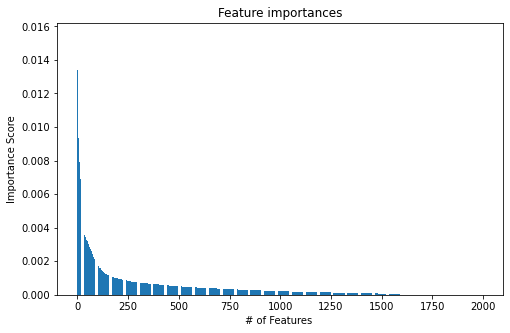

In [40]:
# Use RandomForestClassifier to select most important features
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X[train_index], y[train_index])
RFCmodel = SelectFromModel(rf_clf, prefit=True)

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:2000]
print('Optimal number of features :', RFCmodel.get_support().sum())

plt.figure(1, figsize=(8, 5))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(2000), importances[indices])
plt.show()

In [41]:
train_X_df = pd.DataFrame(X[train_index])

In [42]:
fs_train_cv_1 = train_X_df.loc[:, RFCmodel.get_support()]

In [43]:
test_X_df = pd.DataFrame(X[test_index])

In [44]:
fs_test_cv_1 = test_X_df.loc[:, RFCmodel.get_support()]

In [45]:
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(results_session[best_model][1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][4]),
        tf.keras.layers.Dense(results_session[best_model][2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(results_session[best_model][3], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])

In [46]:
model2.compile(
  optimizer=results_session[best_model][6],
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [47]:
model2.fit(fs_train_cv_1, y_o[train_index],   
        epochs=EPOCHS)

Epoch 1/200
7/7 [==============================] - 1s 3ms/step - loss: 1.5685 - accuracy: 0.3450
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3800 - accuracy: 0.4900
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2496 - accuracy: 0.6600
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 1.1135 - accuracy: 0.7150
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 1.0004 - accuracy: 0.7200
Epoch 6/200
7/7 [==============================] - 0s 3ms/step - loss: 0.9522 - accuracy: 0.7050
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8938 - accuracy: 0.7500
Epoch 8/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8540 - accuracy: 0.7450
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 0.7591 - accuracy: 0.7550
Epoch 10/200
7/7 [==============================] - 0s 3ms/step - loss: 0.7434 - accuracy: 0.7400
Epoch 11/200
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9900
Epoch 85/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0232 - accuracy: 1.0000
Epoch 86/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0398 - accuracy: 0.9900
Epoch 87/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9800
Epoch 88/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0395 - accuracy: 0.9950
Epoch 89/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9950
Epoch 90/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0376 - accuracy: 0.9850
Epoch 91/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9900
Epoch 92/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 0.9700
Epoch 93/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.9900
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 0.0239 - accuracy: 0.9950
Epoch 168/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 0.9900
Epoch 169/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 170/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 0.9950
Epoch 171/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 172/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0122 - accuracy: 0.9950
Epoch 173/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 174/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0147 - accuracy: 0.9950
Epoch 175/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 176/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0255 - accuracy: 0.9950
Epoch 177/200
7/7 [=====

In [48]:
test_prediction = model2.predict(fs_test_cv_1)

In [49]:
test_prediction_ohe = scalar_to_ohe(test_prediction)

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test_prediction_ohe))

array([[31,  0,  0,  1,  0],
       [ 0, 40,  0,  1,  3],
       [ 0,  0,  7,  0,  0],
       [ 0,  2,  0,  5,  0],
       [ 0,  2,  0,  0,  7]])

In [51]:
from sklearn.metrics import classification_report

print(classification_report(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test_prediction_ohe)))

              precision    recall  f1-score   support

         A1A       1.00      0.97      0.98        32
     DIABETE       0.91      0.91      0.91        44
          GS       1.00      1.00      1.00         7
         MCM       0.71      0.71      0.71         7
        NALD       0.70      0.78      0.74         9

    accuracy                           0.91        99
   macro avg       0.86      0.87      0.87        99
weighted avg       0.91      0.91      0.91        99



### Feature Importance: Recursive Elimination

Optimal number of features : 189


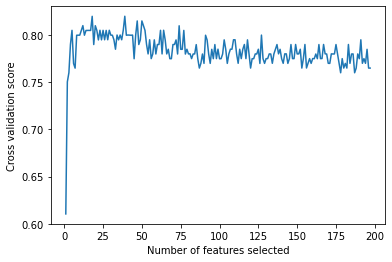

In [52]:
rfecv = RFECV(estimator=RandomForestClassifier(), step=5, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(fs_train_cv_1, y[train_index])
print('Optimal number of features :', rfecv.n_features_)

# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [53]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=rfecv.n_features_, step=5)
rfe = rfe.fit(fs_train_cv_1, y[train_index])

In [54]:
fs_train_cv_2 = fs_train_cv_1.loc[:, rfe.get_support()]

In [55]:
fs_test_cv_2 = fs_test_cv_1.loc[:, rfe.get_support()]

In [56]:
model3 = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(results_session[best_model][1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][4]),
        tf.keras.layers.Dense(results_session[best_model][2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(results_session[best_model][3], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])

In [57]:
model3.compile(
  optimizer=results_session[best_model][6],
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [58]:
model3.fit(fs_train_cv_2, y_o[train_index],   
        epochs=EPOCHS)

Epoch 1/200
7/7 [==============================] - 1s 3ms/step - loss: 1.6452 - accuracy: 0.3100
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 1.4581 - accuracy: 0.3300
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3652 - accuracy: 0.3600
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2903 - accuracy: 0.3450
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2165 - accuracy: 0.4250
Epoch 6/200
7/7 [==============================] - 0s 3ms/step - loss: 1.1291 - accuracy: 0.5550
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 1.0695 - accuracy: 0.5800
Epoch 8/200
7/7 [==============================] - 0s 3ms/step - loss: 1.0240 - accuracy: 0.7100
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 0.9421 - accuracy: 0.6800
Epoch 10/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8705 - accuracy: 0.7750
Epoch 11/200
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.9850
Epoch 85/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9900
Epoch 86/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0500 - accuracy: 0.9900
Epoch 87/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9900
Epoch 88/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0744 - accuracy: 0.9750
Epoch 89/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 1.0000
Epoch 90/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9950
Epoch 91/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9800
Epoch 92/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0234 - accuracy: 0.9950
Epoch 93/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0327 - accuracy: 0.9900
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9950
Epoch 168/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 169/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 1.0000
Epoch 170/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 171/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 172/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 173/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 174/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 0.9950
Epoch 175/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 0.9950
Epoch 176/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9950
Epoch 177/200
7/7 [=====

In [59]:
test2_prediction = model3.predict(fs_test_cv_2)

In [60]:
test2_prediction_ohe = scalar_to_ohe(test2_prediction)

In [61]:
from sklearn.metrics import confusion_matrix

confusion_matrix(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test2_prediction_ohe))

array([[32,  0,  0,  0,  0],
       [ 0, 40,  3,  0,  1],
       [ 0,  0,  7,  0,  0],
       [ 0,  3,  0,  4,  0],
       [ 0,  3,  0,  0,  6]])

In [62]:
from sklearn.metrics import classification_report

print(classification_report(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test2_prediction_ohe)))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        32
     DIABETE       0.87      0.91      0.89        44
          GS       0.70      1.00      0.82         7
         MCM       1.00      0.57      0.73         7
        NALD       0.86      0.67      0.75         9

    accuracy                           0.90        99
   macro avg       0.89      0.83      0.84        99
weighted avg       0.91      0.90      0.90        99



In [63]:
train2_prediction = model3.predict(fs_train_cv_2)

In [64]:
train2_prediction_ohe = scalar_to_ohe(train2_prediction)

In [65]:
from sklearn.metrics import classification_report

print(classification_report(encoder.inverse_transform(y_o[train_index]), encoder.inverse_transform(train2_prediction_ohe)))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        64
     DIABETE       1.00      1.00      1.00        88
          GS       1.00      1.00      1.00        15
         MCM       1.00      1.00      1.00        14
        NALD       1.00      1.00      1.00        19

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [66]:
genes = fs_train_cv_1.loc[:,rfe.support_].columns

In [67]:
len(genes)

189